In [83]:
import sys, os

working_dir = os.path.dirname(sys.path[0])
dataset_dir = os.path.join(working_dir,'Robot_datasets')   
run_loc= os.path.join(working_dir,'Logs/test_runs_2.csv')
train_loc = os.path.join(working_dir,'data/Train/')
test_loc = os.path.join(working_dir,'data/Test/')

sys.path.append(working_dir)
print('Working directory is '+ working_dir)

Working directory is /home/user/jacobs/cudavision


In [84]:
import numpy as np
import pandas as pd
import torch 
import time
import gc
from torchvision import transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

# Data set
from RobotData import RobotsDatasetPrecomputed, MetaData

# Model
from net import Net

# Loss function
from criterion import criterion

# Performance Metrics
from metric_detection import score, get_score
from metric_segmentation import IOU_run
from visualize import visualize_run

# Save results
from logger import Logger

# Transforms, which support different targets ('seg','det' or 'both')
import mode_transforms

# Loss function
from criterion import criterion

#
from test_cuda import test
from train import train, train_concurrent

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
modes = ['both','det','seg', 'concurrent']

train_dataset = dict.fromkeys(modes, None) 
train_loader = dict.fromkeys(modes, None)
test_dataset = dict.fromkeys(modes, None) 
test_loader = dict.fromkeys(modes, None)
    
model_args = {
    'concatenated_bias' : 'None',
    'concatenated_bias_learnable' : False,
    'added_bias': 'None',
}

args = {'test_batch_size': 10,
        'batch_size': 10,
        'size_after_transform': (3*32*5,4*32*5),
        'lr': 0.001,
        'max_lr':0.01,
        'gamma':0.7,
        'seed': 2,
        'log_interval':10,
        'save_model':True,
        'l1':100,
        'l2':1,
        'l3':0.01,
        'l4':0,
        'model_args' : model_args,
}


torch.manual_seed(args['seed'])

In [85]:
# Precompute all the data, if necessary
meta = MetaData(dataset_dir=dataset_dir)
for resolution in [(i*3*32,i*4*32) for i in range(1,6)]:
    meta.add_directory(train_loc,device,resolution, split = 'train')
    meta.add_directory(test_loc,device,resolution, split = 'test')
save = sys.modules[__name__].__dict__.copy()

In [14]:
def show_df_seg(df):
    df['cumulative time'] = df['time'].cumsum()
    print('Background IOU',df['Background IOU'].max(), 'Lines IOU', df['Lines IOU'].max(),'Field IOU',df['Field IOU'].max())
    print('Background Acc',df['Background Acc'].max(), 'Lines Acc', df['Lines Acc'].max(),'Field Acc',df['Field Acc'].max())
    df.plot(x = 'cumulative time', y = ['Background IOU', 'Lines IOU', 'Field IOU', 'Background Acc','Lines Acc','Field Acc'], xlim=(0,10000), ylim = (0,1))

In [16]:
  def show_df_det(df):
    df['Robots acc']=df['Robots correct']/(df['Robots wrong']+df['Robots correct']+df['Robots FP'])
    df['Balls acc']=df['Balls correct']/(df['Balls wrong']+df['Balls correct']+df['Balls FP'])
    df['Goals acc']=df['Goals correct']/(df['Goals wrong']+df['Goals correct']+df['Goals FP'])
    df['cumulative time'] = df['time'].cumsum()
    df.plot(x = 'cumulative time', y = ['Robots acc', 'Balls acc', 'Goals acc'], xlim=(0,12000), ylim = (0,1))
    print('Robots acc',df['Robots acc'].max(), 'Balls acc', df['Balls acc'].max(),'Goals acc',df['Goals acc'].max())

# How much does the initial freezing together with progressive resizing help?
- Type 1: Initial unrestrained training followed by progressive training.
- Type 2: Progressive Training.
- Type 3: No freezing or progressive increasing in size.

In [4]:
def experiment1():
    schedule = [{'input_dimension': (3*32*5,4*32*5), 'epoch': 5,'phase': 'thaw', 'mode': 'det'}] \
         + [{'input_dimension': (3*32*i,4*32*i), 'epoch': 10,'phase': 'freeze', 'mode': 'concurrent'} for i in range(1,6)] \
         + [{'input_dimension': (3*32*5,4*32*5), 'epoch': 50,'phase': 'thaw', 'mode': 'concurrent'}]

    args['size_after_transform'] = schedule[0]['input_dimension']
    model = Net(**args['model_args'],input_dimension = args['size_after_transform']).to(device)
    optimizer = optim.Adam(model.parameters(), 0.001)
    scheduler = CyclicLR(optimizer, base_lr=args['lr'],max_lr=args['max_lr'],cycle_momentum=False)
    epoch = 0


    run_id = 668

    log_loc = os.path.join(working_dir,f'Logs/test_logs_2_{run_id}.csv')
    logger = Logger(run_loc,log_loc,run_id,args)

    resume = False
    if resume == True:
        model.load_state_dict(torch.load(os.path.join(working_dir,f"Models/final_model_{run_id}.pt")))    
    if args['save_model']:
        torch.save(model.state_dict(), os.path.join(working_dir,f"Models/final_model_{run_id}.pt"))
    
    start_time = time.time()

    for phase in schedule:
        print(phase)
        for mode in modes:
            train_dataset[mode] = RobotsDatasetPrecomputed(meta,mode = mode,input_dimension=phase['input_dimension'],device=device,split='train')
            train_loader[mode] = torch.utils.data.DataLoader(train_dataset[mode],batch_size=args['batch_size'], shuffle=True)
            test_dataset[mode] = RobotsDatasetPrecomputed(meta,mode = mode,input_dimension=phase['input_dimension'],device=device,split='test')
            test_loader[mode] = torch.utils.data.DataLoader(test_dataset[mode],batch_size=args['test_batch_size'], shuffle=False)

        model.set_input_dimension(phase['input_dimension'])

        if phase['phase'] == 'freeze':
            model.freeze_encoder()
        else:
            model.unfreeze_encoder()


        for _ in range(phase['epoch']):
            epoch = epoch + 1
            if phase['mode'] == 'concurrent':
                train_concurrent(args, model, device, train_loader[phase['mode']], optimizer, epoch ,logger=logger)
            else: 
                train(args, model, device, train_loader[phase['mode']], optimizer, epoch , mode = phase['mode'],logger=logger)

            test(args, model, device, test_loader['det'], mode = 'det',logger=logger)
            test(args, model, device, test_loader['seg'], mode = 'seg',logger=logger)
            scheduler.step()
            logger.log_data()

            if args['save_model']:
                torch.save(model.state_dict(), os.path.join(working_dir,f"Models/final_model_{run_id}.pt"))
                
    return time.time() - start_time

In [5]:
def experiment2():
    schedule = [{'input_dimension': (3*32*i,4*32*i), 'epoch': 10,'phase': 'freeze', 'mode': 'concurrent'} for i in range(1,6)] \
             + [{'input_dimension': (3*32*5,4*32*5), 'epoch': 55,'phase': 'thaw', 'mode': 'concurrent'}]

    args['size_after_transform'] = schedule[0]['input_dimension']
    model = Net(**args['model_args'],input_dimension = args['size_after_transform']).to(device)
    optimizer = optim.Adam(model.parameters(), 0.001)
    scheduler = CyclicLR(optimizer, base_lr=args['lr'],max_lr=args['max_lr'],cycle_momentum=False)
    epoch = 0

    run_id = 669

    log_loc = os.path.join(working_dir,f'Logs/test_logs_2_{run_id}.csv')
    logger = Logger(run_loc,log_loc,run_id,args)

    resume = False
    if resume == True:
        model.load_state_dict(torch.load(os.path.join(working_dir,f"Models/final_model_{run_id}.pt")))    
    if args['save_model']:
        torch.save(model.state_dict(), os.path.join(working_dir,f"Models/final_model_{run_id}.pt"))

    start_time = time.time()

    for phase in schedule:
        print(phase)
        for mode in modes:
            train_dataset[mode] = RobotsDatasetPrecomputed(meta,mode = mode,input_dimension=phase['input_dimension'],device=device,split='train')
            train_loader[mode] = torch.utils.data.DataLoader(train_dataset[mode],batch_size=args['batch_size'], shuffle=True)
            test_dataset[mode] = RobotsDatasetPrecomputed(meta,mode = mode,input_dimension=phase['input_dimension'],device=device,split='test')
            test_loader[mode] = torch.utils.data.DataLoader(test_dataset[mode],batch_size=args['test_batch_size'], shuffle=False)

        model.set_input_dimension(phase['input_dimension'])

        if phase['phase'] == 'freeze':
            model.freeze_encoder()
        else:
            model.unfreeze_encoder()


        for _ in range(phase['epoch']):
            epoch = epoch + 1
            if phase['mode'] == 'concurrent':
                train_concurrent(args, model, device, train_loader[phase['mode']], optimizer, epoch ,logger=logger)
            else: 
                train(args, model, device, train_loader[phase['mode']], optimizer, epoch , mode = phase['mode'],logger=logger)

            test(args, model, device, test_loader['det'], mode = 'det',logger=logger)
            test(args, model, device, test_loader['seg'], mode = 'seg',logger=logger)
            scheduler.step()
            logger.log_data()

            if args['save_model']:
                torch.save(model.state_dict(), os.path.join(working_dir,f"Models/final_model_{run_id}.pt"))
                
    return time.time() - start_time

In [6]:
def experiment3(time_taken2):
    phase = {'input_dimension': (3*32*5,4*32*5), 'epoch': 100,'phase': 'thaw', 'mode': 'concurrent'}

    args['size_after_transform'] = phase['input_dimension']
    model = Net(**args['model_args'],input_dimension = args['size_after_transform']).to(device)
    optimizer = optim.Adam(model.parameters(), 0.001)
    scheduler = CyclicLR(optimizer, base_lr=args['lr'],max_lr=args['max_lr'],cycle_momentum=False)
    epoch = 0

    run_id = 670

    log_loc = os.path.join(working_dir,f'Logs/test_logs_2_{run_id}.csv')
    logger = Logger(run_loc,log_loc,run_id,args)

    resume = False
    if resume == True:
        model.load_state_dict(torch.load(os.path.join(working_dir,f"Models/final_model_{run_id}.pt")))    
    if args['save_model']:
        torch.save(model.state_dict(), os.path.join(working_dir,f"Models/final_model_{run_id}.pt"))

    time_taken3 = 0
    start_time = time.time()


    print(phase)
    for mode in modes:
        train_dataset[mode] = RobotsDatasetPrecomputed(meta,mode = mode,input_dimension=phase['input_dimension'],device=device,split='train')
        train_loader[mode] = torch.utils.data.DataLoader(train_dataset[mode],batch_size=args['batch_size'], shuffle=True)
        test_dataset[mode] = RobotsDatasetPrecomputed(meta,mode = mode,input_dimension=phase['input_dimension'],device=device,split='test')
        test_loader[mode] = torch.utils.data.DataLoader(test_dataset[mode],batch_size=args['test_batch_size'], shuffle=False)

    model.set_input_dimension(phase['input_dimension'])

    if phase['phase'] == 'freeze':
        model.freeze_encoder()
    else:
        model.unfreeze_encoder()


    while time_taken2 > time_taken3:
        epoch = epoch + 1
        if phase['mode'] == 'concurrent':
            train_concurrent(args, model, device, train_loader[phase['mode']], optimizer, epoch ,logger=logger)
        else: 
            train(args, model, device, train_loader[phase['mode']], optimizer, epoch , mode = phase['mode'],logger=logger)

        test(args, model, device, test_loader['det'], mode = 'det',logger=logger)
        test(args, model, device, test_loader['seg'], mode = 'seg',logger=logger)
        scheduler.step()
        logger.log_data()

        if args['save_model']:
            torch.save(model.state_dict(), os.path.join(working_dir,f"Models/final_model_{run_id}.pt"))
        time_taken3 = time.time() - start_time
    return time.time() - start_time

In [7]:
time1 = experiment1()

{'input_dimension': (480, 640), 'epoch': 5, 'phase': 'thaw', 'mode': 'det'}
Train Epoch det: 1 [0/6194(0%)]	Loss: 1.932919, time: 1.1250884532928467
Train Epoch det: 1 [100/6194(2%)]	Loss: 0.161753, time: 1.4053092002868652
Train Epoch det: 1 [200/6194(3%)]	Loss: 0.049451, time: 1.3967840671539307
Train Epoch det: 1 [300/6194(5%)]	Loss: 0.029491, time: 1.4654760360717773
Train Epoch det: 1 [400/6194(6%)]	Loss: 0.022867, time: 1.43135404586792
Train Epoch det: 1 [500/6194(8%)]	Loss: 0.023551, time: 1.4735798835754395
Train Epoch det: 1 [600/6194(10%)]	Loss: 0.016789, time: 1.4759273529052734
Train Epoch det: 1 [700/6194(11%)]	Loss: 0.016349, time: 1.4780967235565186
Train Epoch det: 1 [800/6194(13%)]	Loss: 0.017747, time: 1.5278253555297852
Train Epoch det: 1 [900/6194(15%)]	Loss: 0.013685, time: 1.4657413959503174
Train Epoch det: 1 [1000/6194(16%)]	Loss: 0.012880, time: 1.4871623516082764
Train Epoch det: 1 [1100/6194(18%)]	Loss: 0.012890, time: 1.4351692199707031
Train Epoch det: 1 [

/home/user/jacobs/cudavision/metric_detection.py:89: RuntimeWarning: invalid value encountered in double_scalars
  recall = correct/(correct+FN)
/home/user/jacobs/cudavision/criterion.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l2*nll(F.log_softmax(output[1]), seg.long()) \



Test set: seg Average loss: 0.1037

Background: IOU: 0.2073, accuracy: 0.7278
Lines: IOU: 0.0801, accuracy: 0.8282
Field: IOU: 0.6406, accuracy: 0.7016
Total: IOU: 0.3093, accuracy: 0.7525
making log csv
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_668.csv
Train Epoch det: 2 [0/6194(0%)]	Loss: 0.011294, time: 0.07334232330322266
Train Epoch det: 2 [100/6194(2%)]	Loss: 0.011076, time: 1.3184990882873535
Train Epoch det: 2 [200/6194(3%)]	Loss: 0.014920, time: 1.3202261924743652
Train Epoch det: 2 [300/6194(5%)]	Loss: 0.011735, time: 1.3166794776916504
Train Epoch det: 2 [400/6194(6%)]	Loss: 0.011515, time: 1.3173744678497314
Train Epoch det: 2 [500/6194(8%)]	Loss: 0.012027, time: 1.3173754215240479
Train Epoch det: 2 [600/6194(10%)]	Loss: 0.014141, time: 1.3215506076812744
Train Epoch det: 2 [700/6194(11%)]	Loss: 0.015121, time: 1.3216497898101807
Train Epoch det: 2 [800/6194(13%)]	Loss: 0.012899, time: 1.3193809986114502
Train Epoch det: 2 [900/6194(15%)]	Loss: 0.0127

Train Epoch det: 3 [3500/6194(56%)]	Loss: 0.008427, time: 1.3331668376922607
Train Epoch det: 3 [3600/6194(58%)]	Loss: 0.008566, time: 1.336775541305542
Train Epoch det: 3 [3700/6194(60%)]	Loss: 0.009466, time: 1.341238260269165
Train Epoch det: 3 [3800/6194(61%)]	Loss: 0.009631, time: 1.336531639099121
Train Epoch det: 3 [3900/6194(63%)]	Loss: 0.008984, time: 1.336148738861084
Train Epoch det: 3 [4000/6194(65%)]	Loss: 0.004563, time: 1.3340857028961182
Train Epoch det: 3 [4100/6194(66%)]	Loss: 0.009868, time: 1.342984914779663
Train Epoch det: 3 [4200/6194(68%)]	Loss: 0.006687, time: 1.3349339962005615
Train Epoch det: 3 [4300/6194(69%)]	Loss: 0.007554, time: 1.336578130722046
Train Epoch det: 3 [4400/6194(71%)]	Loss: 0.007031, time: 1.33530592918396
Train Epoch det: 3 [4500/6194(73%)]	Loss: 0.010829, time: 1.3326759338378906
Train Epoch det: 3 [4600/6194(74%)]	Loss: 0.009701, time: 1.3365893363952637
Train Epoch det: 3 [4700/6194(76%)]	Loss: 0.008487, time: 1.3356640338897705
Train E

Train Epoch det: 5 [400/6194(6%)]	Loss: 0.005634, time: 1.3424038887023926
Train Epoch det: 5 [500/6194(8%)]	Loss: 0.005583, time: 1.344200849533081
Train Epoch det: 5 [600/6194(10%)]	Loss: 0.006479, time: 1.342822790145874
Train Epoch det: 5 [700/6194(11%)]	Loss: 0.006189, time: 1.3388700485229492
Train Epoch det: 5 [800/6194(13%)]	Loss: 0.004464, time: 1.340268611907959
Train Epoch det: 5 [900/6194(15%)]	Loss: 0.009062, time: 1.3420183658599854
Train Epoch det: 5 [1000/6194(16%)]	Loss: 0.003294, time: 1.3427238464355469
Train Epoch det: 5 [1100/6194(18%)]	Loss: 0.003755, time: 1.3422467708587646
Train Epoch det: 5 [1200/6194(19%)]	Loss: 0.006781, time: 1.3399672508239746
Train Epoch det: 5 [1300/6194(21%)]	Loss: 0.004447, time: 1.3444061279296875
Train Epoch det: 5 [1400/6194(23%)]	Loss: 0.003961, time: 1.3426320552825928
Train Epoch det: 5 [1500/6194(24%)]	Loss: 0.005525, time: 1.3427133560180664
Train Epoch det: 5 [1600/6194(26%)]	Loss: 0.006227, time: 1.3433036804199219
Train Epoc

/home/user/jacobs/cudavision/criterion.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l2*nll(F.log_softmax(output[1]), seg.long()) \


Train Epoch concurrent: 6 [0/6194(0%)]	Loss: 0.118963, time: 0.04414176940917969
Train Epoch concurrent: 6 [100/6194(2%)]	Loss: 0.073940, time: 0.43175220489501953
Train Epoch concurrent: 6 [200/6194(3%)]	Loss: 0.066626, time: 0.42121362686157227
Train Epoch concurrent: 6 [300/6194(5%)]	Loss: 0.061034, time: 0.41305065155029297
Train Epoch concurrent: 6 [400/6194(6%)]	Loss: 0.049062, time: 0.39307355880737305
Train Epoch concurrent: 6 [500/6194(8%)]	Loss: 0.050401, time: 0.393460750579834
Train Epoch concurrent: 6 [600/6194(10%)]	Loss: 0.040686, time: 0.3817603588104248
Train Epoch concurrent: 6 [700/6194(11%)]	Loss: 0.045741, time: 0.38208818435668945
Train Epoch concurrent: 6 [800/6194(13%)]	Loss: 0.054458, time: 0.3838832378387451
Train Epoch concurrent: 6 [900/6194(15%)]	Loss: 0.039624, time: 0.379852294921875
Train Epoch concurrent: 6 [1000/6194(16%)]	Loss: 0.036137, time: 0.37096214294433594
Train Epoch concurrent: 6 [1100/6194(18%)]	Loss: 0.033894, time: 0.3706972599029541
Train

/home/user/jacobs/cudavision/metric_segmentation.py:51: RuntimeWarning: invalid value encountered in true_divide
  IOU_imagewise[:,i] = true_positives_imagewise[cat]/(true_positives_imagewise[cat] + false_positives_imagewise[cat] + false_negatives_imagewise[cat])



Test set: seg Average loss: 0.0178

Background: IOU: 0.9121, accuracy: 0.9784
Lines: IOU: 0.0772, accuracy: 0.9632
Field: IOU: 0.9178, accuracy: 0.9434
Total: IOU: 0.6357, accuracy: 0.9617
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_668.csv
Train Epoch concurrent: 7 [0/6194(0%)]	Loss: 0.023780, time: 0.02689838409423828
Train Epoch concurrent: 7 [100/6194(2%)]	Loss: 0.024682, time: 0.26010751724243164
Train Epoch concurrent: 7 [200/6194(3%)]	Loss: 0.021747, time: 0.25600147247314453
Train Epoch concurrent: 7 [300/6194(5%)]	Loss: 0.019707, time: 0.2576155662536621
Train Epoch concurrent: 7 [400/6194(6%)]	Loss: 0.025473, time: 0.25606751441955566
Train Epoch concurrent: 7 [500/6194(8%)]	Loss: 0.020037, time: 0.257688045501709
Train Epoch concurrent: 7 [600/6194(10%)]	Loss: 0.020902, time: 0.25665926933288574
Train Epoch concurrent: 7 [700/6194(11%)]	Loss: 0.024254, time: 0.2564280033111572
Train Epoch concurrent: 7 [800/6194(13%)]	Loss: 0.026436, time: 0.2572023868560

Train Epoch concurrent: 8 [2600/6194(42%)]	Loss: 0.024160, time: 0.2610800266265869
Train Epoch concurrent: 8 [2700/6194(44%)]	Loss: 0.015538, time: 0.25950169563293457
Train Epoch concurrent: 8 [2800/6194(45%)]	Loss: 0.015870, time: 0.26041579246520996
Train Epoch concurrent: 8 [2900/6194(47%)]	Loss: 0.018008, time: 0.25958991050720215
Train Epoch concurrent: 8 [3000/6194(48%)]	Loss: 0.022311, time: 0.2597997188568115
Train Epoch concurrent: 8 [3100/6194(50%)]	Loss: 0.016124, time: 0.2603757381439209
Train Epoch concurrent: 8 [3200/6194(52%)]	Loss: 0.019658, time: 0.26053547859191895
Train Epoch concurrent: 8 [3300/6194(53%)]	Loss: 0.020279, time: 0.26098108291625977
Train Epoch concurrent: 8 [3400/6194(55%)]	Loss: 0.016962, time: 0.26006531715393066
Train Epoch concurrent: 8 [3500/6194(56%)]	Loss: 0.016950, time: 0.2613832950592041
Train Epoch concurrent: 8 [3600/6194(58%)]	Loss: 0.017573, time: 0.25945591926574707
Train Epoch concurrent: 8 [3700/6194(60%)]	Loss: 0.022936, time: 0.25

Train Epoch concurrent: 9 [5500/6194(89%)]	Loss: 0.022187, time: 0.26098179817199707
Train Epoch concurrent: 9 [5600/6194(90%)]	Loss: 0.015933, time: 0.2599968910217285
Train Epoch concurrent: 9 [5700/6194(92%)]	Loss: 0.016386, time: 0.26110005378723145
Train Epoch concurrent: 9 [5800/6194(94%)]	Loss: 0.015718, time: 0.25969958305358887
Train Epoch concurrent: 9 [5900/6194(95%)]	Loss: 0.014399, time: 0.26684093475341797
Train Epoch concurrent: 9 [6000/6194(97%)]	Loss: 0.016006, time: 0.2681715488433838
Train Epoch concurrent: 9 [6100/6194(98%)]	Loss: 0.017450, time: 0.2666800022125244

Test set: det Average loss: 0.0092

Balls: F1: 0.6492, accuracy: 0.4806, recall: 0.8954, precision: 0.5092, FDR: 0.4908,
Goalposts: F1: 0.3870, accuracy: 0.2400, recall: 0.7408, precision: 0.2619, FDR: 0.7381,
Robots: F1: 0.2898, accuracy: 0.1694, recall: 0.6005, precision: 0.1910, FDR: 0.8090,

Test set: seg Average loss: 0.0127

Background: IOU: 0.9335, accuracy: 0.9859
Lines: IOU: 0.3507, accuracy: 0.

Train Epoch concurrent: 11 [1500/6194(24%)]	Loss: 0.016681, time: 0.26085734367370605
Train Epoch concurrent: 11 [1600/6194(26%)]	Loss: 0.014165, time: 0.259335994720459
Train Epoch concurrent: 11 [1700/6194(27%)]	Loss: 0.012676, time: 0.2612948417663574
Train Epoch concurrent: 11 [1800/6194(29%)]	Loss: 0.015623, time: 0.2592451572418213
Train Epoch concurrent: 11 [1900/6194(31%)]	Loss: 0.012083, time: 0.26037168502807617
Train Epoch concurrent: 11 [2000/6194(32%)]	Loss: 0.011733, time: 0.2595071792602539
Train Epoch concurrent: 11 [2100/6194(34%)]	Loss: 0.013655, time: 0.26096057891845703
Train Epoch concurrent: 11 [2200/6194(35%)]	Loss: 0.015240, time: 0.2593846321105957
Train Epoch concurrent: 11 [2300/6194(37%)]	Loss: 0.013885, time: 0.2612178325653076
Train Epoch concurrent: 11 [2400/6194(39%)]	Loss: 0.012626, time: 0.2593522071838379
Train Epoch concurrent: 11 [2500/6194(40%)]	Loss: 0.013422, time: 0.26033782958984375
Train Epoch concurrent: 11 [2600/6194(42%)]	Loss: 0.012169, ti

Train Epoch concurrent: 12 [4300/6194(69%)]	Loss: 0.010824, time: 0.2606329917907715
Train Epoch concurrent: 12 [4400/6194(71%)]	Loss: 0.011556, time: 0.2600252628326416
Train Epoch concurrent: 12 [4500/6194(73%)]	Loss: 0.014057, time: 0.26024961471557617
Train Epoch concurrent: 12 [4600/6194(74%)]	Loss: 0.013757, time: 0.26038169860839844
Train Epoch concurrent: 12 [4700/6194(76%)]	Loss: 0.017433, time: 0.2609696388244629
Train Epoch concurrent: 12 [4800/6194(77%)]	Loss: 0.011547, time: 0.26171135902404785
Train Epoch concurrent: 12 [4900/6194(79%)]	Loss: 0.011463, time: 0.25993895530700684
Train Epoch concurrent: 12 [5000/6194(81%)]	Loss: 0.010113, time: 0.262347936630249
Train Epoch concurrent: 12 [5100/6194(82%)]	Loss: 0.015058, time: 0.26000046730041504
Train Epoch concurrent: 12 [5200/6194(84%)]	Loss: 0.013062, time: 0.2609384059906006
Train Epoch concurrent: 12 [5300/6194(85%)]	Loss: 0.015353, time: 0.25959253311157227
Train Epoch concurrent: 12 [5400/6194(87%)]	Loss: 0.010806, 

Train Epoch concurrent: 14 [300/6194(5%)]	Loss: 0.012155, time: 0.25795555114746094
Train Epoch concurrent: 14 [400/6194(6%)]	Loss: 0.010267, time: 0.2594151496887207
Train Epoch concurrent: 14 [500/6194(8%)]	Loss: 0.009555, time: 0.25797319412231445
Train Epoch concurrent: 14 [600/6194(10%)]	Loss: 0.009070, time: 0.25926947593688965
Train Epoch concurrent: 14 [700/6194(11%)]	Loss: 0.010795, time: 0.2578551769256592
Train Epoch concurrent: 14 [800/6194(13%)]	Loss: 0.010399, time: 0.2609999179840088
Train Epoch concurrent: 14 [900/6194(15%)]	Loss: 0.009515, time: 0.25797438621520996
Train Epoch concurrent: 14 [1000/6194(16%)]	Loss: 0.010880, time: 0.2590787410736084
Train Epoch concurrent: 14 [1100/6194(18%)]	Loss: 0.010582, time: 0.25783205032348633
Train Epoch concurrent: 14 [1200/6194(19%)]	Loss: 0.030409, time: 0.25956153869628906
Train Epoch concurrent: 14 [1300/6194(21%)]	Loss: 0.014891, time: 0.2580556869506836
Train Epoch concurrent: 14 [1400/6194(23%)]	Loss: 0.011002, time: 0.2

Train Epoch concurrent: 15 [3100/6194(50%)]	Loss: 0.007423, time: 0.2585031986236572
Train Epoch concurrent: 15 [3200/6194(52%)]	Loss: 0.009684, time: 0.2604951858520508
Train Epoch concurrent: 15 [3300/6194(53%)]	Loss: 0.011984, time: 0.25832509994506836
Train Epoch concurrent: 15 [3400/6194(55%)]	Loss: 0.010232, time: 0.25963306427001953
Train Epoch concurrent: 15 [3500/6194(56%)]	Loss: 0.010874, time: 0.25780153274536133
Train Epoch concurrent: 15 [3600/6194(58%)]	Loss: 0.009118, time: 0.25908899307250977
Train Epoch concurrent: 15 [3700/6194(60%)]	Loss: 0.010487, time: 0.2584195137023926
Train Epoch concurrent: 15 [3800/6194(61%)]	Loss: 0.011296, time: 0.25929880142211914
Train Epoch concurrent: 15 [3900/6194(63%)]	Loss: 0.007989, time: 0.25927019119262695
Train Epoch concurrent: 15 [4000/6194(65%)]	Loss: 0.010208, time: 0.26018786430358887
Train Epoch concurrent: 15 [4100/6194(66%)]	Loss: 0.012049, time: 0.2578620910644531
Train Epoch concurrent: 15 [4200/6194(68%)]	Loss: 0.009593

/home/user/jacobs/cudavision/criterion.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l2*nll(F.log_softmax(output[1]), seg.long()) \


Train Epoch concurrent: 16 [0/6194(0%)]	Loss: 0.034604, time: 0.07148528099060059
Train Epoch concurrent: 16 [100/6194(2%)]	Loss: 0.027767, time: 0.9657862186431885
Train Epoch concurrent: 16 [200/6194(3%)]	Loss: 0.022660, time: 0.9830832481384277
Train Epoch concurrent: 16 [300/6194(5%)]	Loss: 0.026686, time: 0.9601552486419678
Train Epoch concurrent: 16 [400/6194(6%)]	Loss: 0.023515, time: 0.9421110153198242
Train Epoch concurrent: 16 [500/6194(8%)]	Loss: 0.020875, time: 0.7107572555541992
Train Epoch concurrent: 16 [600/6194(10%)]	Loss: 0.020560, time: 0.8253014087677002
Train Epoch concurrent: 16 [700/6194(11%)]	Loss: 0.015759, time: 0.8094182014465332
Train Epoch concurrent: 16 [800/6194(13%)]	Loss: 0.018417, time: 0.707313060760498
Train Epoch concurrent: 16 [900/6194(15%)]	Loss: 0.019387, time: 0.7835633754730225
Train Epoch concurrent: 16 [1000/6194(16%)]	Loss: 0.019712, time: 0.710106372833252
Train Epoch concurrent: 16 [1100/6194(18%)]	Loss: 0.013281, time: 0.7214806079864502

Train Epoch concurrent: 17 [2900/6194(47%)]	Loss: 0.012062, time: 0.4177539348602295
Train Epoch concurrent: 17 [3000/6194(48%)]	Loss: 0.014362, time: 0.4199690818786621
Train Epoch concurrent: 17 [3100/6194(50%)]	Loss: 0.016422, time: 0.420762300491333
Train Epoch concurrent: 17 [3200/6194(52%)]	Loss: 0.016430, time: 0.42070651054382324
Train Epoch concurrent: 17 [3300/6194(53%)]	Loss: 0.013152, time: 0.4199178218841553
Train Epoch concurrent: 17 [3400/6194(55%)]	Loss: 0.010631, time: 0.4200737476348877
Train Epoch concurrent: 17 [3500/6194(56%)]	Loss: 0.012042, time: 0.42032623291015625
Train Epoch concurrent: 17 [3600/6194(58%)]	Loss: 0.018055, time: 0.4182279109954834
Train Epoch concurrent: 17 [3700/6194(60%)]	Loss: 0.018511, time: 0.4201192855834961
Train Epoch concurrent: 17 [3800/6194(61%)]	Loss: 0.015810, time: 0.42014503479003906
Train Epoch concurrent: 17 [3900/6194(63%)]	Loss: 0.013190, time: 0.42085981369018555
Train Epoch concurrent: 17 [4000/6194(65%)]	Loss: 0.014447, ti

Train Epoch concurrent: 18 [5700/6194(92%)]	Loss: 0.012775, time: 0.419299840927124
Train Epoch concurrent: 18 [5800/6194(94%)]	Loss: 0.009779, time: 0.41898274421691895
Train Epoch concurrent: 18 [5900/6194(95%)]	Loss: 0.009547, time: 0.41997528076171875
Train Epoch concurrent: 18 [6000/6194(97%)]	Loss: 0.011422, time: 0.41968584060668945
Train Epoch concurrent: 18 [6100/6194(98%)]	Loss: 0.012135, time: 0.4190797805786133

Test set: det Average loss: 0.0059

Balls: F1: 0.8765, accuracy: 0.7801, recall: 0.9543, precision: 0.8104, FDR: 0.1896,
Goalposts: F1: 0.7657, accuracy: 0.6204, recall: 0.8825, precision: 0.6762, FDR: 0.3238,
Robots: F1: 0.7482, accuracy: 0.5977, recall: 0.8200, precision: 0.6880, FDR: 0.3120,

Test set: seg Average loss: 0.0085

Background: IOU: 0.9432, accuracy: 0.9886
Lines: IOU: 0.6025, accuracy: 0.9828
Field: IOU: 0.9574, accuracy: 0.9720
Total: IOU: 0.8344, accuracy: 0.9811
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_668.csv
Train Epoch con

Train Epoch concurrent: 20 [1700/6194(27%)]	Loss: 0.006532, time: 0.4213089942932129
Train Epoch concurrent: 20 [1800/6194(29%)]	Loss: 0.009368, time: 0.4243197441101074
Train Epoch concurrent: 20 [1900/6194(31%)]	Loss: 0.012059, time: 0.42561960220336914
Train Epoch concurrent: 20 [2000/6194(32%)]	Loss: 0.008415, time: 0.42142391204833984
Train Epoch concurrent: 20 [2100/6194(34%)]	Loss: 0.010532, time: 0.4213290214538574
Train Epoch concurrent: 20 [2200/6194(35%)]	Loss: 0.008680, time: 0.421337366104126
Train Epoch concurrent: 20 [2300/6194(37%)]	Loss: 0.009727, time: 0.42081236839294434
Train Epoch concurrent: 20 [2400/6194(39%)]	Loss: 0.009838, time: 0.42113471031188965
Train Epoch concurrent: 20 [2500/6194(40%)]	Loss: 0.010420, time: 0.4186577796936035
Train Epoch concurrent: 20 [2600/6194(42%)]	Loss: 0.009826, time: 0.418811559677124
Train Epoch concurrent: 20 [2700/6194(44%)]	Loss: 0.009386, time: 0.4202084541320801
Train Epoch concurrent: 20 [2800/6194(45%)]	Loss: 0.009619, tim

Train Epoch concurrent: 21 [4500/6194(73%)]	Loss: 0.008846, time: 0.42078495025634766
Train Epoch concurrent: 21 [4600/6194(74%)]	Loss: 0.009438, time: 0.421114444732666
Train Epoch concurrent: 21 [4700/6194(76%)]	Loss: 0.009542, time: 0.4196350574493408
Train Epoch concurrent: 21 [4800/6194(77%)]	Loss: 0.009635, time: 0.4188508987426758
Train Epoch concurrent: 21 [4900/6194(79%)]	Loss: 0.008629, time: 0.4203782081604004
Train Epoch concurrent: 21 [5000/6194(81%)]	Loss: 0.011964, time: 0.4210846424102783
Train Epoch concurrent: 21 [5100/6194(82%)]	Loss: 0.008953, time: 0.4210641384124756
Train Epoch concurrent: 21 [5200/6194(84%)]	Loss: 0.008595, time: 0.41954827308654785
Train Epoch concurrent: 21 [5300/6194(85%)]	Loss: 0.010286, time: 0.42718982696533203
Train Epoch concurrent: 21 [5400/6194(87%)]	Loss: 0.007425, time: 0.42083168029785156
Train Epoch concurrent: 21 [5500/6194(89%)]	Loss: 0.008564, time: 0.4191577434539795
Train Epoch concurrent: 21 [5600/6194(90%)]	Loss: 0.010288, ti

Train Epoch concurrent: 23 [500/6194(8%)]	Loss: 0.007193, time: 0.42141032218933105
Train Epoch concurrent: 23 [600/6194(10%)]	Loss: 0.007928, time: 0.4207155704498291
Train Epoch concurrent: 23 [700/6194(11%)]	Loss: 0.008978, time: 0.42082905769348145
Train Epoch concurrent: 23 [800/6194(13%)]	Loss: 0.008929, time: 0.4206359386444092
Train Epoch concurrent: 23 [900/6194(15%)]	Loss: 0.009124, time: 0.41827392578125
Train Epoch concurrent: 23 [1000/6194(16%)]	Loss: 0.007660, time: 0.42082738876342773
Train Epoch concurrent: 23 [1100/6194(18%)]	Loss: 0.008059, time: 0.4206724166870117
Train Epoch concurrent: 23 [1200/6194(19%)]	Loss: 0.007251, time: 0.4203760623931885
Train Epoch concurrent: 23 [1300/6194(21%)]	Loss: 0.008880, time: 0.421184778213501
Train Epoch concurrent: 23 [1400/6194(23%)]	Loss: 0.006908, time: 0.421431303024292
Train Epoch concurrent: 23 [1500/6194(24%)]	Loss: 0.006616, time: 0.42294907569885254
Train Epoch concurrent: 23 [1600/6194(26%)]	Loss: 0.008793, time: 0.427

Train Epoch concurrent: 24 [3300/6194(53%)]	Loss: 0.007169, time: 0.4216938018798828
Train Epoch concurrent: 24 [3400/6194(55%)]	Loss: 0.007445, time: 0.4210219383239746
Train Epoch concurrent: 24 [3500/6194(56%)]	Loss: 0.007300, time: 0.42360687255859375
Train Epoch concurrent: 24 [3600/6194(58%)]	Loss: 0.007071, time: 0.4231388568878174
Train Epoch concurrent: 24 [3700/6194(60%)]	Loss: 0.007846, time: 0.4228553771972656
Train Epoch concurrent: 24 [3800/6194(61%)]	Loss: 0.008216, time: 0.4233059883117676
Train Epoch concurrent: 24 [3900/6194(63%)]	Loss: 0.007354, time: 0.4232800006866455
Train Epoch concurrent: 24 [4000/6194(65%)]	Loss: 0.006977, time: 0.423673152923584
Train Epoch concurrent: 24 [4100/6194(66%)]	Loss: 0.007452, time: 0.42104244232177734
Train Epoch concurrent: 24 [4200/6194(68%)]	Loss: 0.007520, time: 0.42335939407348633
Train Epoch concurrent: 24 [4300/6194(69%)]	Loss: 0.009627, time: 0.4227726459503174
Train Epoch concurrent: 24 [4400/6194(71%)]	Loss: 0.006212, tim

Train Epoch concurrent: 25 [6100/6194(98%)]	Loss: 0.006587, time: 0.4236469268798828

Test set: det Average loss: 0.0051

Balls: F1: 0.8980, accuracy: 0.8149, recall: 0.9685, precision: 0.8372, FDR: 0.1628,
Goalposts: F1: 0.8211, accuracy: 0.6965, recall: 0.9102, precision: 0.7479, FDR: 0.2521,
Robots: F1: 0.8142, accuracy: 0.6866, recall: 0.8938, precision: 0.7476, FDR: 0.2524,

Test set: seg Average loss: 0.0122

Background: IOU: 0.9405, accuracy: 0.9800
Lines: IOU: 0.6209, accuracy: 0.9831
Field: IOU: 0.9494, accuracy: 0.9642
Total: IOU: 0.8369, accuracy: 0.9758
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_668.csv
{'input_dimension': (288, 384), 'epoch': 10, 'phase': 'freeze', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l2*nll(F.log_softmax(output[1]), seg.long()) \


Train Epoch concurrent: 26 [0/6194(0%)]	Loss: 0.025964, time: 0.1167287826538086
Train Epoch concurrent: 26 [100/6194(2%)]	Loss: 0.022326, time: 1.681189775466919
Train Epoch concurrent: 26 [200/6194(3%)]	Loss: 0.021159, time: 1.6195573806762695
Train Epoch concurrent: 26 [300/6194(5%)]	Loss: 0.012659, time: 1.4546217918395996
Train Epoch concurrent: 26 [400/6194(6%)]	Loss: 0.017004, time: 1.5198373794555664
Train Epoch concurrent: 26 [500/6194(8%)]	Loss: 0.014408, time: 1.5305962562561035
Train Epoch concurrent: 26 [600/6194(10%)]	Loss: 0.015788, time: 1.4594368934631348
Train Epoch concurrent: 26 [700/6194(11%)]	Loss: 0.016641, time: 1.406912088394165
Train Epoch concurrent: 26 [800/6194(13%)]	Loss: 0.012641, time: 1.385883092880249
Train Epoch concurrent: 26 [900/6194(15%)]	Loss: 0.015462, time: 1.414928674697876
Train Epoch concurrent: 26 [1000/6194(16%)]	Loss: 0.015902, time: 1.4181959629058838
Train Epoch concurrent: 26 [1100/6194(18%)]	Loss: 0.012580, time: 1.4644134044647217
Tr

Train Epoch concurrent: 27 [2900/6194(47%)]	Loss: 0.007872, time: 0.7179038524627686
Train Epoch concurrent: 27 [3000/6194(48%)]	Loss: 0.008198, time: 0.7134935855865479
Train Epoch concurrent: 27 [3100/6194(50%)]	Loss: 0.012495, time: 0.7073030471801758
Train Epoch concurrent: 27 [3200/6194(52%)]	Loss: 0.011881, time: 0.7108380794525146
Train Epoch concurrent: 27 [3300/6194(53%)]	Loss: 0.011634, time: 0.714914083480835
Train Epoch concurrent: 27 [3400/6194(55%)]	Loss: 0.012490, time: 0.7329177856445312
Train Epoch concurrent: 27 [3500/6194(56%)]	Loss: 0.014330, time: 0.7075545787811279
Train Epoch concurrent: 27 [3600/6194(58%)]	Loss: 0.011957, time: 0.7308368682861328
Train Epoch concurrent: 27 [3700/6194(60%)]	Loss: 0.011809, time: 0.7121391296386719
Train Epoch concurrent: 27 [3800/6194(61%)]	Loss: 0.010762, time: 0.7229804992675781
Train Epoch concurrent: 27 [3900/6194(63%)]	Loss: 0.011564, time: 0.7151026725769043
Train Epoch concurrent: 27 [4000/6194(65%)]	Loss: 0.010020, time: 

Train Epoch concurrent: 28 [5800/6194(94%)]	Loss: 0.011158, time: 0.7106752395629883
Train Epoch concurrent: 28 [5900/6194(95%)]	Loss: 0.007377, time: 0.7097477912902832
Train Epoch concurrent: 28 [6000/6194(97%)]	Loss: 0.007718, time: 0.7121806144714355
Train Epoch concurrent: 28 [6100/6194(98%)]	Loss: 0.010807, time: 0.7101099491119385

Test set: det Average loss: 0.0054

Balls: F1: 0.8569, accuracy: 0.7496, recall: 0.9784, precision: 0.7622, FDR: 0.2378,
Goalposts: F1: 0.7520, accuracy: 0.6026, recall: 0.9272, precision: 0.6325, FDR: 0.3675,
Robots: F1: 0.6793, accuracy: 0.5144, recall: 0.8786, precision: 0.5537, FDR: 0.4463,

Test set: seg Average loss: 0.0076

Background: IOU: 0.9418, accuracy: 0.9873
Lines: IOU: 0.6936, accuracy: 0.9869
Field: IOU: 0.9620, accuracy: 0.9749
Total: IOU: 0.8658, accuracy: 0.9830
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_668.csv
Train Epoch concurrent: 29 [0/6194(0%)]	Loss: 0.008014, time: 0.05244302749633789
Train Epoch concurre

Train Epoch concurrent: 30 [1800/6194(29%)]	Loss: 0.008245, time: 0.7116553783416748
Train Epoch concurrent: 30 [1900/6194(31%)]	Loss: 0.009254, time: 0.7109079360961914
Train Epoch concurrent: 30 [2000/6194(32%)]	Loss: 0.011914, time: 0.7126486301422119
Train Epoch concurrent: 30 [2100/6194(34%)]	Loss: 0.008555, time: 0.717310905456543
Train Epoch concurrent: 30 [2200/6194(35%)]	Loss: 0.006205, time: 0.711773157119751
Train Epoch concurrent: 30 [2300/6194(37%)]	Loss: 0.008148, time: 0.7125542163848877
Train Epoch concurrent: 30 [2400/6194(39%)]	Loss: 0.006669, time: 0.7098629474639893
Train Epoch concurrent: 30 [2500/6194(40%)]	Loss: 0.009971, time: 0.7123508453369141
Train Epoch concurrent: 30 [2600/6194(42%)]	Loss: 0.008927, time: 0.7111499309539795
Train Epoch concurrent: 30 [2700/6194(44%)]	Loss: 0.007584, time: 0.712792158126831
Train Epoch concurrent: 30 [2800/6194(45%)]	Loss: 0.008884, time: 0.7087903022766113
Train Epoch concurrent: 30 [2900/6194(47%)]	Loss: 0.009206, time: 0.

Train Epoch concurrent: 31 [4700/6194(76%)]	Loss: 0.006979, time: 0.7088539600372314
Train Epoch concurrent: 31 [4800/6194(77%)]	Loss: 0.006384, time: 0.7116150856018066
Train Epoch concurrent: 31 [4900/6194(79%)]	Loss: 0.006745, time: 0.7098855972290039
Train Epoch concurrent: 31 [5000/6194(81%)]	Loss: 0.010205, time: 0.7094190120697021
Train Epoch concurrent: 31 [5100/6194(82%)]	Loss: 0.008420, time: 0.71038818359375
Train Epoch concurrent: 31 [5200/6194(84%)]	Loss: 0.006553, time: 0.7134175300598145
Train Epoch concurrent: 31 [5300/6194(85%)]	Loss: 0.006798, time: 0.7118706703186035
Train Epoch concurrent: 31 [5400/6194(87%)]	Loss: 0.007057, time: 0.7085676193237305
Train Epoch concurrent: 31 [5500/6194(89%)]	Loss: 0.006115, time: 0.7147789001464844
Train Epoch concurrent: 31 [5600/6194(90%)]	Loss: 0.007408, time: 0.7097833156585693
Train Epoch concurrent: 31 [5700/6194(92%)]	Loss: 0.007497, time: 0.7130603790283203
Train Epoch concurrent: 31 [5800/6194(94%)]	Loss: 0.006709, time: 0

Train Epoch concurrent: 33 [700/6194(11%)]	Loss: 0.007358, time: 0.7117576599121094
Train Epoch concurrent: 33 [800/6194(13%)]	Loss: 0.006385, time: 0.7094123363494873
Train Epoch concurrent: 33 [900/6194(15%)]	Loss: 0.008380, time: 0.7127773761749268
Train Epoch concurrent: 33 [1000/6194(16%)]	Loss: 0.007165, time: 0.7091832160949707
Train Epoch concurrent: 33 [1100/6194(18%)]	Loss: 0.006334, time: 0.7116060256958008
Train Epoch concurrent: 33 [1200/6194(19%)]	Loss: 0.006348, time: 0.7124626636505127
Train Epoch concurrent: 33 [1300/6194(21%)]	Loss: 0.006577, time: 0.7204775810241699
Train Epoch concurrent: 33 [1400/6194(23%)]	Loss: 0.005669, time: 0.7105181217193604
Train Epoch concurrent: 33 [1500/6194(24%)]	Loss: 0.009354, time: 0.7096202373504639
Train Epoch concurrent: 33 [1600/6194(26%)]	Loss: 0.007404, time: 0.7102861404418945
Train Epoch concurrent: 33 [1700/6194(27%)]	Loss: 0.010271, time: 0.7093720436096191
Train Epoch concurrent: 33 [1800/6194(29%)]	Loss: 0.007261, time: 0.

Train Epoch concurrent: 34 [3600/6194(58%)]	Loss: 0.005054, time: 0.7098789215087891
Train Epoch concurrent: 34 [3700/6194(60%)]	Loss: 0.006677, time: 0.7122719287872314
Train Epoch concurrent: 34 [3800/6194(61%)]	Loss: 0.006791, time: 0.7081136703491211
Train Epoch concurrent: 34 [3900/6194(63%)]	Loss: 0.008565, time: 0.7123982906341553
Train Epoch concurrent: 34 [4000/6194(65%)]	Loss: 0.006867, time: 0.7100090980529785
Train Epoch concurrent: 34 [4100/6194(66%)]	Loss: 0.008854, time: 0.7121424674987793
Train Epoch concurrent: 34 [4200/6194(68%)]	Loss: 0.005536, time: 0.7084543704986572
Train Epoch concurrent: 34 [4300/6194(69%)]	Loss: 0.006743, time: 0.7103252410888672
Train Epoch concurrent: 34 [4400/6194(71%)]	Loss: 0.009369, time: 0.7107734680175781
Train Epoch concurrent: 34 [4500/6194(73%)]	Loss: 0.008027, time: 0.7104206085205078
Train Epoch concurrent: 34 [4600/6194(74%)]	Loss: 0.006154, time: 0.7116858959197998
Train Epoch concurrent: 34 [4700/6194(76%)]	Loss: 0.006734, time:


Test set: seg Average loss: 0.0079

Background: IOU: 0.9466, accuracy: 0.9894
Lines: IOU: 0.7014, accuracy: 0.9871
Field: IOU: 0.9650, accuracy: 0.9770
Total: IOU: 0.8710, accuracy: 0.9845
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_668.csv
{'input_dimension': (384, 512), 'epoch': 10, 'phase': 'freeze', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l2*nll(F.log_softmax(output[1]), seg.long()) \


Train Epoch concurrent: 36 [0/6194(0%)]	Loss: 0.014044, time: 0.22576117515563965
Train Epoch concurrent: 36 [100/6194(2%)]	Loss: 0.013617, time: 2.3805904388427734
Train Epoch concurrent: 36 [200/6194(3%)]	Loss: 0.015142, time: 2.423945188522339
Train Epoch concurrent: 36 [300/6194(5%)]	Loss: 0.011072, time: 2.322115421295166
Train Epoch concurrent: 36 [400/6194(6%)]	Loss: 0.011313, time: 2.334303379058838
Train Epoch concurrent: 36 [500/6194(8%)]	Loss: 0.010717, time: 2.2505667209625244
Train Epoch concurrent: 36 [600/6194(10%)]	Loss: 0.011855, time: 2.233685255050659
Train Epoch concurrent: 36 [700/6194(11%)]	Loss: 0.008674, time: 2.1509592533111572
Train Epoch concurrent: 36 [800/6194(13%)]	Loss: 0.014803, time: 2.111459493637085
Train Epoch concurrent: 36 [900/6194(15%)]	Loss: 0.008787, time: 2.05076003074646
Train Epoch concurrent: 36 [1000/6194(16%)]	Loss: 0.013689, time: 2.012321949005127
Train Epoch concurrent: 36 [1100/6194(18%)]	Loss: 0.012660, time: 2.044903516769409
Train 

Train Epoch concurrent: 37 [2900/6194(47%)]	Loss: 0.008061, time: 1.0984573364257812
Train Epoch concurrent: 37 [3000/6194(48%)]	Loss: 0.014072, time: 1.0916693210601807
Train Epoch concurrent: 37 [3100/6194(50%)]	Loss: 0.013231, time: 1.0931200981140137
Train Epoch concurrent: 37 [3200/6194(52%)]	Loss: 0.011062, time: 1.0922133922576904
Train Epoch concurrent: 37 [3300/6194(53%)]	Loss: 0.010717, time: 1.0930962562561035
Train Epoch concurrent: 37 [3400/6194(55%)]	Loss: 0.009486, time: 1.0924315452575684
Train Epoch concurrent: 37 [3500/6194(56%)]	Loss: 0.009611, time: 1.090425729751587
Train Epoch concurrent: 37 [3600/6194(58%)]	Loss: 0.008566, time: 1.0916962623596191
Train Epoch concurrent: 37 [3700/6194(60%)]	Loss: 0.010549, time: 1.0938968658447266
Train Epoch concurrent: 37 [3800/6194(61%)]	Loss: 0.010221, time: 1.0916774272918701
Train Epoch concurrent: 37 [3900/6194(63%)]	Loss: 0.012442, time: 1.09340238571167
Train Epoch concurrent: 37 [4000/6194(65%)]	Loss: 0.008077, time: 1.

Train Epoch concurrent: 38 [5800/6194(94%)]	Loss: 0.007114, time: 1.0960357189178467
Train Epoch concurrent: 38 [5900/6194(95%)]	Loss: 0.008666, time: 1.094162940979004
Train Epoch concurrent: 38 [6000/6194(97%)]	Loss: 0.008459, time: 1.0949530601501465
Train Epoch concurrent: 38 [6100/6194(98%)]	Loss: 0.008398, time: 1.0978925228118896

Test set: det Average loss: 0.0049

Balls: F1: 0.8702, accuracy: 0.7703, recall: 0.9830, precision: 0.7806, FDR: 0.2194,
Goalposts: F1: 0.7288, accuracy: 0.5733, recall: 0.9425, precision: 0.5940, FDR: 0.4060,
Robots: F1: 0.6956, accuracy: 0.5333, recall: 0.8911, precision: 0.5705, FDR: 0.4295,

Test set: seg Average loss: 0.0065

Background: IOU: 0.9453, accuracy: 0.9888
Lines: IOU: 0.7387, accuracy: 0.9889
Field: IOU: 0.9673, accuracy: 0.9785
Total: IOU: 0.8838, accuracy: 0.9854
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_668.csv
Train Epoch concurrent: 39 [0/6194(0%)]	Loss: 0.009618, time: 0.08149361610412598
Train Epoch concurren

Train Epoch concurrent: 40 [1800/6194(29%)]	Loss: 0.008540, time: 1.0962855815887451
Train Epoch concurrent: 40 [1900/6194(31%)]	Loss: 0.007105, time: 1.0952763557434082
Train Epoch concurrent: 40 [2000/6194(32%)]	Loss: 0.007726, time: 1.0994386672973633
Train Epoch concurrent: 40 [2100/6194(34%)]	Loss: 0.006312, time: 1.0948667526245117
Train Epoch concurrent: 40 [2200/6194(35%)]	Loss: 0.009415, time: 1.095867395401001
Train Epoch concurrent: 40 [2300/6194(37%)]	Loss: 0.007693, time: 1.0959062576293945
Train Epoch concurrent: 40 [2400/6194(39%)]	Loss: 0.011221, time: 1.0996601581573486
Train Epoch concurrent: 40 [2500/6194(40%)]	Loss: 0.006938, time: 1.0967621803283691
Train Epoch concurrent: 40 [2600/6194(42%)]	Loss: 0.008446, time: 1.0939350128173828
Train Epoch concurrent: 40 [2700/6194(44%)]	Loss: 0.010912, time: 1.0974128246307373
Train Epoch concurrent: 40 [2800/6194(45%)]	Loss: 0.006817, time: 1.1012966632843018
Train Epoch concurrent: 40 [2900/6194(47%)]	Loss: 0.007010, time: 

Train Epoch concurrent: 41 [4700/6194(76%)]	Loss: 0.006017, time: 1.0976691246032715
Train Epoch concurrent: 41 [4800/6194(77%)]	Loss: 0.006573, time: 1.0989155769348145
Train Epoch concurrent: 41 [4900/6194(79%)]	Loss: 0.005573, time: 1.0984086990356445
Train Epoch concurrent: 41 [5000/6194(81%)]	Loss: 0.012470, time: 1.1000237464904785
Train Epoch concurrent: 41 [5100/6194(82%)]	Loss: 0.007586, time: 1.099055528640747
Train Epoch concurrent: 41 [5200/6194(84%)]	Loss: 0.010041, time: 1.0981273651123047
Train Epoch concurrent: 41 [5300/6194(85%)]	Loss: 0.009597, time: 1.0978145599365234
Train Epoch concurrent: 41 [5400/6194(87%)]	Loss: 0.007268, time: 1.101625680923462
Train Epoch concurrent: 41 [5500/6194(89%)]	Loss: 0.009835, time: 1.097844123840332
Train Epoch concurrent: 41 [5600/6194(90%)]	Loss: 0.007239, time: 1.0984346866607666
Train Epoch concurrent: 41 [5700/6194(92%)]	Loss: 0.008878, time: 1.0983119010925293
Train Epoch concurrent: 41 [5800/6194(94%)]	Loss: 0.005726, time: 1.

Train Epoch concurrent: 43 [700/6194(11%)]	Loss: 0.005976, time: 1.0983374118804932
Train Epoch concurrent: 43 [800/6194(13%)]	Loss: 0.005787, time: 1.0972881317138672
Train Epoch concurrent: 43 [900/6194(15%)]	Loss: 0.006270, time: 1.0972752571105957
Train Epoch concurrent: 43 [1000/6194(16%)]	Loss: 0.007069, time: 1.0985300540924072
Train Epoch concurrent: 43 [1100/6194(18%)]	Loss: 0.005507, time: 1.0991666316986084
Train Epoch concurrent: 43 [1200/6194(19%)]	Loss: 0.007871, time: 1.097687005996704
Train Epoch concurrent: 43 [1300/6194(21%)]	Loss: 0.006507, time: 1.0980613231658936
Train Epoch concurrent: 43 [1400/6194(23%)]	Loss: 0.006104, time: 1.0984034538269043
Train Epoch concurrent: 43 [1500/6194(24%)]	Loss: 0.006766, time: 1.1006946563720703
Train Epoch concurrent: 43 [1600/6194(26%)]	Loss: 0.006651, time: 1.0986182689666748
Train Epoch concurrent: 43 [1700/6194(27%)]	Loss: 0.007678, time: 1.0976464748382568
Train Epoch concurrent: 43 [1800/6194(29%)]	Loss: 0.007195, time: 1.0

Train Epoch concurrent: 44 [3600/6194(58%)]	Loss: 0.005012, time: 1.1003468036651611
Train Epoch concurrent: 44 [3700/6194(60%)]	Loss: 0.006758, time: 1.102626085281372
Train Epoch concurrent: 44 [3800/6194(61%)]	Loss: 0.006362, time: 1.0983977317810059
Train Epoch concurrent: 44 [3900/6194(63%)]	Loss: 0.006567, time: 1.0984067916870117
Train Epoch concurrent: 44 [4000/6194(65%)]	Loss: 0.008058, time: 1.0995090007781982
Train Epoch concurrent: 44 [4100/6194(66%)]	Loss: 0.006561, time: 1.09842848777771
Train Epoch concurrent: 44 [4200/6194(68%)]	Loss: 0.006143, time: 1.0977320671081543
Train Epoch concurrent: 44 [4300/6194(69%)]	Loss: 0.004761, time: 1.0965585708618164
Train Epoch concurrent: 44 [4400/6194(71%)]	Loss: 0.006605, time: 1.1003942489624023
Train Epoch concurrent: 44 [4500/6194(73%)]	Loss: 0.005076, time: 1.0977931022644043
Train Epoch concurrent: 44 [4600/6194(74%)]	Loss: 0.006006, time: 1.0970592498779297
Train Epoch concurrent: 44 [4700/6194(76%)]	Loss: 0.006063, time: 1.


Test set: seg Average loss: 0.0070

Background: IOU: 0.9463, accuracy: 0.9892
Lines: IOU: 0.7397, accuracy: 0.9886
Field: IOU: 0.9672, accuracy: 0.9784
Total: IOU: 0.8844, accuracy: 0.9854
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_668.csv
{'input_dimension': (480, 640), 'epoch': 10, 'phase': 'freeze', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l2*nll(F.log_softmax(output[1]), seg.long()) \


Train Epoch concurrent: 46 [0/6194(0%)]	Loss: 0.014263, time: 0.27940869331359863
Train Epoch concurrent: 46 [100/6194(2%)]	Loss: 0.013553, time: 3.4978203773498535
Train Epoch concurrent: 46 [200/6194(3%)]	Loss: 0.011710, time: 3.472017288208008
Train Epoch concurrent: 46 [300/6194(5%)]	Loss: 0.010140, time: 3.3732337951660156
Train Epoch concurrent: 46 [400/6194(6%)]	Loss: 0.012542, time: 3.2695906162261963
Train Epoch concurrent: 46 [500/6194(8%)]	Loss: 0.011736, time: 3.2509078979492188
Train Epoch concurrent: 46 [600/6194(10%)]	Loss: 0.014435, time: 3.1831881999969482
Train Epoch concurrent: 46 [700/6194(11%)]	Loss: 0.009245, time: 3.13765287399292
Train Epoch concurrent: 46 [800/6194(13%)]	Loss: 0.010968, time: 2.980509042739868
Train Epoch concurrent: 46 [900/6194(15%)]	Loss: 0.013641, time: 2.9270167350769043
Train Epoch concurrent: 46 [1000/6194(16%)]	Loss: 0.013495, time: 2.844452142715454
Train Epoch concurrent: 46 [1100/6194(18%)]	Loss: 0.009996, time: 2.9640493392944336
Tr

Train Epoch concurrent: 47 [2900/6194(47%)]	Loss: 0.007914, time: 1.7625842094421387
Train Epoch concurrent: 47 [3000/6194(48%)]	Loss: 0.010787, time: 1.7372207641601562
Train Epoch concurrent: 47 [3100/6194(50%)]	Loss: 0.007622, time: 1.6928327083587646
Train Epoch concurrent: 47 [3200/6194(52%)]	Loss: 0.006802, time: 1.7074992656707764
Train Epoch concurrent: 47 [3300/6194(53%)]	Loss: 0.008934, time: 1.7725231647491455
Train Epoch concurrent: 47 [3400/6194(55%)]	Loss: 0.008305, time: 1.7891855239868164
Train Epoch concurrent: 47 [3500/6194(56%)]	Loss: 0.008282, time: 1.7316875457763672
Train Epoch concurrent: 47 [3600/6194(58%)]	Loss: 0.009650, time: 1.6857726573944092
Train Epoch concurrent: 47 [3700/6194(60%)]	Loss: 0.007401, time: 1.731062412261963
Train Epoch concurrent: 47 [3800/6194(61%)]	Loss: 0.008095, time: 1.6867964267730713
Train Epoch concurrent: 47 [3900/6194(63%)]	Loss: 0.007241, time: 1.8070151805877686
Train Epoch concurrent: 47 [4000/6194(65%)]	Loss: 0.008425, time: 

Train Epoch concurrent: 48 [5800/6194(94%)]	Loss: 0.007354, time: 1.6106321811676025
Train Epoch concurrent: 48 [5900/6194(95%)]	Loss: 0.006727, time: 1.6080307960510254
Train Epoch concurrent: 48 [6000/6194(97%)]	Loss: 0.007217, time: 1.6058433055877686
Train Epoch concurrent: 48 [6100/6194(98%)]	Loss: 0.009169, time: 1.6108808517456055

Test set: det Average loss: 0.0040

Balls: F1: 0.8746, accuracy: 0.7771, recall: 0.9851, precision: 0.7864, FDR: 0.2136,
Goalposts: F1: 0.7814, accuracy: 0.6413, recall: 0.9405, precision: 0.6684, FDR: 0.3316,
Robots: F1: 0.6151, accuracy: 0.4441, recall: 0.8973, precision: 0.4679, FDR: 0.5321,

Test set: seg Average loss: 0.0077

Background: IOU: 0.9378, accuracy: 0.9843
Lines: IOU: 0.7468, accuracy: 0.9893
Field: IOU: 0.9625, accuracy: 0.9744
Total: IOU: 0.8824, accuracy: 0.9827
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_668.csv
Train Epoch concurrent: 49 [0/6194(0%)]	Loss: 0.007959, time: 0.11878538131713867
Train Epoch concurre

Train Epoch concurrent: 50 [1800/6194(29%)]	Loss: 0.010048, time: 1.6097371578216553
Train Epoch concurrent: 50 [1900/6194(31%)]	Loss: 0.006003, time: 1.607163429260254
Train Epoch concurrent: 50 [2000/6194(32%)]	Loss: 0.008116, time: 1.6139631271362305
Train Epoch concurrent: 50 [2100/6194(34%)]	Loss: 0.006858, time: 1.6115970611572266
Train Epoch concurrent: 50 [2200/6194(35%)]	Loss: 0.006091, time: 1.6119036674499512
Train Epoch concurrent: 50 [2300/6194(37%)]	Loss: 0.007419, time: 1.6146454811096191
Train Epoch concurrent: 50 [2400/6194(39%)]	Loss: 0.011125, time: 1.6118285655975342
Train Epoch concurrent: 50 [2500/6194(40%)]	Loss: 0.008441, time: 1.611279010772705
Train Epoch concurrent: 50 [2600/6194(42%)]	Loss: 0.005513, time: 1.6125011444091797
Train Epoch concurrent: 50 [2700/6194(44%)]	Loss: 0.006708, time: 1.6108791828155518
Train Epoch concurrent: 50 [2800/6194(45%)]	Loss: 0.007724, time: 1.613053321838379
Train Epoch concurrent: 50 [2900/6194(47%)]	Loss: 0.007511, time: 1.

Train Epoch concurrent: 51 [4700/6194(76%)]	Loss: 0.008218, time: 1.608799934387207
Train Epoch concurrent: 51 [4800/6194(77%)]	Loss: 0.010673, time: 1.6143853664398193
Train Epoch concurrent: 51 [4900/6194(79%)]	Loss: 0.005799, time: 1.6098041534423828
Train Epoch concurrent: 51 [5000/6194(81%)]	Loss: 0.005736, time: 1.61086106300354
Train Epoch concurrent: 51 [5100/6194(82%)]	Loss: 0.006683, time: 1.6156005859375
Train Epoch concurrent: 51 [5200/6194(84%)]	Loss: 0.007076, time: 1.613269329071045
Train Epoch concurrent: 51 [5300/6194(85%)]	Loss: 0.007740, time: 1.6089158058166504
Train Epoch concurrent: 51 [5400/6194(87%)]	Loss: 0.004895, time: 1.6074106693267822
Train Epoch concurrent: 51 [5500/6194(89%)]	Loss: 0.007302, time: 1.6120140552520752
Train Epoch concurrent: 51 [5600/6194(90%)]	Loss: 0.008366, time: 1.609586238861084
Train Epoch concurrent: 51 [5700/6194(92%)]	Loss: 0.007111, time: 1.6060373783111572
Train Epoch concurrent: 51 [5800/6194(94%)]	Loss: 0.005536, time: 1.61333

Train Epoch concurrent: 53 [700/6194(11%)]	Loss: 0.005982, time: 1.6132700443267822
Train Epoch concurrent: 53 [800/6194(13%)]	Loss: 0.005855, time: 1.611642599105835
Train Epoch concurrent: 53 [900/6194(15%)]	Loss: 0.006682, time: 1.6118412017822266
Train Epoch concurrent: 53 [1000/6194(16%)]	Loss: 0.007378, time: 1.6122825145721436
Train Epoch concurrent: 53 [1100/6194(18%)]	Loss: 0.006464, time: 1.6105363368988037
Train Epoch concurrent: 53 [1200/6194(19%)]	Loss: 0.006473, time: 1.610205888748169
Train Epoch concurrent: 53 [1300/6194(21%)]	Loss: 0.008893, time: 1.614238977432251
Train Epoch concurrent: 53 [1400/6194(23%)]	Loss: 0.006032, time: 1.6114165782928467
Train Epoch concurrent: 53 [1500/6194(24%)]	Loss: 0.006249, time: 1.6142184734344482
Train Epoch concurrent: 53 [1600/6194(26%)]	Loss: 0.010652, time: 1.6112701892852783
Train Epoch concurrent: 53 [1700/6194(27%)]	Loss: 0.005431, time: 1.611398696899414
Train Epoch concurrent: 53 [1800/6194(29%)]	Loss: 0.007197, time: 1.6147

Train Epoch concurrent: 54 [3600/6194(58%)]	Loss: 0.006099, time: 1.6102635860443115
Train Epoch concurrent: 54 [3700/6194(60%)]	Loss: 0.007406, time: 1.6151282787322998
Train Epoch concurrent: 54 [3800/6194(61%)]	Loss: 0.006443, time: 1.611711025238037
Train Epoch concurrent: 54 [3900/6194(63%)]	Loss: 0.008229, time: 1.6111109256744385
Train Epoch concurrent: 54 [4000/6194(65%)]	Loss: 0.005129, time: 1.6092276573181152
Train Epoch concurrent: 54 [4100/6194(66%)]	Loss: 0.009051, time: 1.610917329788208
Train Epoch concurrent: 54 [4200/6194(68%)]	Loss: 0.005572, time: 1.6100845336914062
Train Epoch concurrent: 54 [4300/6194(69%)]	Loss: 0.005502, time: 1.607921838760376
Train Epoch concurrent: 54 [4400/6194(71%)]	Loss: 0.005106, time: 1.6096420288085938
Train Epoch concurrent: 54 [4500/6194(73%)]	Loss: 0.004794, time: 1.614915370941162
Train Epoch concurrent: 54 [4600/6194(74%)]	Loss: 0.005650, time: 1.6138267517089844
Train Epoch concurrent: 54 [4700/6194(76%)]	Loss: 0.005848, time: 1.6


Test set: seg Average loss: 0.0070

Background: IOU: 0.9449, accuracy: 0.9878
Lines: IOU: 0.7531, accuracy: 0.9896
Field: IOU: 0.9669, accuracy: 0.9780
Total: IOU: 0.8883, accuracy: 0.9851
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_668.csv
{'input_dimension': (480, 640), 'epoch': 50, 'phase': 'thaw', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l2*nll(F.log_softmax(output[1]), seg.long()) \


Train Epoch concurrent: 56 [0/6194(0%)]	Loss: 0.006248, time: 0.21731042861938477
Train Epoch concurrent: 56 [100/6194(2%)]	Loss: 0.052134, time: 2.729583501815796
Train Epoch concurrent: 56 [200/6194(3%)]	Loss: 0.057562, time: 2.731309413909912
Train Epoch concurrent: 56 [300/6194(5%)]	Loss: 0.071601, time: 2.725668430328369
Train Epoch concurrent: 56 [400/6194(6%)]	Loss: 0.047954, time: 2.729997396469116
Train Epoch concurrent: 56 [500/6194(8%)]	Loss: 0.037290, time: 2.7276501655578613
Train Epoch concurrent: 56 [600/6194(10%)]	Loss: 0.022428, time: 2.7285513877868652
Train Epoch concurrent: 56 [700/6194(11%)]	Loss: 0.024003, time: 2.7321903705596924
Train Epoch concurrent: 56 [800/6194(13%)]	Loss: 0.030653, time: 2.7261745929718018
Train Epoch concurrent: 56 [900/6194(15%)]	Loss: 0.031498, time: 2.7302918434143066
Train Epoch concurrent: 56 [1000/6194(16%)]	Loss: 0.020172, time: 2.727161407470703
Train Epoch concurrent: 56 [1100/6194(18%)]	Loss: 0.023664, time: 2.730938196182251
Tra

/home/user/jacobs/cudavision/metric_segmentation.py:51: RuntimeWarning: invalid value encountered in true_divide
  IOU_imagewise[:,i] = true_positives_imagewise[cat]/(true_positives_imagewise[cat] + false_positives_imagewise[cat] + false_negatives_imagewise[cat])



Test set: seg Average loss: 0.0075

Background: IOU: 0.9462, accuracy: 0.9882
Lines: IOU: 0.7019, accuracy: 0.9842
Field: IOU: 0.9609, accuracy: 0.9727
Total: IOU: 0.8696, accuracy: 0.9817
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_668.csv
Train Epoch concurrent: 57 [0/6194(0%)]	Loss: 0.019315, time: 0.21742463111877441
Train Epoch concurrent: 57 [100/6194(2%)]	Loss: 0.013818, time: 2.7332611083984375
Train Epoch concurrent: 57 [200/6194(3%)]	Loss: 0.014391, time: 2.730531692504883
Train Epoch concurrent: 57 [300/6194(5%)]	Loss: 0.012953, time: 2.735377550125122
Train Epoch concurrent: 57 [400/6194(6%)]	Loss: 0.015424, time: 2.73264479637146
Train Epoch concurrent: 57 [500/6194(8%)]	Loss: 0.012329, time: 2.7337405681610107
Train Epoch concurrent: 57 [600/6194(10%)]	Loss: 0.009790, time: 2.7335121631622314
Train Epoch concurrent: 57 [700/6194(11%)]	Loss: 0.015142, time: 2.7305335998535156
Train Epoch concurrent: 57 [800/6194(13%)]	Loss: 0.020028, time: 2.73529767990

Train Epoch concurrent: 58 [2600/6194(42%)]	Loss: 0.010573, time: 2.7390875816345215
Train Epoch concurrent: 58 [2700/6194(44%)]	Loss: 0.009293, time: 2.731229305267334
Train Epoch concurrent: 58 [2800/6194(45%)]	Loss: 0.014895, time: 2.7344799041748047
Train Epoch concurrent: 58 [2900/6194(47%)]	Loss: 0.008777, time: 2.734301805496216
Train Epoch concurrent: 58 [3000/6194(48%)]	Loss: 0.010202, time: 2.7308993339538574
Train Epoch concurrent: 58 [3100/6194(50%)]	Loss: 0.009672, time: 2.7353456020355225
Train Epoch concurrent: 58 [3200/6194(52%)]	Loss: 0.009869, time: 2.730846881866455
Train Epoch concurrent: 58 [3300/6194(53%)]	Loss: 0.012413, time: 2.7320330142974854
Train Epoch concurrent: 58 [3400/6194(55%)]	Loss: 0.014139, time: 2.7330691814422607
Train Epoch concurrent: 58 [3500/6194(56%)]	Loss: 0.010693, time: 2.7301883697509766
Train Epoch concurrent: 58 [3600/6194(58%)]	Loss: 0.011411, time: 2.733081102371216
Train Epoch concurrent: 58 [3700/6194(60%)]	Loss: 0.008624, time: 2.7

Train Epoch concurrent: 59 [5500/6194(89%)]	Loss: 0.009348, time: 2.73403000831604
Train Epoch concurrent: 59 [5600/6194(90%)]	Loss: 0.005688, time: 2.7313833236694336
Train Epoch concurrent: 59 [5700/6194(92%)]	Loss: 0.009167, time: 2.7352423667907715
Train Epoch concurrent: 59 [5800/6194(94%)]	Loss: 0.007830, time: 2.7322466373443604
Train Epoch concurrent: 59 [5900/6194(95%)]	Loss: 0.008316, time: 2.7344372272491455
Train Epoch concurrent: 59 [6000/6194(97%)]	Loss: 0.006876, time: 2.732226610183716
Train Epoch concurrent: 59 [6100/6194(98%)]	Loss: 0.007149, time: 2.731987237930298

Test set: det Average loss: 0.0048

Balls: F1: 0.9323, accuracy: 0.8732, recall: 0.9837, precision: 0.8860, FDR: 0.1140,
Goalposts: F1: 0.8627, accuracy: 0.7585, recall: 0.9378, precision: 0.7987, FDR: 0.2013,
Robots: F1: 0.7698, accuracy: 0.6257, recall: 0.8352, precision: 0.7139, FDR: 0.2861,

Test set: seg Average loss: 0.0042

Background: IOU: 0.9586, accuracy: 0.9940
Lines: IOU: 0.7702, accuracy: 0.9

Train Epoch concurrent: 61 [1600/6194(26%)]	Loss: 0.006452, time: 2.7326464653015137
Train Epoch concurrent: 61 [1700/6194(27%)]	Loss: 0.005804, time: 2.7373154163360596
Train Epoch concurrent: 61 [1800/6194(29%)]	Loss: 0.007583, time: 2.731895685195923
Train Epoch concurrent: 61 [1900/6194(31%)]	Loss: 0.005764, time: 2.7362489700317383
Train Epoch concurrent: 61 [2000/6194(32%)]	Loss: 0.006891, time: 2.734861135482788
Train Epoch concurrent: 61 [2100/6194(34%)]	Loss: 0.006180, time: 2.734797954559326
Train Epoch concurrent: 61 [2200/6194(35%)]	Loss: 0.007197, time: 2.735065460205078
Train Epoch concurrent: 61 [2300/6194(37%)]	Loss: 0.005861, time: 2.732969284057617
Train Epoch concurrent: 61 [2400/6194(39%)]	Loss: 0.005608, time: 2.733978271484375
Train Epoch concurrent: 61 [2500/6194(40%)]	Loss: 0.007211, time: 2.7347991466522217
Train Epoch concurrent: 61 [2600/6194(42%)]	Loss: 0.006162, time: 2.7322189807891846
Train Epoch concurrent: 61 [2700/6194(44%)]	Loss: 0.006968, time: 2.736

Train Epoch concurrent: 62 [4500/6194(73%)]	Loss: 0.005686, time: 2.7328450679779053
Train Epoch concurrent: 62 [4600/6194(74%)]	Loss: 0.006582, time: 2.7339069843292236
Train Epoch concurrent: 62 [4700/6194(76%)]	Loss: 0.007825, time: 2.7315175533294678
Train Epoch concurrent: 62 [4800/6194(77%)]	Loss: 0.006700, time: 2.736166477203369
Train Epoch concurrent: 62 [4900/6194(79%)]	Loss: 0.005413, time: 2.7362284660339355
Train Epoch concurrent: 62 [5000/6194(81%)]	Loss: 0.006529, time: 2.736395835876465
Train Epoch concurrent: 62 [5100/6194(82%)]	Loss: 0.005412, time: 2.734771966934204
Train Epoch concurrent: 62 [5200/6194(84%)]	Loss: 0.006040, time: 2.7311630249023438
Train Epoch concurrent: 62 [5300/6194(85%)]	Loss: 0.006783, time: 2.732968330383301
Train Epoch concurrent: 62 [5400/6194(87%)]	Loss: 0.008162, time: 2.7355797290802
Train Epoch concurrent: 62 [5500/6194(89%)]	Loss: 0.006042, time: 2.7340950965881348
Train Epoch concurrent: 62 [5600/6194(90%)]	Loss: 0.005972, time: 2.7325

Train Epoch concurrent: 64 [600/6194(10%)]	Loss: 0.006184, time: 2.7335078716278076
Train Epoch concurrent: 64 [700/6194(11%)]	Loss: 0.004176, time: 2.732064962387085
Train Epoch concurrent: 64 [800/6194(13%)]	Loss: 0.004626, time: 2.7347331047058105
Train Epoch concurrent: 64 [900/6194(15%)]	Loss: 0.004780, time: 2.733447790145874
Train Epoch concurrent: 64 [1000/6194(16%)]	Loss: 0.005498, time: 2.7341723442077637
Train Epoch concurrent: 64 [1100/6194(18%)]	Loss: 0.003238, time: 2.733859062194824
Train Epoch concurrent: 64 [1200/6194(19%)]	Loss: 0.005136, time: 2.731934070587158
Train Epoch concurrent: 64 [1300/6194(21%)]	Loss: 0.005943, time: 2.73441743850708
Train Epoch concurrent: 64 [1400/6194(23%)]	Loss: 0.006066, time: 2.731058359146118
Train Epoch concurrent: 64 [1500/6194(24%)]	Loss: 0.004698, time: 2.734286069869995
Train Epoch concurrent: 64 [1600/6194(26%)]	Loss: 0.004427, time: 2.733872413635254
Train Epoch concurrent: 64 [1700/6194(27%)]	Loss: 0.004721, time: 2.7320711612

Train Epoch concurrent: 65 [3500/6194(56%)]	Loss: 0.005178, time: 2.7343990802764893
Train Epoch concurrent: 65 [3600/6194(58%)]	Loss: 0.005052, time: 2.7367491722106934
Train Epoch concurrent: 65 [3700/6194(60%)]	Loss: 0.004757, time: 2.735466718673706
Train Epoch concurrent: 65 [3800/6194(61%)]	Loss: 0.004615, time: 2.7364888191223145
Train Epoch concurrent: 65 [3900/6194(63%)]	Loss: 0.005221, time: 2.7413856983184814
Train Epoch concurrent: 65 [4000/6194(65%)]	Loss: 0.003530, time: 2.7362372875213623
Train Epoch concurrent: 65 [4100/6194(66%)]	Loss: 0.004246, time: 2.737902879714966
Train Epoch concurrent: 65 [4200/6194(68%)]	Loss: 0.003903, time: 2.736765146255493
Train Epoch concurrent: 65 [4300/6194(69%)]	Loss: 0.004372, time: 2.7352864742279053
Train Epoch concurrent: 65 [4400/6194(71%)]	Loss: 0.005947, time: 2.73972487449646
Train Epoch concurrent: 65 [4500/6194(73%)]	Loss: 0.005202, time: 2.7395176887512207
Train Epoch concurrent: 65 [4600/6194(74%)]	Loss: 0.003882, time: 2.73


Test set: seg Average loss: 0.0041

Background: IOU: 0.9598, accuracy: 0.9943
Lines: IOU: 0.7960, accuracy: 0.9913
Field: IOU: 0.9778, accuracy: 0.9857
Total: IOU: 0.9112, accuracy: 0.9905
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_668.csv
Train Epoch concurrent: 67 [0/6194(0%)]	Loss: 0.003756, time: 0.2177577018737793
Train Epoch concurrent: 67 [100/6194(2%)]	Loss: 0.004191, time: 2.7458510398864746
Train Epoch concurrent: 67 [200/6194(3%)]	Loss: 0.004234, time: 2.7380709648132324
Train Epoch concurrent: 67 [300/6194(5%)]	Loss: 0.003310, time: 2.7388761043548584
Train Epoch concurrent: 67 [400/6194(6%)]	Loss: 0.004150, time: 2.7361035346984863
Train Epoch concurrent: 67 [500/6194(8%)]	Loss: 0.004596, time: 2.7339720726013184
Train Epoch concurrent: 67 [600/6194(10%)]	Loss: 0.002894, time: 2.7407400608062744
Train Epoch concurrent: 67 [700/6194(11%)]	Loss: 0.003379, time: 2.734771251678467
Train Epoch concurrent: 67 [800/6194(13%)]	Loss: 0.004024, time: 2.738170146

Train Epoch concurrent: 68 [2600/6194(42%)]	Loss: 0.005016, time: 2.7345902919769287
Train Epoch concurrent: 68 [2700/6194(44%)]	Loss: 0.003148, time: 2.734160900115967
Train Epoch concurrent: 68 [2800/6194(45%)]	Loss: 0.003110, time: 2.7351512908935547
Train Epoch concurrent: 68 [2900/6194(47%)]	Loss: 0.004559, time: 2.73822021484375
Train Epoch concurrent: 68 [3000/6194(48%)]	Loss: 0.003852, time: 2.7371721267700195
Train Epoch concurrent: 68 [3100/6194(50%)]	Loss: 0.002823, time: 2.7374608516693115
Train Epoch concurrent: 68 [3200/6194(52%)]	Loss: 0.003585, time: 2.7339072227478027
Train Epoch concurrent: 68 [3300/6194(53%)]	Loss: 0.003240, time: 2.7371723651885986
Train Epoch concurrent: 68 [3400/6194(55%)]	Loss: 0.003043, time: 2.7330052852630615
Train Epoch concurrent: 68 [3500/6194(56%)]	Loss: 0.004157, time: 2.7371814250946045
Train Epoch concurrent: 68 [3600/6194(58%)]	Loss: 0.004337, time: 2.7370765209198
Train Epoch concurrent: 68 [3700/6194(60%)]	Loss: 0.002648, time: 2.734

Train Epoch concurrent: 69 [5500/6194(89%)]	Loss: 0.002987, time: 2.734651565551758
Train Epoch concurrent: 69 [5600/6194(90%)]	Loss: 0.003426, time: 2.734926700592041
Train Epoch concurrent: 69 [5700/6194(92%)]	Loss: 0.003546, time: 2.737250566482544
Train Epoch concurrent: 69 [5800/6194(94%)]	Loss: 0.003480, time: 2.735299825668335
Train Epoch concurrent: 69 [5900/6194(95%)]	Loss: 0.002872, time: 2.7380452156066895
Train Epoch concurrent: 69 [6000/6194(97%)]	Loss: 0.002920, time: 2.7356605529785156
Train Epoch concurrent: 69 [6100/6194(98%)]	Loss: 0.003123, time: 2.7354695796966553

Test set: det Average loss: 0.0024

Balls: F1: 0.9780, accuracy: 0.9570, recall: 0.9952, precision: 0.9614, FDR: 0.0386,
Goalposts: F1: 0.9404, accuracy: 0.8876, recall: 0.9709, precision: 0.9118, FDR: 0.0882,
Robots: F1: 0.9170, accuracy: 0.8467, recall: 0.9502, precision: 0.8860, FDR: 0.1140,

Test set: seg Average loss: 0.0048

Background: IOU: 0.9595, accuracy: 0.9943
Lines: IOU: 0.7912, accuracy: 0.9

Train Epoch concurrent: 71 [1600/6194(26%)]	Loss: 0.003812, time: 2.7325241565704346
Train Epoch concurrent: 71 [1700/6194(27%)]	Loss: 0.002628, time: 2.73451566696167
Train Epoch concurrent: 71 [1800/6194(29%)]	Loss: 0.002304, time: 2.731869697570801
Train Epoch concurrent: 71 [1900/6194(31%)]	Loss: 0.002901, time: 2.735837459564209
Train Epoch concurrent: 71 [2000/6194(32%)]	Loss: 0.002346, time: 2.7317445278167725
Train Epoch concurrent: 71 [2100/6194(34%)]	Loss: 0.004080, time: 2.7375035285949707
Train Epoch concurrent: 71 [2200/6194(35%)]	Loss: 0.002312, time: 2.7350950241088867
Train Epoch concurrent: 71 [2300/6194(37%)]	Loss: 0.002354, time: 2.732604742050171
Train Epoch concurrent: 71 [2400/6194(39%)]	Loss: 0.003089, time: 2.733551025390625
Train Epoch concurrent: 71 [2500/6194(40%)]	Loss: 0.002455, time: 2.732957363128662
Train Epoch concurrent: 71 [2600/6194(42%)]	Loss: 0.002187, time: 2.7361106872558594
Train Epoch concurrent: 71 [2700/6194(44%)]	Loss: 0.002930, time: 2.7324

Train Epoch concurrent: 72 [4500/6194(73%)]	Loss: 0.002726, time: 2.7364120483398438
Train Epoch concurrent: 72 [4600/6194(74%)]	Loss: 0.002779, time: 2.735947370529175
Train Epoch concurrent: 72 [4700/6194(76%)]	Loss: 0.002998, time: 2.733001708984375
Train Epoch concurrent: 72 [4800/6194(77%)]	Loss: 0.002245, time: 2.737448215484619
Train Epoch concurrent: 72 [4900/6194(79%)]	Loss: 0.002832, time: 2.7341840267181396
Train Epoch concurrent: 72 [5000/6194(81%)]	Loss: 0.001712, time: 2.737703561782837
Train Epoch concurrent: 72 [5100/6194(82%)]	Loss: 0.001921, time: 2.7316181659698486
Train Epoch concurrent: 72 [5200/6194(84%)]	Loss: 0.002182, time: 2.7336106300354004
Train Epoch concurrent: 72 [5300/6194(85%)]	Loss: 0.003841, time: 2.733607292175293
Train Epoch concurrent: 72 [5400/6194(87%)]	Loss: 0.002537, time: 2.7317981719970703
Train Epoch concurrent: 72 [5500/6194(89%)]	Loss: 0.003820, time: 2.736515522003174
Train Epoch concurrent: 72 [5600/6194(90%)]	Loss: 0.002867, time: 2.732

Train Epoch concurrent: 74 [600/6194(10%)]	Loss: 0.002031, time: 2.7371251583099365
Train Epoch concurrent: 74 [700/6194(11%)]	Loss: 0.001806, time: 2.734937906265259
Train Epoch concurrent: 74 [800/6194(13%)]	Loss: 0.002240, time: 2.734793186187744
Train Epoch concurrent: 74 [900/6194(15%)]	Loss: 0.001915, time: 2.733811140060425
Train Epoch concurrent: 74 [1000/6194(16%)]	Loss: 0.001920, time: 2.7336456775665283
Train Epoch concurrent: 74 [1100/6194(18%)]	Loss: 0.001857, time: 2.733851432800293
Train Epoch concurrent: 74 [1200/6194(19%)]	Loss: 0.001603, time: 2.73624849319458
Train Epoch concurrent: 74 [1300/6194(21%)]	Loss: 0.001776, time: 2.7340786457061768
Train Epoch concurrent: 74 [1400/6194(23%)]	Loss: 0.002508, time: 2.731220006942749
Train Epoch concurrent: 74 [1500/6194(24%)]	Loss: 0.001824, time: 2.7350356578826904
Train Epoch concurrent: 74 [1600/6194(26%)]	Loss: 0.001816, time: 2.733051300048828
Train Epoch concurrent: 74 [1700/6194(27%)]	Loss: 0.002151, time: 2.735931873

Train Epoch concurrent: 75 [3500/6194(56%)]	Loss: 0.001695, time: 2.734567165374756
Train Epoch concurrent: 75 [3600/6194(58%)]	Loss: 0.002393, time: 2.733370542526245
Train Epoch concurrent: 75 [3700/6194(60%)]	Loss: 0.001609, time: 2.735488176345825
Train Epoch concurrent: 75 [3800/6194(61%)]	Loss: 0.001636, time: 2.732198715209961
Train Epoch concurrent: 75 [3900/6194(63%)]	Loss: 0.001570, time: 2.735046863555908
Train Epoch concurrent: 75 [4000/6194(65%)]	Loss: 0.001640, time: 2.7355542182922363
Train Epoch concurrent: 75 [4100/6194(66%)]	Loss: 0.001792, time: 2.736663579940796
Train Epoch concurrent: 75 [4200/6194(68%)]	Loss: 0.001549, time: 2.7362475395202637
Train Epoch concurrent: 75 [4300/6194(69%)]	Loss: 0.001993, time: 2.732945442199707
Train Epoch concurrent: 75 [4400/6194(71%)]	Loss: 0.001640, time: 2.7355246543884277
Train Epoch concurrent: 75 [4500/6194(73%)]	Loss: 0.001349, time: 2.7312347888946533
Train Epoch concurrent: 75 [4600/6194(74%)]	Loss: 0.001534, time: 2.7332


Test set: seg Average loss: 0.0075

Background: IOU: 0.9594, accuracy: 0.9942
Lines: IOU: 0.7791, accuracy: 0.9906
Field: IOU: 0.9760, accuracy: 0.9848
Total: IOU: 0.9048, accuracy: 0.9898
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_668.csv
Train Epoch concurrent: 77 [0/6194(0%)]	Loss: 0.001874, time: 0.2208421230316162
Train Epoch concurrent: 77 [100/6194(2%)]	Loss: 0.001384, time: 2.7296812534332275
Train Epoch concurrent: 77 [200/6194(3%)]	Loss: 0.001340, time: 2.734086036682129
Train Epoch concurrent: 77 [300/6194(5%)]	Loss: 0.001084, time: 2.7338364124298096
Train Epoch concurrent: 77 [400/6194(6%)]	Loss: 0.001596, time: 2.733706474304199
Train Epoch concurrent: 77 [500/6194(8%)]	Loss: 0.001728, time: 2.7328248023986816
Train Epoch concurrent: 77 [600/6194(10%)]	Loss: 0.001424, time: 2.73238205909729
Train Epoch concurrent: 77 [700/6194(11%)]	Loss: 0.001809, time: 2.7346081733703613
Train Epoch concurrent: 77 [800/6194(13%)]	Loss: 0.001156, time: 2.734172821044

Train Epoch concurrent: 78 [2600/6194(42%)]	Loss: 0.001151, time: 2.7300162315368652
Train Epoch concurrent: 78 [2700/6194(44%)]	Loss: 0.001517, time: 2.732860803604126
Train Epoch concurrent: 78 [2800/6194(45%)]	Loss: 0.001038, time: 2.7333216667175293
Train Epoch concurrent: 78 [2900/6194(47%)]	Loss: 0.001457, time: 2.7308430671691895
Train Epoch concurrent: 78 [3000/6194(48%)]	Loss: 0.001524, time: 2.7367987632751465
Train Epoch concurrent: 78 [3100/6194(50%)]	Loss: 0.001209, time: 2.7328402996063232
Train Epoch concurrent: 78 [3200/6194(52%)]	Loss: 0.000964, time: 2.733747720718384
Train Epoch concurrent: 78 [3300/6194(53%)]	Loss: 0.001535, time: 2.733664035797119
Train Epoch concurrent: 78 [3400/6194(55%)]	Loss: 0.001170, time: 2.7315561771392822
Train Epoch concurrent: 78 [3500/6194(56%)]	Loss: 0.001577, time: 2.7364063262939453
Train Epoch concurrent: 78 [3600/6194(58%)]	Loss: 0.001225, time: 2.7319746017456055
Train Epoch concurrent: 78 [3700/6194(60%)]	Loss: 0.001327, time: 2.

Train Epoch concurrent: 79 [5500/6194(89%)]	Loss: 0.001301, time: 2.731307029724121
Train Epoch concurrent: 79 [5600/6194(90%)]	Loss: 0.001405, time: 2.7365190982818604
Train Epoch concurrent: 79 [5700/6194(92%)]	Loss: 0.001084, time: 2.732250928878784
Train Epoch concurrent: 79 [5800/6194(94%)]	Loss: 0.001761, time: 2.7294554710388184
Train Epoch concurrent: 79 [5900/6194(95%)]	Loss: 0.001365, time: 2.735306739807129
Train Epoch concurrent: 79 [6000/6194(97%)]	Loss: 0.001078, time: 2.7328989505767822
Train Epoch concurrent: 79 [6100/6194(98%)]	Loss: 0.001044, time: 2.7384932041168213

Test set: det Average loss: 0.0020

Balls: F1: 0.9821, accuracy: 0.9649, recall: 0.9936, precision: 0.9709, FDR: 0.0291,
Goalposts: F1: 0.9558, accuracy: 0.9154, recall: 0.9723, precision: 0.9399, FDR: 0.0601,
Robots: F1: 0.9288, accuracy: 0.8671, recall: 0.9566, precision: 0.9026, FDR: 0.0974,

Test set: seg Average loss: 0.0089

Background: IOU: 0.9596, accuracy: 0.9942
Lines: IOU: 0.7815, accuracy: 0.

Train Epoch concurrent: 81 [1600/6194(26%)]	Loss: 0.000894, time: 2.732250690460205
Train Epoch concurrent: 81 [1700/6194(27%)]	Loss: 0.000879, time: 2.7308783531188965
Train Epoch concurrent: 81 [1800/6194(29%)]	Loss: 0.001318, time: 2.7349226474761963
Train Epoch concurrent: 81 [1900/6194(31%)]	Loss: 0.000941, time: 2.7339634895324707
Train Epoch concurrent: 81 [2000/6194(32%)]	Loss: 0.000892, time: 2.7319600582122803
Train Epoch concurrent: 81 [2100/6194(34%)]	Loss: 0.000844, time: 2.7372353076934814
Train Epoch concurrent: 81 [2200/6194(35%)]	Loss: 0.000830, time: 2.7316877841949463
Train Epoch concurrent: 81 [2300/6194(37%)]	Loss: 0.001048, time: 2.7361979484558105
Train Epoch concurrent: 81 [2400/6194(39%)]	Loss: 0.000919, time: 2.7321202754974365
Train Epoch concurrent: 81 [2500/6194(40%)]	Loss: 0.001272, time: 2.731616973876953
Train Epoch concurrent: 81 [2600/6194(42%)]	Loss: 0.000886, time: 2.73486065864563
Train Epoch concurrent: 81 [2700/6194(44%)]	Loss: 0.000981, time: 2.7

Train Epoch concurrent: 82 [4500/6194(73%)]	Loss: 0.001469, time: 2.7330188751220703
Train Epoch concurrent: 82 [4600/6194(74%)]	Loss: 0.000976, time: 2.731030225753784
Train Epoch concurrent: 82 [4700/6194(76%)]	Loss: 0.000734, time: 2.73366641998291
Train Epoch concurrent: 82 [4800/6194(77%)]	Loss: 0.002189, time: 2.7309353351593018
Train Epoch concurrent: 82 [4900/6194(79%)]	Loss: 0.000785, time: 2.7326152324676514
Train Epoch concurrent: 82 [5000/6194(81%)]	Loss: 0.000826, time: 2.7307772636413574
Train Epoch concurrent: 82 [5100/6194(82%)]	Loss: 0.000755, time: 2.7319843769073486
Train Epoch concurrent: 82 [5200/6194(84%)]	Loss: 0.000904, time: 2.737245798110962
Train Epoch concurrent: 82 [5300/6194(85%)]	Loss: 0.000896, time: 2.731233596801758
Train Epoch concurrent: 82 [5400/6194(87%)]	Loss: 0.001030, time: 2.7337958812713623
Train Epoch concurrent: 82 [5500/6194(89%)]	Loss: 0.000761, time: 2.7301387786865234
Train Epoch concurrent: 82 [5600/6194(90%)]	Loss: 0.001009, time: 2.73

Train Epoch concurrent: 84 [500/6194(8%)]	Loss: 0.000684, time: 2.731099843978882
Train Epoch concurrent: 84 [600/6194(10%)]	Loss: 0.000638, time: 2.7311851978302
Train Epoch concurrent: 84 [700/6194(11%)]	Loss: 0.000737, time: 2.731743097305298
Train Epoch concurrent: 84 [800/6194(13%)]	Loss: 0.000678, time: 2.731487989425659
Train Epoch concurrent: 84 [900/6194(15%)]	Loss: 0.000690, time: 2.7321343421936035
Train Epoch concurrent: 84 [1000/6194(16%)]	Loss: 0.000638, time: 2.7282791137695312
Train Epoch concurrent: 84 [1100/6194(18%)]	Loss: 0.000703, time: 2.729661703109741
Train Epoch concurrent: 84 [1200/6194(19%)]	Loss: 0.001750, time: 2.7332677841186523
Train Epoch concurrent: 84 [1300/6194(21%)]	Loss: 0.000765, time: 2.7313148975372314
Train Epoch concurrent: 84 [1400/6194(23%)]	Loss: 0.000753, time: 2.7340173721313477
Train Epoch concurrent: 84 [1500/6194(24%)]	Loss: 0.000693, time: 2.7318496704101562
Train Epoch concurrent: 84 [1600/6194(26%)]	Loss: 0.000814, time: 2.7322056293

Train Epoch concurrent: 85 [3400/6194(55%)]	Loss: 0.001092, time: 2.7297744750976562
Train Epoch concurrent: 85 [3500/6194(56%)]	Loss: 0.000727, time: 2.7308247089385986
Train Epoch concurrent: 85 [3600/6194(58%)]	Loss: 0.000946, time: 2.7315454483032227
Train Epoch concurrent: 85 [3700/6194(60%)]	Loss: 0.000735, time: 2.7355916500091553
Train Epoch concurrent: 85 [3800/6194(61%)]	Loss: 0.000732, time: 2.7307322025299072
Train Epoch concurrent: 85 [3900/6194(63%)]	Loss: 0.000640, time: 2.7326719760894775
Train Epoch concurrent: 85 [4000/6194(65%)]	Loss: 0.001080, time: 2.730576515197754
Train Epoch concurrent: 85 [4100/6194(66%)]	Loss: 0.001318, time: 2.731370687484741
Train Epoch concurrent: 85 [4200/6194(68%)]	Loss: 0.001064, time: 2.731516122817993
Train Epoch concurrent: 85 [4300/6194(69%)]	Loss: 0.001496, time: 2.733170747756958
Train Epoch concurrent: 85 [4400/6194(71%)]	Loss: 0.000790, time: 2.734530210494995
Train Epoch concurrent: 85 [4500/6194(73%)]	Loss: 0.000656, time: 2.72


Test set: seg Average loss: 0.0104

Background: IOU: 0.9595, accuracy: 0.9942
Lines: IOU: 0.7805, accuracy: 0.9907
Field: IOU: 0.9767, accuracy: 0.9850
Total: IOU: 0.9056, accuracy: 0.9900
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_668.csv
Train Epoch concurrent: 87 [0/6194(0%)]	Loss: 0.000892, time: 0.21735930442810059
Train Epoch concurrent: 87 [100/6194(2%)]	Loss: 0.000647, time: 2.7345309257507324
Train Epoch concurrent: 87 [200/6194(3%)]	Loss: 0.000899, time: 2.7287654876708984
Train Epoch concurrent: 87 [300/6194(5%)]	Loss: 0.000772, time: 2.735288619995117
Train Epoch concurrent: 87 [400/6194(6%)]	Loss: 0.000776, time: 2.7314019203186035
Train Epoch concurrent: 87 [500/6194(8%)]	Loss: 0.000765, time: 2.7321486473083496
Train Epoch concurrent: 87 [600/6194(10%)]	Loss: 0.000777, time: 2.7316644191741943
Train Epoch concurrent: 87 [700/6194(11%)]	Loss: 0.000636, time: 2.7313544750213623
Train Epoch concurrent: 87 [800/6194(13%)]	Loss: 0.001040, time: 2.73029494

Train Epoch concurrent: 88 [2600/6194(42%)]	Loss: 0.000557, time: 2.7333855628967285
Train Epoch concurrent: 88 [2700/6194(44%)]	Loss: 0.000597, time: 2.7308411598205566
Train Epoch concurrent: 88 [2800/6194(45%)]	Loss: 0.000689, time: 2.729416847229004
Train Epoch concurrent: 88 [2900/6194(47%)]	Loss: 0.000661, time: 2.7344608306884766
Train Epoch concurrent: 88 [3000/6194(48%)]	Loss: 0.000563, time: 2.731393337249756
Train Epoch concurrent: 88 [3100/6194(50%)]	Loss: 0.000612, time: 2.731619119644165
Train Epoch concurrent: 88 [3200/6194(52%)]	Loss: 0.001080, time: 2.7297558784484863
Train Epoch concurrent: 88 [3300/6194(53%)]	Loss: 0.000557, time: 2.7321078777313232
Train Epoch concurrent: 88 [3400/6194(55%)]	Loss: 0.000580, time: 2.735368251800537
Train Epoch concurrent: 88 [3500/6194(56%)]	Loss: 0.000674, time: 2.7316176891326904
Train Epoch concurrent: 88 [3600/6194(58%)]	Loss: 0.000725, time: 2.73352313041687
Train Epoch concurrent: 88 [3700/6194(60%)]	Loss: 0.001349, time: 2.732

Train Epoch concurrent: 89 [5500/6194(89%)]	Loss: 0.000564, time: 2.734236240386963
Train Epoch concurrent: 89 [5600/6194(90%)]	Loss: 0.000637, time: 2.734508514404297
Train Epoch concurrent: 89 [5700/6194(92%)]	Loss: 0.000548, time: 2.731519937515259
Train Epoch concurrent: 89 [5800/6194(94%)]	Loss: 0.000645, time: 2.735973834991455
Train Epoch concurrent: 89 [5900/6194(95%)]	Loss: 0.000624, time: 2.733459949493408
Train Epoch concurrent: 89 [6000/6194(97%)]	Loss: 0.000786, time: 2.733330488204956
Train Epoch concurrent: 89 [6100/6194(98%)]	Loss: 0.000804, time: 2.733962297439575

Test set: det Average loss: 0.0020

Balls: F1: 0.9867, accuracy: 0.9738, recall: 0.9972, precision: 0.9765, FDR: 0.0235,
Goalposts: F1: 0.9535, accuracy: 0.9111, recall: 0.9704, precision: 0.9372, FDR: 0.0628,
Robots: F1: 0.9364, accuracy: 0.8804, recall: 0.9562, precision: 0.9174, FDR: 0.0826,

Test set: seg Average loss: 0.0104

Background: IOU: 0.9594, accuracy: 0.9943
Lines: IOU: 0.7788, accuracy: 0.9906

Train Epoch concurrent: 91 [1600/6194(26%)]	Loss: 0.000595, time: 2.72971773147583
Train Epoch concurrent: 91 [1700/6194(27%)]	Loss: 0.000607, time: 2.7312371730804443
Train Epoch concurrent: 91 [1800/6194(29%)]	Loss: 0.000561, time: 2.7289416790008545
Train Epoch concurrent: 91 [1900/6194(31%)]	Loss: 0.000582, time: 2.731983184814453
Train Epoch concurrent: 91 [2000/6194(32%)]	Loss: 0.000520, time: 2.7310125827789307
Train Epoch concurrent: 91 [2100/6194(34%)]	Loss: 0.000653, time: 2.730010747909546
Train Epoch concurrent: 91 [2200/6194(35%)]	Loss: 0.000512, time: 2.730107069015503
Train Epoch concurrent: 91 [2300/6194(37%)]	Loss: 0.000875, time: 2.7294390201568604
Train Epoch concurrent: 91 [2400/6194(39%)]	Loss: 0.000521, time: 2.7310986518859863
Train Epoch concurrent: 91 [2500/6194(40%)]	Loss: 0.000720, time: 2.7309937477111816
Train Epoch concurrent: 91 [2600/6194(42%)]	Loss: 0.000743, time: 2.728240966796875
Train Epoch concurrent: 91 [2700/6194(44%)]	Loss: 0.000812, time: 2.731

Train Epoch concurrent: 92 [4500/6194(73%)]	Loss: 0.000490, time: 2.7284657955169678
Train Epoch concurrent: 92 [4600/6194(74%)]	Loss: 0.000645, time: 2.728209972381592
Train Epoch concurrent: 92 [4700/6194(76%)]	Loss: 0.000586, time: 2.7292356491088867
Train Epoch concurrent: 92 [4800/6194(77%)]	Loss: 0.000617, time: 2.7283382415771484
Train Epoch concurrent: 92 [4900/6194(79%)]	Loss: 0.000681, time: 2.7319400310516357
Train Epoch concurrent: 92 [5000/6194(81%)]	Loss: 0.000653, time: 2.732754707336426
Train Epoch concurrent: 92 [5100/6194(82%)]	Loss: 0.000575, time: 2.730386257171631
Train Epoch concurrent: 92 [5200/6194(84%)]	Loss: 0.000636, time: 2.7266626358032227
Train Epoch concurrent: 92 [5300/6194(85%)]	Loss: 0.000718, time: 2.7323837280273438
Train Epoch concurrent: 92 [5400/6194(87%)]	Loss: 0.000706, time: 2.732447862625122
Train Epoch concurrent: 92 [5500/6194(89%)]	Loss: 0.000611, time: 2.728947639465332
Train Epoch concurrent: 92 [5600/6194(90%)]	Loss: 0.000537, time: 2.72

Train Epoch concurrent: 94 [600/6194(10%)]	Loss: 0.000998, time: 2.7290258407592773
Train Epoch concurrent: 94 [700/6194(11%)]	Loss: 0.000904, time: 2.7297933101654053
Train Epoch concurrent: 94 [800/6194(13%)]	Loss: 0.000987, time: 2.7281455993652344
Train Epoch concurrent: 94 [900/6194(15%)]	Loss: 0.000993, time: 2.7313880920410156
Train Epoch concurrent: 94 [1000/6194(16%)]	Loss: 0.000855, time: 2.729443311691284
Train Epoch concurrent: 94 [1100/6194(18%)]	Loss: 0.000721, time: 2.7287137508392334
Train Epoch concurrent: 94 [1200/6194(19%)]	Loss: 0.000825, time: 2.7293639183044434
Train Epoch concurrent: 94 [1300/6194(21%)]	Loss: 0.000960, time: 2.7287988662719727
Train Epoch concurrent: 94 [1400/6194(23%)]	Loss: 0.000833, time: 2.729188919067383
Train Epoch concurrent: 94 [1500/6194(24%)]	Loss: 0.000688, time: 2.7262847423553467
Train Epoch concurrent: 94 [1600/6194(26%)]	Loss: 0.000843, time: 2.7292094230651855
Train Epoch concurrent: 94 [1700/6194(27%)]	Loss: 0.000642, time: 2.733

Train Epoch concurrent: 95 [3500/6194(56%)]	Loss: 0.000444, time: 2.7331106662750244
Train Epoch concurrent: 95 [3600/6194(58%)]	Loss: 0.000634, time: 2.7314133644104004
Train Epoch concurrent: 95 [3700/6194(60%)]	Loss: 0.000392, time: 2.7307519912719727
Train Epoch concurrent: 95 [3800/6194(61%)]	Loss: 0.000460, time: 2.7299389839172363
Train Epoch concurrent: 95 [3900/6194(63%)]	Loss: 0.000489, time: 2.7304539680480957
Train Epoch concurrent: 95 [4000/6194(65%)]	Loss: 0.000802, time: 2.7288107872009277
Train Epoch concurrent: 95 [4100/6194(66%)]	Loss: 0.000433, time: 2.735840082168579
Train Epoch concurrent: 95 [4200/6194(68%)]	Loss: 0.000432, time: 2.7317044734954834
Train Epoch concurrent: 95 [4300/6194(69%)]	Loss: 0.000462, time: 2.728928565979004
Train Epoch concurrent: 95 [4400/6194(71%)]	Loss: 0.000468, time: 2.7356107234954834
Train Epoch concurrent: 95 [4500/6194(73%)]	Loss: 0.000622, time: 2.7304117679595947
Train Epoch concurrent: 95 [4600/6194(74%)]	Loss: 0.000475, time: 2


Test set: seg Average loss: 0.0114

Background: IOU: 0.9608, accuracy: 0.9943
Lines: IOU: 0.7836, accuracy: 0.9908
Field: IOU: 0.9765, accuracy: 0.9851
Total: IOU: 0.9070, accuracy: 0.9900
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_668.csv
Train Epoch concurrent: 97 [0/6194(0%)]	Loss: 0.000546, time: 0.219588041305542
Train Epoch concurrent: 97 [100/6194(2%)]	Loss: 0.000422, time: 2.728323459625244
Train Epoch concurrent: 97 [200/6194(3%)]	Loss: 0.000567, time: 2.731746196746826
Train Epoch concurrent: 97 [300/6194(5%)]	Loss: 0.000535, time: 2.730079174041748
Train Epoch concurrent: 97 [400/6194(6%)]	Loss: 0.000567, time: 2.7287020683288574
Train Epoch concurrent: 97 [500/6194(8%)]	Loss: 0.000504, time: 2.730341672897339
Train Epoch concurrent: 97 [600/6194(10%)]	Loss: 0.000446, time: 2.728928565979004
Train Epoch concurrent: 97 [700/6194(11%)]	Loss: 0.000482, time: 2.7294862270355225
Train Epoch concurrent: 97 [800/6194(13%)]	Loss: 0.000571, time: 2.73373746871948

Train Epoch concurrent: 98 [2600/6194(42%)]	Loss: 0.000486, time: 2.7285287380218506
Train Epoch concurrent: 98 [2700/6194(44%)]	Loss: 0.000488, time: 2.7340407371520996
Train Epoch concurrent: 98 [2800/6194(45%)]	Loss: 0.000890, time: 2.72883939743042
Train Epoch concurrent: 98 [2900/6194(47%)]	Loss: 0.000540, time: 2.730752468109131
Train Epoch concurrent: 98 [3000/6194(48%)]	Loss: 0.000512, time: 2.728092670440674
Train Epoch concurrent: 98 [3100/6194(50%)]	Loss: 0.000522, time: 2.727870225906372
Train Epoch concurrent: 98 [3200/6194(52%)]	Loss: 0.000468, time: 2.734492540359497
Train Epoch concurrent: 98 [3300/6194(53%)]	Loss: 0.000461, time: 2.7288565635681152
Train Epoch concurrent: 98 [3400/6194(55%)]	Loss: 0.000390, time: 2.7306911945343018
Train Epoch concurrent: 98 [3500/6194(56%)]	Loss: 0.000551, time: 2.730391502380371
Train Epoch concurrent: 98 [3600/6194(58%)]	Loss: 0.000476, time: 2.731156587600708
Train Epoch concurrent: 98 [3700/6194(60%)]	Loss: 0.000406, time: 2.73277

Train Epoch concurrent: 99 [5500/6194(89%)]	Loss: 0.000423, time: 2.729379177093506
Train Epoch concurrent: 99 [5600/6194(90%)]	Loss: 0.000415, time: 2.7342522144317627
Train Epoch concurrent: 99 [5700/6194(92%)]	Loss: 0.000453, time: 2.729705572128296
Train Epoch concurrent: 99 [5800/6194(94%)]	Loss: 0.000442, time: 2.7289223670959473
Train Epoch concurrent: 99 [5900/6194(95%)]	Loss: 0.000518, time: 2.734113931655884
Train Epoch concurrent: 99 [6000/6194(97%)]	Loss: 0.000474, time: 2.7319414615631104
Train Epoch concurrent: 99 [6100/6194(98%)]	Loss: 0.000436, time: 2.731083631515503

Test set: det Average loss: 0.0019

Balls: F1: 0.9843, accuracy: 0.9690, recall: 0.9964, precision: 0.9724, FDR: 0.0276,
Goalposts: F1: 0.9577, accuracy: 0.9189, recall: 0.9758, precision: 0.9403, FDR: 0.0597,
Robots: F1: 0.9317, accuracy: 0.8722, recall: 0.9544, precision: 0.9101, FDR: 0.0899,

Test set: seg Average loss: 0.0113

Background: IOU: 0.9605, accuracy: 0.9942
Lines: IOU: 0.7809, accuracy: 0.9

Train Epoch concurrent: 101 [1500/6194(24%)]	Loss: 0.000431, time: 2.7301793098449707
Train Epoch concurrent: 101 [1600/6194(26%)]	Loss: 0.000455, time: 2.729249954223633
Train Epoch concurrent: 101 [1700/6194(27%)]	Loss: 0.000470, time: 2.731639862060547
Train Epoch concurrent: 101 [1800/6194(29%)]	Loss: 0.000449, time: 2.7302253246307373
Train Epoch concurrent: 101 [1900/6194(31%)]	Loss: 0.000468, time: 2.7290568351745605
Train Epoch concurrent: 101 [2000/6194(32%)]	Loss: 0.000460, time: 2.731151819229126
Train Epoch concurrent: 101 [2100/6194(34%)]	Loss: 0.000436, time: 2.728456735610962
Train Epoch concurrent: 101 [2200/6194(35%)]	Loss: 0.000453, time: 2.7351126670837402
Train Epoch concurrent: 101 [2300/6194(37%)]	Loss: 0.000441, time: 2.733551263809204
Train Epoch concurrent: 101 [2400/6194(39%)]	Loss: 0.000420, time: 2.7310566902160645
Train Epoch concurrent: 101 [2500/6194(40%)]	Loss: 0.000506, time: 2.734767198562622
Train Epoch concurrent: 101 [2600/6194(42%)]	Loss: 0.000424,

Train Epoch concurrent: 102 [4300/6194(69%)]	Loss: 0.000495, time: 2.7334022521972656
Train Epoch concurrent: 102 [4400/6194(71%)]	Loss: 0.000526, time: 2.7339282035827637
Train Epoch concurrent: 102 [4500/6194(73%)]	Loss: 0.000433, time: 2.7339248657226562
Train Epoch concurrent: 102 [4600/6194(74%)]	Loss: 0.000441, time: 2.734832286834717
Train Epoch concurrent: 102 [4700/6194(76%)]	Loss: 0.000800, time: 2.7364437580108643
Train Epoch concurrent: 102 [4800/6194(77%)]	Loss: 0.000419, time: 2.7348108291625977
Train Epoch concurrent: 102 [4900/6194(79%)]	Loss: 0.000449, time: 2.7316200733184814
Train Epoch concurrent: 102 [5000/6194(81%)]	Loss: 0.000465, time: 2.7334160804748535
Train Epoch concurrent: 102 [5100/6194(82%)]	Loss: 0.000493, time: 2.73549222946167
Train Epoch concurrent: 102 [5200/6194(84%)]	Loss: 0.000496, time: 2.7331044673919678
Train Epoch concurrent: 102 [5300/6194(85%)]	Loss: 0.000610, time: 2.7330267429351807
Train Epoch concurrent: 102 [5400/6194(87%)]	Loss: 0.0004

Train Epoch concurrent: 104 [200/6194(3%)]	Loss: 0.000516, time: 2.7300705909729004
Train Epoch concurrent: 104 [300/6194(5%)]	Loss: 0.000574, time: 2.732163906097412
Train Epoch concurrent: 104 [400/6194(6%)]	Loss: 0.000485, time: 2.732576847076416
Train Epoch concurrent: 104 [500/6194(8%)]	Loss: 0.000460, time: 2.729884386062622
Train Epoch concurrent: 104 [600/6194(10%)]	Loss: 0.000524, time: 2.7304577827453613
Train Epoch concurrent: 104 [700/6194(11%)]	Loss: 0.000594, time: 2.73239803314209
Train Epoch concurrent: 104 [800/6194(13%)]	Loss: 0.000385, time: 2.7291953563690186
Train Epoch concurrent: 104 [900/6194(15%)]	Loss: 0.001068, time: 2.7355291843414307
Train Epoch concurrent: 104 [1000/6194(16%)]	Loss: 0.000439, time: 2.730889081954956
Train Epoch concurrent: 104 [1100/6194(18%)]	Loss: 0.000511, time: 2.7317023277282715
Train Epoch concurrent: 104 [1200/6194(19%)]	Loss: 0.000417, time: 2.7276177406311035
Train Epoch concurrent: 104 [1300/6194(21%)]	Loss: 0.000443, time: 2.730

Train Epoch concurrent: 105 [3000/6194(48%)]	Loss: 0.000551, time: 2.7287180423736572
Train Epoch concurrent: 105 [3100/6194(50%)]	Loss: 0.000431, time: 2.7295000553131104
Train Epoch concurrent: 105 [3200/6194(52%)]	Loss: 0.000483, time: 2.7306430339813232
Train Epoch concurrent: 105 [3300/6194(53%)]	Loss: 0.000511, time: 2.731194257736206
Train Epoch concurrent: 105 [3400/6194(55%)]	Loss: 0.000504, time: 2.7311367988586426
Train Epoch concurrent: 105 [3500/6194(56%)]	Loss: 0.000837, time: 2.728900909423828
Train Epoch concurrent: 105 [3600/6194(58%)]	Loss: 0.000530, time: 2.735316276550293
Train Epoch concurrent: 105 [3700/6194(60%)]	Loss: 0.000424, time: 2.7270491123199463
Train Epoch concurrent: 105 [3800/6194(61%)]	Loss: 0.000432, time: 2.734379529953003
Train Epoch concurrent: 105 [3900/6194(63%)]	Loss: 0.000861, time: 2.732203245162964
Train Epoch concurrent: 105 [4000/6194(65%)]	Loss: 0.000771, time: 2.729466676712036
Train Epoch concurrent: 105 [4100/6194(66%)]	Loss: 0.000474,

Background IOU 0.9613018411690816 Lines IOU 0.7959690345038917 Field IOU 0.9777964063976782
Background Acc 0.9945652427637725 Lines Acc 0.9913356384220352 Field Acc 0.9857244981325864
Robots acc 0.8917470525187567 Balls acc 0.9738178976162564 Goals acc 0.9227821986442676


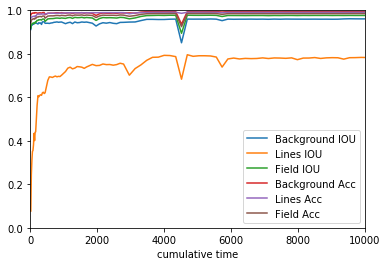

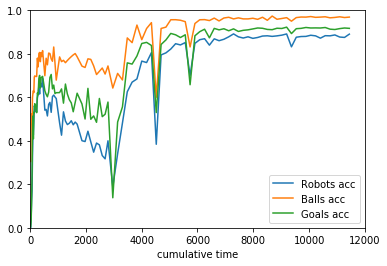

In [17]:
df1 = pd.read_csv('/home/user/jacobs/cudavision/Logs/test_logs_2_668.csv',skiprows=[1,2,3,4,5])
show_df_seg(df1)
show_df_det(df1)

In [7]:
time2 = experiment2()

{'input_dimension': (96, 128), 'epoch': 10, 'phase': 'freeze', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l2*nll(F.log_softmax(output[1]), seg.long()) \


Train Epoch concurrent: 1 [0/6194(0%)]	Loss: 2.097485, time: 1.0127923488616943
Train Epoch concurrent: 1 [100/6194(2%)]	Loss: 0.440346, time: 0.25019025802612305
Train Epoch concurrent: 1 [200/6194(3%)]	Loss: 0.239021, time: 0.2335052490234375
Train Epoch concurrent: 1 [300/6194(5%)]	Loss: 0.171213, time: 0.22617268562316895
Train Epoch concurrent: 1 [400/6194(6%)]	Loss: 0.138491, time: 0.22811532020568848
Train Epoch concurrent: 1 [500/6194(8%)]	Loss: 0.118542, time: 0.22724342346191406
Train Epoch concurrent: 1 [600/6194(10%)]	Loss: 0.105222, time: 0.22835779190063477
Train Epoch concurrent: 1 [700/6194(11%)]	Loss: 0.100681, time: 0.22677993774414062
Train Epoch concurrent: 1 [800/6194(13%)]	Loss: 0.090233, time: 0.22810721397399902
Train Epoch concurrent: 1 [900/6194(15%)]	Loss: 0.082414, time: 0.22748351097106934
Train Epoch concurrent: 1 [1000/6194(16%)]	Loss: 0.092059, time: 0.22773289680480957
Train Epoch concurrent: 1 [1100/6194(18%)]	Loss: 0.072499, time: 0.22829580307006836


/home/user/jacobs/cudavision/metric_detection.py:72: RuntimeWarning: invalid value encountered in double_scalars
  recall = correct/(correct+FN)
/home/user/jacobs/cudavision/metric_segmentation.py:51: RuntimeWarning: invalid value encountered in true_divide
  IOU_imagewise[:,i] = true_positives_imagewise[cat]/(true_positives_imagewise[cat] + false_positives_imagewise[cat] + false_negatives_imagewise[cat])



Test set: seg Average loss: 0.0255

Background: IOU: 0.8749, accuracy: 0.9566
Lines: IOU: 0.0047, accuracy: 0.9610
Field: IOU: 0.8915, accuracy: 0.9232
Total: IOU: 0.5904, accuracy: 0.9470
making log csv
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_669.csv
Train Epoch concurrent: 2 [0/6194(0%)]	Loss: 0.030686, time: 0.022054195404052734
Train Epoch concurrent: 2 [100/6194(2%)]	Loss: 0.029756, time: 0.22998428344726562
Train Epoch concurrent: 2 [200/6194(3%)]	Loss: 0.032384, time: 0.22814035415649414
Train Epoch concurrent: 2 [300/6194(5%)]	Loss: 0.034579, time: 0.22712969779968262
Train Epoch concurrent: 2 [400/6194(6%)]	Loss: 0.036302, time: 0.2288532257080078
Train Epoch concurrent: 2 [500/6194(8%)]	Loss: 0.037099, time: 0.22726058959960938
Train Epoch concurrent: 2 [600/6194(10%)]	Loss: 0.033097, time: 0.22849440574645996
Train Epoch concurrent: 2 [700/6194(11%)]	Loss: 0.031449, time: 0.2271897792816162
Train Epoch concurrent: 2 [800/6194(13%)]	Loss: 0.030737, tim

Train Epoch concurrent: 3 [2600/6194(42%)]	Loss: 0.024748, time: 0.22729039192199707
Train Epoch concurrent: 3 [2700/6194(44%)]	Loss: 0.020399, time: 0.22932076454162598
Train Epoch concurrent: 3 [2800/6194(45%)]	Loss: 0.023910, time: 0.22669434547424316
Train Epoch concurrent: 3 [2900/6194(47%)]	Loss: 0.023700, time: 0.22799396514892578
Train Epoch concurrent: 3 [3000/6194(48%)]	Loss: 0.025777, time: 0.22631168365478516
Train Epoch concurrent: 3 [3100/6194(50%)]	Loss: 0.022401, time: 0.226487398147583
Train Epoch concurrent: 3 [3200/6194(52%)]	Loss: 0.021284, time: 0.22820401191711426
Train Epoch concurrent: 3 [3300/6194(53%)]	Loss: 0.019998, time: 0.22682738304138184
Train Epoch concurrent: 3 [3400/6194(55%)]	Loss: 0.023319, time: 0.2292032241821289
Train Epoch concurrent: 3 [3500/6194(56%)]	Loss: 0.023497, time: 0.22694087028503418
Train Epoch concurrent: 3 [3600/6194(58%)]	Loss: 0.021736, time: 0.22931766510009766
Train Epoch concurrent: 3 [3700/6194(60%)]	Loss: 0.022021, time: 0.2

Train Epoch concurrent: 4 [5500/6194(89%)]	Loss: 0.017902, time: 0.22991299629211426
Train Epoch concurrent: 4 [5600/6194(90%)]	Loss: 0.018634, time: 0.226593017578125
Train Epoch concurrent: 4 [5700/6194(92%)]	Loss: 0.019466, time: 0.22842860221862793
Train Epoch concurrent: 4 [5800/6194(94%)]	Loss: 0.018571, time: 0.22681164741516113
Train Epoch concurrent: 4 [5900/6194(95%)]	Loss: 0.017116, time: 0.22813987731933594
Train Epoch concurrent: 4 [6000/6194(97%)]	Loss: 0.018190, time: 0.2274949550628662
Train Epoch concurrent: 4 [6100/6194(98%)]	Loss: 0.015600, time: 0.22669243812561035

Test set: det Average loss: 0.0075

Balls: F1: 0.5066, accuracy: 0.3392, recall: 0.9241, precision: 0.3490, FDR: 0.6510,
Goalposts: F1: 0.1121, accuracy: 0.0594, recall: 0.7540, precision: 0.0605, FDR: 0.9395,
Robots: F1: 0.0964, accuracy: 0.0507, recall: 0.4850, precision: 0.0535, FDR: 0.9465,

Test set: seg Average loss: 0.0172

Background: IOU: 0.9106, accuracy: 0.9754
Lines: IOU: 0.3278, accuracy: 0.

Train Epoch concurrent: 6 [1500/6194(24%)]	Loss: 0.012051, time: 0.22989773750305176
Train Epoch concurrent: 6 [1600/6194(26%)]	Loss: 0.011837, time: 0.22702598571777344
Train Epoch concurrent: 6 [1700/6194(27%)]	Loss: 0.011892, time: 0.22913861274719238
Train Epoch concurrent: 6 [1800/6194(29%)]	Loss: 0.010626, time: 0.2270975112915039
Train Epoch concurrent: 6 [1900/6194(31%)]	Loss: 0.010759, time: 0.23004722595214844
Train Epoch concurrent: 6 [2000/6194(32%)]	Loss: 0.012758, time: 0.22885394096374512
Train Epoch concurrent: 6 [2100/6194(34%)]	Loss: 0.010042, time: 0.2294445037841797
Train Epoch concurrent: 6 [2200/6194(35%)]	Loss: 0.010961, time: 0.22708916664123535
Train Epoch concurrent: 6 [2300/6194(37%)]	Loss: 0.011966, time: 0.22693109512329102
Train Epoch concurrent: 6 [2400/6194(39%)]	Loss: 0.010100, time: 0.2290506362915039
Train Epoch concurrent: 6 [2500/6194(40%)]	Loss: 0.014534, time: 0.22695207595825195
Train Epoch concurrent: 6 [2600/6194(42%)]	Loss: 0.013152, time: 0.2

Train Epoch concurrent: 7 [4400/6194(71%)]	Loss: 0.010629, time: 0.2273256778717041
Train Epoch concurrent: 7 [4500/6194(73%)]	Loss: 0.010525, time: 0.2293078899383545
Train Epoch concurrent: 7 [4600/6194(74%)]	Loss: 0.009471, time: 0.2289433479309082
Train Epoch concurrent: 7 [4700/6194(76%)]	Loss: 0.010556, time: 0.2288835048675537
Train Epoch concurrent: 7 [4800/6194(77%)]	Loss: 0.012115, time: 0.2266387939453125
Train Epoch concurrent: 7 [4900/6194(79%)]	Loss: 0.008467, time: 0.2290349006652832
Train Epoch concurrent: 7 [5000/6194(81%)]	Loss: 0.007695, time: 0.22692441940307617
Train Epoch concurrent: 7 [5100/6194(82%)]	Loss: 0.010354, time: 0.2292623519897461
Train Epoch concurrent: 7 [5200/6194(84%)]	Loss: 0.011008, time: 0.22691941261291504
Train Epoch concurrent: 7 [5300/6194(85%)]	Loss: 0.010266, time: 0.22884488105773926
Train Epoch concurrent: 7 [5400/6194(87%)]	Loss: 0.010265, time: 0.22685837745666504
Train Epoch concurrent: 7 [5500/6194(89%)]	Loss: 0.009987, time: 0.22766

Train Epoch concurrent: 9 [400/6194(6%)]	Loss: 0.010330, time: 0.22815966606140137
Train Epoch concurrent: 9 [500/6194(8%)]	Loss: 0.007281, time: 0.22813034057617188
Train Epoch concurrent: 9 [600/6194(10%)]	Loss: 0.007761, time: 0.22690558433532715
Train Epoch concurrent: 9 [700/6194(11%)]	Loss: 0.007453, time: 0.22910094261169434
Train Epoch concurrent: 9 [800/6194(13%)]	Loss: 0.007890, time: 0.2271277904510498
Train Epoch concurrent: 9 [900/6194(15%)]	Loss: 0.009971, time: 0.22904133796691895
Train Epoch concurrent: 9 [1000/6194(16%)]	Loss: 0.007742, time: 0.22686219215393066
Train Epoch concurrent: 9 [1100/6194(18%)]	Loss: 0.008004, time: 0.22916269302368164
Train Epoch concurrent: 9 [1200/6194(19%)]	Loss: 0.008117, time: 0.22674107551574707
Train Epoch concurrent: 9 [1300/6194(21%)]	Loss: 0.010292, time: 0.2287302017211914
Train Epoch concurrent: 9 [1400/6194(23%)]	Loss: 0.007505, time: 0.22699475288391113
Train Epoch concurrent: 9 [1500/6194(24%)]	Loss: 0.009275, time: 0.22864747

Train Epoch concurrent: 10 [3200/6194(52%)]	Loss: 0.007594, time: 0.23473262786865234
Train Epoch concurrent: 10 [3300/6194(53%)]	Loss: 0.009124, time: 0.2341165542602539
Train Epoch concurrent: 10 [3400/6194(55%)]	Loss: 0.006986, time: 0.23409748077392578
Train Epoch concurrent: 10 [3500/6194(56%)]	Loss: 0.007461, time: 0.23087191581726074
Train Epoch concurrent: 10 [3600/6194(58%)]	Loss: 0.009011, time: 0.23079657554626465
Train Epoch concurrent: 10 [3700/6194(60%)]	Loss: 0.008257, time: 0.22942781448364258
Train Epoch concurrent: 10 [3800/6194(61%)]	Loss: 0.006890, time: 0.22902464866638184
Train Epoch concurrent: 10 [3900/6194(63%)]	Loss: 0.008367, time: 0.2309408187866211
Train Epoch concurrent: 10 [4000/6194(65%)]	Loss: 0.010739, time: 0.22894954681396484
Train Epoch concurrent: 10 [4100/6194(66%)]	Loss: 0.007762, time: 0.2308037281036377
Train Epoch concurrent: 10 [4200/6194(68%)]	Loss: 0.007310, time: 0.2290043830871582
Train Epoch concurrent: 10 [4300/6194(69%)]	Loss: 0.007580

/home/user/jacobs/cudavision/criterion.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l2*nll(F.log_softmax(output[1]), seg.long()) \


Train Epoch concurrent: 11 [0/6194(0%)]	Loss: 0.057705, time: 0.03129076957702637
Train Epoch concurrent: 11 [100/6194(2%)]	Loss: 0.035237, time: 0.3954653739929199
Train Epoch concurrent: 11 [200/6194(3%)]	Loss: 0.031592, time: 0.39565086364746094
Train Epoch concurrent: 11 [300/6194(5%)]	Loss: 0.026144, time: 0.39760923385620117
Train Epoch concurrent: 11 [400/6194(6%)]	Loss: 0.028350, time: 0.39757776260375977
Train Epoch concurrent: 11 [500/6194(8%)]	Loss: 0.027455, time: 0.39807939529418945
Train Epoch concurrent: 11 [600/6194(10%)]	Loss: 0.026901, time: 0.3980100154876709
Train Epoch concurrent: 11 [700/6194(11%)]	Loss: 0.023456, time: 0.3955352306365967
Train Epoch concurrent: 11 [800/6194(13%)]	Loss: 0.026145, time: 0.39813828468322754
Train Epoch concurrent: 11 [900/6194(15%)]	Loss: 0.027723, time: 0.3973109722137451
Train Epoch concurrent: 11 [1000/6194(16%)]	Loss: 0.029116, time: 0.39769554138183594
Train Epoch concurrent: 11 [1100/6194(18%)]	Loss: 0.020500, time: 0.39701437

Train Epoch concurrent: 12 [2800/6194(45%)]	Loss: 0.017521, time: 0.39777684211730957
Train Epoch concurrent: 12 [2900/6194(47%)]	Loss: 0.023590, time: 0.3942139148712158
Train Epoch concurrent: 12 [3000/6194(48%)]	Loss: 0.016889, time: 0.3978903293609619
Train Epoch concurrent: 12 [3100/6194(50%)]	Loss: 0.014519, time: 0.39806318283081055
Train Epoch concurrent: 12 [3200/6194(52%)]	Loss: 0.016177, time: 0.3980262279510498
Train Epoch concurrent: 12 [3300/6194(53%)]	Loss: 0.014387, time: 0.3980898857116699
Train Epoch concurrent: 12 [3400/6194(55%)]	Loss: 0.014318, time: 0.3959810733795166
Train Epoch concurrent: 12 [3500/6194(56%)]	Loss: 0.016392, time: 0.39833807945251465
Train Epoch concurrent: 12 [3600/6194(58%)]	Loss: 0.015788, time: 0.39914870262145996
Train Epoch concurrent: 12 [3700/6194(60%)]	Loss: 0.017083, time: 0.3985421657562256
Train Epoch concurrent: 12 [3800/6194(61%)]	Loss: 0.014953, time: 0.3973214626312256
Train Epoch concurrent: 12 [3900/6194(63%)]	Loss: 0.013541, t

Train Epoch concurrent: 13 [5600/6194(90%)]	Loss: 0.014063, time: 0.3990945816040039
Train Epoch concurrent: 13 [5700/6194(92%)]	Loss: 0.014646, time: 0.397258996963501
Train Epoch concurrent: 13 [5800/6194(94%)]	Loss: 0.013259, time: 0.39699721336364746
Train Epoch concurrent: 13 [5900/6194(95%)]	Loss: 0.011455, time: 0.3998525142669678
Train Epoch concurrent: 13 [6000/6194(97%)]	Loss: 0.009187, time: 0.39992761611938477
Train Epoch concurrent: 13 [6100/6194(98%)]	Loss: 0.016645, time: 0.3988802433013916

Test set: det Average loss: 0.0072

Balls: F1: 0.8177, accuracy: 0.6916, recall: 0.9230, precision: 0.7340, FDR: 0.2660,
Goalposts: F1: 0.5666, accuracy: 0.3953, recall: 0.7736, precision: 0.4470, FDR: 0.5530,
Robots: F1: 0.5335, accuracy: 0.3638, recall: 0.8245, precision: 0.3943, FDR: 0.6057,

Test set: seg Average loss: 0.0136

Background: IOU: 0.9191, accuracy: 0.9801
Lines: IOU: 0.5218, accuracy: 0.9788
Field: IOU: 0.9400, accuracy: 0.9602
Total: IOU: 0.7936, accuracy: 0.9730
wr

Train Epoch concurrent: 15 [1600/6194(26%)]	Loss: 0.008323, time: 0.39648008346557617
Train Epoch concurrent: 15 [1700/6194(27%)]	Loss: 0.007883, time: 0.39786362648010254
Train Epoch concurrent: 15 [1800/6194(29%)]	Loss: 0.010159, time: 0.39839768409729004
Train Epoch concurrent: 15 [1900/6194(31%)]	Loss: 0.008318, time: 0.39786577224731445
Train Epoch concurrent: 15 [2000/6194(32%)]	Loss: 0.010276, time: 0.39803147315979004
Train Epoch concurrent: 15 [2100/6194(34%)]	Loss: 0.011885, time: 0.3949697017669678
Train Epoch concurrent: 15 [2200/6194(35%)]	Loss: 0.014048, time: 0.3961348533630371
Train Epoch concurrent: 15 [2300/6194(37%)]	Loss: 0.011147, time: 0.3957691192626953
Train Epoch concurrent: 15 [2400/6194(39%)]	Loss: 0.008886, time: 0.39684486389160156
Train Epoch concurrent: 15 [2500/6194(40%)]	Loss: 0.009434, time: 0.3970973491668701
Train Epoch concurrent: 15 [2600/6194(42%)]	Loss: 0.011534, time: 0.39507222175598145
Train Epoch concurrent: 15 [2700/6194(44%)]	Loss: 0.008501

Train Epoch concurrent: 16 [4400/6194(71%)]	Loss: 0.007263, time: 0.39669346809387207
Train Epoch concurrent: 16 [4500/6194(73%)]	Loss: 0.010726, time: 0.39646387100219727
Train Epoch concurrent: 16 [4600/6194(74%)]	Loss: 0.007941, time: 0.3970043659210205
Train Epoch concurrent: 16 [4700/6194(76%)]	Loss: 0.009761, time: 0.3977541923522949
Train Epoch concurrent: 16 [4800/6194(77%)]	Loss: 0.006731, time: 0.39748144149780273
Train Epoch concurrent: 16 [4900/6194(79%)]	Loss: 0.008165, time: 0.3956303596496582
Train Epoch concurrent: 16 [5000/6194(81%)]	Loss: 0.007543, time: 0.39774584770202637
Train Epoch concurrent: 16 [5100/6194(82%)]	Loss: 0.008586, time: 0.39792919158935547
Train Epoch concurrent: 16 [5200/6194(84%)]	Loss: 0.009961, time: 0.3987555503845215
Train Epoch concurrent: 16 [5300/6194(85%)]	Loss: 0.005889, time: 0.39805150032043457
Train Epoch concurrent: 16 [5400/6194(87%)]	Loss: 0.007689, time: 0.39563870429992676
Train Epoch concurrent: 16 [5500/6194(89%)]	Loss: 0.008817

Train Epoch concurrent: 18 [400/6194(6%)]	Loss: 0.007367, time: 0.3979337215423584
Train Epoch concurrent: 18 [500/6194(8%)]	Loss: 0.006221, time: 0.39698362350463867
Train Epoch concurrent: 18 [600/6194(10%)]	Loss: 0.006459, time: 0.39594507217407227
Train Epoch concurrent: 18 [700/6194(11%)]	Loss: 0.008864, time: 0.39737868309020996
Train Epoch concurrent: 18 [800/6194(13%)]	Loss: 0.006163, time: 0.39742016792297363
Train Epoch concurrent: 18 [900/6194(15%)]	Loss: 0.007991, time: 0.39772486686706543
Train Epoch concurrent: 18 [1000/6194(16%)]	Loss: 0.007079, time: 0.3966178894042969
Train Epoch concurrent: 18 [1100/6194(18%)]	Loss: 0.006606, time: 0.3952782154083252
Train Epoch concurrent: 18 [1200/6194(19%)]	Loss: 0.007968, time: 0.3969841003417969
Train Epoch concurrent: 18 [1300/6194(21%)]	Loss: 0.006808, time: 0.398165225982666
Train Epoch concurrent: 18 [1400/6194(23%)]	Loss: 0.007747, time: 0.3974001407623291
Train Epoch concurrent: 18 [1500/6194(24%)]	Loss: 0.007312, time: 0.3

Train Epoch concurrent: 19 [3200/6194(52%)]	Loss: 0.007446, time: 0.39502882957458496
Train Epoch concurrent: 19 [3300/6194(53%)]	Loss: 0.006387, time: 0.39592981338500977
Train Epoch concurrent: 19 [3400/6194(55%)]	Loss: 0.009013, time: 0.39682698249816895
Train Epoch concurrent: 19 [3500/6194(56%)]	Loss: 0.006772, time: 0.4040815830230713
Train Epoch concurrent: 19 [3600/6194(58%)]	Loss: 0.008208, time: 0.40410447120666504
Train Epoch concurrent: 19 [3700/6194(60%)]	Loss: 0.006952, time: 0.4026675224304199
Train Epoch concurrent: 19 [3800/6194(61%)]	Loss: 0.006841, time: 0.39463281631469727
Train Epoch concurrent: 19 [3900/6194(63%)]	Loss: 0.007568, time: 0.3981201648712158
Train Epoch concurrent: 19 [4000/6194(65%)]	Loss: 0.007377, time: 0.39815354347229004
Train Epoch concurrent: 19 [4100/6194(66%)]	Loss: 0.007121, time: 0.39827942848205566
Train Epoch concurrent: 19 [4200/6194(68%)]	Loss: 0.005755, time: 0.39804530143737793
Train Epoch concurrent: 19 [4300/6194(69%)]	Loss: 0.00856

Train Epoch concurrent: 20 [6000/6194(97%)]	Loss: 0.006450, time: 0.3951399326324463
Train Epoch concurrent: 20 [6100/6194(98%)]	Loss: 0.008396, time: 0.3987419605255127

Test set: det Average loss: 0.0065

Balls: F1: 0.8541, accuracy: 0.7454, recall: 0.9481, precision: 0.7771, FDR: 0.2229,
Goalposts: F1: 0.6545, accuracy: 0.4864, recall: 0.7476, precision: 0.5820, FDR: 0.4180,
Robots: F1: 0.7070, accuracy: 0.5468, recall: 0.8140, precision: 0.6248, FDR: 0.3752,

Test set: seg Average loss: 0.0173

Background: IOU: 0.9176, accuracy: 0.9794
Lines: IOU: 0.5483, accuracy: 0.9782
Field: IOU: 0.9390, accuracy: 0.9597
Total: IOU: 0.8016, accuracy: 0.9724
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_669.csv
{'input_dimension': (288, 384), 'epoch': 10, 'phase': 'freeze', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l2*nll(F.log_softmax(output[1]), seg.long()) \


Train Epoch concurrent: 21 [0/6194(0%)]	Loss: 0.052780, time: 0.047667741775512695
Train Epoch concurrent: 21 [100/6194(2%)]	Loss: 0.030601, time: 0.6862716674804688
Train Epoch concurrent: 21 [200/6194(3%)]	Loss: 0.025738, time: 0.6871702671051025
Train Epoch concurrent: 21 [300/6194(5%)]	Loss: 0.023134, time: 0.6863768100738525
Train Epoch concurrent: 21 [400/6194(6%)]	Loss: 0.026359, time: 0.68668532371521
Train Epoch concurrent: 21 [500/6194(8%)]	Loss: 0.022447, time: 0.6849222183227539
Train Epoch concurrent: 21 [600/6194(10%)]	Loss: 0.022715, time: 0.685173749923706
Train Epoch concurrent: 21 [700/6194(11%)]	Loss: 0.024038, time: 0.6842601299285889
Train Epoch concurrent: 21 [800/6194(13%)]	Loss: 0.020230, time: 0.6845927238464355
Train Epoch concurrent: 21 [900/6194(15%)]	Loss: 0.019304, time: 0.6880602836608887
Train Epoch concurrent: 21 [1000/6194(16%)]	Loss: 0.020900, time: 0.685300350189209
Train Epoch concurrent: 21 [1100/6194(18%)]	Loss: 0.016152, time: 0.6862092018127441


Train Epoch concurrent: 22 [2900/6194(47%)]	Loss: 0.013611, time: 0.6915192604064941
Train Epoch concurrent: 22 [3000/6194(48%)]	Loss: 0.014197, time: 0.6929633617401123
Train Epoch concurrent: 22 [3100/6194(50%)]	Loss: 0.013439, time: 0.688025951385498
Train Epoch concurrent: 22 [3200/6194(52%)]	Loss: 0.015163, time: 0.6894171237945557
Train Epoch concurrent: 22 [3300/6194(53%)]	Loss: 0.012940, time: 0.6857812404632568
Train Epoch concurrent: 22 [3400/6194(55%)]	Loss: 0.012231, time: 0.6853947639465332
Train Epoch concurrent: 22 [3500/6194(56%)]	Loss: 0.016420, time: 0.6868174076080322
Train Epoch concurrent: 22 [3600/6194(58%)]	Loss: 0.018457, time: 0.6852986812591553
Train Epoch concurrent: 22 [3700/6194(60%)]	Loss: 0.015043, time: 0.6926391124725342
Train Epoch concurrent: 22 [3800/6194(61%)]	Loss: 0.014204, time: 0.687608003616333
Train Epoch concurrent: 22 [3900/6194(63%)]	Loss: 0.012310, time: 0.6890661716461182
Train Epoch concurrent: 22 [4000/6194(65%)]	Loss: 0.019478, time: 0

Train Epoch concurrent: 23 [5800/6194(94%)]	Loss: 0.011747, time: 0.6882567405700684
Train Epoch concurrent: 23 [5900/6194(95%)]	Loss: 0.012306, time: 0.6859467029571533
Train Epoch concurrent: 23 [6000/6194(97%)]	Loss: 0.011657, time: 0.6849105358123779
Train Epoch concurrent: 23 [6100/6194(98%)]	Loss: 0.010770, time: 0.6874456405639648

Test set: det Average loss: 0.0071

Balls: F1: 0.7754, accuracy: 0.6332, recall: 0.9348, precision: 0.6624, FDR: 0.3376,
Goalposts: F1: 0.6195, accuracy: 0.4487, recall: 0.7194, precision: 0.5439, FDR: 0.4561,
Robots: F1: 0.6218, accuracy: 0.4511, recall: 0.7209, precision: 0.5466, FDR: 0.4534,

Test set: seg Average loss: 0.0113

Background: IOU: 0.9207, accuracy: 0.9812
Lines: IOU: 0.6294, accuracy: 0.9836
Field: IOU: 0.9476, accuracy: 0.9658
Total: IOU: 0.8326, accuracy: 0.9769
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_669.csv
Train Epoch concurrent: 24 [0/6194(0%)]	Loss: 0.010464, time: 0.04775071144104004
Train Epoch concurre

Train Epoch concurrent: 25 [1800/6194(29%)]	Loss: 0.010336, time: 0.6883068084716797
Train Epoch concurrent: 25 [1900/6194(31%)]	Loss: 0.010194, time: 0.6924304962158203
Train Epoch concurrent: 25 [2000/6194(32%)]	Loss: 0.010800, time: 0.6900806427001953
Train Epoch concurrent: 25 [2100/6194(34%)]	Loss: 0.009492, time: 0.6857621669769287
Train Epoch concurrent: 25 [2200/6194(35%)]	Loss: 0.008115, time: 0.6847505569458008
Train Epoch concurrent: 25 [2300/6194(37%)]	Loss: 0.011238, time: 0.6863021850585938
Train Epoch concurrent: 25 [2400/6194(39%)]	Loss: 0.009954, time: 0.68414306640625
Train Epoch concurrent: 25 [2500/6194(40%)]	Loss: 0.009065, time: 0.6867942810058594
Train Epoch concurrent: 25 [2600/6194(42%)]	Loss: 0.009755, time: 0.6869175434112549
Train Epoch concurrent: 25 [2700/6194(44%)]	Loss: 0.011541, time: 0.6859936714172363
Train Epoch concurrent: 25 [2800/6194(45%)]	Loss: 0.008906, time: 0.6880621910095215
Train Epoch concurrent: 25 [2900/6194(47%)]	Loss: 0.008160, time: 0

Train Epoch concurrent: 26 [4700/6194(76%)]	Loss: 0.008664, time: 0.6868879795074463
Train Epoch concurrent: 26 [4800/6194(77%)]	Loss: 0.008383, time: 0.6861882209777832
Train Epoch concurrent: 26 [4900/6194(79%)]	Loss: 0.008892, time: 0.6890528202056885
Train Epoch concurrent: 26 [5000/6194(81%)]	Loss: 0.007660, time: 0.6850812435150146
Train Epoch concurrent: 26 [5100/6194(82%)]	Loss: 0.008066, time: 0.6872966289520264
Train Epoch concurrent: 26 [5200/6194(84%)]	Loss: 0.008333, time: 0.6852047443389893
Train Epoch concurrent: 26 [5300/6194(85%)]	Loss: 0.007409, time: 0.6862406730651855
Train Epoch concurrent: 26 [5400/6194(87%)]	Loss: 0.009970, time: 0.6875114440917969
Train Epoch concurrent: 26 [5500/6194(89%)]	Loss: 0.007712, time: 0.6864118576049805
Train Epoch concurrent: 26 [5600/6194(90%)]	Loss: 0.010426, time: 0.6887845993041992
Train Epoch concurrent: 26 [5700/6194(92%)]	Loss: 0.009167, time: 0.6862428188323975
Train Epoch concurrent: 26 [5800/6194(94%)]	Loss: 0.010356, time:

Train Epoch concurrent: 28 [700/6194(11%)]	Loss: 0.006216, time: 0.6861944198608398
Train Epoch concurrent: 28 [800/6194(13%)]	Loss: 0.008946, time: 0.6959977149963379
Train Epoch concurrent: 28 [900/6194(15%)]	Loss: 0.006219, time: 0.6877169609069824
Train Epoch concurrent: 28 [1000/6194(16%)]	Loss: 0.006840, time: 0.6869559288024902
Train Epoch concurrent: 28 [1100/6194(18%)]	Loss: 0.005869, time: 0.6843564510345459
Train Epoch concurrent: 28 [1200/6194(19%)]	Loss: 0.006988, time: 0.6855361461639404
Train Epoch concurrent: 28 [1300/6194(21%)]	Loss: 0.009159, time: 0.6887657642364502
Train Epoch concurrent: 28 [1400/6194(23%)]	Loss: 0.007998, time: 0.6862063407897949
Train Epoch concurrent: 28 [1500/6194(24%)]	Loss: 0.007070, time: 0.6885476112365723
Train Epoch concurrent: 28 [1600/6194(26%)]	Loss: 0.008026, time: 0.6865575313568115
Train Epoch concurrent: 28 [1700/6194(27%)]	Loss: 0.007183, time: 0.6883089542388916
Train Epoch concurrent: 28 [1800/6194(29%)]	Loss: 0.007679, time: 0.

Train Epoch concurrent: 29 [3600/6194(58%)]	Loss: 0.007911, time: 0.7057676315307617
Train Epoch concurrent: 29 [3700/6194(60%)]	Loss: 0.006912, time: 0.6880021095275879
Train Epoch concurrent: 29 [3800/6194(61%)]	Loss: 0.007577, time: 0.6838324069976807
Train Epoch concurrent: 29 [3900/6194(63%)]	Loss: 0.012167, time: 0.6879367828369141
Train Epoch concurrent: 29 [4000/6194(65%)]	Loss: 0.010182, time: 0.6887421607971191
Train Epoch concurrent: 29 [4100/6194(66%)]	Loss: 0.006644, time: 0.6864638328552246
Train Epoch concurrent: 29 [4200/6194(68%)]	Loss: 0.007876, time: 0.6854052543640137
Train Epoch concurrent: 29 [4300/6194(69%)]	Loss: 0.007342, time: 0.6849985122680664
Train Epoch concurrent: 29 [4400/6194(71%)]	Loss: 0.007041, time: 0.6857547760009766
Train Epoch concurrent: 29 [4500/6194(73%)]	Loss: 0.009805, time: 0.6834385395050049
Train Epoch concurrent: 29 [4600/6194(74%)]	Loss: 0.007322, time: 0.6859626770019531
Train Epoch concurrent: 29 [4700/6194(76%)]	Loss: 0.006837, time:


Test set: seg Average loss: 0.0136

Background: IOU: 0.9215, accuracy: 0.9811
Lines: IOU: 0.6284, accuracy: 0.9832
Field: IOU: 0.9473, accuracy: 0.9655
Total: IOU: 0.8324, accuracy: 0.9766
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_669.csv
{'input_dimension': (384, 512), 'epoch': 10, 'phase': 'freeze', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l2*nll(F.log_softmax(output[1]), seg.long()) \


Train Epoch concurrent: 31 [0/6194(0%)]	Loss: 0.029098, time: 0.2039661407470703
Train Epoch concurrent: 31 [100/6194(2%)]	Loss: 0.029086, time: 2.4754669666290283
Train Epoch concurrent: 31 [200/6194(3%)]	Loss: 0.019557, time: 2.425645112991333
Train Epoch concurrent: 31 [300/6194(5%)]	Loss: 0.024520, time: 2.341609001159668
Train Epoch concurrent: 31 [400/6194(6%)]	Loss: 0.019317, time: 2.2790868282318115
Train Epoch concurrent: 31 [500/6194(8%)]	Loss: 0.021161, time: 2.1919479370117188
Train Epoch concurrent: 31 [600/6194(10%)]	Loss: 0.020422, time: 2.17783784866333
Train Epoch concurrent: 31 [700/6194(11%)]	Loss: 0.027623, time: 2.071744918823242
Train Epoch concurrent: 31 [800/6194(13%)]	Loss: 0.021604, time: 2.063934326171875
Train Epoch concurrent: 31 [900/6194(15%)]	Loss: 0.017656, time: 2.053826332092285
Train Epoch concurrent: 31 [1000/6194(16%)]	Loss: 0.016179, time: 2.006477117538452
Train Epoch concurrent: 31 [1100/6194(18%)]	Loss: 0.024108, time: 1.9869346618652344
Train 

Train Epoch concurrent: 32 [2900/6194(47%)]	Loss: 0.014253, time: 1.0599431991577148
Train Epoch concurrent: 32 [3000/6194(48%)]	Loss: 0.014822, time: 1.0571928024291992
Train Epoch concurrent: 32 [3100/6194(50%)]	Loss: 0.013385, time: 1.0601534843444824
Train Epoch concurrent: 32 [3200/6194(52%)]	Loss: 0.011665, time: 1.0598797798156738
Train Epoch concurrent: 32 [3300/6194(53%)]	Loss: 0.013847, time: 1.0584521293640137
Train Epoch concurrent: 32 [3400/6194(55%)]	Loss: 0.013369, time: 1.058420181274414
Train Epoch concurrent: 32 [3500/6194(56%)]	Loss: 0.015121, time: 1.0591516494750977
Train Epoch concurrent: 32 [3600/6194(58%)]	Loss: 0.017889, time: 1.0610907077789307
Train Epoch concurrent: 32 [3700/6194(60%)]	Loss: 0.013053, time: 1.0592103004455566
Train Epoch concurrent: 32 [3800/6194(61%)]	Loss: 0.011478, time: 1.06138277053833
Train Epoch concurrent: 32 [3900/6194(63%)]	Loss: 0.016459, time: 1.0591306686401367
Train Epoch concurrent: 32 [4000/6194(65%)]	Loss: 0.017232, time: 1.

Train Epoch concurrent: 33 [5800/6194(94%)]	Loss: 0.016135, time: 1.0597243309020996
Train Epoch concurrent: 33 [5900/6194(95%)]	Loss: 0.011746, time: 1.058694839477539
Train Epoch concurrent: 33 [6000/6194(97%)]	Loss: 0.013251, time: 1.058487892150879
Train Epoch concurrent: 33 [6100/6194(98%)]	Loss: 0.007771, time: 1.0585732460021973

Test set: det Average loss: 0.0070

Balls: F1: 0.7186, accuracy: 0.5608, recall: 0.9063, precision: 0.5953, FDR: 0.4047,
Goalposts: F1: 0.5792, accuracy: 0.4076, recall: 0.7159, precision: 0.4863, FDR: 0.5137,
Robots: F1: 0.5806, accuracy: 0.4090, recall: 0.7204, precision: 0.4862, FDR: 0.5138,

Test set: seg Average loss: 0.0103

Background: IOU: 0.9198, accuracy: 0.9809
Lines: IOU: 0.6889, accuracy: 0.9864
Field: IOU: 0.9512, accuracy: 0.9681
Total: IOU: 0.8533, accuracy: 0.9785
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_669.csv
Train Epoch concurrent: 34 [0/6194(0%)]	Loss: 0.011851, time: 0.07190465927124023
Train Epoch concurrent

Train Epoch concurrent: 35 [1800/6194(29%)]	Loss: 0.010696, time: 1.120964527130127
Train Epoch concurrent: 35 [1900/6194(31%)]	Loss: 0.009383, time: 1.0991473197937012
Train Epoch concurrent: 35 [2000/6194(32%)]	Loss: 0.014533, time: 1.0649800300598145
Train Epoch concurrent: 35 [2100/6194(34%)]	Loss: 0.009009, time: 1.0638227462768555
Train Epoch concurrent: 35 [2200/6194(35%)]	Loss: 0.010460, time: 1.0621213912963867
Train Epoch concurrent: 35 [2300/6194(37%)]	Loss: 0.009974, time: 1.0616912841796875
Train Epoch concurrent: 35 [2400/6194(39%)]	Loss: 0.009031, time: 1.06364107131958
Train Epoch concurrent: 35 [2500/6194(40%)]	Loss: 0.011000, time: 1.0619816780090332
Train Epoch concurrent: 35 [2600/6194(42%)]	Loss: 0.012030, time: 1.0636827945709229
Train Epoch concurrent: 35 [2700/6194(44%)]	Loss: 0.010874, time: 1.061676025390625
Train Epoch concurrent: 35 [2800/6194(45%)]	Loss: 0.009982, time: 1.067734718322754
Train Epoch concurrent: 35 [2900/6194(47%)]	Loss: 0.012497, time: 1.06

Train Epoch concurrent: 36 [4700/6194(76%)]	Loss: 0.010235, time: 1.0633628368377686
Train Epoch concurrent: 36 [4800/6194(77%)]	Loss: 0.009436, time: 1.0625975131988525
Train Epoch concurrent: 36 [4900/6194(79%)]	Loss: 0.007671, time: 1.0638928413391113
Train Epoch concurrent: 36 [5000/6194(81%)]	Loss: 0.008905, time: 1.0632636547088623
Train Epoch concurrent: 36 [5100/6194(82%)]	Loss: 0.011764, time: 1.062563419342041
Train Epoch concurrent: 36 [5200/6194(84%)]	Loss: 0.015387, time: 1.0639405250549316
Train Epoch concurrent: 36 [5300/6194(85%)]	Loss: 0.006989, time: 1.0628206729888916
Train Epoch concurrent: 36 [5400/6194(87%)]	Loss: 0.007922, time: 1.0652527809143066
Train Epoch concurrent: 36 [5500/6194(89%)]	Loss: 0.008692, time: 1.060922384262085
Train Epoch concurrent: 36 [5600/6194(90%)]	Loss: 0.006964, time: 1.0627248287200928
Train Epoch concurrent: 36 [5700/6194(92%)]	Loss: 0.007735, time: 1.0616161823272705
Train Epoch concurrent: 36 [5800/6194(94%)]	Loss: 0.010074, time: 1

Train Epoch concurrent: 38 [700/6194(11%)]	Loss: 0.009161, time: 1.062577486038208
Train Epoch concurrent: 38 [800/6194(13%)]	Loss: 0.006454, time: 1.0645935535430908
Train Epoch concurrent: 38 [900/6194(15%)]	Loss: 0.007947, time: 1.0617291927337646
Train Epoch concurrent: 38 [1000/6194(16%)]	Loss: 0.006661, time: 1.0628628730773926
Train Epoch concurrent: 38 [1100/6194(18%)]	Loss: 0.009355, time: 1.062706708908081
Train Epoch concurrent: 38 [1200/6194(19%)]	Loss: 0.007268, time: 1.0625412464141846
Train Epoch concurrent: 38 [1300/6194(21%)]	Loss: 0.006497, time: 1.0863831043243408
Train Epoch concurrent: 38 [1400/6194(23%)]	Loss: 0.009852, time: 1.10152268409729
Train Epoch concurrent: 38 [1500/6194(24%)]	Loss: 0.010270, time: 1.0643408298492432
Train Epoch concurrent: 38 [1600/6194(26%)]	Loss: 0.008036, time: 1.0618207454681396
Train Epoch concurrent: 38 [1700/6194(27%)]	Loss: 0.008104, time: 1.062077283859253
Train Epoch concurrent: 38 [1800/6194(29%)]	Loss: 0.006295, time: 1.06344

Train Epoch concurrent: 39 [3600/6194(58%)]	Loss: 0.008100, time: 1.0618133544921875
Train Epoch concurrent: 39 [3700/6194(60%)]	Loss: 0.007311, time: 1.0645112991333008
Train Epoch concurrent: 39 [3800/6194(61%)]	Loss: 0.007809, time: 1.0666861534118652
Train Epoch concurrent: 39 [3900/6194(63%)]	Loss: 0.011990, time: 1.0621931552886963
Train Epoch concurrent: 39 [4000/6194(65%)]	Loss: 0.007878, time: 1.0625836849212646
Train Epoch concurrent: 39 [4100/6194(66%)]	Loss: 0.007244, time: 1.0645170211791992
Train Epoch concurrent: 39 [4200/6194(68%)]	Loss: 0.008079, time: 1.0623486042022705
Train Epoch concurrent: 39 [4300/6194(69%)]	Loss: 0.006381, time: 1.0643408298492432
Train Epoch concurrent: 39 [4400/6194(71%)]	Loss: 0.007724, time: 1.06309175491333
Train Epoch concurrent: 39 [4500/6194(73%)]	Loss: 0.010538, time: 1.0614235401153564
Train Epoch concurrent: 39 [4600/6194(74%)]	Loss: 0.009893, time: 1.0643224716186523
Train Epoch concurrent: 39 [4700/6194(76%)]	Loss: 0.010516, time: 1


Test set: seg Average loss: 0.0111

Background: IOU: 0.9246, accuracy: 0.9825
Lines: IOU: 0.6774, accuracy: 0.9858
Field: IOU: 0.9528, accuracy: 0.9692
Total: IOU: 0.8516, accuracy: 0.9792
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_669.csv
{'input_dimension': (480, 640), 'epoch': 10, 'phase': 'freeze', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l2*nll(F.log_softmax(output[1]), seg.long()) \


Train Epoch concurrent: 41 [0/6194(0%)]	Loss: 0.022483, time: 0.30678248405456543
Train Epoch concurrent: 41 [100/6194(2%)]	Loss: 0.034458, time: 3.501847982406616
Train Epoch concurrent: 41 [200/6194(3%)]	Loss: 0.020833, time: 3.3983383178710938
Train Epoch concurrent: 41 [300/6194(5%)]	Loss: 0.016100, time: 3.389927864074707
Train Epoch concurrent: 41 [400/6194(6%)]	Loss: 0.020382, time: 3.2185347080230713
Train Epoch concurrent: 41 [500/6194(8%)]	Loss: 0.026822, time: 3.241129159927368
Train Epoch concurrent: 41 [600/6194(10%)]	Loss: 0.018903, time: 3.0515575408935547
Train Epoch concurrent: 41 [700/6194(11%)]	Loss: 0.019162, time: 2.945051431655884
Train Epoch concurrent: 41 [800/6194(13%)]	Loss: 0.019843, time: 2.9974448680877686
Train Epoch concurrent: 41 [900/6194(15%)]	Loss: 0.017173, time: 3.027470588684082
Train Epoch concurrent: 41 [1000/6194(16%)]	Loss: 0.017618, time: 2.9231109619140625
Train Epoch concurrent: 41 [1100/6194(18%)]	Loss: 0.018588, time: 2.8817296028137207
Tr

Train Epoch concurrent: 42 [2900/6194(47%)]	Loss: 0.015352, time: 1.9595253467559814
Train Epoch concurrent: 42 [3000/6194(48%)]	Loss: 0.013976, time: 1.882063865661621
Train Epoch concurrent: 42 [3100/6194(50%)]	Loss: 0.014297, time: 1.8485021591186523
Train Epoch concurrent: 42 [3200/6194(52%)]	Loss: 0.013489, time: 1.9002230167388916
Train Epoch concurrent: 42 [3300/6194(53%)]	Loss: 0.014462, time: 1.9834249019622803
Train Epoch concurrent: 42 [3400/6194(55%)]	Loss: 0.011461, time: 1.9143438339233398
Train Epoch concurrent: 42 [3500/6194(56%)]	Loss: 0.013478, time: 1.8297407627105713
Train Epoch concurrent: 42 [3600/6194(58%)]	Loss: 0.013061, time: 1.9954359531402588
Train Epoch concurrent: 42 [3700/6194(60%)]	Loss: 0.013372, time: 1.7949120998382568
Train Epoch concurrent: 42 [3800/6194(61%)]	Loss: 0.015848, time: 1.8583073616027832
Train Epoch concurrent: 42 [3900/6194(63%)]	Loss: 0.010744, time: 1.9163148403167725
Train Epoch concurrent: 42 [4000/6194(65%)]	Loss: 0.009562, time: 

Train Epoch concurrent: 43 [5800/6194(94%)]	Loss: 0.009426, time: 1.5775575637817383
Train Epoch concurrent: 43 [5900/6194(95%)]	Loss: 0.009330, time: 1.5750281810760498
Train Epoch concurrent: 43 [6000/6194(97%)]	Loss: 0.011639, time: 1.5766234397888184
Train Epoch concurrent: 43 [6100/6194(98%)]	Loss: 0.012846, time: 1.5791969299316406

Test set: det Average loss: 0.0075

Balls: F1: 0.7163, accuracy: 0.5580, recall: 0.9307, precision: 0.5822, FDR: 0.4178,
Goalposts: F1: 0.4145, accuracy: 0.2614, recall: 0.6904, precision: 0.2961, FDR: 0.7039,
Robots: F1: 0.5018, accuracy: 0.3349, recall: 0.6959, precision: 0.3924, FDR: 0.6076,

Test set: seg Average loss: 0.0097

Background: IOU: 0.9202, accuracy: 0.9812
Lines: IOU: 0.6976, accuracy: 0.9868
Field: IOU: 0.9525, accuracy: 0.9690
Total: IOU: 0.8568, accuracy: 0.9790
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_669.csv
Train Epoch concurrent: 44 [0/6194(0%)]	Loss: 0.013169, time: 0.10713505744934082
Train Epoch concurre

Train Epoch concurrent: 45 [1800/6194(29%)]	Loss: 0.011368, time: 1.5779688358306885
Train Epoch concurrent: 45 [1900/6194(31%)]	Loss: 0.009235, time: 1.57529616355896
Train Epoch concurrent: 45 [2000/6194(32%)]	Loss: 0.013218, time: 1.5745038986206055
Train Epoch concurrent: 45 [2100/6194(34%)]	Loss: 0.010237, time: 1.5754976272583008
Train Epoch concurrent: 45 [2200/6194(35%)]	Loss: 0.009955, time: 1.575880765914917
Train Epoch concurrent: 45 [2300/6194(37%)]	Loss: 0.012802, time: 1.5748341083526611
Train Epoch concurrent: 45 [2400/6194(39%)]	Loss: 0.009541, time: 1.5771949291229248
Train Epoch concurrent: 45 [2500/6194(40%)]	Loss: 0.008206, time: 1.5743660926818848
Train Epoch concurrent: 45 [2600/6194(42%)]	Loss: 0.009445, time: 1.575702428817749
Train Epoch concurrent: 45 [2700/6194(44%)]	Loss: 0.009129, time: 1.5775423049926758
Train Epoch concurrent: 45 [2800/6194(45%)]	Loss: 0.011567, time: 1.5765750408172607
Train Epoch concurrent: 45 [2900/6194(47%)]	Loss: 0.009986, time: 1.5

Train Epoch concurrent: 46 [4700/6194(76%)]	Loss: 0.009037, time: 1.575606107711792
Train Epoch concurrent: 46 [4800/6194(77%)]	Loss: 0.013066, time: 1.5762248039245605
Train Epoch concurrent: 46 [4900/6194(79%)]	Loss: 0.010514, time: 1.5791094303131104
Train Epoch concurrent: 46 [5000/6194(81%)]	Loss: 0.010574, time: 1.5767381191253662
Train Epoch concurrent: 46 [5100/6194(82%)]	Loss: 0.007089, time: 1.578615665435791
Train Epoch concurrent: 46 [5200/6194(84%)]	Loss: 0.007369, time: 1.580838918685913
Train Epoch concurrent: 46 [5300/6194(85%)]	Loss: 0.010862, time: 1.5763075351715088
Train Epoch concurrent: 46 [5400/6194(87%)]	Loss: 0.010068, time: 1.5745289325714111
Train Epoch concurrent: 46 [5500/6194(89%)]	Loss: 0.013111, time: 1.5763134956359863
Train Epoch concurrent: 46 [5600/6194(90%)]	Loss: 0.008345, time: 1.5795750617980957
Train Epoch concurrent: 46 [5700/6194(92%)]	Loss: 0.015309, time: 1.5766551494598389
Train Epoch concurrent: 46 [5800/6194(94%)]	Loss: 0.010845, time: 1.

Train Epoch concurrent: 48 [700/6194(11%)]	Loss: 0.009349, time: 1.5740299224853516
Train Epoch concurrent: 48 [800/6194(13%)]	Loss: 0.008227, time: 1.571953296661377
Train Epoch concurrent: 48 [900/6194(15%)]	Loss: 0.010367, time: 1.5734241008758545
Train Epoch concurrent: 48 [1000/6194(16%)]	Loss: 0.010210, time: 1.5736970901489258
Train Epoch concurrent: 48 [1100/6194(18%)]	Loss: 0.007564, time: 1.573974609375
Train Epoch concurrent: 48 [1200/6194(19%)]	Loss: 0.007873, time: 1.5749857425689697
Train Epoch concurrent: 48 [1300/6194(21%)]	Loss: 0.005965, time: 1.5719497203826904
Train Epoch concurrent: 48 [1400/6194(23%)]	Loss: 0.008921, time: 1.5720479488372803
Train Epoch concurrent: 48 [1500/6194(24%)]	Loss: 0.010476, time: 1.5823097229003906
Train Epoch concurrent: 48 [1600/6194(26%)]	Loss: 0.012763, time: 1.5744132995605469
Train Epoch concurrent: 48 [1700/6194(27%)]	Loss: 0.012151, time: 1.5749115943908691
Train Epoch concurrent: 48 [1800/6194(29%)]	Loss: 0.008112, time: 1.57195

Train Epoch concurrent: 49 [3600/6194(58%)]	Loss: 0.007614, time: 1.5725347995758057
Train Epoch concurrent: 49 [3700/6194(60%)]	Loss: 0.007470, time: 1.574204444885254
Train Epoch concurrent: 49 [3800/6194(61%)]	Loss: 0.006904, time: 1.5769586563110352
Train Epoch concurrent: 49 [3900/6194(63%)]	Loss: 0.010014, time: 1.5736603736877441
Train Epoch concurrent: 49 [4000/6194(65%)]	Loss: 0.007453, time: 1.5751373767852783
Train Epoch concurrent: 49 [4100/6194(66%)]	Loss: 0.009248, time: 1.5732543468475342
Train Epoch concurrent: 49 [4200/6194(68%)]	Loss: 0.010263, time: 1.5783541202545166
Train Epoch concurrent: 49 [4300/6194(69%)]	Loss: 0.006221, time: 1.5865602493286133
Train Epoch concurrent: 49 [4400/6194(71%)]	Loss: 0.008204, time: 1.597440242767334
Train Epoch concurrent: 49 [4500/6194(73%)]	Loss: 0.008881, time: 1.5819706916809082
Train Epoch concurrent: 49 [4600/6194(74%)]	Loss: 0.010287, time: 1.5896196365356445
Train Epoch concurrent: 49 [4700/6194(76%)]	Loss: 0.009023, time: 1


Test set: seg Average loss: 0.0116

Background: IOU: 0.9152, accuracy: 0.9792
Lines: IOU: 0.7044, accuracy: 0.9871
Field: IOU: 0.9500, accuracy: 0.9672
Total: IOU: 0.8565, accuracy: 0.9778
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_669.csv
{'input_dimension': (480, 640), 'epoch': 55, 'phase': 'thaw', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l2*nll(F.log_softmax(output[1]), seg.long()) \


Train Epoch concurrent: 51 [0/6194(0%)]	Loss: 0.007530, time: 0.21892070770263672
Train Epoch concurrent: 51 [100/6194(2%)]	Loss: 0.070719, time: 2.7235300540924072
Train Epoch concurrent: 51 [200/6194(3%)]	Loss: 0.034016, time: 2.7195401191711426
Train Epoch concurrent: 51 [300/6194(5%)]	Loss: 0.035055, time: 2.7210516929626465
Train Epoch concurrent: 51 [400/6194(6%)]	Loss: 0.027154, time: 2.7233450412750244
Train Epoch concurrent: 51 [500/6194(8%)]	Loss: 0.023075, time: 2.7196500301361084
Train Epoch concurrent: 51 [600/6194(10%)]	Loss: 0.028782, time: 2.72299861907959
Train Epoch concurrent: 51 [700/6194(11%)]	Loss: 0.020292, time: 2.7198784351348877
Train Epoch concurrent: 51 [800/6194(13%)]	Loss: 0.031120, time: 2.7240521907806396
Train Epoch concurrent: 51 [900/6194(15%)]	Loss: 0.018773, time: 2.7262930870056152
Train Epoch concurrent: 51 [1000/6194(16%)]	Loss: 0.020646, time: 2.720571279525757
Train Epoch concurrent: 51 [1100/6194(18%)]	Loss: 0.025964, time: 2.722862720489502
T

Train Epoch concurrent: 52 [2900/6194(47%)]	Loss: 0.013805, time: 2.7241404056549072
Train Epoch concurrent: 52 [3000/6194(48%)]	Loss: 0.012464, time: 2.7261579036712646
Train Epoch concurrent: 52 [3100/6194(50%)]	Loss: 0.016058, time: 2.7240803241729736
Train Epoch concurrent: 52 [3200/6194(52%)]	Loss: 0.012213, time: 2.7287955284118652
Train Epoch concurrent: 52 [3300/6194(53%)]	Loss: 0.010349, time: 2.7267143726348877
Train Epoch concurrent: 52 [3400/6194(55%)]	Loss: 0.011380, time: 2.725954055786133
Train Epoch concurrent: 52 [3500/6194(56%)]	Loss: 0.010913, time: 2.728973627090454
Train Epoch concurrent: 52 [3600/6194(58%)]	Loss: 0.008882, time: 2.7302231788635254
Train Epoch concurrent: 52 [3700/6194(60%)]	Loss: 0.009354, time: 2.731515884399414
Train Epoch concurrent: 52 [3800/6194(61%)]	Loss: 0.012383, time: 2.7275562286376953
Train Epoch concurrent: 52 [3900/6194(63%)]	Loss: 0.008313, time: 2.726060152053833
Train Epoch concurrent: 52 [4000/6194(65%)]	Loss: 0.011045, time: 2.7

/home/user/jacobs/cudavision/metric_segmentation.py:51: RuntimeWarning: invalid value encountered in true_divide
  IOU_imagewise[:,i] = true_positives_imagewise[cat]/(true_positives_imagewise[cat] + false_positives_imagewise[cat] + false_negatives_imagewise[cat])



Test set: seg Average loss: 0.0046

Background: IOU: 0.9564, accuracy: 0.9935
Lines: IOU: 0.7676, accuracy: 0.9901
Field: IOU: 0.9748, accuracy: 0.9836
Total: IOU: 0.8996, accuracy: 0.9891
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_669.csv
Train Epoch concurrent: 53 [0/6194(0%)]	Loss: 0.009257, time: 0.21639442443847656
Train Epoch concurrent: 53 [100/6194(2%)]	Loss: 0.008942, time: 2.7314183712005615
Train Epoch concurrent: 53 [200/6194(3%)]	Loss: 0.008064, time: 2.724353790283203
Train Epoch concurrent: 53 [300/6194(5%)]	Loss: 0.007147, time: 2.726050615310669
Train Epoch concurrent: 53 [400/6194(6%)]	Loss: 0.008266, time: 2.723318576812744
Train Epoch concurrent: 53 [500/6194(8%)]	Loss: 0.007933, time: 2.721527338027954
Train Epoch concurrent: 53 [600/6194(10%)]	Loss: 0.011089, time: 2.730170965194702
Train Epoch concurrent: 53 [700/6194(11%)]	Loss: 0.008836, time: 2.7262933254241943
Train Epoch concurrent: 53 [800/6194(13%)]	Loss: 0.009037, time: 2.725771427154

Train Epoch concurrent: 54 [2600/6194(42%)]	Loss: 0.006702, time: 2.729855537414551
Train Epoch concurrent: 54 [2700/6194(44%)]	Loss: 0.007108, time: 2.725579023361206
Train Epoch concurrent: 54 [2800/6194(45%)]	Loss: 0.006225, time: 2.7309720516204834
Train Epoch concurrent: 54 [2900/6194(47%)]	Loss: 0.008812, time: 2.728931427001953
Train Epoch concurrent: 54 [3000/6194(48%)]	Loss: 0.008592, time: 2.726771354675293
Train Epoch concurrent: 54 [3100/6194(50%)]	Loss: 0.007442, time: 2.7327396869659424
Train Epoch concurrent: 54 [3200/6194(52%)]	Loss: 0.006499, time: 2.7277843952178955
Train Epoch concurrent: 54 [3300/6194(53%)]	Loss: 0.008387, time: 2.7301926612854004
Train Epoch concurrent: 54 [3400/6194(55%)]	Loss: 0.005987, time: 2.726407051086426
Train Epoch concurrent: 54 [3500/6194(56%)]	Loss: 0.007574, time: 2.7299928665161133
Train Epoch concurrent: 54 [3600/6194(58%)]	Loss: 0.006190, time: 2.7276248931884766
Train Epoch concurrent: 54 [3700/6194(60%)]	Loss: 0.007214, time: 2.72

Train Epoch concurrent: 55 [5500/6194(89%)]	Loss: 0.004867, time: 2.73237943649292
Train Epoch concurrent: 55 [5600/6194(90%)]	Loss: 0.005713, time: 2.7275524139404297
Train Epoch concurrent: 55 [5700/6194(92%)]	Loss: 0.005660, time: 2.733759880065918
Train Epoch concurrent: 55 [5800/6194(94%)]	Loss: 0.006345, time: 2.730581045150757
Train Epoch concurrent: 55 [5900/6194(95%)]	Loss: 0.006027, time: 2.7291617393493652
Train Epoch concurrent: 55 [6000/6194(97%)]	Loss: 0.005139, time: 2.727444887161255
Train Epoch concurrent: 55 [6100/6194(98%)]	Loss: 0.004380, time: 2.72988224029541

Test set: det Average loss: 0.0030

Balls: F1: 0.9365, accuracy: 0.8805, recall: 0.9809, precision: 0.8958, FDR: 0.1042,
Goalposts: F1: 0.8834, accuracy: 0.7911, recall: 0.9132, precision: 0.8554, FDR: 0.1446,
Robots: F1: 0.8432, accuracy: 0.7288, recall: 0.8791, precision: 0.8100, FDR: 0.1900,

Test set: seg Average loss: 0.0042

Background: IOU: 0.9596, accuracy: 0.9943
Lines: IOU: 0.7897, accuracy: 0.9912

Train Epoch concurrent: 57 [1600/6194(26%)]	Loss: 0.003975, time: 2.7250008583068848
Train Epoch concurrent: 57 [1700/6194(27%)]	Loss: 0.004068, time: 2.7313711643218994
Train Epoch concurrent: 57 [1800/6194(29%)]	Loss: 0.004697, time: 2.7274816036224365
Train Epoch concurrent: 57 [1900/6194(31%)]	Loss: 0.003923, time: 2.7285852432250977
Train Epoch concurrent: 57 [2000/6194(32%)]	Loss: 0.005498, time: 2.729881525039673
Train Epoch concurrent: 57 [2100/6194(34%)]	Loss: 0.005207, time: 2.728142023086548
Train Epoch concurrent: 57 [2200/6194(35%)]	Loss: 0.006746, time: 2.7285397052764893
Train Epoch concurrent: 57 [2300/6194(37%)]	Loss: 0.004860, time: 2.727484703063965
Train Epoch concurrent: 57 [2400/6194(39%)]	Loss: 0.004304, time: 2.7275307178497314
Train Epoch concurrent: 57 [2500/6194(40%)]	Loss: 0.005931, time: 2.727731943130493
Train Epoch concurrent: 57 [2600/6194(42%)]	Loss: 0.006405, time: 2.727444887161255
Train Epoch concurrent: 57 [2700/6194(44%)]	Loss: 0.005669, time: 2.72

Train Epoch concurrent: 58 [4500/6194(73%)]	Loss: 0.005320, time: 2.7339251041412354
Train Epoch concurrent: 58 [4600/6194(74%)]	Loss: 0.005197, time: 2.7295804023742676
Train Epoch concurrent: 58 [4700/6194(76%)]	Loss: 0.004252, time: 2.7331745624542236
Train Epoch concurrent: 58 [4800/6194(77%)]	Loss: 0.004020, time: 2.7290866374969482
Train Epoch concurrent: 58 [4900/6194(79%)]	Loss: 0.004098, time: 2.7278501987457275
Train Epoch concurrent: 58 [5000/6194(81%)]	Loss: 0.004470, time: 2.734079599380493
Train Epoch concurrent: 58 [5100/6194(82%)]	Loss: 0.004995, time: 2.730605363845825
Train Epoch concurrent: 58 [5200/6194(84%)]	Loss: 0.003966, time: 2.7313623428344727
Train Epoch concurrent: 58 [5300/6194(85%)]	Loss: 0.003674, time: 2.730929374694824
Train Epoch concurrent: 58 [5400/6194(87%)]	Loss: 0.004039, time: 2.7329483032226562
Train Epoch concurrent: 58 [5500/6194(89%)]	Loss: 0.005881, time: 2.7299046516418457
Train Epoch concurrent: 58 [5600/6194(90%)]	Loss: 0.004347, time: 2.

Train Epoch concurrent: 60 [600/6194(10%)]	Loss: 0.002941, time: 2.725839376449585
Train Epoch concurrent: 60 [700/6194(11%)]	Loss: 0.003080, time: 2.725407361984253
Train Epoch concurrent: 60 [800/6194(13%)]	Loss: 0.003274, time: 2.7260029315948486
Train Epoch concurrent: 60 [900/6194(15%)]	Loss: 0.003726, time: 2.728825807571411
Train Epoch concurrent: 60 [1000/6194(16%)]	Loss: 0.002768, time: 2.7272894382476807
Train Epoch concurrent: 60 [1100/6194(18%)]	Loss: 0.004363, time: 2.724367618560791
Train Epoch concurrent: 60 [1200/6194(19%)]	Loss: 0.003603, time: 2.7265591621398926
Train Epoch concurrent: 60 [1300/6194(21%)]	Loss: 0.003950, time: 2.725883722305298
Train Epoch concurrent: 60 [1400/6194(23%)]	Loss: 0.003204, time: 2.728935480117798
Train Epoch concurrent: 60 [1500/6194(24%)]	Loss: 0.004449, time: 2.729952573776245
Train Epoch concurrent: 60 [1600/6194(26%)]	Loss: 0.003612, time: 2.729921579360962
Train Epoch concurrent: 60 [1700/6194(27%)]	Loss: 0.004165, time: 2.725652456

Train Epoch concurrent: 61 [3500/6194(56%)]	Loss: 0.003020, time: 2.7316718101501465
Train Epoch concurrent: 61 [3600/6194(58%)]	Loss: 0.003642, time: 2.7285568714141846
Train Epoch concurrent: 61 [3700/6194(60%)]	Loss: 0.002417, time: 2.73062801361084
Train Epoch concurrent: 61 [3800/6194(61%)]	Loss: 0.002793, time: 2.732729434967041
Train Epoch concurrent: 61 [3900/6194(63%)]	Loss: 0.003308, time: 2.72882080078125
Train Epoch concurrent: 61 [4000/6194(65%)]	Loss: 0.003099, time: 2.7298643589019775
Train Epoch concurrent: 61 [4100/6194(66%)]	Loss: 0.002572, time: 2.7305662631988525
Train Epoch concurrent: 61 [4200/6194(68%)]	Loss: 0.003332, time: 2.733274459838867
Train Epoch concurrent: 61 [4300/6194(69%)]	Loss: 0.002615, time: 2.7285001277923584
Train Epoch concurrent: 61 [4400/6194(71%)]	Loss: 0.002425, time: 2.7356112003326416
Train Epoch concurrent: 61 [4500/6194(73%)]	Loss: 0.002574, time: 2.7331156730651855
Train Epoch concurrent: 61 [4600/6194(74%)]	Loss: 0.002951, time: 2.730


Test set: seg Average loss: 0.0062

Background: IOU: 0.9575, accuracy: 0.9936
Lines: IOU: 0.7775, accuracy: 0.9905
Field: IOU: 0.9752, accuracy: 0.9842
Total: IOU: 0.9034, accuracy: 0.9894
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_669.csv
Train Epoch concurrent: 63 [0/6194(0%)]	Loss: 0.002220, time: 0.21578145027160645
Train Epoch concurrent: 63 [100/6194(2%)]	Loss: 0.002351, time: 2.8019087314605713
Train Epoch concurrent: 63 [200/6194(3%)]	Loss: 0.002002, time: 2.7407174110412598
Train Epoch concurrent: 63 [300/6194(5%)]	Loss: 0.002291, time: 2.7462902069091797
Train Epoch concurrent: 63 [400/6194(6%)]	Loss: 0.001877, time: 2.7304229736328125
Train Epoch concurrent: 63 [500/6194(8%)]	Loss: 0.001907, time: 2.756409168243408
Train Epoch concurrent: 63 [600/6194(10%)]	Loss: 0.002000, time: 2.7256546020507812
Train Epoch concurrent: 63 [700/6194(11%)]	Loss: 0.002097, time: 2.710902690887451
Train Epoch concurrent: 63 [800/6194(13%)]	Loss: 0.002230, time: 2.771216869

Train Epoch concurrent: 64 [2600/6194(42%)]	Loss: 0.001737, time: 2.736861228942871
Train Epoch concurrent: 64 [2700/6194(44%)]	Loss: 0.001474, time: 2.738746166229248
Train Epoch concurrent: 64 [2800/6194(45%)]	Loss: 0.001539, time: 2.7379961013793945
Train Epoch concurrent: 64 [2900/6194(47%)]	Loss: 0.001524, time: 2.7361786365509033
Train Epoch concurrent: 64 [3000/6194(48%)]	Loss: 0.001478, time: 2.7378666400909424
Train Epoch concurrent: 64 [3100/6194(50%)]	Loss: 0.001222, time: 2.7333569526672363
Train Epoch concurrent: 64 [3200/6194(52%)]	Loss: 0.001620, time: 2.7377686500549316
Train Epoch concurrent: 64 [3300/6194(53%)]	Loss: 0.002163, time: 2.7358458042144775
Train Epoch concurrent: 64 [3400/6194(55%)]	Loss: 0.001477, time: 2.738417148590088
Train Epoch concurrent: 64 [3500/6194(56%)]	Loss: 0.001414, time: 2.738811731338501
Train Epoch concurrent: 64 [3600/6194(58%)]	Loss: 0.002356, time: 2.7797892093658447
Train Epoch concurrent: 64 [3700/6194(60%)]	Loss: 0.001833, time: 2.7

Train Epoch concurrent: 65 [5500/6194(89%)]	Loss: 0.002033, time: 2.7385435104370117
Train Epoch concurrent: 65 [5600/6194(90%)]	Loss: 0.001768, time: 2.74381685256958
Train Epoch concurrent: 65 [5700/6194(92%)]	Loss: 0.001388, time: 2.7396914958953857
Train Epoch concurrent: 65 [5800/6194(94%)]	Loss: 0.001097, time: 2.7395176887512207
Train Epoch concurrent: 65 [5900/6194(95%)]	Loss: 0.001703, time: 2.7376184463500977
Train Epoch concurrent: 65 [6000/6194(97%)]	Loss: 0.001058, time: 2.7368850708007812
Train Epoch concurrent: 65 [6100/6194(98%)]	Loss: 0.001299, time: 2.7359654903411865

Test set: det Average loss: 0.0022

Balls: F1: 0.9810, accuracy: 0.9626, recall: 0.9931, precision: 0.9691, FDR: 0.0309,
Goalposts: F1: 0.9060, accuracy: 0.8281, recall: 0.9290, precision: 0.8840, FDR: 0.1160,
Robots: F1: 0.8782, accuracy: 0.7828, recall: 0.9298, precision: 0.8320, FDR: 0.1680,

Test set: seg Average loss: 0.0078

Background: IOU: 0.9587, accuracy: 0.9939
Lines: IOU: 0.7760, accuracy: 0

Train Epoch concurrent: 67 [1600/6194(26%)]	Loss: 0.001046, time: 2.74092173576355
Train Epoch concurrent: 67 [1700/6194(27%)]	Loss: 0.001255, time: 2.7389888763427734
Train Epoch concurrent: 67 [1800/6194(29%)]	Loss: 0.001102, time: 2.7396881580352783
Train Epoch concurrent: 67 [1900/6194(31%)]	Loss: 0.001206, time: 2.737034559249878
Train Epoch concurrent: 67 [2000/6194(32%)]	Loss: 0.001140, time: 2.7384493350982666
Train Epoch concurrent: 67 [2100/6194(34%)]	Loss: 0.001070, time: 2.7419686317443848
Train Epoch concurrent: 67 [2200/6194(35%)]	Loss: 0.001064, time: 2.735539436340332
Train Epoch concurrent: 67 [2300/6194(37%)]	Loss: 0.001151, time: 2.7384517192840576
Train Epoch concurrent: 67 [2400/6194(39%)]	Loss: 0.001796, time: 2.7387359142303467
Train Epoch concurrent: 67 [2500/6194(40%)]	Loss: 0.001190, time: 2.7859697341918945
Train Epoch concurrent: 67 [2600/6194(42%)]	Loss: 0.001071, time: 2.7423903942108154
Train Epoch concurrent: 67 [2700/6194(44%)]	Loss: 0.001416, time: 2.7

Train Epoch concurrent: 68 [4500/6194(73%)]	Loss: 0.000923, time: 2.7356455326080322
Train Epoch concurrent: 68 [4600/6194(74%)]	Loss: 0.001181, time: 2.7354044914245605
Train Epoch concurrent: 68 [4700/6194(76%)]	Loss: 0.000769, time: 2.7501533031463623
Train Epoch concurrent: 68 [4800/6194(77%)]	Loss: 0.001051, time: 2.8041911125183105
Train Epoch concurrent: 68 [4900/6194(79%)]	Loss: 0.000936, time: 2.7514994144439697
Train Epoch concurrent: 68 [5000/6194(81%)]	Loss: 0.001564, time: 2.7470831871032715
Train Epoch concurrent: 68 [5100/6194(82%)]	Loss: 0.000844, time: 2.756903648376465
Train Epoch concurrent: 68 [5200/6194(84%)]	Loss: 0.001001, time: 2.7473902702331543
Train Epoch concurrent: 68 [5300/6194(85%)]	Loss: 0.000723, time: 2.736234188079834
Train Epoch concurrent: 68 [5400/6194(87%)]	Loss: 0.000816, time: 2.7399468421936035
Train Epoch concurrent: 68 [5500/6194(89%)]	Loss: 0.000937, time: 2.7400693893432617
Train Epoch concurrent: 68 [5600/6194(90%)]	Loss: 0.000998, time: 2

Train Epoch concurrent: 70 [600/6194(10%)]	Loss: 0.001206, time: 2.737429618835449
Train Epoch concurrent: 70 [700/6194(11%)]	Loss: 0.000841, time: 2.7335927486419678
Train Epoch concurrent: 70 [800/6194(13%)]	Loss: 0.000661, time: 2.739295721054077
Train Epoch concurrent: 70 [900/6194(15%)]	Loss: 0.001212, time: 2.734544515609741
Train Epoch concurrent: 70 [1000/6194(16%)]	Loss: 0.001208, time: 2.7338271141052246
Train Epoch concurrent: 70 [1100/6194(18%)]	Loss: 0.000814, time: 2.7388272285461426
Train Epoch concurrent: 70 [1200/6194(19%)]	Loss: 0.000885, time: 2.7380614280700684
Train Epoch concurrent: 70 [1300/6194(21%)]	Loss: 0.000802, time: 2.7418665885925293
Train Epoch concurrent: 70 [1400/6194(23%)]	Loss: 0.001056, time: 2.7347240447998047
Train Epoch concurrent: 70 [1500/6194(24%)]	Loss: 0.001167, time: 2.7356879711151123
Train Epoch concurrent: 70 [1600/6194(26%)]	Loss: 0.000846, time: 2.737298011779785
Train Epoch concurrent: 70 [1700/6194(27%)]	Loss: 0.000837, time: 2.73545

Train Epoch concurrent: 71 [3500/6194(56%)]	Loss: 0.001024, time: 2.73854660987854
Train Epoch concurrent: 71 [3600/6194(58%)]	Loss: 0.000853, time: 2.7366812229156494
Train Epoch concurrent: 71 [3700/6194(60%)]	Loss: 0.000941, time: 2.736829996109009
Train Epoch concurrent: 71 [3800/6194(61%)]	Loss: 0.000787, time: 2.739569664001465
Train Epoch concurrent: 71 [3900/6194(63%)]	Loss: 0.000846, time: 2.7364449501037598
Train Epoch concurrent: 71 [4000/6194(65%)]	Loss: 0.001727, time: 2.7400877475738525
Train Epoch concurrent: 71 [4100/6194(66%)]	Loss: 0.000703, time: 2.740750312805176
Train Epoch concurrent: 71 [4200/6194(68%)]	Loss: 0.000795, time: 2.7368721961975098
Train Epoch concurrent: 71 [4300/6194(69%)]	Loss: 0.000937, time: 2.7406177520751953
Train Epoch concurrent: 71 [4400/6194(71%)]	Loss: 0.000657, time: 2.7353148460388184
Train Epoch concurrent: 71 [4500/6194(73%)]	Loss: 0.000806, time: 2.7397267818450928
Train Epoch concurrent: 71 [4600/6194(74%)]	Loss: 0.001095, time: 2.73


Test set: seg Average loss: 0.0081

Background: IOU: 0.9582, accuracy: 0.9938
Lines: IOU: 0.7764, accuracy: 0.9905
Field: IOU: 0.9757, accuracy: 0.9844
Total: IOU: 0.9035, accuracy: 0.9896
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_669.csv
Train Epoch concurrent: 73 [0/6194(0%)]	Loss: 0.000942, time: 0.2205648422241211
Train Epoch concurrent: 73 [100/6194(2%)]	Loss: 0.000924, time: 2.734593152999878
Train Epoch concurrent: 73 [200/6194(3%)]	Loss: 0.000842, time: 2.731780767440796
Train Epoch concurrent: 73 [300/6194(5%)]	Loss: 0.000878, time: 2.7354729175567627
Train Epoch concurrent: 73 [400/6194(6%)]	Loss: 0.001244, time: 2.73394775390625
Train Epoch concurrent: 73 [500/6194(8%)]	Loss: 0.000712, time: 2.7386956214904785
Train Epoch concurrent: 73 [600/6194(10%)]	Loss: 0.000951, time: 2.733062744140625
Train Epoch concurrent: 73 [700/6194(11%)]	Loss: 0.000843, time: 2.7349603176116943
Train Epoch concurrent: 73 [800/6194(13%)]	Loss: 0.000931, time: 2.7377264499664

Train Epoch concurrent: 74 [2600/6194(42%)]	Loss: 0.000596, time: 2.734720468521118
Train Epoch concurrent: 74 [2700/6194(44%)]	Loss: 0.000773, time: 2.7342031002044678
Train Epoch concurrent: 74 [2800/6194(45%)]	Loss: 0.000602, time: 2.7389004230499268
Train Epoch concurrent: 74 [2900/6194(47%)]	Loss: 0.000609, time: 2.7343924045562744
Train Epoch concurrent: 74 [3000/6194(48%)]	Loss: 0.000554, time: 2.7387614250183105
Train Epoch concurrent: 74 [3100/6194(50%)]	Loss: 0.000517, time: 2.7351489067077637
Train Epoch concurrent: 74 [3200/6194(52%)]	Loss: 0.000902, time: 2.7378058433532715
Train Epoch concurrent: 74 [3300/6194(53%)]	Loss: 0.001149, time: 2.7376272678375244
Train Epoch concurrent: 74 [3400/6194(55%)]	Loss: 0.000580, time: 2.736466407775879
Train Epoch concurrent: 74 [3500/6194(56%)]	Loss: 0.000766, time: 2.7372543811798096
Train Epoch concurrent: 74 [3600/6194(58%)]	Loss: 0.000564, time: 2.734973192214966
Train Epoch concurrent: 74 [3700/6194(60%)]	Loss: 0.000635, time: 2.

Train Epoch concurrent: 75 [5500/6194(89%)]	Loss: 0.000567, time: 2.737532138824463
Train Epoch concurrent: 75 [5600/6194(90%)]	Loss: 0.000919, time: 2.7376832962036133
Train Epoch concurrent: 75 [5700/6194(92%)]	Loss: 0.001050, time: 2.7343311309814453
Train Epoch concurrent: 75 [5800/6194(94%)]	Loss: 0.000534, time: 2.7377662658691406
Train Epoch concurrent: 75 [5900/6194(95%)]	Loss: 0.000639, time: 2.764354944229126
Train Epoch concurrent: 75 [6000/6194(97%)]	Loss: 0.000619, time: 2.7680437564849854
Train Epoch concurrent: 75 [6100/6194(98%)]	Loss: 0.000615, time: 2.7414326667785645

Test set: det Average loss: 0.0021

Balls: F1: 0.9814, accuracy: 0.9634, recall: 0.9915, precision: 0.9715, FDR: 0.0285,
Goalposts: F1: 0.9139, accuracy: 0.8415, recall: 0.9345, precision: 0.8942, FDR: 0.1058,
Robots: F1: 0.9095, accuracy: 0.8341, recall: 0.9275, precision: 0.8923, FDR: 0.1077,

Test set: seg Average loss: 0.0109

Background: IOU: 0.9586, accuracy: 0.9939
Lines: IOU: 0.7821, accuracy: 0

Train Epoch concurrent: 77 [1600/6194(26%)]	Loss: 0.000952, time: 2.7381927967071533
Train Epoch concurrent: 77 [1700/6194(27%)]	Loss: 0.000515, time: 2.7346744537353516
Train Epoch concurrent: 77 [1800/6194(29%)]	Loss: 0.000527, time: 2.73525071144104
Train Epoch concurrent: 77 [1900/6194(31%)]	Loss: 0.000962, time: 2.737546920776367
Train Epoch concurrent: 77 [2000/6194(32%)]	Loss: 0.000608, time: 2.737403154373169
Train Epoch concurrent: 77 [2100/6194(34%)]	Loss: 0.000592, time: 2.741316318511963
Train Epoch concurrent: 77 [2200/6194(35%)]	Loss: 0.000593, time: 2.7348744869232178
Train Epoch concurrent: 77 [2300/6194(37%)]	Loss: 0.000539, time: 2.7378487586975098
Train Epoch concurrent: 77 [2400/6194(39%)]	Loss: 0.000616, time: 2.7372887134552
Train Epoch concurrent: 77 [2500/6194(40%)]	Loss: 0.000574, time: 2.7355451583862305
Train Epoch concurrent: 77 [2600/6194(42%)]	Loss: 0.000686, time: 2.7417194843292236
Train Epoch concurrent: 77 [2700/6194(44%)]	Loss: 0.000611, time: 2.73512

Train Epoch concurrent: 78 [4500/6194(73%)]	Loss: 0.000573, time: 2.7347939014434814
Train Epoch concurrent: 78 [4600/6194(74%)]	Loss: 0.000554, time: 2.739574909210205
Train Epoch concurrent: 78 [4700/6194(76%)]	Loss: 0.000605, time: 2.7371904850006104
Train Epoch concurrent: 78 [4800/6194(77%)]	Loss: 0.000538, time: 2.7399868965148926
Train Epoch concurrent: 78 [4900/6194(79%)]	Loss: 0.000587, time: 2.734821081161499
Train Epoch concurrent: 78 [5000/6194(81%)]	Loss: 0.000670, time: 2.7372019290924072
Train Epoch concurrent: 78 [5100/6194(82%)]	Loss: 0.000665, time: 2.7671101093292236
Train Epoch concurrent: 78 [5200/6194(84%)]	Loss: 0.000602, time: 2.7352781295776367
Train Epoch concurrent: 78 [5300/6194(85%)]	Loss: 0.000669, time: 2.738570213317871
Train Epoch concurrent: 78 [5400/6194(87%)]	Loss: 0.000536, time: 2.7396974563598633
Train Epoch concurrent: 78 [5500/6194(89%)]	Loss: 0.000636, time: 2.736234188079834
Train Epoch concurrent: 78 [5600/6194(90%)]	Loss: 0.000681, time: 2.7

Train Epoch concurrent: 80 [600/6194(10%)]	Loss: 0.000607, time: 2.7344720363616943
Train Epoch concurrent: 80 [700/6194(11%)]	Loss: 0.000580, time: 2.7331056594848633
Train Epoch concurrent: 80 [800/6194(13%)]	Loss: 0.000587, time: 2.768528699874878
Train Epoch concurrent: 80 [900/6194(15%)]	Loss: 0.000574, time: 2.735769033432007
Train Epoch concurrent: 80 [1000/6194(16%)]	Loss: 0.000604, time: 2.734635829925537
Train Epoch concurrent: 80 [1100/6194(18%)]	Loss: 0.000565, time: 2.739321708679199
Train Epoch concurrent: 80 [1200/6194(19%)]	Loss: 0.000723, time: 2.731682777404785
Train Epoch concurrent: 80 [1300/6194(21%)]	Loss: 0.000498, time: 2.7361934185028076
Train Epoch concurrent: 80 [1400/6194(23%)]	Loss: 0.000543, time: 2.739670753479004
Train Epoch concurrent: 80 [1500/6194(24%)]	Loss: 0.000718, time: 2.7572720050811768
Train Epoch concurrent: 80 [1600/6194(26%)]	Loss: 0.000585, time: 2.7366111278533936
Train Epoch concurrent: 80 [1700/6194(27%)]	Loss: 0.000647, time: 2.7343845

Train Epoch concurrent: 81 [3500/6194(56%)]	Loss: 0.001652, time: 2.7370643615722656
Train Epoch concurrent: 81 [3600/6194(58%)]	Loss: 0.001565, time: 2.7369980812072754
Train Epoch concurrent: 81 [3700/6194(60%)]	Loss: 0.001931, time: 2.7370550632476807
Train Epoch concurrent: 81 [3800/6194(61%)]	Loss: 0.001829, time: 2.7338147163391113
Train Epoch concurrent: 81 [3900/6194(63%)]	Loss: 0.001155, time: 2.773348093032837
Train Epoch concurrent: 81 [4000/6194(65%)]	Loss: 0.001237, time: 2.742180109024048
Train Epoch concurrent: 81 [4100/6194(66%)]	Loss: 0.001067, time: 2.73968768119812
Train Epoch concurrent: 81 [4200/6194(68%)]	Loss: 0.001450, time: 2.7413666248321533
Train Epoch concurrent: 81 [4300/6194(69%)]	Loss: 0.001059, time: 2.736172914505005
Train Epoch concurrent: 81 [4400/6194(71%)]	Loss: 0.001117, time: 2.738630533218384
Train Epoch concurrent: 81 [4500/6194(73%)]	Loss: 0.000975, time: 2.740739583969116
Train Epoch concurrent: 81 [4600/6194(74%)]	Loss: 0.000923, time: 2.7375


Test set: seg Average loss: 0.0108

Background: IOU: 0.9589, accuracy: 0.9941
Lines: IOU: 0.7815, accuracy: 0.9907
Field: IOU: 0.9763, accuracy: 0.9849
Total: IOU: 0.9056, accuracy: 0.9899
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_669.csv
Train Epoch concurrent: 83 [0/6194(0%)]	Loss: 0.000635, time: 0.2178196907043457
Train Epoch concurrent: 83 [100/6194(2%)]	Loss: 0.000504, time: 2.7358832359313965
Train Epoch concurrent: 83 [200/6194(3%)]	Loss: 0.000706, time: 2.730714797973633
Train Epoch concurrent: 83 [300/6194(5%)]	Loss: 0.000496, time: 2.735260486602783
Train Epoch concurrent: 83 [400/6194(6%)]	Loss: 0.000424, time: 2.7323312759399414
Train Epoch concurrent: 83 [500/6194(8%)]	Loss: 0.000494, time: 2.73260498046875
Train Epoch concurrent: 83 [600/6194(10%)]	Loss: 0.000521, time: 2.7365922927856445
Train Epoch concurrent: 83 [700/6194(11%)]	Loss: 0.000467, time: 2.7334280014038086
Train Epoch concurrent: 83 [800/6194(13%)]	Loss: 0.000470, time: 2.737195730209

Train Epoch concurrent: 84 [2600/6194(42%)]	Loss: 0.000412, time: 2.7339730262756348
Train Epoch concurrent: 84 [2700/6194(44%)]	Loss: 0.000437, time: 2.7380738258361816
Train Epoch concurrent: 84 [2800/6194(45%)]	Loss: 0.000426, time: 2.7382678985595703
Train Epoch concurrent: 84 [2900/6194(47%)]	Loss: 0.000431, time: 2.7331488132476807
Train Epoch concurrent: 84 [3000/6194(48%)]	Loss: 0.000426, time: 2.736853837966919
Train Epoch concurrent: 84 [3100/6194(50%)]	Loss: 0.000440, time: 2.7335147857666016
Train Epoch concurrent: 84 [3200/6194(52%)]	Loss: 0.000436, time: 2.7364869117736816
Train Epoch concurrent: 84 [3300/6194(53%)]	Loss: 0.000491, time: 2.7351808547973633
Train Epoch concurrent: 84 [3400/6194(55%)]	Loss: 0.000722, time: 2.7353343963623047
Train Epoch concurrent: 84 [3500/6194(56%)]	Loss: 0.000440, time: 2.738506317138672
Train Epoch concurrent: 84 [3600/6194(58%)]	Loss: 0.000384, time: 2.7358522415161133
Train Epoch concurrent: 84 [3700/6194(60%)]	Loss: 0.000855, time: 2

Train Epoch concurrent: 85 [5500/6194(89%)]	Loss: 0.000547, time: 2.7355191707611084
Train Epoch concurrent: 85 [5600/6194(90%)]	Loss: 0.000485, time: 2.7447707653045654
Train Epoch concurrent: 85 [5700/6194(92%)]	Loss: 0.000498, time: 2.7338883876800537
Train Epoch concurrent: 85 [5800/6194(94%)]	Loss: 0.000464, time: 2.736206531524658
Train Epoch concurrent: 85 [5900/6194(95%)]	Loss: 0.000475, time: 2.7370758056640625
Train Epoch concurrent: 85 [6000/6194(97%)]	Loss: 0.000490, time: 2.735138416290283
Train Epoch concurrent: 85 [6100/6194(98%)]	Loss: 0.000527, time: 2.7385122776031494

Test set: det Average loss: 0.0021

Balls: F1: 0.9796, accuracy: 0.9601, recall: 0.9935, precision: 0.9661, FDR: 0.0339,
Goalposts: F1: 0.9171, accuracy: 0.8469, recall: 0.9345, precision: 0.9004, FDR: 0.0996,
Robots: F1: 0.9049, accuracy: 0.8263, recall: 0.9268, precision: 0.8840, FDR: 0.1160,

Test set: seg Average loss: 0.0109

Background: IOU: 0.9587, accuracy: 0.9940
Lines: IOU: 0.7807, accuracy: 0

Train Epoch concurrent: 87 [1600/6194(26%)]	Loss: 0.000442, time: 2.738621234893799
Train Epoch concurrent: 87 [1700/6194(27%)]	Loss: 0.000656, time: 2.7374444007873535
Train Epoch concurrent: 87 [1800/6194(29%)]	Loss: 0.000476, time: 2.7374391555786133
Train Epoch concurrent: 87 [1900/6194(31%)]	Loss: 0.000470, time: 2.7355995178222656
Train Epoch concurrent: 87 [2000/6194(32%)]	Loss: 0.000607, time: 2.740424871444702
Train Epoch concurrent: 87 [2100/6194(34%)]	Loss: 0.000453, time: 2.7398905754089355
Train Epoch concurrent: 87 [2200/6194(35%)]	Loss: 0.000663, time: 2.73586106300354
Train Epoch concurrent: 87 [2300/6194(37%)]	Loss: 0.000524, time: 2.738070487976074
Train Epoch concurrent: 87 [2400/6194(39%)]	Loss: 0.000503, time: 2.7386155128479004
Train Epoch concurrent: 87 [2500/6194(40%)]	Loss: 0.000531, time: 2.7410218715667725
Train Epoch concurrent: 87 [2600/6194(42%)]	Loss: 0.000492, time: 2.7453107833862305
Train Epoch concurrent: 87 [2700/6194(44%)]	Loss: 0.000455, time: 2.73

Train Epoch concurrent: 88 [4500/6194(73%)]	Loss: 0.000450, time: 2.7388055324554443
Train Epoch concurrent: 88 [4600/6194(74%)]	Loss: 0.000482, time: 2.738741397857666
Train Epoch concurrent: 88 [4700/6194(76%)]	Loss: 0.000548, time: 2.73811411857605
Train Epoch concurrent: 88 [4800/6194(77%)]	Loss: 0.000668, time: 2.7385013103485107
Train Epoch concurrent: 88 [4900/6194(79%)]	Loss: 0.000417, time: 2.7395927906036377
Train Epoch concurrent: 88 [5000/6194(81%)]	Loss: 0.000514, time: 2.7377800941467285
Train Epoch concurrent: 88 [5100/6194(82%)]	Loss: 0.000484, time: 2.7419588565826416
Train Epoch concurrent: 88 [5200/6194(84%)]	Loss: 0.000796, time: 2.7363808155059814
Train Epoch concurrent: 88 [5300/6194(85%)]	Loss: 0.000498, time: 2.7404041290283203
Train Epoch concurrent: 88 [5400/6194(87%)]	Loss: 0.000597, time: 2.7403671741485596
Train Epoch concurrent: 88 [5500/6194(89%)]	Loss: 0.000928, time: 2.737582206726074
Train Epoch concurrent: 88 [5600/6194(90%)]	Loss: 0.000416, time: 2.7

Train Epoch concurrent: 90 [600/6194(10%)]	Loss: 0.000684, time: 2.7342445850372314
Train Epoch concurrent: 90 [700/6194(11%)]	Loss: 0.000540, time: 2.736856698989868
Train Epoch concurrent: 90 [800/6194(13%)]	Loss: 0.000466, time: 2.734177827835083
Train Epoch concurrent: 90 [900/6194(15%)]	Loss: 0.000601, time: 2.7355544567108154
Train Epoch concurrent: 90 [1000/6194(16%)]	Loss: 0.000665, time: 2.731640100479126
Train Epoch concurrent: 90 [1100/6194(18%)]	Loss: 0.000601, time: 2.7405381202697754
Train Epoch concurrent: 90 [1200/6194(19%)]	Loss: 0.000601, time: 2.7375612258911133
Train Epoch concurrent: 90 [1300/6194(21%)]	Loss: 0.000743, time: 2.7398297786712646
Train Epoch concurrent: 90 [1400/6194(23%)]	Loss: 0.000459, time: 2.7392566204071045
Train Epoch concurrent: 90 [1500/6194(24%)]	Loss: 0.000521, time: 2.735908031463623
Train Epoch concurrent: 90 [1600/6194(26%)]	Loss: 0.000601, time: 2.7365825176239014
Train Epoch concurrent: 90 [1700/6194(27%)]	Loss: 0.000564, time: 2.73656

Train Epoch concurrent: 91 [3500/6194(56%)]	Loss: 0.000455, time: 2.7420661449432373
Train Epoch concurrent: 91 [3600/6194(58%)]	Loss: 0.000485, time: 2.737818479537964
Train Epoch concurrent: 91 [3700/6194(60%)]	Loss: 0.000682, time: 2.74137544631958
Train Epoch concurrent: 91 [3800/6194(61%)]	Loss: 0.000699, time: 2.7352538108825684
Train Epoch concurrent: 91 [3900/6194(63%)]	Loss: 0.000447, time: 2.737884521484375
Train Epoch concurrent: 91 [4000/6194(65%)]	Loss: 0.000413, time: 2.7471864223480225
Train Epoch concurrent: 91 [4100/6194(66%)]	Loss: 0.000443, time: 2.7415778636932373
Train Epoch concurrent: 91 [4200/6194(68%)]	Loss: 0.000463, time: 2.743227005004883
Train Epoch concurrent: 91 [4300/6194(69%)]	Loss: 0.000488, time: 2.73903226852417
Train Epoch concurrent: 91 [4400/6194(71%)]	Loss: 0.000523, time: 2.7391865253448486
Train Epoch concurrent: 91 [4500/6194(73%)]	Loss: 0.000474, time: 2.7417938709259033
Train Epoch concurrent: 91 [4600/6194(74%)]	Loss: 0.000465, time: 2.7394


Test set: seg Average loss: 0.0116

Background: IOU: 0.9585, accuracy: 0.9940
Lines: IOU: 0.7849, accuracy: 0.9909
Field: IOU: 0.9764, accuracy: 0.9849
Total: IOU: 0.9066, accuracy: 0.9899
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_669.csv
Train Epoch concurrent: 93 [0/6194(0%)]	Loss: 0.000515, time: 0.21751713752746582
Train Epoch concurrent: 93 [100/6194(2%)]	Loss: 0.000465, time: 2.7373862266540527
Train Epoch concurrent: 93 [200/6194(3%)]	Loss: 0.000484, time: 2.7322328090667725
Train Epoch concurrent: 93 [300/6194(5%)]	Loss: 0.000455, time: 2.736088991165161
Train Epoch concurrent: 93 [400/6194(6%)]	Loss: 0.000419, time: 2.7343153953552246
Train Epoch concurrent: 93 [500/6194(8%)]	Loss: 0.000444, time: 2.733812093734741
Train Epoch concurrent: 93 [600/6194(10%)]	Loss: 0.000617, time: 2.734579086303711
Train Epoch concurrent: 93 [700/6194(11%)]	Loss: 0.000394, time: 2.733419418334961
Train Epoch concurrent: 93 [800/6194(13%)]	Loss: 0.000451, time: 2.73683691024

Train Epoch concurrent: 94 [2600/6194(42%)]	Loss: 0.000468, time: 2.735193967819214
Train Epoch concurrent: 94 [2700/6194(44%)]	Loss: 0.000444, time: 2.7362959384918213
Train Epoch concurrent: 94 [2800/6194(45%)]	Loss: 0.000428, time: 2.737973213195801
Train Epoch concurrent: 94 [2900/6194(47%)]	Loss: 0.000442, time: 2.7376327514648438
Train Epoch concurrent: 94 [3000/6194(48%)]	Loss: 0.000422, time: 2.7371649742126465
Train Epoch concurrent: 94 [3100/6194(50%)]	Loss: 0.000467, time: 2.7354788780212402
Train Epoch concurrent: 94 [3200/6194(52%)]	Loss: 0.000439, time: 2.73728609085083
Train Epoch concurrent: 94 [3300/6194(53%)]	Loss: 0.000404, time: 2.7391276359558105
Train Epoch concurrent: 94 [3400/6194(55%)]	Loss: 0.000475, time: 2.737805128097534
Train Epoch concurrent: 94 [3500/6194(56%)]	Loss: 0.000514, time: 2.7353742122650146
Train Epoch concurrent: 94 [3600/6194(58%)]	Loss: 0.000480, time: 2.735548496246338
Train Epoch concurrent: 94 [3700/6194(60%)]	Loss: 0.000406, time: 2.741

Train Epoch concurrent: 95 [5500/6194(89%)]	Loss: 0.000454, time: 2.738241672515869
Train Epoch concurrent: 95 [5600/6194(90%)]	Loss: 0.000399, time: 2.739772319793701
Train Epoch concurrent: 95 [5700/6194(92%)]	Loss: 0.000456, time: 2.7356717586517334
Train Epoch concurrent: 95 [5800/6194(94%)]	Loss: 0.000883, time: 2.7394914627075195
Train Epoch concurrent: 95 [5900/6194(95%)]	Loss: 0.000486, time: 2.7352294921875
Train Epoch concurrent: 95 [6000/6194(97%)]	Loss: 0.000377, time: 2.7367401123046875
Train Epoch concurrent: 95 [6100/6194(98%)]	Loss: 0.000464, time: 2.73671293258667

Test set: det Average loss: 0.0020

Balls: F1: 0.9822, accuracy: 0.9650, recall: 0.9943, precision: 0.9704, FDR: 0.0296,
Goalposts: F1: 0.9167, accuracy: 0.8462, recall: 0.9349, precision: 0.8991, FDR: 0.1009,
Robots: F1: 0.9100, accuracy: 0.8349, recall: 0.9339, precision: 0.8874, FDR: 0.1126,

Test set: seg Average loss: 0.0116

Background: IOU: 0.9589, accuracy: 0.9941
Lines: IOU: 0.7838, accuracy: 0.9909

Train Epoch concurrent: 97 [1600/6194(26%)]	Loss: 0.000458, time: 2.73374080657959
Train Epoch concurrent: 97 [1700/6194(27%)]	Loss: 0.000641, time: 2.735119104385376
Train Epoch concurrent: 97 [1800/6194(29%)]	Loss: 0.000667, time: 2.7358579635620117
Train Epoch concurrent: 97 [1900/6194(31%)]	Loss: 0.000464, time: 2.734915018081665
Train Epoch concurrent: 97 [2000/6194(32%)]	Loss: 0.000393, time: 2.7375760078430176
Train Epoch concurrent: 97 [2100/6194(34%)]	Loss: 0.000445, time: 2.7349019050598145
Train Epoch concurrent: 97 [2200/6194(35%)]	Loss: 0.000464, time: 2.73382306098938
Train Epoch concurrent: 97 [2300/6194(37%)]	Loss: 0.000411, time: 2.737222194671631
Train Epoch concurrent: 97 [2400/6194(39%)]	Loss: 0.000399, time: 2.7374675273895264
Train Epoch concurrent: 97 [2500/6194(40%)]	Loss: 0.000397, time: 2.7355399131774902
Train Epoch concurrent: 97 [2600/6194(42%)]	Loss: 0.000438, time: 2.7392160892486572
Train Epoch concurrent: 97 [2700/6194(44%)]	Loss: 0.000483, time: 2.7376

Train Epoch concurrent: 98 [4500/6194(73%)]	Loss: 0.000873, time: 2.7343385219573975
Train Epoch concurrent: 98 [4600/6194(74%)]	Loss: 0.000442, time: 2.7358996868133545
Train Epoch concurrent: 98 [4700/6194(76%)]	Loss: 0.000439, time: 2.7368035316467285
Train Epoch concurrent: 98 [4800/6194(77%)]	Loss: 0.000443, time: 2.733820676803589
Train Epoch concurrent: 98 [4900/6194(79%)]	Loss: 0.000423, time: 2.7370333671569824
Train Epoch concurrent: 98 [5000/6194(81%)]	Loss: 0.000899, time: 2.7333059310913086
Train Epoch concurrent: 98 [5100/6194(82%)]	Loss: 0.000423, time: 2.7367639541625977
Train Epoch concurrent: 98 [5200/6194(84%)]	Loss: 0.000474, time: 2.7334342002868652
Train Epoch concurrent: 98 [5300/6194(85%)]	Loss: 0.000492, time: 2.7322399616241455
Train Epoch concurrent: 98 [5400/6194(87%)]	Loss: 0.000497, time: 2.7378036975860596
Train Epoch concurrent: 98 [5500/6194(89%)]	Loss: 0.000423, time: 2.7350809574127197
Train Epoch concurrent: 98 [5600/6194(90%)]	Loss: 0.000370, time: 

Train Epoch concurrent: 100 [500/6194(8%)]	Loss: 0.000356, time: 2.736501455307007
Train Epoch concurrent: 100 [600/6194(10%)]	Loss: 0.000390, time: 2.7330617904663086
Train Epoch concurrent: 100 [700/6194(11%)]	Loss: 0.000371, time: 2.7327051162719727
Train Epoch concurrent: 100 [800/6194(13%)]	Loss: 0.000368, time: 2.740166425704956
Train Epoch concurrent: 100 [900/6194(15%)]	Loss: 0.000427, time: 2.7344260215759277
Train Epoch concurrent: 100 [1000/6194(16%)]	Loss: 0.000454, time: 2.7356324195861816
Train Epoch concurrent: 100 [1100/6194(18%)]	Loss: 0.000858, time: 2.7364909648895264
Train Epoch concurrent: 100 [1200/6194(19%)]	Loss: 0.000370, time: 2.7329819202423096
Train Epoch concurrent: 100 [1300/6194(21%)]	Loss: 0.000356, time: 2.735994577407837
Train Epoch concurrent: 100 [1400/6194(23%)]	Loss: 0.000374, time: 2.7324490547180176
Train Epoch concurrent: 100 [1500/6194(24%)]	Loss: 0.000358, time: 2.7342758178710938
Train Epoch concurrent: 100 [1600/6194(26%)]	Loss: 0.000368, ti

Train Epoch concurrent: 101 [3300/6194(53%)]	Loss: 0.000522, time: 2.735257148742676
Train Epoch concurrent: 101 [3400/6194(55%)]	Loss: 0.000490, time: 2.7384819984436035
Train Epoch concurrent: 101 [3500/6194(56%)]	Loss: 0.000938, time: 2.73496675491333
Train Epoch concurrent: 101 [3600/6194(58%)]	Loss: 0.000459, time: 2.7377429008483887
Train Epoch concurrent: 101 [3700/6194(60%)]	Loss: 0.000465, time: 2.737581729888916
Train Epoch concurrent: 101 [3800/6194(61%)]	Loss: 0.000376, time: 2.7341196537017822
Train Epoch concurrent: 101 [3900/6194(63%)]	Loss: 0.000392, time: 2.739413261413574
Train Epoch concurrent: 101 [4000/6194(65%)]	Loss: 0.000386, time: 2.735883951187134
Train Epoch concurrent: 101 [4100/6194(66%)]	Loss: 0.000413, time: 2.7431514263153076
Train Epoch concurrent: 101 [4200/6194(68%)]	Loss: 0.000512, time: 2.738556385040283
Train Epoch concurrent: 101 [4300/6194(69%)]	Loss: 0.000425, time: 2.7352161407470703
Train Epoch concurrent: 101 [4400/6194(71%)]	Loss: 0.000426, 

Train Epoch concurrent: 102 [6100/6194(98%)]	Loss: 0.000349, time: 2.743903636932373

Test set: det Average loss: 0.0020

Balls: F1: 0.9852, accuracy: 0.9708, recall: 0.9951, precision: 0.9754, FDR: 0.0246,
Goalposts: F1: 0.9215, accuracy: 0.8544, recall: 0.9379, precision: 0.9057, FDR: 0.0943,
Robots: F1: 0.9082, accuracy: 0.8318, recall: 0.9241, precision: 0.8929, FDR: 0.1071,

Test set: seg Average loss: 0.0115

Background: IOU: 0.9589, accuracy: 0.9940
Lines: IOU: 0.7879, accuracy: 0.9911
Field: IOU: 0.9769, accuracy: 0.9851
Total: IOU: 0.9079, accuracy: 0.9901
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_669.csv
Train Epoch concurrent: 103 [0/6194(0%)]	Loss: 0.000404, time: 0.2176964282989502
Train Epoch concurrent: 103 [100/6194(2%)]	Loss: 0.000478, time: 2.733229637145996
Train Epoch concurrent: 103 [200/6194(3%)]	Loss: 0.000386, time: 2.732569456100464
Train Epoch concurrent: 103 [300/6194(5%)]	Loss: 0.000384, time: 2.7325432300567627
Train Epoch concurrent: 1

Train Epoch concurrent: 104 [2100/6194(34%)]	Loss: 0.000424, time: 2.737462282180786
Train Epoch concurrent: 104 [2200/6194(35%)]	Loss: 0.000556, time: 2.735189914703369
Train Epoch concurrent: 104 [2300/6194(37%)]	Loss: 0.000395, time: 2.7393040657043457
Train Epoch concurrent: 104 [2400/6194(39%)]	Loss: 0.000408, time: 2.7342028617858887
Train Epoch concurrent: 104 [2500/6194(40%)]	Loss: 0.000358, time: 2.7372264862060547
Train Epoch concurrent: 104 [2600/6194(42%)]	Loss: 0.000431, time: 2.737250328063965
Train Epoch concurrent: 104 [2700/6194(44%)]	Loss: 0.000361, time: 2.7349653244018555
Train Epoch concurrent: 104 [2800/6194(45%)]	Loss: 0.000398, time: 2.742129325866699
Train Epoch concurrent: 104 [2900/6194(47%)]	Loss: 0.000401, time: 2.7345011234283447
Train Epoch concurrent: 104 [3000/6194(48%)]	Loss: 0.000358, time: 2.736802339553833
Train Epoch concurrent: 104 [3100/6194(50%)]	Loss: 0.000358, time: 2.7392842769622803
Train Epoch concurrent: 104 [3200/6194(52%)]	Loss: 0.000379

Train Epoch concurrent: 105 [4900/6194(79%)]	Loss: 0.000367, time: 2.736903190612793
Train Epoch concurrent: 105 [5000/6194(81%)]	Loss: 0.000400, time: 2.7395565509796143
Train Epoch concurrent: 105 [5100/6194(82%)]	Loss: 0.000315, time: 2.7404308319091797
Train Epoch concurrent: 105 [5200/6194(84%)]	Loss: 0.000376, time: 2.738083600997925
Train Epoch concurrent: 105 [5300/6194(85%)]	Loss: 0.000442, time: 2.7392685413360596
Train Epoch concurrent: 105 [5400/6194(87%)]	Loss: 0.000362, time: 2.7372946739196777
Train Epoch concurrent: 105 [5500/6194(89%)]	Loss: 0.000383, time: 2.7429327964782715
Train Epoch concurrent: 105 [5600/6194(90%)]	Loss: 0.000397, time: 2.7405338287353516
Train Epoch concurrent: 105 [5700/6194(92%)]	Loss: 0.000429, time: 2.736309766769409
Train Epoch concurrent: 105 [5800/6194(94%)]	Loss: 0.000403, time: 2.739666700363159
Train Epoch concurrent: 105 [5900/6194(95%)]	Loss: 0.000384, time: 2.7396507263183594
Train Epoch concurrent: 105 [6000/6194(97%)]	Loss: 0.00038

Background IOU 0.9595806510458748 Lines IOU 0.7936428951891432 Field IOU 0.9775863051093456
Background Acc 0.9943302112511672 Lines Acc 0.9913757586367884 Field Acc 0.9856124533146592
Robots acc 0.8363570391872278 Balls acc 0.971123417721519 Goals acc 0.8544160465868651


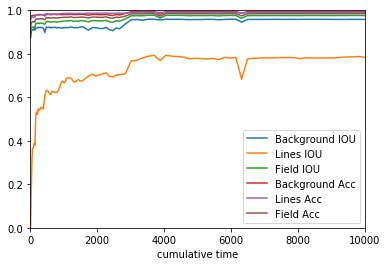

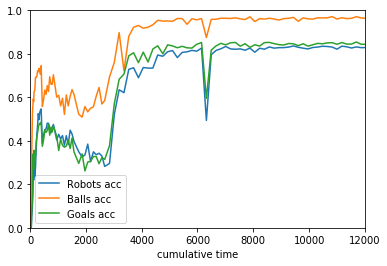

In [18]:
df2 = pd.read_csv('/home/user/jacobs/cudavision/Logs/test_logs_2_669.csv')
show_df_seg(df2)
show_df_det(df2)

In [8]:
time3 = experiment3(time2)

{'input_dimension': (480, 640), 'epoch': 100, 'phase': 'thaw', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l2*nll(F.log_softmax(output[1]), seg.long()) \


Train Epoch concurrent: 1 [0/6194(0%)]	Loss: 1.638139, time: 0.2574799060821533
Train Epoch concurrent: 1 [100/6194(2%)]	Loss: 0.238151, time: 2.7385706901550293
Train Epoch concurrent: 1 [200/6194(3%)]	Loss: 0.120966, time: 2.7383873462677
Train Epoch concurrent: 1 [300/6194(5%)]	Loss: 0.094177, time: 2.7327160835266113
Train Epoch concurrent: 1 [400/6194(6%)]	Loss: 0.085859, time: 2.7328386306762695
Train Epoch concurrent: 1 [500/6194(8%)]	Loss: 0.070958, time: 2.736328363418579
Train Epoch concurrent: 1 [600/6194(10%)]	Loss: 0.077332, time: 2.7360451221466064
Train Epoch concurrent: 1 [700/6194(11%)]	Loss: 0.058403, time: 2.739030122756958
Train Epoch concurrent: 1 [800/6194(13%)]	Loss: 0.068362, time: 2.7349112033843994
Train Epoch concurrent: 1 [900/6194(15%)]	Loss: 0.054231, time: 2.7360541820526123
Train Epoch concurrent: 1 [1000/6194(16%)]	Loss: 0.045440, time: 2.7396841049194336
Train Epoch concurrent: 1 [1100/6194(18%)]	Loss: 0.045037, time: 2.737461805343628
Train Epoch conc

/home/user/jacobs/cudavision/metric_detection.py:72: RuntimeWarning: invalid value encountered in double_scalars
  recall = correct/(correct+FN)
/home/user/jacobs/cudavision/metric_segmentation.py:51: RuntimeWarning: invalid value encountered in true_divide
  IOU_imagewise[:,i] = true_positives_imagewise[cat]/(true_positives_imagewise[cat] + false_positives_imagewise[cat] + false_negatives_imagewise[cat])



Test set: seg Average loss: 0.0179

Background: IOU: 0.9016, accuracy: 0.9530
Lines: IOU: 0.5187, accuracy: 0.9802
Field: IOU: 0.9147, accuracy: 0.9363
Total: IOU: 0.7783, accuracy: 0.9565
making log csv
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_670.csv
Train Epoch concurrent: 2 [0/6194(0%)]	Loss: 0.024337, time: 0.22014689445495605
Train Epoch concurrent: 2 [100/6194(2%)]	Loss: 0.026949, time: 2.7432339191436768
Train Epoch concurrent: 2 [200/6194(3%)]	Loss: 0.025983, time: 2.7384278774261475
Train Epoch concurrent: 2 [300/6194(5%)]	Loss: 0.022909, time: 2.74153733253479
Train Epoch concurrent: 2 [400/6194(6%)]	Loss: 0.027144, time: 2.739628314971924
Train Epoch concurrent: 2 [500/6194(8%)]	Loss: 0.018998, time: 2.7389488220214844
Train Epoch concurrent: 2 [600/6194(10%)]	Loss: 0.019939, time: 2.7392969131469727
Train Epoch concurrent: 2 [700/6194(11%)]	Loss: 0.022475, time: 2.739781141281128
Train Epoch concurrent: 2 [800/6194(13%)]	Loss: 0.022179, time: 2.74196

Train Epoch concurrent: 3 [2700/6194(44%)]	Loss: 0.013088, time: 2.742084264755249
Train Epoch concurrent: 3 [2800/6194(45%)]	Loss: 0.014334, time: 2.7440147399902344
Train Epoch concurrent: 3 [2900/6194(47%)]	Loss: 0.015024, time: 2.742902994155884
Train Epoch concurrent: 3 [3000/6194(48%)]	Loss: 0.014099, time: 2.745070219039917
Train Epoch concurrent: 3 [3100/6194(50%)]	Loss: 0.013592, time: 2.7462966442108154
Train Epoch concurrent: 3 [3200/6194(52%)]	Loss: 0.018374, time: 2.74375581741333
Train Epoch concurrent: 3 [3300/6194(53%)]	Loss: 0.015110, time: 2.745755910873413
Train Epoch concurrent: 3 [3400/6194(55%)]	Loss: 0.011519, time: 2.741734027862549
Train Epoch concurrent: 3 [3500/6194(56%)]	Loss: 0.011943, time: 2.7446727752685547
Train Epoch concurrent: 3 [3600/6194(58%)]	Loss: 0.016532, time: 2.748331069946289
Train Epoch concurrent: 3 [3700/6194(60%)]	Loss: 0.016151, time: 2.741302728652954
Train Epoch concurrent: 3 [3800/6194(61%)]	Loss: 0.013416, time: 2.7430503368377686
T

Train Epoch concurrent: 4 [5700/6194(92%)]	Loss: 0.011965, time: 2.7483432292938232
Train Epoch concurrent: 4 [5800/6194(94%)]	Loss: 0.022196, time: 2.7457902431488037
Train Epoch concurrent: 4 [5900/6194(95%)]	Loss: 0.014435, time: 2.7436861991882324
Train Epoch concurrent: 4 [6000/6194(97%)]	Loss: 0.013165, time: 2.7432494163513184
Train Epoch concurrent: 4 [6100/6194(98%)]	Loss: 0.011320, time: 2.7452197074890137

Test set: det Average loss: 0.0076

Balls: F1: 0.8604, accuracy: 0.7549, recall: 0.9436, precision: 0.7906, FDR: 0.2094,
Goalposts: F1: 0.5582, accuracy: 0.3872, recall: 0.7204, precision: 0.4557, FDR: 0.5443,
Robots: F1: 0.5699, accuracy: 0.3985, recall: 0.6799, precision: 0.4905, FDR: 0.5095,

Test set: seg Average loss: 0.0061

Background: IOU: 0.9512, accuracy: 0.9919
Lines: IOU: 0.7063, accuracy: 0.9867
Field: IOU: 0.9683, accuracy: 0.9788
Total: IOU: 0.8752, accuracy: 0.9858
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_670.csv
Train Epoch concurrent

Train Epoch concurrent: 6 [1900/6194(31%)]	Loss: 0.009387, time: 2.7447221279144287
Train Epoch concurrent: 6 [2000/6194(32%)]	Loss: 0.012324, time: 2.7407522201538086
Train Epoch concurrent: 6 [2100/6194(34%)]	Loss: 0.009671, time: 2.7411842346191406
Train Epoch concurrent: 6 [2200/6194(35%)]	Loss: 0.008053, time: 2.746892213821411
Train Epoch concurrent: 6 [2300/6194(37%)]	Loss: 0.007226, time: 2.7425625324249268
Train Epoch concurrent: 6 [2400/6194(39%)]	Loss: 0.009139, time: 2.742964029312134
Train Epoch concurrent: 6 [2500/6194(40%)]	Loss: 0.010278, time: 2.745777130126953
Train Epoch concurrent: 6 [2600/6194(42%)]	Loss: 0.011761, time: 2.7460873126983643
Train Epoch concurrent: 6 [2700/6194(44%)]	Loss: 0.012046, time: 2.744372606277466
Train Epoch concurrent: 6 [2800/6194(45%)]	Loss: 0.008038, time: 2.7473528385162354
Train Epoch concurrent: 6 [2900/6194(47%)]	Loss: 0.009412, time: 2.74590802192688
Train Epoch concurrent: 6 [3000/6194(48%)]	Loss: 0.008299, time: 2.745319128036499

Train Epoch concurrent: 7 [4900/6194(79%)]	Loss: 0.009818, time: 2.7431392669677734
Train Epoch concurrent: 7 [5000/6194(81%)]	Loss: 0.008365, time: 2.746934175491333
Train Epoch concurrent: 7 [5100/6194(82%)]	Loss: 0.011377, time: 2.7481486797332764
Train Epoch concurrent: 7 [5200/6194(84%)]	Loss: 0.007435, time: 2.743868350982666
Train Epoch concurrent: 7 [5300/6194(85%)]	Loss: 0.009398, time: 2.746009349822998
Train Epoch concurrent: 7 [5400/6194(87%)]	Loss: 0.008895, time: 2.744673013687134
Train Epoch concurrent: 7 [5500/6194(89%)]	Loss: 0.009162, time: 2.744774341583252
Train Epoch concurrent: 7 [5600/6194(90%)]	Loss: 0.007922, time: 2.747365951538086
Train Epoch concurrent: 7 [5700/6194(92%)]	Loss: 0.007383, time: 2.7443270683288574
Train Epoch concurrent: 7 [5800/6194(94%)]	Loss: 0.008088, time: 2.7442667484283447
Train Epoch concurrent: 7 [5900/6194(95%)]	Loss: 0.009062, time: 2.7438199520111084
Train Epoch concurrent: 7 [6000/6194(97%)]	Loss: 0.009800, time: 2.742464780807495

Train Epoch concurrent: 9 [1100/6194(18%)]	Loss: 0.007280, time: 2.7419626712799072
Train Epoch concurrent: 9 [1200/6194(19%)]	Loss: 0.008610, time: 2.7417585849761963
Train Epoch concurrent: 9 [1300/6194(21%)]	Loss: 0.006789, time: 2.745866298675537
Train Epoch concurrent: 9 [1400/6194(23%)]	Loss: 0.008027, time: 2.7448933124542236
Train Epoch concurrent: 9 [1500/6194(24%)]	Loss: 0.006595, time: 2.7449326515197754
Train Epoch concurrent: 9 [1600/6194(26%)]	Loss: 0.006048, time: 2.739870309829712
Train Epoch concurrent: 9 [1700/6194(27%)]	Loss: 0.008699, time: 2.7430219650268555
Train Epoch concurrent: 9 [1800/6194(29%)]	Loss: 0.007902, time: 2.745502233505249
Train Epoch concurrent: 9 [1900/6194(31%)]	Loss: 0.006155, time: 2.7425594329833984
Train Epoch concurrent: 9 [2000/6194(32%)]	Loss: 0.007198, time: 2.74300217628479
Train Epoch concurrent: 9 [2100/6194(34%)]	Loss: 0.007961, time: 2.742460012435913
Train Epoch concurrent: 9 [2200/6194(35%)]	Loss: 0.007230, time: 2.742966413497925

Train Epoch concurrent: 10 [4100/6194(66%)]	Loss: 0.005242, time: 2.7450873851776123
Train Epoch concurrent: 10 [4200/6194(68%)]	Loss: 0.007061, time: 2.7467756271362305
Train Epoch concurrent: 10 [4300/6194(69%)]	Loss: 0.005590, time: 2.7465033531188965
Train Epoch concurrent: 10 [4400/6194(71%)]	Loss: 0.007072, time: 2.7449183464050293
Train Epoch concurrent: 10 [4500/6194(73%)]	Loss: 0.007585, time: 2.742861747741699
Train Epoch concurrent: 10 [4600/6194(74%)]	Loss: 0.005421, time: 2.74587082862854
Train Epoch concurrent: 10 [4700/6194(76%)]	Loss: 0.007695, time: 2.7457115650177
Train Epoch concurrent: 10 [4800/6194(77%)]	Loss: 0.009042, time: 2.7463552951812744
Train Epoch concurrent: 10 [4900/6194(79%)]	Loss: 0.005677, time: 2.7418172359466553
Train Epoch concurrent: 10 [5000/6194(81%)]	Loss: 0.005368, time: 2.74458646774292
Train Epoch concurrent: 10 [5100/6194(82%)]	Loss: 0.006674, time: 2.7502589225769043
Train Epoch concurrent: 10 [5200/6194(84%)]	Loss: 0.006835, time: 2.74418

Train Epoch concurrent: 12 [200/6194(3%)]	Loss: 0.005186, time: 2.7436821460723877
Train Epoch concurrent: 12 [300/6194(5%)]	Loss: 0.006176, time: 2.741553783416748
Train Epoch concurrent: 12 [400/6194(6%)]	Loss: 0.006773, time: 2.743069648742676
Train Epoch concurrent: 12 [500/6194(8%)]	Loss: 0.004891, time: 2.743084669113159
Train Epoch concurrent: 12 [600/6194(10%)]	Loss: 0.006130, time: 2.7409486770629883
Train Epoch concurrent: 12 [700/6194(11%)]	Loss: 0.005566, time: 2.743098735809326
Train Epoch concurrent: 12 [800/6194(13%)]	Loss: 0.004637, time: 2.742750644683838
Train Epoch concurrent: 12 [900/6194(15%)]	Loss: 0.005385, time: 2.7404303550720215
Train Epoch concurrent: 12 [1000/6194(16%)]	Loss: 0.005077, time: 2.74467134475708
Train Epoch concurrent: 12 [1100/6194(18%)]	Loss: 0.005564, time: 2.74237322807312
Train Epoch concurrent: 12 [1200/6194(19%)]	Loss: 0.005970, time: 2.7477810382843018
Train Epoch concurrent: 12 [1300/6194(21%)]	Loss: 0.004845, time: 2.7421271800994873
T

Train Epoch concurrent: 13 [3100/6194(50%)]	Loss: 0.005230, time: 2.743884325027466
Train Epoch concurrent: 13 [3200/6194(52%)]	Loss: 0.005440, time: 2.7423667907714844
Train Epoch concurrent: 13 [3300/6194(53%)]	Loss: 0.004257, time: 2.746598243713379
Train Epoch concurrent: 13 [3400/6194(55%)]	Loss: 0.005569, time: 2.7447311878204346
Train Epoch concurrent: 13 [3500/6194(56%)]	Loss: 0.005395, time: 2.7428441047668457
Train Epoch concurrent: 13 [3600/6194(58%)]	Loss: 0.006206, time: 2.7443597316741943
Train Epoch concurrent: 13 [3700/6194(60%)]	Loss: 0.005200, time: 2.744140625
Train Epoch concurrent: 13 [3800/6194(61%)]	Loss: 0.005094, time: 2.7463321685791016
Train Epoch concurrent: 13 [3900/6194(63%)]	Loss: 0.004991, time: 2.745927095413208
Train Epoch concurrent: 13 [4000/6194(65%)]	Loss: 0.004712, time: 2.7435200214385986
Train Epoch concurrent: 13 [4100/6194(66%)]	Loss: 0.005956, time: 2.744530439376831
Train Epoch concurrent: 13 [4200/6194(68%)]	Loss: 0.004313, time: 2.74223327

Train Epoch concurrent: 14 [6000/6194(97%)]	Loss: 0.004750, time: 2.748086452484131
Train Epoch concurrent: 14 [6100/6194(98%)]	Loss: 0.003651, time: 2.7441365718841553

Test set: det Average loss: 0.0027

Balls: F1: 0.9511, accuracy: 0.9068, recall: 0.9826, precision: 0.9216, FDR: 0.0784,
Goalposts: F1: 0.8912, accuracy: 0.8037, recall: 0.9211, precision: 0.8631, FDR: 0.1369,
Robots: F1: 0.8607, accuracy: 0.7555, recall: 0.9037, precision: 0.8216, FDR: 0.1784,

Test set: seg Average loss: 0.0039

Background: IOU: 0.9603, accuracy: 0.9948
Lines: IOU: 0.7955, accuracy: 0.9914
Field: IOU: 0.9786, accuracy: 0.9862
Total: IOU: 0.9115, accuracy: 0.9908
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_670.csv
Train Epoch concurrent: 15 [0/6194(0%)]	Loss: 0.005711, time: 0.21831536293029785
Train Epoch concurrent: 15 [100/6194(2%)]	Loss: 0.004968, time: 2.739734172821045
Train Epoch concurrent: 15 [200/6194(3%)]	Loss: 0.006111, time: 2.740260601043701
Train Epoch concurrent: 15 

Train Epoch concurrent: 16 [2100/6194(34%)]	Loss: 0.005734, time: 2.7415945529937744
Train Epoch concurrent: 16 [2200/6194(35%)]	Loss: 0.006458, time: 2.745159864425659
Train Epoch concurrent: 16 [2300/6194(37%)]	Loss: 0.004179, time: 2.7420084476470947
Train Epoch concurrent: 16 [2400/6194(39%)]	Loss: 0.004270, time: 2.7482197284698486
Train Epoch concurrent: 16 [2500/6194(40%)]	Loss: 0.004009, time: 2.742922306060791
Train Epoch concurrent: 16 [2600/6194(42%)]	Loss: 0.004944, time: 2.746222496032715
Train Epoch concurrent: 16 [2700/6194(44%)]	Loss: 0.004046, time: 2.746124744415283
Train Epoch concurrent: 16 [2800/6194(45%)]	Loss: 0.004559, time: 2.745617628097534
Train Epoch concurrent: 16 [2900/6194(47%)]	Loss: 0.004881, time: 2.7422335147857666
Train Epoch concurrent: 16 [3000/6194(48%)]	Loss: 0.004018, time: 2.7444257736206055
Train Epoch concurrent: 16 [3100/6194(50%)]	Loss: 0.006103, time: 2.745201826095581
Train Epoch concurrent: 16 [3200/6194(52%)]	Loss: 0.005060, time: 2.744

Train Epoch concurrent: 17 [5000/6194(81%)]	Loss: 0.004424, time: 2.744884967803955
Train Epoch concurrent: 17 [5100/6194(82%)]	Loss: 0.006439, time: 2.7406420707702637
Train Epoch concurrent: 17 [5200/6194(84%)]	Loss: 0.004533, time: 2.7470614910125732
Train Epoch concurrent: 17 [5300/6194(85%)]	Loss: 0.003446, time: 2.752197265625
Train Epoch concurrent: 17 [5400/6194(87%)]	Loss: 0.003754, time: 2.749305486679077
Train Epoch concurrent: 17 [5500/6194(89%)]	Loss: 0.003988, time: 2.7488253116607666
Train Epoch concurrent: 17 [5600/6194(90%)]	Loss: 0.004469, time: 2.743452787399292
Train Epoch concurrent: 17 [5700/6194(92%)]	Loss: 0.003857, time: 2.7484776973724365
Train Epoch concurrent: 17 [5800/6194(94%)]	Loss: 0.005152, time: 2.7494986057281494
Train Epoch concurrent: 17 [5900/6194(95%)]	Loss: 0.005216, time: 2.7488656044006348
Train Epoch concurrent: 17 [6000/6194(97%)]	Loss: 0.004370, time: 2.748471975326538
Train Epoch concurrent: 17 [6100/6194(98%)]	Loss: 0.003880, time: 2.75048

Train Epoch concurrent: 19 [1100/6194(18%)]	Loss: 0.002909, time: 2.7482802867889404
Train Epoch concurrent: 19 [1200/6194(19%)]	Loss: 0.003855, time: 2.7473795413970947
Train Epoch concurrent: 19 [1300/6194(21%)]	Loss: 0.004425, time: 2.746612071990967
Train Epoch concurrent: 19 [1400/6194(23%)]	Loss: 0.004350, time: 2.7415413856506348
Train Epoch concurrent: 19 [1500/6194(24%)]	Loss: 0.003864, time: 2.745023727416992
Train Epoch concurrent: 19 [1600/6194(26%)]	Loss: 0.003223, time: 2.7444047927856445
Train Epoch concurrent: 19 [1700/6194(27%)]	Loss: 0.003513, time: 2.7411115169525146
Train Epoch concurrent: 19 [1800/6194(29%)]	Loss: 0.003544, time: 2.744485378265381
Train Epoch concurrent: 19 [1900/6194(31%)]	Loss: 0.003804, time: 2.7422680854797363
Train Epoch concurrent: 19 [2000/6194(32%)]	Loss: 0.004869, time: 2.7416741847991943
Train Epoch concurrent: 19 [2100/6194(34%)]	Loss: 0.003228, time: 2.744196653366089
Train Epoch concurrent: 19 [2200/6194(35%)]	Loss: 0.003926, time: 2.7

Train Epoch concurrent: 20 [4000/6194(65%)]	Loss: 0.004345, time: 2.7506814002990723
Train Epoch concurrent: 20 [4100/6194(66%)]	Loss: 0.004117, time: 2.746565103530884
Train Epoch concurrent: 20 [4200/6194(68%)]	Loss: 0.003703, time: 2.743199110031128
Train Epoch concurrent: 20 [4300/6194(69%)]	Loss: 0.003121, time: 2.748610258102417
Train Epoch concurrent: 20 [4400/6194(71%)]	Loss: 0.003088, time: 2.746860980987549
Train Epoch concurrent: 20 [4500/6194(73%)]	Loss: 0.003811, time: 2.749283790588379
Train Epoch concurrent: 20 [4600/6194(74%)]	Loss: 0.003931, time: 2.745946168899536
Train Epoch concurrent: 20 [4700/6194(76%)]	Loss: 0.002674, time: 2.7443010807037354
Train Epoch concurrent: 20 [4800/6194(77%)]	Loss: 0.002904, time: 2.751187562942505
Train Epoch concurrent: 20 [4900/6194(79%)]	Loss: 0.003004, time: 2.751924753189087
Train Epoch concurrent: 20 [5000/6194(81%)]	Loss: 0.004009, time: 2.7473270893096924
Train Epoch concurrent: 20 [5100/6194(82%)]	Loss: 0.003530, time: 2.75194

Train Epoch concurrent: 22 [0/6194(0%)]	Loss: 0.003694, time: 0.2206416130065918
Train Epoch concurrent: 22 [100/6194(2%)]	Loss: 0.003354, time: 2.741154909133911
Train Epoch concurrent: 22 [200/6194(3%)]	Loss: 0.002536, time: 2.7435083389282227
Train Epoch concurrent: 22 [300/6194(5%)]	Loss: 0.002576, time: 2.743152379989624
Train Epoch concurrent: 22 [400/6194(6%)]	Loss: 0.002776, time: 2.7427749633789062
Train Epoch concurrent: 22 [500/6194(8%)]	Loss: 0.002810, time: 2.744922399520874
Train Epoch concurrent: 22 [600/6194(10%)]	Loss: 0.002474, time: 2.7438278198242188
Train Epoch concurrent: 22 [700/6194(11%)]	Loss: 0.002326, time: 2.742253541946411
Train Epoch concurrent: 22 [800/6194(13%)]	Loss: 0.002145, time: 2.7458877563476562
Train Epoch concurrent: 22 [900/6194(15%)]	Loss: 0.002599, time: 2.7463176250457764
Train Epoch concurrent: 22 [1000/6194(16%)]	Loss: 0.002274, time: 2.7454943656921387
Train Epoch concurrent: 22 [1100/6194(18%)]	Loss: 0.002646, time: 2.745349645614624
Tra

Train Epoch concurrent: 23 [2900/6194(47%)]	Loss: 0.002889, time: 2.7463319301605225
Train Epoch concurrent: 23 [3000/6194(48%)]	Loss: 0.003108, time: 2.748790979385376
Train Epoch concurrent: 23 [3100/6194(50%)]	Loss: 0.002885, time: 2.744469404220581
Train Epoch concurrent: 23 [3200/6194(52%)]	Loss: 0.003318, time: 2.7490415573120117
Train Epoch concurrent: 23 [3300/6194(53%)]	Loss: 0.002740, time: 2.7465898990631104
Train Epoch concurrent: 23 [3400/6194(55%)]	Loss: 0.003193, time: 2.745736598968506
Train Epoch concurrent: 23 [3500/6194(56%)]	Loss: 0.002665, time: 2.748995542526245
Train Epoch concurrent: 23 [3600/6194(58%)]	Loss: 0.002522, time: 2.7454633712768555
Train Epoch concurrent: 23 [3700/6194(60%)]	Loss: 0.003848, time: 2.7501652240753174
Train Epoch concurrent: 23 [3800/6194(61%)]	Loss: 0.002558, time: 2.7492172718048096
Train Epoch concurrent: 23 [3900/6194(63%)]	Loss: 0.003025, time: 2.7468795776367188
Train Epoch concurrent: 23 [4000/6194(65%)]	Loss: 0.002493, time: 2.7

Train Epoch concurrent: 24 [5800/6194(94%)]	Loss: 0.001750, time: 2.7502779960632324
Train Epoch concurrent: 24 [5900/6194(95%)]	Loss: 0.001793, time: 2.7476134300231934
Train Epoch concurrent: 24 [6000/6194(97%)]	Loss: 0.002095, time: 2.750900983810425
Train Epoch concurrent: 24 [6100/6194(98%)]	Loss: 0.001980, time: 2.748828411102295

Test set: det Average loss: 0.0021

Balls: F1: 0.9836, accuracy: 0.9678, recall: 0.9927, precision: 0.9748, FDR: 0.0252,
Goalposts: F1: 0.9201, accuracy: 0.8520, recall: 0.9302, precision: 0.9103, FDR: 0.0897,
Robots: F1: 0.9046, accuracy: 0.8258, recall: 0.9235, precision: 0.8864, FDR: 0.1136,

Test set: seg Average loss: 0.0055

Background: IOU: 0.9611, accuracy: 0.9945
Lines: IOU: 0.7861, accuracy: 0.9911
Field: IOU: 0.9776, accuracy: 0.9856
Total: IOU: 0.9083, accuracy: 0.9904
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_670.csv
Train Epoch concurrent: 25 [0/6194(0%)]	Loss: 0.002242, time: 0.22078180313110352
Train Epoch concurrent

Train Epoch concurrent: 26 [1900/6194(31%)]	Loss: 0.001171, time: 2.7461509704589844
Train Epoch concurrent: 26 [2000/6194(32%)]	Loss: 0.001647, time: 2.7441627979278564
Train Epoch concurrent: 26 [2100/6194(34%)]	Loss: 0.001489, time: 2.742757797241211
Train Epoch concurrent: 26 [2200/6194(35%)]	Loss: 0.001358, time: 2.748610734939575
Train Epoch concurrent: 26 [2300/6194(37%)]	Loss: 0.001331, time: 2.748242139816284
Train Epoch concurrent: 26 [2400/6194(39%)]	Loss: 0.001293, time: 2.7482035160064697
Train Epoch concurrent: 26 [2500/6194(40%)]	Loss: 0.001411, time: 2.7409579753875732
Train Epoch concurrent: 26 [2600/6194(42%)]	Loss: 0.001401, time: 2.7437479496002197
Train Epoch concurrent: 26 [2700/6194(44%)]	Loss: 0.001599, time: 2.7466635704040527
Train Epoch concurrent: 26 [2800/6194(45%)]	Loss: 0.001298, time: 2.74548077583313
Train Epoch concurrent: 26 [2900/6194(47%)]	Loss: 0.001476, time: 2.7475926876068115
Train Epoch concurrent: 26 [3000/6194(48%)]	Loss: 0.001724, time: 2.74

Train Epoch concurrent: 27 [4800/6194(77%)]	Loss: 0.001766, time: 2.7461488246917725
Train Epoch concurrent: 27 [4900/6194(79%)]	Loss: 0.001218, time: 2.7481961250305176
Train Epoch concurrent: 27 [5000/6194(81%)]	Loss: 0.001244, time: 2.747945785522461
Train Epoch concurrent: 27 [5100/6194(82%)]	Loss: 0.001386, time: 2.7551348209381104
Train Epoch concurrent: 27 [5200/6194(84%)]	Loss: 0.001661, time: 2.751756191253662
Train Epoch concurrent: 27 [5300/6194(85%)]	Loss: 0.001362, time: 2.7485222816467285
Train Epoch concurrent: 27 [5400/6194(87%)]	Loss: 0.001434, time: 2.7480554580688477
Train Epoch concurrent: 27 [5500/6194(89%)]	Loss: 0.001643, time: 2.7497427463531494
Train Epoch concurrent: 27 [5600/6194(90%)]	Loss: 0.001588, time: 2.7505533695220947
Train Epoch concurrent: 27 [5700/6194(92%)]	Loss: 0.001317, time: 2.7526426315307617
Train Epoch concurrent: 27 [5800/6194(94%)]	Loss: 0.001054, time: 2.7496731281280518
Train Epoch concurrent: 27 [5900/6194(95%)]	Loss: 0.001168, time: 2

Train Epoch concurrent: 29 [900/6194(15%)]	Loss: 0.001113, time: 2.740963935852051
Train Epoch concurrent: 29 [1000/6194(16%)]	Loss: 0.001218, time: 2.74721360206604
Train Epoch concurrent: 29 [1100/6194(18%)]	Loss: 0.001103, time: 2.7422616481781006
Train Epoch concurrent: 29 [1200/6194(19%)]	Loss: 0.000898, time: 2.744079828262329
Train Epoch concurrent: 29 [1300/6194(21%)]	Loss: 0.001330, time: 2.7441346645355225
Train Epoch concurrent: 29 [1400/6194(23%)]	Loss: 0.001119, time: 2.741067409515381
Train Epoch concurrent: 29 [1500/6194(24%)]	Loss: 0.001120, time: 2.7578465938568115
Train Epoch concurrent: 29 [1600/6194(26%)]	Loss: 0.001071, time: 2.7525694370269775
Train Epoch concurrent: 29 [1700/6194(27%)]	Loss: 0.001164, time: 2.7631824016571045
Train Epoch concurrent: 29 [1800/6194(29%)]	Loss: 0.000987, time: 2.7597029209136963
Train Epoch concurrent: 29 [1900/6194(31%)]	Loss: 0.000978, time: 2.7423243522644043
Train Epoch concurrent: 29 [2000/6194(32%)]	Loss: 0.001031, time: 2.748

Train Epoch concurrent: 30 [3800/6194(61%)]	Loss: 0.001024, time: 2.741276741027832
Train Epoch concurrent: 30 [3900/6194(63%)]	Loss: 0.000944, time: 2.743837594985962
Train Epoch concurrent: 30 [4000/6194(65%)]	Loss: 0.001485, time: 2.742997407913208
Train Epoch concurrent: 30 [4100/6194(66%)]	Loss: 0.000755, time: 2.743163585662842
Train Epoch concurrent: 30 [4200/6194(68%)]	Loss: 0.001247, time: 2.7435781955718994
Train Epoch concurrent: 30 [4300/6194(69%)]	Loss: 0.001009, time: 2.740922689437866
Train Epoch concurrent: 30 [4400/6194(71%)]	Loss: 0.001011, time: 2.7448251247406006
Train Epoch concurrent: 30 [4500/6194(73%)]	Loss: 0.000856, time: 2.7412283420562744
Train Epoch concurrent: 30 [4600/6194(74%)]	Loss: 0.001202, time: 2.7465415000915527
Train Epoch concurrent: 30 [4700/6194(76%)]	Loss: 0.001692, time: 2.739480972290039
Train Epoch concurrent: 30 [4800/6194(77%)]	Loss: 0.001267, time: 2.746337652206421
Train Epoch concurrent: 30 [4900/6194(79%)]	Loss: 0.001374, time: 2.7420

Train Epoch concurrent: 32 [0/6194(0%)]	Loss: 0.000861, time: 0.21839237213134766
Train Epoch concurrent: 32 [100/6194(2%)]	Loss: 0.000959, time: 2.74615216255188
Train Epoch concurrent: 32 [200/6194(3%)]	Loss: 0.000831, time: 2.740072727203369
Train Epoch concurrent: 32 [300/6194(5%)]	Loss: 0.000845, time: 2.741814374923706
Train Epoch concurrent: 32 [400/6194(6%)]	Loss: 0.000778, time: 2.7398910522460938
Train Epoch concurrent: 32 [500/6194(8%)]	Loss: 0.000947, time: 2.741342544555664
Train Epoch concurrent: 32 [600/6194(10%)]	Loss: 0.001000, time: 2.7432351112365723
Train Epoch concurrent: 32 [700/6194(11%)]	Loss: 0.000969, time: 2.744553565979004
Train Epoch concurrent: 32 [800/6194(13%)]	Loss: 0.000749, time: 2.742190361022949
Train Epoch concurrent: 32 [900/6194(15%)]	Loss: 0.001134, time: 2.7401955127716064
Train Epoch concurrent: 32 [1000/6194(16%)]	Loss: 0.000747, time: 2.7385268211364746
Train Epoch concurrent: 32 [1100/6194(18%)]	Loss: 0.001115, time: 2.742657423019409
Train

Train Epoch concurrent: 33 [2900/6194(47%)]	Loss: 0.000883, time: 2.745253086090088
Train Epoch concurrent: 33 [3000/6194(48%)]	Loss: 0.000698, time: 2.7394375801086426
Train Epoch concurrent: 33 [3100/6194(50%)]	Loss: 0.000879, time: 2.742403984069824
Train Epoch concurrent: 33 [3200/6194(52%)]	Loss: 0.001327, time: 2.7428653240203857
Train Epoch concurrent: 33 [3300/6194(53%)]	Loss: 0.000808, time: 2.7457926273345947
Train Epoch concurrent: 33 [3400/6194(55%)]	Loss: 0.000757, time: 2.7453572750091553
Train Epoch concurrent: 33 [3500/6194(56%)]	Loss: 0.000613, time: 2.745359182357788
Train Epoch concurrent: 33 [3600/6194(58%)]	Loss: 0.000668, time: 2.745370626449585
Train Epoch concurrent: 33 [3700/6194(60%)]	Loss: 0.000624, time: 2.744431495666504
Train Epoch concurrent: 33 [3800/6194(61%)]	Loss: 0.000736, time: 2.7407443523406982
Train Epoch concurrent: 33 [3900/6194(63%)]	Loss: 0.000784, time: 2.744763135910034
Train Epoch concurrent: 33 [4000/6194(65%)]	Loss: 0.000955, time: 2.741

Train Epoch concurrent: 34 [5800/6194(94%)]	Loss: 0.001046, time: 2.7426133155822754
Train Epoch concurrent: 34 [5900/6194(95%)]	Loss: 0.000860, time: 2.7445125579833984
Train Epoch concurrent: 34 [6000/6194(97%)]	Loss: 0.000753, time: 2.7416718006134033
Train Epoch concurrent: 34 [6100/6194(98%)]	Loss: 0.001757, time: 2.7438948154449463

Test set: det Average loss: 0.0022

Balls: F1: 0.9849, accuracy: 0.9703, recall: 0.9939, precision: 0.9761, FDR: 0.0239,
Goalposts: F1: 0.9174, accuracy: 0.8474, recall: 0.9365, precision: 0.8991, FDR: 0.1009,
Robots: F1: 0.9086, accuracy: 0.8324, recall: 0.9305, precision: 0.8877, FDR: 0.1123,

Test set: seg Average loss: 0.0100

Background: IOU: 0.9605, accuracy: 0.9944
Lines: IOU: 0.7863, accuracy: 0.9910
Field: IOU: 0.9773, accuracy: 0.9854
Total: IOU: 0.9081, accuracy: 0.9903
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_670.csv
Train Epoch concurrent: 35 [0/6194(0%)]	Loss: 0.000657, time: 0.21820282936096191
Train Epoch concurre

Train Epoch concurrent: 36 [1900/6194(31%)]	Loss: 0.000727, time: 2.7471368312835693
Train Epoch concurrent: 36 [2000/6194(32%)]	Loss: 0.000674, time: 2.7415316104888916
Train Epoch concurrent: 36 [2100/6194(34%)]	Loss: 0.000727, time: 2.743807077407837
Train Epoch concurrent: 36 [2200/6194(35%)]	Loss: 0.000952, time: 2.74358868598938
Train Epoch concurrent: 36 [2300/6194(37%)]	Loss: 0.000673, time: 2.7417590618133545
Train Epoch concurrent: 36 [2400/6194(39%)]	Loss: 0.000784, time: 2.7428033351898193
Train Epoch concurrent: 36 [2500/6194(40%)]	Loss: 0.000759, time: 2.7446460723876953
Train Epoch concurrent: 36 [2600/6194(42%)]	Loss: 0.000673, time: 2.742086887359619
Train Epoch concurrent: 36 [2700/6194(44%)]	Loss: 0.000731, time: 2.7443861961364746
Train Epoch concurrent: 36 [2800/6194(45%)]	Loss: 0.000798, time: 2.742063283920288
Train Epoch concurrent: 36 [2900/6194(47%)]	Loss: 0.000716, time: 2.7405145168304443
Train Epoch concurrent: 36 [3000/6194(48%)]	Loss: 0.000722, time: 2.74

Train Epoch concurrent: 37 [4800/6194(77%)]	Loss: 0.000688, time: 2.7444376945495605
Train Epoch concurrent: 37 [4900/6194(79%)]	Loss: 0.000917, time: 2.7464003562927246
Train Epoch concurrent: 37 [5000/6194(81%)]	Loss: 0.000805, time: 2.744629383087158
Train Epoch concurrent: 37 [5100/6194(82%)]	Loss: 0.000777, time: 2.742405652999878
Train Epoch concurrent: 37 [5200/6194(84%)]	Loss: 0.000649, time: 2.7416977882385254
Train Epoch concurrent: 37 [5300/6194(85%)]	Loss: 0.000693, time: 2.7464544773101807
Train Epoch concurrent: 37 [5400/6194(87%)]	Loss: 0.000922, time: 2.7463221549987793
Train Epoch concurrent: 37 [5500/6194(89%)]	Loss: 0.000849, time: 2.7449707984924316
Train Epoch concurrent: 37 [5600/6194(90%)]	Loss: 0.000813, time: 2.741974353790283
Train Epoch concurrent: 37 [5700/6194(92%)]	Loss: 0.000707, time: 2.7418556213378906
Train Epoch concurrent: 37 [5800/6194(94%)]	Loss: 0.000972, time: 2.745967388153076
Train Epoch concurrent: 37 [5900/6194(95%)]	Loss: 0.000973, time: 2.7

Train Epoch concurrent: 39 [900/6194(15%)]	Loss: 0.000537, time: 2.738145351409912
Train Epoch concurrent: 39 [1000/6194(16%)]	Loss: 0.000733, time: 2.739907741546631
Train Epoch concurrent: 39 [1100/6194(18%)]	Loss: 0.000492, time: 2.7386045455932617
Train Epoch concurrent: 39 [1200/6194(19%)]	Loss: 0.000473, time: 2.738415241241455
Train Epoch concurrent: 39 [1300/6194(21%)]	Loss: 0.000528, time: 2.7416744232177734
Train Epoch concurrent: 39 [1400/6194(23%)]	Loss: 0.000446, time: 2.739936113357544
Train Epoch concurrent: 39 [1500/6194(24%)]	Loss: 0.000862, time: 2.7416887283325195
Train Epoch concurrent: 39 [1600/6194(26%)]	Loss: 0.000460, time: 2.739489793777466
Train Epoch concurrent: 39 [1700/6194(27%)]	Loss: 0.000552, time: 2.739551305770874
Train Epoch concurrent: 39 [1800/6194(29%)]	Loss: 0.000562, time: 2.7424635887145996
Train Epoch concurrent: 39 [1900/6194(31%)]	Loss: 0.000633, time: 2.73805832862854
Train Epoch concurrent: 39 [2000/6194(32%)]	Loss: 0.000477, time: 2.740604

Train Epoch concurrent: 40 [3800/6194(61%)]	Loss: 0.000492, time: 2.7425498962402344
Train Epoch concurrent: 40 [3900/6194(63%)]	Loss: 0.000464, time: 2.740069627761841
Train Epoch concurrent: 40 [4000/6194(65%)]	Loss: 0.000502, time: 2.741563081741333
Train Epoch concurrent: 40 [4100/6194(66%)]	Loss: 0.000584, time: 2.7455999851226807
Train Epoch concurrent: 40 [4200/6194(68%)]	Loss: 0.000536, time: 2.7438225746154785
Train Epoch concurrent: 40 [4300/6194(69%)]	Loss: 0.000481, time: 2.741513729095459
Train Epoch concurrent: 40 [4400/6194(71%)]	Loss: 0.000442, time: 2.74186110496521
Train Epoch concurrent: 40 [4500/6194(73%)]	Loss: 0.001160, time: 2.7435028553009033
Train Epoch concurrent: 40 [4600/6194(74%)]	Loss: 0.000482, time: 2.745203733444214
Train Epoch concurrent: 40 [4700/6194(76%)]	Loss: 0.000517, time: 2.7412710189819336
Train Epoch concurrent: 40 [4800/6194(77%)]	Loss: 0.000501, time: 2.7430899143218994
Train Epoch concurrent: 40 [4900/6194(79%)]	Loss: 0.000511, time: 2.740

Train Epoch concurrent: 42 [0/6194(0%)]	Loss: 0.000467, time: 0.22112250328063965
Train Epoch concurrent: 42 [100/6194(2%)]	Loss: 0.000525, time: 2.7380993366241455
Train Epoch concurrent: 42 [200/6194(3%)]	Loss: 0.000491, time: 2.742046594619751
Train Epoch concurrent: 42 [300/6194(5%)]	Loss: 0.000531, time: 2.737760066986084
Train Epoch concurrent: 42 [400/6194(6%)]	Loss: 0.000654, time: 2.739579439163208
Train Epoch concurrent: 42 [500/6194(8%)]	Loss: 0.000586, time: 2.746295213699341
Train Epoch concurrent: 42 [600/6194(10%)]	Loss: 0.000569, time: 2.739518642425537
Train Epoch concurrent: 42 [700/6194(11%)]	Loss: 0.000565, time: 2.742794990539551
Train Epoch concurrent: 42 [800/6194(13%)]	Loss: 0.000529, time: 2.740114450454712
Train Epoch concurrent: 42 [900/6194(15%)]	Loss: 0.000624, time: 2.741316080093384
Train Epoch concurrent: 42 [1000/6194(16%)]	Loss: 0.000701, time: 2.744605541229248
Train Epoch concurrent: 42 [1100/6194(18%)]	Loss: 0.000429, time: 2.7419347763061523
Train 

Train Epoch concurrent: 43 [2900/6194(47%)]	Loss: 0.000923, time: 2.7433393001556396
Train Epoch concurrent: 43 [3000/6194(48%)]	Loss: 0.000748, time: 2.7461068630218506
Train Epoch concurrent: 43 [3100/6194(50%)]	Loss: 0.000772, time: 2.7480826377868652
Train Epoch concurrent: 43 [3200/6194(52%)]	Loss: 0.000992, time: 2.7435052394866943
Train Epoch concurrent: 43 [3300/6194(53%)]	Loss: 0.000672, time: 2.7505805492401123
Train Epoch concurrent: 43 [3400/6194(55%)]	Loss: 0.000728, time: 2.7441391944885254
Train Epoch concurrent: 43 [3500/6194(56%)]	Loss: 0.000747, time: 2.7449498176574707
Train Epoch concurrent: 43 [3600/6194(58%)]	Loss: 0.000846, time: 2.7477238178253174
Train Epoch concurrent: 43 [3700/6194(60%)]	Loss: 0.000668, time: 2.7479300498962402
Train Epoch concurrent: 43 [3800/6194(61%)]	Loss: 0.000742, time: 2.746971368789673
Train Epoch concurrent: 43 [3900/6194(63%)]	Loss: 0.000943, time: 2.7449581623077393
Train Epoch concurrent: 43 [4000/6194(65%)]	Loss: 0.000665, time: 

Train Epoch concurrent: 44 [5800/6194(94%)]	Loss: 0.000586, time: 2.7454166412353516
Train Epoch concurrent: 44 [5900/6194(95%)]	Loss: 0.000507, time: 2.744476079940796
Train Epoch concurrent: 44 [6000/6194(97%)]	Loss: 0.000582, time: 2.7507572174072266
Train Epoch concurrent: 44 [6100/6194(98%)]	Loss: 0.000615, time: 2.7420859336853027

Test set: det Average loss: 0.0020

Balls: F1: 0.9863, accuracy: 0.9730, recall: 0.9955, precision: 0.9772, FDR: 0.0228,
Goalposts: F1: 0.9246, accuracy: 0.8598, recall: 0.9300, precision: 0.9192, FDR: 0.0808,
Robots: F1: 0.9033, accuracy: 0.8236, recall: 0.9184, precision: 0.8886, FDR: 0.1114,

Test set: seg Average loss: 0.0108

Background: IOU: 0.9612, accuracy: 0.9945
Lines: IOU: 0.7879, accuracy: 0.9910
Field: IOU: 0.9775, accuracy: 0.9855
Total: IOU: 0.9089, accuracy: 0.9903
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_670.csv
Train Epoch concurrent: 45 [0/6194(0%)]	Loss: 0.000524, time: 0.21795177459716797
Train Epoch concurren

Train Epoch concurrent: 46 [1900/6194(31%)]	Loss: 0.000716, time: 2.745368719100952
Train Epoch concurrent: 46 [2000/6194(32%)]	Loss: 0.000648, time: 2.744196653366089
Train Epoch concurrent: 46 [2100/6194(34%)]	Loss: 0.000548, time: 2.7429935932159424
Train Epoch concurrent: 46 [2200/6194(35%)]	Loss: 0.000620, time: 2.743666648864746
Train Epoch concurrent: 46 [2300/6194(37%)]	Loss: 0.000525, time: 2.7443606853485107
Train Epoch concurrent: 46 [2400/6194(39%)]	Loss: 0.000524, time: 2.740445375442505
Train Epoch concurrent: 46 [2500/6194(40%)]	Loss: 0.000446, time: 2.7430617809295654
Train Epoch concurrent: 46 [2600/6194(42%)]	Loss: 0.000539, time: 2.7413015365600586
Train Epoch concurrent: 46 [2700/6194(44%)]	Loss: 0.000525, time: 2.7430694103240967
Train Epoch concurrent: 46 [2800/6194(45%)]	Loss: 0.000527, time: 2.7433245182037354
Train Epoch concurrent: 46 [2900/6194(47%)]	Loss: 0.000503, time: 2.7417402267456055
Train Epoch concurrent: 46 [3000/6194(48%)]	Loss: 0.000463, time: 2.7

Train Epoch concurrent: 47 [4800/6194(77%)]	Loss: 0.000509, time: 2.745783805847168
Train Epoch concurrent: 47 [4900/6194(79%)]	Loss: 0.000945, time: 2.745279550552368
Train Epoch concurrent: 47 [5000/6194(81%)]	Loss: 0.000592, time: 2.742659091949463
Train Epoch concurrent: 47 [5100/6194(82%)]	Loss: 0.000601, time: 2.7447214126586914
Train Epoch concurrent: 47 [5200/6194(84%)]	Loss: 0.000483, time: 2.7465639114379883
Train Epoch concurrent: 47 [5300/6194(85%)]	Loss: 0.000534, time: 2.743912696838379
Train Epoch concurrent: 47 [5400/6194(87%)]	Loss: 0.000684, time: 2.744405508041382
Train Epoch concurrent: 47 [5500/6194(89%)]	Loss: 0.000534, time: 2.743950605392456
Train Epoch concurrent: 47 [5600/6194(90%)]	Loss: 0.000587, time: 2.745910167694092
Train Epoch concurrent: 47 [5700/6194(92%)]	Loss: 0.000528, time: 2.7445762157440186
Train Epoch concurrent: 47 [5800/6194(94%)]	Loss: 0.000469, time: 2.7458763122558594
Train Epoch concurrent: 47 [5900/6194(95%)]	Loss: 0.000498, time: 2.7470

Train Epoch concurrent: 49 [900/6194(15%)]	Loss: 0.000452, time: 2.7397518157958984
Train Epoch concurrent: 49 [1000/6194(16%)]	Loss: 0.000476, time: 2.738210916519165
Train Epoch concurrent: 49 [1100/6194(18%)]	Loss: 0.000490, time: 2.743007183074951
Train Epoch concurrent: 49 [1200/6194(19%)]	Loss: 0.000743, time: 2.738452911376953
Train Epoch concurrent: 49 [1300/6194(21%)]	Loss: 0.000508, time: 2.7420878410339355
Train Epoch concurrent: 49 [1400/6194(23%)]	Loss: 0.000602, time: 2.739671468734741
Train Epoch concurrent: 49 [1500/6194(24%)]	Loss: 0.000516, time: 2.737067461013794
Train Epoch concurrent: 49 [1600/6194(26%)]	Loss: 0.000583, time: 2.7480382919311523
Train Epoch concurrent: 49 [1700/6194(27%)]	Loss: 0.000610, time: 2.739795207977295
Train Epoch concurrent: 49 [1800/6194(29%)]	Loss: 0.000574, time: 2.741581916809082
Train Epoch concurrent: 49 [1900/6194(31%)]	Loss: 0.000593, time: 2.7422502040863037
Train Epoch concurrent: 49 [2000/6194(32%)]	Loss: 0.000453, time: 2.73807

Train Epoch concurrent: 50 [3800/6194(61%)]	Loss: 0.000524, time: 2.7385637760162354
Train Epoch concurrent: 50 [3900/6194(63%)]	Loss: 0.000497, time: 2.7445456981658936
Train Epoch concurrent: 50 [4000/6194(65%)]	Loss: 0.000457, time: 2.7407479286193848
Train Epoch concurrent: 50 [4100/6194(66%)]	Loss: 0.000494, time: 2.7427611351013184
Train Epoch concurrent: 50 [4200/6194(68%)]	Loss: 0.000471, time: 2.7465145587921143
Train Epoch concurrent: 50 [4300/6194(69%)]	Loss: 0.000441, time: 2.741410493850708
Train Epoch concurrent: 50 [4400/6194(71%)]	Loss: 0.000450, time: 2.7486002445220947
Train Epoch concurrent: 50 [4500/6194(73%)]	Loss: 0.000506, time: 2.7404255867004395
Train Epoch concurrent: 50 [4600/6194(74%)]	Loss: 0.000652, time: 2.7421326637268066
Train Epoch concurrent: 50 [4700/6194(76%)]	Loss: 0.000477, time: 2.7420260906219482
Train Epoch concurrent: 50 [4800/6194(77%)]	Loss: 0.000485, time: 2.7405247688293457
Train Epoch concurrent: 50 [4900/6194(79%)]	Loss: 0.000538, time: 

Train Epoch concurrent: 52 [0/6194(0%)]	Loss: 0.000557, time: 0.21778297424316406
Train Epoch concurrent: 52 [100/6194(2%)]	Loss: 0.000486, time: 2.737048864364624
Train Epoch concurrent: 52 [200/6194(3%)]	Loss: 0.000577, time: 2.735079050064087
Train Epoch concurrent: 52 [300/6194(5%)]	Loss: 0.000359, time: 2.7431399822235107
Train Epoch concurrent: 52 [400/6194(6%)]	Loss: 0.000438, time: 2.736476182937622
Train Epoch concurrent: 52 [500/6194(8%)]	Loss: 0.000403, time: 2.7364957332611084
Train Epoch concurrent: 52 [600/6194(10%)]	Loss: 0.000394, time: 2.738957405090332
Train Epoch concurrent: 52 [700/6194(11%)]	Loss: 0.000402, time: 2.7377679347991943
Train Epoch concurrent: 52 [800/6194(13%)]	Loss: 0.000426, time: 2.7409095764160156
Train Epoch concurrent: 52 [900/6194(15%)]	Loss: 0.000824, time: 2.7385098934173584
Train Epoch concurrent: 52 [1000/6194(16%)]	Loss: 0.000379, time: 2.7373688220977783
Train Epoch concurrent: 52 [1100/6194(18%)]	Loss: 0.000413, time: 2.7416656017303467
T

Train Epoch concurrent: 53 [2900/6194(47%)]	Loss: 0.000509, time: 2.7429234981536865
Train Epoch concurrent: 53 [3000/6194(48%)]	Loss: 0.000380, time: 2.7380058765411377
Train Epoch concurrent: 53 [3100/6194(50%)]	Loss: 0.000417, time: 2.747464656829834
Train Epoch concurrent: 53 [3200/6194(52%)]	Loss: 0.000360, time: 2.7416234016418457
Train Epoch concurrent: 53 [3300/6194(53%)]	Loss: 0.000360, time: 2.7425129413604736
Train Epoch concurrent: 53 [3400/6194(55%)]	Loss: 0.000371, time: 2.741276979446411
Train Epoch concurrent: 53 [3500/6194(56%)]	Loss: 0.000361, time: 2.7419309616088867
Train Epoch concurrent: 53 [3600/6194(58%)]	Loss: 0.000514, time: 2.7467284202575684
Train Epoch concurrent: 53 [3700/6194(60%)]	Loss: 0.000433, time: 2.7401123046875
Train Epoch concurrent: 53 [3800/6194(61%)]	Loss: 0.000429, time: 2.7433724403381348
Train Epoch concurrent: 53 [3900/6194(63%)]	Loss: 0.000699, time: 2.740248441696167
Train Epoch concurrent: 53 [4000/6194(65%)]	Loss: 0.000717, time: 2.740

Train Epoch concurrent: 54 [5800/6194(94%)]	Loss: 0.000473, time: 2.7448437213897705
Train Epoch concurrent: 54 [5900/6194(95%)]	Loss: 0.000564, time: 2.747633218765259
Train Epoch concurrent: 54 [6000/6194(97%)]	Loss: 0.000428, time: 2.7422006130218506
Train Epoch concurrent: 54 [6100/6194(98%)]	Loss: 0.000413, time: 2.7433345317840576

Test set: det Average loss: 0.0020

Balls: F1: 0.9881, accuracy: 0.9765, recall: 0.9955, precision: 0.9808, FDR: 0.0192,
Goalposts: F1: 0.9278, accuracy: 0.8654, recall: 0.9400, precision: 0.9159, FDR: 0.0841,
Robots: F1: 0.9067, accuracy: 0.8293, recall: 0.9197, precision: 0.8941, FDR: 0.1059,

Test set: seg Average loss: 0.0120

Background: IOU: 0.9611, accuracy: 0.9944
Lines: IOU: 0.7896, accuracy: 0.9910
Field: IOU: 0.9773, accuracy: 0.9854
Total: IOU: 0.9093, accuracy: 0.9903
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_670.csv
Train Epoch concurrent: 55 [0/6194(0%)]	Loss: 0.000386, time: 0.21831464767456055
Train Epoch concurren

Train Epoch concurrent: 56 [1900/6194(31%)]	Loss: 0.000662, time: 2.7424063682556152
Train Epoch concurrent: 56 [2000/6194(32%)]	Loss: 0.000653, time: 2.740121364593506
Train Epoch concurrent: 56 [2100/6194(34%)]	Loss: 0.000469, time: 2.742170572280884
Train Epoch concurrent: 56 [2200/6194(35%)]	Loss: 0.000524, time: 2.7412924766540527
Train Epoch concurrent: 56 [2300/6194(37%)]	Loss: 0.000486, time: 2.740713596343994
Train Epoch concurrent: 56 [2400/6194(39%)]	Loss: 0.000709, time: 2.7439095973968506
Train Epoch concurrent: 56 [2500/6194(40%)]	Loss: 0.000505, time: 2.7409188747406006
Train Epoch concurrent: 56 [2600/6194(42%)]	Loss: 0.000508, time: 2.743851661682129
Train Epoch concurrent: 56 [2700/6194(44%)]	Loss: 0.000429, time: 2.7389323711395264
Train Epoch concurrent: 56 [2800/6194(45%)]	Loss: 0.000563, time: 2.746175765991211
Train Epoch concurrent: 56 [2900/6194(47%)]	Loss: 0.000481, time: 2.743476629257202
Train Epoch concurrent: 56 [3000/6194(48%)]	Loss: 0.000494, time: 2.742

Train Epoch concurrent: 57 [4800/6194(77%)]	Loss: 0.000804, time: 2.7398016452789307
Train Epoch concurrent: 57 [4900/6194(79%)]	Loss: 0.000460, time: 2.739879846572876
Train Epoch concurrent: 57 [5000/6194(81%)]	Loss: 0.000425, time: 2.7431883811950684
Train Epoch concurrent: 57 [5100/6194(82%)]	Loss: 0.000519, time: 2.7412164211273193
Train Epoch concurrent: 57 [5200/6194(84%)]	Loss: 0.000414, time: 2.742034673690796
Train Epoch concurrent: 57 [5300/6194(85%)]	Loss: 0.000507, time: 2.740560531616211
Train Epoch concurrent: 57 [5400/6194(87%)]	Loss: 0.000827, time: 2.7434377670288086
Train Epoch concurrent: 57 [5500/6194(89%)]	Loss: 0.000469, time: 2.7449889183044434
Train Epoch concurrent: 57 [5600/6194(90%)]	Loss: 0.000427, time: 2.744760274887085
Train Epoch concurrent: 57 [5700/6194(92%)]	Loss: 0.000432, time: 2.741568088531494
Train Epoch concurrent: 57 [5800/6194(94%)]	Loss: 0.000427, time: 2.7438583374023438
Train Epoch concurrent: 57 [5900/6194(95%)]	Loss: 0.000466, time: 2.74

Train Epoch concurrent: 59 [900/6194(15%)]	Loss: 0.001512, time: 2.7392749786376953
Train Epoch concurrent: 59 [1000/6194(16%)]	Loss: 0.006020, time: 2.7354180812835693
Train Epoch concurrent: 59 [1100/6194(18%)]	Loss: 0.008274, time: 2.733513355255127
Train Epoch concurrent: 59 [1200/6194(19%)]	Loss: 0.007898, time: 2.733182430267334
Train Epoch concurrent: 59 [1300/6194(21%)]	Loss: 0.009990, time: 2.7333784103393555
Train Epoch concurrent: 59 [1400/6194(23%)]	Loss: 0.004209, time: 2.736316442489624
Train Epoch concurrent: 59 [1500/6194(24%)]	Loss: 0.003758, time: 2.7391068935394287
Train Epoch concurrent: 59 [1600/6194(26%)]	Loss: 0.003081, time: 2.7382972240448
Train Epoch concurrent: 59 [1700/6194(27%)]	Loss: 0.003005, time: 2.733973264694214
Train Epoch concurrent: 59 [1800/6194(29%)]	Loss: 0.003269, time: 2.733563184738159
Train Epoch concurrent: 59 [1900/6194(31%)]	Loss: 0.002666, time: 2.7374725341796875
Train Epoch concurrent: 59 [2000/6194(32%)]	Loss: 0.002090, time: 2.735521

Train Epoch concurrent: 60 [3800/6194(61%)]	Loss: 0.000350, time: 2.7396137714385986
Train Epoch concurrent: 60 [3900/6194(63%)]	Loss: 0.000416, time: 2.738481283187866
Train Epoch concurrent: 60 [4000/6194(65%)]	Loss: 0.000349, time: 2.7381553649902344
Train Epoch concurrent: 60 [4100/6194(66%)]	Loss: 0.000414, time: 2.739725351333618
Train Epoch concurrent: 60 [4200/6194(68%)]	Loss: 0.000435, time: 2.7405848503112793
Train Epoch concurrent: 60 [4300/6194(69%)]	Loss: 0.000713, time: 2.736626386642456
Train Epoch concurrent: 60 [4400/6194(71%)]	Loss: 0.000377, time: 2.7376015186309814
Train Epoch concurrent: 60 [4500/6194(73%)]	Loss: 0.000370, time: 2.738673448562622
Train Epoch concurrent: 60 [4600/6194(74%)]	Loss: 0.000422, time: 2.7381155490875244
Train Epoch concurrent: 60 [4700/6194(76%)]	Loss: 0.000506, time: 2.7389326095581055
Train Epoch concurrent: 60 [4800/6194(77%)]	Loss: 0.000406, time: 2.7373130321502686
Train Epoch concurrent: 60 [4900/6194(79%)]	Loss: 0.000430, time: 2.7

Train Epoch concurrent: 62 [0/6194(0%)]	Loss: 0.000422, time: 0.22077322006225586
Train Epoch concurrent: 62 [100/6194(2%)]	Loss: 0.000400, time: 2.7374019622802734
Train Epoch concurrent: 62 [200/6194(3%)]	Loss: 0.000364, time: 2.7403547763824463
Train Epoch concurrent: 62 [300/6194(5%)]	Loss: 0.000347, time: 2.733217477798462
Train Epoch concurrent: 62 [400/6194(6%)]	Loss: 0.000369, time: 2.7380170822143555
Train Epoch concurrent: 62 [500/6194(8%)]	Loss: 0.000551, time: 2.7382688522338867
Train Epoch concurrent: 62 [600/6194(10%)]	Loss: 0.000509, time: 2.73557710647583
Train Epoch concurrent: 62 [700/6194(11%)]	Loss: 0.000385, time: 2.7392690181732178
Train Epoch concurrent: 62 [800/6194(13%)]	Loss: 0.000379, time: 2.7373926639556885
Train Epoch concurrent: 62 [900/6194(15%)]	Loss: 0.000357, time: 2.73569917678833
Train Epoch concurrent: 62 [1000/6194(16%)]	Loss: 0.000343, time: 2.7421956062316895
Train Epoch concurrent: 62 [1100/6194(18%)]	Loss: 0.000372, time: 2.737210273742676
Tra

Train Epoch concurrent: 63 [2900/6194(47%)]	Loss: 0.000327, time: 2.740877866744995
Train Epoch concurrent: 63 [3000/6194(48%)]	Loss: 0.000304, time: 2.7346956729888916
Train Epoch concurrent: 63 [3100/6194(50%)]	Loss: 0.000354, time: 2.73685622215271
Train Epoch concurrent: 63 [3200/6194(52%)]	Loss: 0.000324, time: 2.7375364303588867
Train Epoch concurrent: 63 [3300/6194(53%)]	Loss: 0.000366, time: 2.738924741744995
Train Epoch concurrent: 63 [3400/6194(55%)]	Loss: 0.001011, time: 2.7379746437072754
Train Epoch concurrent: 63 [3500/6194(56%)]	Loss: 0.000342, time: 2.7372050285339355
Train Epoch concurrent: 63 [3600/6194(58%)]	Loss: 0.000341, time: 2.7397804260253906
Train Epoch concurrent: 63 [3700/6194(60%)]	Loss: 0.000325, time: 2.736797571182251
Train Epoch concurrent: 63 [3800/6194(61%)]	Loss: 0.000339, time: 2.7396035194396973
Train Epoch concurrent: 63 [3900/6194(63%)]	Loss: 0.000372, time: 2.736300468444824
Train Epoch concurrent: 63 [4000/6194(65%)]	Loss: 0.000317, time: 2.740

Train Epoch concurrent: 64 [5800/6194(94%)]	Loss: 0.000504, time: 2.738618850708008
Train Epoch concurrent: 64 [5900/6194(95%)]	Loss: 0.000421, time: 2.7394981384277344
Train Epoch concurrent: 64 [6000/6194(97%)]	Loss: 0.000312, time: 2.740999460220337
Train Epoch concurrent: 64 [6100/6194(98%)]	Loss: 0.000337, time: 2.737485647201538

Test set: det Average loss: 0.0020

Balls: F1: 0.9871, accuracy: 0.9746, recall: 0.9955, precision: 0.9789, FDR: 0.0211,
Goalposts: F1: 0.9309, accuracy: 0.8708, recall: 0.9410, precision: 0.9210, FDR: 0.0790,
Robots: F1: 0.9098, accuracy: 0.8345, recall: 0.9250, precision: 0.8951, FDR: 0.1049,

Test set: seg Average loss: 0.0125

Background: IOU: 0.9604, accuracy: 0.9942
Lines: IOU: 0.7878, accuracy: 0.9910
Field: IOU: 0.9771, accuracy: 0.9852
Total: IOU: 0.9084, accuracy: 0.9901
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_670.csv
Train Epoch concurrent: 65 [0/6194(0%)]	Loss: 0.000428, time: 0.21841073036193848
Train Epoch concurrent:

Train Epoch concurrent: 66 [1900/6194(31%)]	Loss: 0.000436, time: 2.737854480743408
Train Epoch concurrent: 66 [2000/6194(32%)]	Loss: 0.000417, time: 2.738903284072876
Train Epoch concurrent: 66 [2100/6194(34%)]	Loss: 0.000418, time: 2.7371973991394043
Train Epoch concurrent: 66 [2200/6194(35%)]	Loss: 0.000389, time: 2.737104654312134
Train Epoch concurrent: 66 [2300/6194(37%)]	Loss: 0.000431, time: 2.7393085956573486
Train Epoch concurrent: 66 [2400/6194(39%)]	Loss: 0.000362, time: 2.737715005874634
Train Epoch concurrent: 66 [2500/6194(40%)]	Loss: 0.000363, time: 2.738924503326416
Train Epoch concurrent: 66 [2600/6194(42%)]	Loss: 0.000390, time: 2.737359046936035
Train Epoch concurrent: 66 [2700/6194(44%)]	Loss: 0.000359, time: 2.7407729625701904
Train Epoch concurrent: 66 [2800/6194(45%)]	Loss: 0.000417, time: 2.740273952484131
Train Epoch concurrent: 66 [2900/6194(47%)]	Loss: 0.000333, time: 2.736401319503784
Train Epoch concurrent: 66 [3000/6194(48%)]	Loss: 0.000640, time: 2.73881

Train Epoch concurrent: 67 [4800/6194(77%)]	Loss: 0.000410, time: 2.7362842559814453
Train Epoch concurrent: 67 [4900/6194(79%)]	Loss: 0.000390, time: 2.7405312061309814
Train Epoch concurrent: 67 [5000/6194(81%)]	Loss: 0.000359, time: 2.735698699951172
Train Epoch concurrent: 67 [5100/6194(82%)]	Loss: 0.000438, time: 2.736781597137451
Train Epoch concurrent: 67 [5200/6194(84%)]	Loss: 0.000410, time: 2.741354465484619
Train Epoch concurrent: 67 [5300/6194(85%)]	Loss: 0.000403, time: 2.740429162979126
Train Epoch concurrent: 67 [5400/6194(87%)]	Loss: 0.000510, time: 2.7419443130493164
Train Epoch concurrent: 67 [5500/6194(89%)]	Loss: 0.000431, time: 2.7404708862304688
Train Epoch concurrent: 67 [5600/6194(90%)]	Loss: 0.000354, time: 2.740010976791382
Train Epoch concurrent: 67 [5700/6194(92%)]	Loss: 0.000368, time: 2.7386820316314697
Train Epoch concurrent: 67 [5800/6194(94%)]	Loss: 0.000381, time: 2.738502025604248
Train Epoch concurrent: 67 [5900/6194(95%)]	Loss: 0.000594, time: 2.739

Train Epoch concurrent: 69 [900/6194(15%)]	Loss: 0.000841, time: 2.7375800609588623
Train Epoch concurrent: 69 [1000/6194(16%)]	Loss: 0.000858, time: 2.7386112213134766
Train Epoch concurrent: 69 [1100/6194(18%)]	Loss: 0.000931, time: 2.7361462116241455
Train Epoch concurrent: 69 [1200/6194(19%)]	Loss: 0.000839, time: 2.7375988960266113
Train Epoch concurrent: 69 [1300/6194(21%)]	Loss: 0.000707, time: 2.7369778156280518
Train Epoch concurrent: 69 [1400/6194(23%)]	Loss: 0.000704, time: 2.7416861057281494
Train Epoch concurrent: 69 [1500/6194(24%)]	Loss: 0.000710, time: 2.739962339401245
Train Epoch concurrent: 69 [1600/6194(26%)]	Loss: 0.000600, time: 2.73574161529541
Train Epoch concurrent: 69 [1700/6194(27%)]	Loss: 0.000672, time: 2.737957715988159
Train Epoch concurrent: 69 [1800/6194(29%)]	Loss: 0.000622, time: 2.738093614578247
Train Epoch concurrent: 69 [1900/6194(31%)]	Loss: 0.000540, time: 2.7401905059814453
Train Epoch concurrent: 69 [2000/6194(32%)]	Loss: 0.000461, time: 2.740

Train Epoch concurrent: 70 [3800/6194(61%)]	Loss: 0.000401, time: 2.7393407821655273
Train Epoch concurrent: 70 [3900/6194(63%)]	Loss: 0.000381, time: 2.740208387374878
Train Epoch concurrent: 70 [4000/6194(65%)]	Loss: 0.000477, time: 2.739246368408203
Train Epoch concurrent: 70 [4100/6194(66%)]	Loss: 0.000403, time: 2.743103265762329
Train Epoch concurrent: 70 [4200/6194(68%)]	Loss: 0.000421, time: 2.7355294227600098
Train Epoch concurrent: 70 [4300/6194(69%)]	Loss: 0.000416, time: 2.7351787090301514
Train Epoch concurrent: 70 [4400/6194(71%)]	Loss: 0.000365, time: 2.7379205226898193
Train Epoch concurrent: 70 [4500/6194(73%)]	Loss: 0.000415, time: 2.7367517948150635
Train Epoch concurrent: 70 [4600/6194(74%)]	Loss: 0.000301, time: 2.739051342010498
Train Epoch concurrent: 70 [4700/6194(76%)]	Loss: 0.000398, time: 2.736565351486206
Train Epoch concurrent: 70 [4800/6194(77%)]	Loss: 0.000334, time: 2.7371537685394287
Train Epoch concurrent: 70 [4900/6194(79%)]	Loss: 0.000331, time: 2.74

Train Epoch concurrent: 72 [0/6194(0%)]	Loss: 0.000314, time: 0.2190077304840088
Train Epoch concurrent: 72 [100/6194(2%)]	Loss: 0.000320, time: 2.7397327423095703
Train Epoch concurrent: 72 [200/6194(3%)]	Loss: 0.000359, time: 2.731856107711792
Train Epoch concurrent: 72 [300/6194(5%)]	Loss: 0.000322, time: 2.733814001083374
Train Epoch concurrent: 72 [400/6194(6%)]	Loss: 0.000290, time: 2.738598346710205
Train Epoch concurrent: 72 [500/6194(8%)]	Loss: 0.000344, time: 2.7329583168029785
Train Epoch concurrent: 72 [600/6194(10%)]	Loss: 0.000361, time: 2.739053726196289
Train Epoch concurrent: 72 [700/6194(11%)]	Loss: 0.000321, time: 2.7376554012298584
Train Epoch concurrent: 72 [800/6194(13%)]	Loss: 0.000322, time: 2.7367427349090576
Train Epoch concurrent: 72 [900/6194(15%)]	Loss: 0.000304, time: 2.7347543239593506
Train Epoch concurrent: 72 [1000/6194(16%)]	Loss: 0.000323, time: 2.7342381477355957
Train Epoch concurrent: 72 [1100/6194(18%)]	Loss: 0.000746, time: 2.738766670227051
Tra

Background IOU 0.9621150862198772 Lines IOU 0.8015741044278024 Field IOU 0.9785814847264488
Background Acc 0.994783204948646 Lines Acc 0.9917301295518204 Field Acc 0.9861952906162464
Robots acc 0.8426676492262344 Balls acc 0.9792746113989638 Goals acc 0.8740157480314961


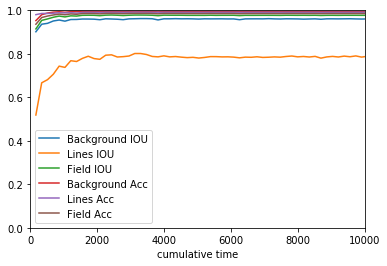

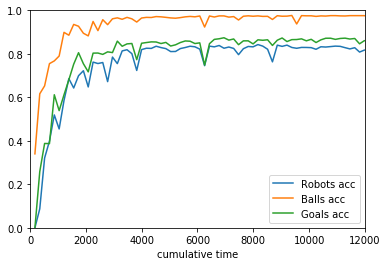

In [19]:
df3 = pd.read_csv('/home/user/jacobs/cudavision/Logs/test_logs_2_670.csv')
show_df_seg(df3)
show_df_det(df3)

# What is the impact of location-dependent layers.
- Type 1: No location-dependent layers.
- Type 2: Shared location-dependent layers.

In [7]:
def experiment4():
    schedule = [{'input_dimension': (3*32*5,4*32*5), 'epoch': 75,'phase': 'thaw', 'mode': 'concurrent'}]

    model_args = {
        'concatenated_bias' : 'shared',
        'concatenated_bias_learnable' : False,
        'added_bias': 'shared',
    }
    args['model_args'] = model_args
    args['size_after_transform'] = schedule[0]['input_dimension']
    model = Net(**args['model_args'],input_dimension = args['size_after_transform']).to(device)
    optimizer = optim.Adam(model.parameters(), 0.001)
    scheduler = CyclicLR(optimizer, base_lr=args['lr'],max_lr=args['max_lr'],cycle_momentum=False)
    epoch = 0

    run_id = 671

    log_loc = os.path.join(working_dir,f'Logs/test_logs_2_{run_id}.csv')
    logger = Logger(run_loc,log_loc,run_id,args)

    resume = False
    if resume == True:
        model.load_state_dict(torch.load(os.path.join(working_dir,f"Models/final_model_{run_id}.pt")))    
    if args['save_model']:
        torch.save(model.state_dict(), os.path.join(working_dir,f"Models/final_model_{run_id}.pt"))
    
    start_time = time.time()

    for phase in schedule:
        print(phase)
        for mode in modes:
            train_dataset[mode] = RobotsDatasetPrecomputed(meta,mode = mode,input_dimension=phase['input_dimension'],device=device,split='train')
            train_loader[mode] = torch.utils.data.DataLoader(train_dataset[mode],batch_size=args['batch_size'], shuffle=True)
            test_dataset[mode] = RobotsDatasetPrecomputed(meta,mode = mode,input_dimension=phase['input_dimension'],device=device,split='test')
            test_loader[mode] = torch.utils.data.DataLoader(test_dataset[mode],batch_size=args['test_batch_size'], shuffle=False)

        model.set_input_dimension(phase['input_dimension'])

        if phase['phase'] == 'freeze':
            model.freeze_encoder()
        else:
            model.unfreeze_encoder()


        for _ in range(phase['epoch']):
            epoch = epoch + 1
            if phase['mode'] == 'concurrent':
                train_concurrent(args, model, device, train_loader[phase['mode']], optimizer, epoch ,logger=logger)
            else: 
                train(args, model, device, train_loader[phase['mode']], optimizer, epoch , mode = phase['mode'],logger=logger)

            test(args, model, device, test_loader['det'], mode = 'det',logger=logger)
            test(args, model, device, test_loader['seg'], mode = 'seg',logger=logger)
            scheduler.step()
            logger.log_data()

            if args['save_model']:
                torch.save(model.state_dict(), os.path.join(working_dir,f"Models/final_model_{run_id}.pt"))
                
    return time.time() - start_time

In [9]:
experiment4()

{'input_dimension': (480, 640), 'epoch': 75, 'phase': 'thaw', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l2*nll(F.log_softmax(output[1]), seg.long()) \


Train Epoch concurrent: 1 [0/6194(0%)]	Loss: 1.831097, time: 0.25527024269104004
Train Epoch concurrent: 1 [100/6194(2%)]	Loss: 0.213319, time: 2.7415802478790283
Train Epoch concurrent: 1 [200/6194(3%)]	Loss: 0.121706, time: 2.7436904907226562
Train Epoch concurrent: 1 [300/6194(5%)]	Loss: 0.101187, time: 2.7456257343292236
Train Epoch concurrent: 1 [400/6194(6%)]	Loss: 0.071803, time: 2.745471715927124
Train Epoch concurrent: 1 [500/6194(8%)]	Loss: 0.081063, time: 2.743959665298462
Train Epoch concurrent: 1 [600/6194(10%)]	Loss: 0.075924, time: 2.746824026107788
Train Epoch concurrent: 1 [700/6194(11%)]	Loss: 0.069535, time: 2.7457504272460938
Train Epoch concurrent: 1 [800/6194(13%)]	Loss: 0.051940, time: 2.751321792602539
Train Epoch concurrent: 1 [900/6194(15%)]	Loss: 0.057365, time: 2.7526872158050537
Train Epoch concurrent: 1 [1000/6194(16%)]	Loss: 0.055671, time: 2.7513413429260254
Train Epoch concurrent: 1 [1100/6194(18%)]	Loss: 0.049385, time: 2.754176616668701
Train Epoch co

Train Epoch concurrent: 2 [3000/6194(48%)]	Loss: 0.014879, time: 2.7571661472320557
Train Epoch concurrent: 2 [3100/6194(50%)]	Loss: 0.020179, time: 2.7640950679779053
Train Epoch concurrent: 2 [3200/6194(52%)]	Loss: 0.025692, time: 2.759739637374878
Train Epoch concurrent: 2 [3300/6194(53%)]	Loss: 0.023166, time: 2.760283946990967
Train Epoch concurrent: 2 [3400/6194(55%)]	Loss: 0.018693, time: 2.7606656551361084
Train Epoch concurrent: 2 [3500/6194(56%)]	Loss: 0.018017, time: 2.758603096008301
Train Epoch concurrent: 2 [3600/6194(58%)]	Loss: 0.016628, time: 2.760530471801758
Train Epoch concurrent: 2 [3700/6194(60%)]	Loss: 0.017179, time: 2.7595138549804688
Train Epoch concurrent: 2 [3800/6194(61%)]	Loss: 0.016578, time: 2.763698101043701
Train Epoch concurrent: 2 [3900/6194(63%)]	Loss: 0.015881, time: 2.762394666671753
Train Epoch concurrent: 2 [4000/6194(65%)]	Loss: 0.023029, time: 2.7573769092559814
Train Epoch concurrent: 2 [4100/6194(66%)]	Loss: 0.017815, time: 2.759382724761963

Train Epoch concurrent: 3 [6000/6194(97%)]	Loss: 0.011082, time: 2.7580642700195312
Train Epoch concurrent: 3 [6100/6194(98%)]	Loss: 0.014435, time: 2.7640254497528076

Test set: det Average loss: 0.0080

Balls: F1: 0.7267, accuracy: 0.5707, recall: 0.9058, precision: 0.6067, FDR: 0.3933,
Goalposts: F1: 0.6258, accuracy: 0.4554, recall: 0.8226, precision: 0.5050, FDR: 0.4950,
Robots: F1: 0.6557, accuracy: 0.4878, recall: 0.7461, precision: 0.5849, FDR: 0.4151,


/home/user/jacobs/cudavision/metric_segmentation.py:51: RuntimeWarning: invalid value encountered in true_divide
  IOU_imagewise[:,i] = true_positives_imagewise[cat]/(true_positives_imagewise[cat] + false_positives_imagewise[cat] + false_negatives_imagewise[cat])



Test set: seg Average loss: 0.0074

Background: IOU: 0.9448, accuracy: 0.9896
Lines: IOU: 0.6610, accuracy: 0.9855
Field: IOU: 0.9629, accuracy: 0.9755
Total: IOU: 0.8562, accuracy: 0.9835
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_671.csv
Train Epoch concurrent: 4 [0/6194(0%)]	Loss: 0.016441, time: 0.2203083038330078
Train Epoch concurrent: 4 [100/6194(2%)]	Loss: 0.013836, time: 2.758382797241211
Train Epoch concurrent: 4 [200/6194(3%)]	Loss: 0.012601, time: 2.7597506046295166
Train Epoch concurrent: 4 [300/6194(5%)]	Loss: 0.014295, time: 2.7604124546051025
Train Epoch concurrent: 4 [400/6194(6%)]	Loss: 0.016032, time: 2.761624574661255
Train Epoch concurrent: 4 [500/6194(8%)]	Loss: 0.012045, time: 2.757094621658325
Train Epoch concurrent: 4 [600/6194(10%)]	Loss: 0.011547, time: 2.758113145828247
Train Epoch concurrent: 4 [700/6194(11%)]	Loss: 0.013284, time: 2.759486675262451
Train Epoch concurrent: 4 [800/6194(13%)]	Loss: 0.013587, time: 2.7599847316741943
Train

Train Epoch concurrent: 5 [2700/6194(44%)]	Loss: 0.008986, time: 2.7607038021087646
Train Epoch concurrent: 5 [2800/6194(45%)]	Loss: 0.010143, time: 2.759845733642578
Train Epoch concurrent: 5 [2900/6194(47%)]	Loss: 0.011844, time: 2.7591910362243652
Train Epoch concurrent: 5 [3000/6194(48%)]	Loss: 0.008482, time: 2.7575860023498535
Train Epoch concurrent: 5 [3100/6194(50%)]	Loss: 0.007908, time: 2.7571215629577637
Train Epoch concurrent: 5 [3200/6194(52%)]	Loss: 0.008434, time: 2.760984420776367
Train Epoch concurrent: 5 [3300/6194(53%)]	Loss: 0.007346, time: 2.757533073425293
Train Epoch concurrent: 5 [3400/6194(55%)]	Loss: 0.008115, time: 2.7619988918304443
Train Epoch concurrent: 5 [3500/6194(56%)]	Loss: 0.010318, time: 2.7585294246673584
Train Epoch concurrent: 5 [3600/6194(58%)]	Loss: 0.011717, time: 2.7607815265655518
Train Epoch concurrent: 5 [3700/6194(60%)]	Loss: 0.009156, time: 2.760465145111084
Train Epoch concurrent: 5 [3800/6194(61%)]	Loss: 0.011700, time: 2.7615191936492

Train Epoch concurrent: 6 [5700/6194(92%)]	Loss: 0.008629, time: 2.761289358139038
Train Epoch concurrent: 6 [5800/6194(94%)]	Loss: 0.006892, time: 2.7624876499176025
Train Epoch concurrent: 6 [5900/6194(95%)]	Loss: 0.007441, time: 2.7602741718292236
Train Epoch concurrent: 6 [6000/6194(97%)]	Loss: 0.007022, time: 2.759697437286377
Train Epoch concurrent: 6 [6100/6194(98%)]	Loss: 0.006814, time: 2.764040470123291

Test set: det Average loss: 0.0044

Balls: F1: 0.9314, accuracy: 0.8716, recall: 0.9807, precision: 0.8868, FDR: 0.1132,
Goalposts: F1: 0.8606, accuracy: 0.7553, recall: 0.9421, precision: 0.7921, FDR: 0.2079,
Robots: F1: 0.8134, accuracy: 0.6855, recall: 0.8799, precision: 0.7563, FDR: 0.2437,

Test set: seg Average loss: 0.0048

Background: IOU: 0.9574, accuracy: 0.9940
Lines: IOU: 0.7467, accuracy: 0.9887
Field: IOU: 0.9741, accuracy: 0.9828
Total: IOU: 0.8927, accuracy: 0.9885
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_671.csv
Train Epoch concurrent: 7

Train Epoch concurrent: 8 [1900/6194(31%)]	Loss: 0.006163, time: 2.761920690536499
Train Epoch concurrent: 8 [2000/6194(32%)]	Loss: 0.005445, time: 2.761953115463257
Train Epoch concurrent: 8 [2100/6194(34%)]	Loss: 0.005659, time: 2.7638087272644043
Train Epoch concurrent: 8 [2200/6194(35%)]	Loss: 0.007081, time: 2.7619786262512207
Train Epoch concurrent: 8 [2300/6194(37%)]	Loss: 0.006780, time: 2.7585904598236084
Train Epoch concurrent: 8 [2400/6194(39%)]	Loss: 0.006121, time: 2.7637112140655518
Train Epoch concurrent: 8 [2500/6194(40%)]	Loss: 0.005015, time: 2.760694980621338
Train Epoch concurrent: 8 [2600/6194(42%)]	Loss: 0.005637, time: 2.7606561183929443
Train Epoch concurrent: 8 [2700/6194(44%)]	Loss: 0.006321, time: 2.7625434398651123
Train Epoch concurrent: 8 [2800/6194(45%)]	Loss: 0.007702, time: 2.7584242820739746
Train Epoch concurrent: 8 [2900/6194(47%)]	Loss: 0.009044, time: 2.761101007461548
Train Epoch concurrent: 8 [3000/6194(48%)]	Loss: 0.008904, time: 2.7602546215057

Train Epoch concurrent: 9 [4900/6194(79%)]	Loss: 0.007642, time: 2.7657053470611572
Train Epoch concurrent: 9 [5000/6194(81%)]	Loss: 0.006890, time: 2.7613186836242676
Train Epoch concurrent: 9 [5100/6194(82%)]	Loss: 0.007885, time: 2.761885166168213
Train Epoch concurrent: 9 [5200/6194(84%)]	Loss: 0.006684, time: 2.762751340866089
Train Epoch concurrent: 9 [5300/6194(85%)]	Loss: 0.007821, time: 2.7577707767486572
Train Epoch concurrent: 9 [5400/6194(87%)]	Loss: 0.011850, time: 2.7611639499664307
Train Epoch concurrent: 9 [5500/6194(89%)]	Loss: 0.006214, time: 2.7665700912475586
Train Epoch concurrent: 9 [5600/6194(90%)]	Loss: 0.007123, time: 2.75982403755188
Train Epoch concurrent: 9 [5700/6194(92%)]	Loss: 0.008420, time: 2.759676933288574
Train Epoch concurrent: 9 [5800/6194(94%)]	Loss: 0.007501, time: 2.7595441341400146
Train Epoch concurrent: 9 [5900/6194(95%)]	Loss: 0.006305, time: 2.760436773300171
Train Epoch concurrent: 9 [6000/6194(97%)]	Loss: 0.006178, time: 2.764333248138427

Train Epoch concurrent: 11 [1000/6194(16%)]	Loss: 0.004754, time: 2.7606112957000732
Train Epoch concurrent: 11 [1100/6194(18%)]	Loss: 0.006259, time: 2.760251760482788
Train Epoch concurrent: 11 [1200/6194(19%)]	Loss: 0.006732, time: 2.7576904296875
Train Epoch concurrent: 11 [1300/6194(21%)]	Loss: 0.007404, time: 2.764413833618164
Train Epoch concurrent: 11 [1400/6194(23%)]	Loss: 0.003654, time: 2.7607500553131104
Train Epoch concurrent: 11 [1500/6194(24%)]	Loss: 0.005428, time: 2.7586722373962402
Train Epoch concurrent: 11 [1600/6194(26%)]	Loss: 0.004930, time: 2.7626733779907227
Train Epoch concurrent: 11 [1700/6194(27%)]	Loss: 0.005224, time: 2.759660243988037
Train Epoch concurrent: 11 [1800/6194(29%)]	Loss: 0.005607, time: 2.7592947483062744
Train Epoch concurrent: 11 [1900/6194(31%)]	Loss: 0.005029, time: 2.7619574069976807
Train Epoch concurrent: 11 [2000/6194(32%)]	Loss: 0.004751, time: 2.7568562030792236
Train Epoch concurrent: 11 [2100/6194(34%)]	Loss: 0.006139, time: 2.759

Train Epoch concurrent: 12 [3900/6194(63%)]	Loss: 0.006897, time: 2.7635717391967773
Train Epoch concurrent: 12 [4000/6194(65%)]	Loss: 0.006413, time: 2.7609291076660156
Train Epoch concurrent: 12 [4100/6194(66%)]	Loss: 0.007177, time: 2.759854316711426
Train Epoch concurrent: 12 [4200/6194(68%)]	Loss: 0.005609, time: 2.75876784324646
Train Epoch concurrent: 12 [4300/6194(69%)]	Loss: 0.008144, time: 2.7592103481292725
Train Epoch concurrent: 12 [4400/6194(71%)]	Loss: 0.005785, time: 2.7625463008880615
Train Epoch concurrent: 12 [4500/6194(73%)]	Loss: 0.006409, time: 2.759676218032837
Train Epoch concurrent: 12 [4600/6194(74%)]	Loss: 0.006790, time: 2.7598066329956055
Train Epoch concurrent: 12 [4700/6194(76%)]	Loss: 0.006315, time: 2.759786605834961
Train Epoch concurrent: 12 [4800/6194(77%)]	Loss: 0.006317, time: 2.7596635818481445
Train Epoch concurrent: 12 [4900/6194(79%)]	Loss: 0.005880, time: 2.765216588973999
Train Epoch concurrent: 12 [5000/6194(81%)]	Loss: 0.006437, time: 2.760

Train Epoch concurrent: 14 [0/6194(0%)]	Loss: 0.004977, time: 0.22281098365783691
Train Epoch concurrent: 14 [100/6194(2%)]	Loss: 0.003758, time: 2.762155532836914
Train Epoch concurrent: 14 [200/6194(3%)]	Loss: 0.003868, time: 2.760164260864258
Train Epoch concurrent: 14 [300/6194(5%)]	Loss: 0.003646, time: 2.7633743286132812
Train Epoch concurrent: 14 [400/6194(6%)]	Loss: 0.004559, time: 2.7616121768951416
Train Epoch concurrent: 14 [500/6194(8%)]	Loss: 0.004915, time: 2.759733200073242
Train Epoch concurrent: 14 [600/6194(10%)]	Loss: 0.003241, time: 2.759972333908081
Train Epoch concurrent: 14 [700/6194(11%)]	Loss: 0.003960, time: 2.7603909969329834
Train Epoch concurrent: 14 [800/6194(13%)]	Loss: 0.003791, time: 2.7612361907958984
Train Epoch concurrent: 14 [900/6194(15%)]	Loss: 0.003926, time: 2.7633602619171143
Train Epoch concurrent: 14 [1000/6194(16%)]	Loss: 0.004137, time: 2.7590818405151367
Train Epoch concurrent: 14 [1100/6194(18%)]	Loss: 0.003715, time: 2.7626662254333496
T

Train Epoch concurrent: 15 [2900/6194(47%)]	Loss: 0.004403, time: 2.7582285404205322
Train Epoch concurrent: 15 [3000/6194(48%)]	Loss: 0.004955, time: 2.7611539363861084
Train Epoch concurrent: 15 [3100/6194(50%)]	Loss: 0.003811, time: 2.76202130317688
Train Epoch concurrent: 15 [3200/6194(52%)]	Loss: 0.004752, time: 2.758476734161377
Train Epoch concurrent: 15 [3300/6194(53%)]	Loss: 0.003559, time: 2.7633261680603027
Train Epoch concurrent: 15 [3400/6194(55%)]	Loss: 0.003926, time: 2.765223264694214
Train Epoch concurrent: 15 [3500/6194(56%)]	Loss: 0.003273, time: 2.7594103813171387
Train Epoch concurrent: 15 [3600/6194(58%)]	Loss: 0.003510, time: 2.760988235473633
Train Epoch concurrent: 15 [3700/6194(60%)]	Loss: 0.004027, time: 2.763742685317993
Train Epoch concurrent: 15 [3800/6194(61%)]	Loss: 0.003652, time: 2.7620396614074707
Train Epoch concurrent: 15 [3900/6194(63%)]	Loss: 0.003535, time: 2.763742685317993
Train Epoch concurrent: 15 [4000/6194(65%)]	Loss: 0.003671, time: 2.7634

Train Epoch concurrent: 16 [5800/6194(94%)]	Loss: 0.006367, time: 2.7634034156799316
Train Epoch concurrent: 16 [5900/6194(95%)]	Loss: 0.004230, time: 2.764639139175415
Train Epoch concurrent: 16 [6000/6194(97%)]	Loss: 0.004971, time: 2.758610963821411
Train Epoch concurrent: 16 [6100/6194(98%)]	Loss: 0.004449, time: 2.7679991722106934

Test set: det Average loss: 0.0026

Balls: F1: 0.9590, accuracy: 0.9211, recall: 0.9932, precision: 0.9270, FDR: 0.0730,
Goalposts: F1: 0.9475, accuracy: 0.9002, recall: 0.9676, precision: 0.9282, FDR: 0.0718,
Robots: F1: 0.9007, accuracy: 0.8193, recall: 0.9456, precision: 0.8598, FDR: 0.1402,

Test set: seg Average loss: 0.0042

Background: IOU: 0.9591, accuracy: 0.9943
Lines: IOU: 0.7936, accuracy: 0.9912
Field: IOU: 0.9777, accuracy: 0.9856
Total: IOU: 0.9101, accuracy: 0.9904
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_671.csv
Train Epoch concurrent: 17 [0/6194(0%)]	Loss: 0.003860, time: 0.2207505702972412
Train Epoch concurrent:

Train Epoch concurrent: 18 [1900/6194(31%)]	Loss: 0.002689, time: 2.762564182281494
Train Epoch concurrent: 18 [2000/6194(32%)]	Loss: 0.003053, time: 2.7587223052978516
Train Epoch concurrent: 18 [2100/6194(34%)]	Loss: 0.002982, time: 2.7638731002807617
Train Epoch concurrent: 18 [2200/6194(35%)]	Loss: 0.002086, time: 2.7627716064453125
Train Epoch concurrent: 18 [2300/6194(37%)]	Loss: 0.003769, time: 2.76027250289917
Train Epoch concurrent: 18 [2400/6194(39%)]	Loss: 0.004182, time: 2.7605645656585693
Train Epoch concurrent: 18 [2500/6194(40%)]	Loss: 0.002782, time: 2.7563791275024414
Train Epoch concurrent: 18 [2600/6194(42%)]	Loss: 0.003156, time: 2.760638952255249
Train Epoch concurrent: 18 [2700/6194(44%)]	Loss: 0.002761, time: 2.7638351917266846
Train Epoch concurrent: 18 [2800/6194(45%)]	Loss: 0.003486, time: 2.759368658065796
Train Epoch concurrent: 18 [2900/6194(47%)]	Loss: 0.003122, time: 2.761570692062378
Train Epoch concurrent: 18 [3000/6194(48%)]	Loss: 0.003092, time: 2.767

Train Epoch concurrent: 19 [4800/6194(77%)]	Loss: 0.002789, time: 2.7638492584228516
Train Epoch concurrent: 19 [4900/6194(79%)]	Loss: 0.002968, time: 2.7633023262023926
Train Epoch concurrent: 19 [5000/6194(81%)]	Loss: 0.002739, time: 2.762667417526245
Train Epoch concurrent: 19 [5100/6194(82%)]	Loss: 0.002478, time: 2.759746789932251
Train Epoch concurrent: 19 [5200/6194(84%)]	Loss: 0.003012, time: 2.7622756958007812
Train Epoch concurrent: 19 [5300/6194(85%)]	Loss: 0.002411, time: 2.761392116546631
Train Epoch concurrent: 19 [5400/6194(87%)]	Loss: 0.002262, time: 2.763148069381714
Train Epoch concurrent: 19 [5500/6194(89%)]	Loss: 0.002306, time: 2.761413335800171
Train Epoch concurrent: 19 [5600/6194(90%)]	Loss: 0.002304, time: 2.7584426403045654
Train Epoch concurrent: 19 [5700/6194(92%)]	Loss: 0.002445, time: 2.7630233764648438
Train Epoch concurrent: 19 [5800/6194(94%)]	Loss: 0.002265, time: 2.762521266937256
Train Epoch concurrent: 19 [5900/6194(95%)]	Loss: 0.002064, time: 2.759

Train Epoch concurrent: 21 [900/6194(15%)]	Loss: 0.001566, time: 2.76124906539917
Train Epoch concurrent: 21 [1000/6194(16%)]	Loss: 0.001956, time: 2.7620456218719482
Train Epoch concurrent: 21 [1100/6194(18%)]	Loss: 0.001905, time: 2.764479875564575
Train Epoch concurrent: 21 [1200/6194(19%)]	Loss: 0.001631, time: 2.7607479095458984
Train Epoch concurrent: 21 [1300/6194(21%)]	Loss: 0.003705, time: 2.7595055103302
Train Epoch concurrent: 21 [1400/6194(23%)]	Loss: 0.002192, time: 2.760788679122925
Train Epoch concurrent: 21 [1500/6194(24%)]	Loss: 0.002334, time: 2.76145076751709
Train Epoch concurrent: 21 [1600/6194(26%)]	Loss: 0.001567, time: 2.76025652885437
Train Epoch concurrent: 21 [1700/6194(27%)]	Loss: 0.002189, time: 2.7646005153656006
Train Epoch concurrent: 21 [1800/6194(29%)]	Loss: 0.002188, time: 2.757673978805542
Train Epoch concurrent: 21 [1900/6194(31%)]	Loss: 0.002054, time: 2.7619965076446533
Train Epoch concurrent: 21 [2000/6194(32%)]	Loss: 0.002627, time: 2.7633483409

Train Epoch concurrent: 22 [3800/6194(61%)]	Loss: 0.001526, time: 2.759340524673462
Train Epoch concurrent: 22 [3900/6194(63%)]	Loss: 0.001635, time: 2.7652435302734375
Train Epoch concurrent: 22 [4000/6194(65%)]	Loss: 0.001555, time: 2.761075735092163
Train Epoch concurrent: 22 [4100/6194(66%)]	Loss: 0.002684, time: 2.7585935592651367
Train Epoch concurrent: 22 [4200/6194(68%)]	Loss: 0.002716, time: 2.7625105381011963
Train Epoch concurrent: 22 [4300/6194(69%)]	Loss: 0.001686, time: 2.7616167068481445
Train Epoch concurrent: 22 [4400/6194(71%)]	Loss: 0.001936, time: 2.7602972984313965
Train Epoch concurrent: 22 [4500/6194(73%)]	Loss: 0.001714, time: 2.7612650394439697
Train Epoch concurrent: 22 [4600/6194(74%)]	Loss: 0.001627, time: 2.759392261505127
Train Epoch concurrent: 22 [4700/6194(76%)]	Loss: 0.001625, time: 2.761882781982422
Train Epoch concurrent: 22 [4800/6194(77%)]	Loss: 0.001761, time: 2.761416435241699
Train Epoch concurrent: 22 [4900/6194(79%)]	Loss: 0.001774, time: 2.76

Train Epoch concurrent: 24 [0/6194(0%)]	Loss: 0.001087, time: 0.21979475021362305
Train Epoch concurrent: 24 [100/6194(2%)]	Loss: 0.001744, time: 2.760985851287842
Train Epoch concurrent: 24 [200/6194(3%)]	Loss: 0.001259, time: 2.7579150199890137
Train Epoch concurrent: 24 [300/6194(5%)]	Loss: 0.002094, time: 2.758716583251953
Train Epoch concurrent: 24 [400/6194(6%)]	Loss: 0.001902, time: 2.7611169815063477
Train Epoch concurrent: 24 [500/6194(8%)]	Loss: 0.002647, time: 2.7609403133392334
Train Epoch concurrent: 24 [600/6194(10%)]	Loss: 0.003718, time: 2.7596147060394287
Train Epoch concurrent: 24 [700/6194(11%)]	Loss: 0.004234, time: 2.760648727416992
Train Epoch concurrent: 24 [800/6194(13%)]	Loss: 0.002986, time: 2.7605223655700684
Train Epoch concurrent: 24 [900/6194(15%)]	Loss: 0.003749, time: 2.7614035606384277
Train Epoch concurrent: 24 [1000/6194(16%)]	Loss: 0.002581, time: 2.7629406452178955
Train Epoch concurrent: 24 [1100/6194(18%)]	Loss: 0.005035, time: 2.758711814880371
T

Train Epoch concurrent: 25 [2900/6194(47%)]	Loss: 0.001308, time: 2.758801221847534
Train Epoch concurrent: 25 [3000/6194(48%)]	Loss: 0.001132, time: 2.758220672607422
Train Epoch concurrent: 25 [3100/6194(50%)]	Loss: 0.001095, time: 2.7588143348693848
Train Epoch concurrent: 25 [3200/6194(52%)]	Loss: 0.001271, time: 2.7597665786743164
Train Epoch concurrent: 25 [3300/6194(53%)]	Loss: 0.001189, time: 2.761113405227661
Train Epoch concurrent: 25 [3400/6194(55%)]	Loss: 0.001125, time: 2.760094404220581
Train Epoch concurrent: 25 [3500/6194(56%)]	Loss: 0.000966, time: 2.75728440284729
Train Epoch concurrent: 25 [3600/6194(58%)]	Loss: 0.002057, time: 2.7611167430877686
Train Epoch concurrent: 25 [3700/6194(60%)]	Loss: 0.001242, time: 2.7593650817871094
Train Epoch concurrent: 25 [3800/6194(61%)]	Loss: 0.001404, time: 2.761122941970825
Train Epoch concurrent: 25 [3900/6194(63%)]	Loss: 0.001717, time: 2.758556842803955
Train Epoch concurrent: 25 [4000/6194(65%)]	Loss: 0.001331, time: 2.75790

Train Epoch concurrent: 26 [5800/6194(94%)]	Loss: 0.000842, time: 2.76151180267334
Train Epoch concurrent: 26 [5900/6194(95%)]	Loss: 0.000930, time: 2.7591629028320312
Train Epoch concurrent: 26 [6000/6194(97%)]	Loss: 0.000735, time: 2.7600021362304688
Train Epoch concurrent: 26 [6100/6194(98%)]	Loss: 0.000870, time: 2.763583183288574

Test set: det Average loss: 0.0023

Balls: F1: 0.9844, accuracy: 0.9693, recall: 0.9940, precision: 0.9750, FDR: 0.0250,
Goalposts: F1: 0.9602, accuracy: 0.9235, recall: 0.9665, precision: 0.9540, FDR: 0.0460,
Robots: F1: 0.9406, accuracy: 0.8878, recall: 0.9569, precision: 0.9248, FDR: 0.0752,

Test set: seg Average loss: 0.0094

Background: IOU: 0.9602, accuracy: 0.9944
Lines: IOU: 0.7849, accuracy: 0.9909
Field: IOU: 0.9772, accuracy: 0.9854
Total: IOU: 0.9074, accuracy: 0.9902
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_671.csv
Train Epoch concurrent: 27 [0/6194(0%)]	Loss: 0.001136, time: 0.21982097625732422
Train Epoch concurrent:

Train Epoch concurrent: 28 [1900/6194(31%)]	Loss: 0.001159, time: 2.761598825454712
Train Epoch concurrent: 28 [2000/6194(32%)]	Loss: 0.000779, time: 2.7600343227386475
Train Epoch concurrent: 28 [2100/6194(34%)]	Loss: 0.001196, time: 2.7576584815979004
Train Epoch concurrent: 28 [2200/6194(35%)]	Loss: 0.000895, time: 2.7621803283691406
Train Epoch concurrent: 28 [2300/6194(37%)]	Loss: 0.001011, time: 2.7630741596221924
Train Epoch concurrent: 28 [2400/6194(39%)]	Loss: 0.001298, time: 2.7598910331726074
Train Epoch concurrent: 28 [2500/6194(40%)]	Loss: 0.000838, time: 2.7617344856262207
Train Epoch concurrent: 28 [2600/6194(42%)]	Loss: 0.001009, time: 2.7558133602142334
Train Epoch concurrent: 28 [2700/6194(44%)]	Loss: 0.001241, time: 2.7605204582214355
Train Epoch concurrent: 28 [2800/6194(45%)]	Loss: 0.000685, time: 2.76162052154541
Train Epoch concurrent: 28 [2900/6194(47%)]	Loss: 0.000843, time: 2.75937819480896
Train Epoch concurrent: 28 [3000/6194(48%)]	Loss: 0.001193, time: 2.76

Train Epoch concurrent: 29 [4800/6194(77%)]	Loss: 0.001135, time: 2.7575998306274414
Train Epoch concurrent: 29 [4900/6194(79%)]	Loss: 0.000766, time: 2.761949300765991
Train Epoch concurrent: 29 [5000/6194(81%)]	Loss: 0.000734, time: 2.7606756687164307
Train Epoch concurrent: 29 [5100/6194(82%)]	Loss: 0.001022, time: 2.756218671798706
Train Epoch concurrent: 29 [5200/6194(84%)]	Loss: 0.000752, time: 2.760406017303467
Train Epoch concurrent: 29 [5300/6194(85%)]	Loss: 0.000858, time: 2.7576026916503906
Train Epoch concurrent: 29 [5400/6194(87%)]	Loss: 0.000720, time: 2.7600045204162598
Train Epoch concurrent: 29 [5500/6194(89%)]	Loss: 0.000714, time: 2.758878707885742
Train Epoch concurrent: 29 [5600/6194(90%)]	Loss: 0.000812, time: 2.7607309818267822
Train Epoch concurrent: 29 [5700/6194(92%)]	Loss: 0.000737, time: 2.765022039413452
Train Epoch concurrent: 29 [5800/6194(94%)]	Loss: 0.000737, time: 2.7604384422302246
Train Epoch concurrent: 29 [5900/6194(95%)]	Loss: 0.000932, time: 2.75

Train Epoch concurrent: 31 [900/6194(15%)]	Loss: 0.000784, time: 2.757246494293213
Train Epoch concurrent: 31 [1000/6194(16%)]	Loss: 0.000738, time: 2.757084846496582
Train Epoch concurrent: 31 [1100/6194(18%)]	Loss: 0.000949, time: 2.759648323059082
Train Epoch concurrent: 31 [1200/6194(19%)]	Loss: 0.000980, time: 2.7574923038482666
Train Epoch concurrent: 31 [1300/6194(21%)]	Loss: 0.000898, time: 2.7599058151245117
Train Epoch concurrent: 31 [1400/6194(23%)]	Loss: 0.003942, time: 2.7603635787963867
Train Epoch concurrent: 31 [1500/6194(24%)]	Loss: 0.008006, time: 2.75630784034729
Train Epoch concurrent: 31 [1600/6194(26%)]	Loss: 0.005598, time: 2.7608871459960938
Train Epoch concurrent: 31 [1700/6194(27%)]	Loss: 0.007871, time: 2.758913278579712
Train Epoch concurrent: 31 [1800/6194(29%)]	Loss: 0.013069, time: 2.7554187774658203
Train Epoch concurrent: 31 [1900/6194(31%)]	Loss: 0.009571, time: 2.756588935852051
Train Epoch concurrent: 31 [2000/6194(32%)]	Loss: 0.008767, time: 2.75459

Train Epoch concurrent: 32 [3800/6194(61%)]	Loss: 0.000880, time: 2.7600529193878174
Train Epoch concurrent: 32 [3900/6194(63%)]	Loss: 0.000670, time: 2.7576229572296143
Train Epoch concurrent: 32 [4000/6194(65%)]	Loss: 0.000708, time: 2.759009838104248
Train Epoch concurrent: 32 [4100/6194(66%)]	Loss: 0.000731, time: 2.7569739818573
Train Epoch concurrent: 32 [4200/6194(68%)]	Loss: 0.000649, time: 2.757317543029785
Train Epoch concurrent: 32 [4300/6194(69%)]	Loss: 0.000723, time: 2.7595624923706055
Train Epoch concurrent: 32 [4400/6194(71%)]	Loss: 0.000534, time: 2.756110668182373
Train Epoch concurrent: 32 [4500/6194(73%)]	Loss: 0.000731, time: 2.7621047496795654
Train Epoch concurrent: 32 [4600/6194(74%)]	Loss: 0.000610, time: 2.7586798667907715
Train Epoch concurrent: 32 [4700/6194(76%)]	Loss: 0.000647, time: 2.756542682647705
Train Epoch concurrent: 32 [4800/6194(77%)]	Loss: 0.000677, time: 2.7555549144744873
Train Epoch concurrent: 32 [4900/6194(79%)]	Loss: 0.000598, time: 2.7560

Train Epoch concurrent: 34 [0/6194(0%)]	Loss: 0.000555, time: 0.22020888328552246
Train Epoch concurrent: 34 [100/6194(2%)]	Loss: 0.000507, time: 2.759058713912964
Train Epoch concurrent: 34 [200/6194(3%)]	Loss: 0.000547, time: 2.756626605987549
Train Epoch concurrent: 34 [300/6194(5%)]	Loss: 0.000955, time: 2.756503105163574
Train Epoch concurrent: 34 [400/6194(6%)]	Loss: 0.000542, time: 2.7580065727233887
Train Epoch concurrent: 34 [500/6194(8%)]	Loss: 0.000650, time: 2.75884747505188
Train Epoch concurrent: 34 [600/6194(10%)]	Loss: 0.000833, time: 2.758728265762329
Train Epoch concurrent: 34 [700/6194(11%)]	Loss: 0.000491, time: 2.758676052093506
Train Epoch concurrent: 34 [800/6194(13%)]	Loss: 0.000649, time: 2.7564423084259033
Train Epoch concurrent: 34 [900/6194(15%)]	Loss: 0.000556, time: 2.756500482559204
Train Epoch concurrent: 34 [1000/6194(16%)]	Loss: 0.000792, time: 2.758552074432373
Train Epoch concurrent: 34 [1100/6194(18%)]	Loss: 0.000457, time: 2.7584588527679443
Train 

Train Epoch concurrent: 35 [2900/6194(47%)]	Loss: 0.001325, time: 2.7553720474243164
Train Epoch concurrent: 35 [3000/6194(48%)]	Loss: 0.000484, time: 2.755218267440796
Train Epoch concurrent: 35 [3100/6194(50%)]	Loss: 0.000554, time: 2.7558677196502686
Train Epoch concurrent: 35 [3200/6194(52%)]	Loss: 0.000545, time: 2.761038064956665
Train Epoch concurrent: 35 [3300/6194(53%)]	Loss: 0.000531, time: 2.758650064468384
Train Epoch concurrent: 35 [3400/6194(55%)]	Loss: 0.000683, time: 2.759874105453491
Train Epoch concurrent: 35 [3500/6194(56%)]	Loss: 0.000597, time: 2.7555737495422363
Train Epoch concurrent: 35 [3600/6194(58%)]	Loss: 0.000503, time: 2.7552597522735596
Train Epoch concurrent: 35 [3700/6194(60%)]	Loss: 0.000513, time: 2.756978988647461
Train Epoch concurrent: 35 [3800/6194(61%)]	Loss: 0.000669, time: 2.7580041885375977
Train Epoch concurrent: 35 [3900/6194(63%)]	Loss: 0.001102, time: 2.7580885887145996
Train Epoch concurrent: 35 [4000/6194(65%)]	Loss: 0.000576, time: 2.75

Train Epoch concurrent: 36 [5800/6194(94%)]	Loss: 0.000646, time: 2.760566234588623
Train Epoch concurrent: 36 [5900/6194(95%)]	Loss: 0.000708, time: 2.7589781284332275
Train Epoch concurrent: 36 [6000/6194(97%)]	Loss: 0.000620, time: 2.7574355602264404
Train Epoch concurrent: 36 [6100/6194(98%)]	Loss: 0.000614, time: 2.760047197341919

Test set: det Average loss: 0.0021

Balls: F1: 0.9850, accuracy: 0.9704, recall: 0.9960, precision: 0.9742, FDR: 0.0258,
Goalposts: F1: 0.9555, accuracy: 0.9148, recall: 0.9663, precision: 0.9450, FDR: 0.0550,
Robots: F1: 0.9305, accuracy: 0.8700, recall: 0.9502, precision: 0.9115, FDR: 0.0885,

Test set: seg Average loss: 0.0110

Background: IOU: 0.9589, accuracy: 0.9941
Lines: IOU: 0.7851, accuracy: 0.9909
Field: IOU: 0.9767, accuracy: 0.9850
Total: IOU: 0.9069, accuracy: 0.9900
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_671.csv
Train Epoch concurrent: 37 [0/6194(0%)]	Loss: 0.000656, time: 0.22019553184509277
Train Epoch concurrent

Train Epoch concurrent: 38 [1900/6194(31%)]	Loss: 0.000490, time: 2.761780023574829
Train Epoch concurrent: 38 [2000/6194(32%)]	Loss: 0.000561, time: 2.7559826374053955
Train Epoch concurrent: 38 [2100/6194(34%)]	Loss: 0.000722, time: 2.7595841884613037
Train Epoch concurrent: 38 [2200/6194(35%)]	Loss: 0.000544, time: 2.7598319053649902
Train Epoch concurrent: 38 [2300/6194(37%)]	Loss: 0.000507, time: 2.7625434398651123
Train Epoch concurrent: 38 [2400/6194(39%)]	Loss: 0.000763, time: 2.7581567764282227
Train Epoch concurrent: 38 [2500/6194(40%)]	Loss: 0.000678, time: 2.7577064037323
Train Epoch concurrent: 38 [2600/6194(42%)]	Loss: 0.000849, time: 2.7547686100006104
Train Epoch concurrent: 38 [2700/6194(44%)]	Loss: 0.000566, time: 2.75901198387146
Train Epoch concurrent: 38 [2800/6194(45%)]	Loss: 0.000625, time: 2.75827693939209
Train Epoch concurrent: 38 [2900/6194(47%)]	Loss: 0.000687, time: 2.7559452056884766
Train Epoch concurrent: 38 [3000/6194(48%)]	Loss: 0.000617, time: 2.75854

Train Epoch concurrent: 39 [4800/6194(77%)]	Loss: 0.000498, time: 2.752436876296997
Train Epoch concurrent: 39 [4900/6194(79%)]	Loss: 0.000540, time: 2.7563326358795166
Train Epoch concurrent: 39 [5000/6194(81%)]	Loss: 0.000532, time: 2.757047414779663
Train Epoch concurrent: 39 [5100/6194(82%)]	Loss: 0.000514, time: 2.7581727504730225
Train Epoch concurrent: 39 [5200/6194(84%)]	Loss: 0.000592, time: 2.757089614868164
Train Epoch concurrent: 39 [5300/6194(85%)]	Loss: 0.000611, time: 2.757689952850342
Train Epoch concurrent: 39 [5400/6194(87%)]	Loss: 0.000655, time: 2.7527194023132324
Train Epoch concurrent: 39 [5500/6194(89%)]	Loss: 0.000661, time: 2.7545864582061768
Train Epoch concurrent: 39 [5600/6194(90%)]	Loss: 0.000732, time: 2.757995128631592
Train Epoch concurrent: 39 [5700/6194(92%)]	Loss: 0.000475, time: 2.758686065673828
Train Epoch concurrent: 39 [5800/6194(94%)]	Loss: 0.000537, time: 2.7573912143707275
Train Epoch concurrent: 39 [5900/6194(95%)]	Loss: 0.000795, time: 2.754

Train Epoch concurrent: 41 [900/6194(15%)]	Loss: 0.000780, time: 2.7589590549468994
Train Epoch concurrent: 41 [1000/6194(16%)]	Loss: 0.000822, time: 2.760624408721924
Train Epoch concurrent: 41 [1100/6194(18%)]	Loss: 0.000710, time: 2.754446506500244
Train Epoch concurrent: 41 [1200/6194(19%)]	Loss: 0.000698, time: 2.760118246078491
Train Epoch concurrent: 41 [1300/6194(21%)]	Loss: 0.000879, time: 2.7579214572906494
Train Epoch concurrent: 41 [1400/6194(23%)]	Loss: 0.000652, time: 2.7531731128692627
Train Epoch concurrent: 41 [1500/6194(24%)]	Loss: 0.000512, time: 2.7565248012542725
Train Epoch concurrent: 41 [1600/6194(26%)]	Loss: 0.000584, time: 2.7517471313476562
Train Epoch concurrent: 41 [1700/6194(27%)]	Loss: 0.000644, time: 2.7558109760284424
Train Epoch concurrent: 41 [1800/6194(29%)]	Loss: 0.000717, time: 2.756361246109009
Train Epoch concurrent: 41 [1900/6194(31%)]	Loss: 0.000675, time: 2.7550477981567383
Train Epoch concurrent: 41 [2000/6194(32%)]	Loss: 0.000528, time: 2.75

Train Epoch concurrent: 42 [3800/6194(61%)]	Loss: 0.000538, time: 2.7537028789520264
Train Epoch concurrent: 42 [3900/6194(63%)]	Loss: 0.000608, time: 2.7537646293640137
Train Epoch concurrent: 42 [4000/6194(65%)]	Loss: 0.000537, time: 2.756767749786377
Train Epoch concurrent: 42 [4100/6194(66%)]	Loss: 0.000634, time: 2.7543413639068604
Train Epoch concurrent: 42 [4200/6194(68%)]	Loss: 0.000556, time: 2.7543604373931885
Train Epoch concurrent: 42 [4300/6194(69%)]	Loss: 0.000580, time: 2.754276990890503
Train Epoch concurrent: 42 [4400/6194(71%)]	Loss: 0.000425, time: 2.7530064582824707
Train Epoch concurrent: 42 [4500/6194(73%)]	Loss: 0.000568, time: 2.7559685707092285
Train Epoch concurrent: 42 [4600/6194(74%)]	Loss: 0.000600, time: 2.7564401626586914
Train Epoch concurrent: 42 [4700/6194(76%)]	Loss: 0.000516, time: 2.7541122436523438
Train Epoch concurrent: 42 [4800/6194(77%)]	Loss: 0.000440, time: 2.758366823196411
Train Epoch concurrent: 42 [4900/6194(79%)]	Loss: 0.000565, time: 2.

Train Epoch concurrent: 44 [0/6194(0%)]	Loss: 0.000564, time: 0.22171902656555176
Train Epoch concurrent: 44 [100/6194(2%)]	Loss: 0.000577, time: 2.7594900131225586
Train Epoch concurrent: 44 [200/6194(3%)]	Loss: 0.000709, time: 2.7577598094940186
Train Epoch concurrent: 44 [300/6194(5%)]	Loss: 0.000555, time: 2.7575199604034424
Train Epoch concurrent: 44 [400/6194(6%)]	Loss: 0.000855, time: 2.7586076259613037
Train Epoch concurrent: 44 [500/6194(8%)]	Loss: 0.000686, time: 2.7565500736236572
Train Epoch concurrent: 44 [600/6194(10%)]	Loss: 0.000701, time: 2.7592506408691406
Train Epoch concurrent: 44 [700/6194(11%)]	Loss: 0.000549, time: 2.756556272506714
Train Epoch concurrent: 44 [800/6194(13%)]	Loss: 0.000454, time: 2.7586519718170166
Train Epoch concurrent: 44 [900/6194(15%)]	Loss: 0.000419, time: 2.7574331760406494
Train Epoch concurrent: 44 [1000/6194(16%)]	Loss: 0.000497, time: 2.757201671600342
Train Epoch concurrent: 44 [1100/6194(18%)]	Loss: 0.000408, time: 2.7573940753936768

Train Epoch concurrent: 45 [2900/6194(47%)]	Loss: 0.000438, time: 2.7568886280059814
Train Epoch concurrent: 45 [3000/6194(48%)]	Loss: 0.000460, time: 2.757479667663574
Train Epoch concurrent: 45 [3100/6194(50%)]	Loss: 0.000424, time: 2.757523775100708
Train Epoch concurrent: 45 [3200/6194(52%)]	Loss: 0.000467, time: 2.7542507648468018
Train Epoch concurrent: 45 [3300/6194(53%)]	Loss: 0.000509, time: 2.7561330795288086
Train Epoch concurrent: 45 [3400/6194(55%)]	Loss: 0.000851, time: 2.756727457046509
Train Epoch concurrent: 45 [3500/6194(56%)]	Loss: 0.000436, time: 2.757288932800293
Train Epoch concurrent: 45 [3600/6194(58%)]	Loss: 0.000447, time: 2.755894660949707
Train Epoch concurrent: 45 [3700/6194(60%)]	Loss: 0.000447, time: 2.7581188678741455
Train Epoch concurrent: 45 [3800/6194(61%)]	Loss: 0.000454, time: 2.757505178451538
Train Epoch concurrent: 45 [3900/6194(63%)]	Loss: 0.000813, time: 2.7586326599121094
Train Epoch concurrent: 45 [4000/6194(65%)]	Loss: 0.000489, time: 2.758

Train Epoch concurrent: 46 [5800/6194(94%)]	Loss: 0.000478, time: 2.7572200298309326
Train Epoch concurrent: 46 [5900/6194(95%)]	Loss: 0.000465, time: 2.7562289237976074
Train Epoch concurrent: 46 [6000/6194(97%)]	Loss: 0.000657, time: 2.7552502155303955
Train Epoch concurrent: 46 [6100/6194(98%)]	Loss: 0.000489, time: 2.755354642868042

Test set: det Average loss: 0.0021

Balls: F1: 0.9831, accuracy: 0.9668, recall: 0.9968, precision: 0.9698, FDR: 0.0302,
Goalposts: F1: 0.9559, accuracy: 0.9155, recall: 0.9637, precision: 0.9482, FDR: 0.0518,
Robots: F1: 0.9275, accuracy: 0.8649, recall: 0.9515, precision: 0.9048, FDR: 0.0952,

Test set: seg Average loss: 0.0116

Background: IOU: 0.9583, accuracy: 0.9938
Lines: IOU: 0.7873, accuracy: 0.9910
Field: IOU: 0.9763, accuracy: 0.9849
Total: IOU: 0.9073, accuracy: 0.9899
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_671.csv
Train Epoch concurrent: 47 [0/6194(0%)]	Loss: 0.000648, time: 0.22217154502868652
Train Epoch concurren

Train Epoch concurrent: 48 [1800/6194(29%)]	Loss: 0.000471, time: 2.7538301944732666
Train Epoch concurrent: 48 [1900/6194(31%)]	Loss: 0.000362, time: 2.7573633193969727
Train Epoch concurrent: 48 [2000/6194(32%)]	Loss: 0.000444, time: 2.7552411556243896
Train Epoch concurrent: 48 [2100/6194(34%)]	Loss: 0.000448, time: 2.7536280155181885
Train Epoch concurrent: 48 [2200/6194(35%)]	Loss: 0.000477, time: 2.7566843032836914
Train Epoch concurrent: 48 [2300/6194(37%)]	Loss: 0.000469, time: 2.7552592754364014
Train Epoch concurrent: 48 [2400/6194(39%)]	Loss: 0.000461, time: 2.7555432319641113
Train Epoch concurrent: 48 [2500/6194(40%)]	Loss: 0.000403, time: 2.7583792209625244
Train Epoch concurrent: 48 [2600/6194(42%)]	Loss: 0.000438, time: 2.753971815109253
Train Epoch concurrent: 48 [2700/6194(44%)]	Loss: 0.000404, time: 2.755955934524536
Train Epoch concurrent: 48 [2800/6194(45%)]	Loss: 0.000523, time: 2.758911609649658
Train Epoch concurrent: 48 [2900/6194(47%)]	Loss: 0.000426, time: 2.

Train Epoch concurrent: 49 [4700/6194(76%)]	Loss: 0.000390, time: 2.7596282958984375
Train Epoch concurrent: 49 [4800/6194(77%)]	Loss: 0.001216, time: 2.7610349655151367
Train Epoch concurrent: 49 [4900/6194(79%)]	Loss: 0.000385, time: 2.7548227310180664
Train Epoch concurrent: 49 [5000/6194(81%)]	Loss: 0.000413, time: 2.757373332977295
Train Epoch concurrent: 49 [5100/6194(82%)]	Loss: 0.000421, time: 2.75770902633667
Train Epoch concurrent: 49 [5200/6194(84%)]	Loss: 0.000384, time: 2.757641315460205
Train Epoch concurrent: 49 [5300/6194(85%)]	Loss: 0.000426, time: 2.759995222091675
Train Epoch concurrent: 49 [5400/6194(87%)]	Loss: 0.000551, time: 2.7583703994750977
Train Epoch concurrent: 49 [5500/6194(89%)]	Loss: 0.000537, time: 2.757282257080078
Train Epoch concurrent: 49 [5600/6194(90%)]	Loss: 0.000439, time: 2.7592034339904785
Train Epoch concurrent: 49 [5700/6194(92%)]	Loss: 0.000781, time: 2.7563323974609375
Train Epoch concurrent: 49 [5800/6194(94%)]	Loss: 0.000478, time: 2.761

Train Epoch concurrent: 51 [800/6194(13%)]	Loss: 0.000487, time: 2.7641537189483643
Train Epoch concurrent: 51 [900/6194(15%)]	Loss: 0.000524, time: 2.75384783744812
Train Epoch concurrent: 51 [1000/6194(16%)]	Loss: 0.000449, time: 2.753178834915161
Train Epoch concurrent: 51 [1100/6194(18%)]	Loss: 0.000749, time: 2.7556211948394775
Train Epoch concurrent: 51 [1200/6194(19%)]	Loss: 0.000396, time: 2.752589225769043
Train Epoch concurrent: 51 [1300/6194(21%)]	Loss: 0.000386, time: 2.75788950920105
Train Epoch concurrent: 51 [1400/6194(23%)]	Loss: 0.000507, time: 2.7584595680236816
Train Epoch concurrent: 51 [1500/6194(24%)]	Loss: 0.000465, time: 2.7550289630889893
Train Epoch concurrent: 51 [1600/6194(26%)]	Loss: 0.000540, time: 2.7567858695983887
Train Epoch concurrent: 51 [1700/6194(27%)]	Loss: 0.000574, time: 2.756620168685913
Train Epoch concurrent: 51 [1800/6194(29%)]	Loss: 0.000406, time: 2.7546184062957764
Train Epoch concurrent: 51 [1900/6194(31%)]	Loss: 0.000451, time: 2.760385

Train Epoch concurrent: 52 [3700/6194(60%)]	Loss: 0.000383, time: 2.75666880607605
Train Epoch concurrent: 52 [3800/6194(61%)]	Loss: 0.000431, time: 2.756340503692627
Train Epoch concurrent: 52 [3900/6194(63%)]	Loss: 0.000460, time: 2.757422924041748
Train Epoch concurrent: 52 [4000/6194(65%)]	Loss: 0.000370, time: 2.756227970123291
Train Epoch concurrent: 52 [4100/6194(66%)]	Loss: 0.000386, time: 2.7607600688934326
Train Epoch concurrent: 52 [4200/6194(68%)]	Loss: 0.000536, time: 2.7554733753204346
Train Epoch concurrent: 52 [4300/6194(69%)]	Loss: 0.000355, time: 2.7554588317871094
Train Epoch concurrent: 52 [4400/6194(71%)]	Loss: 0.000392, time: 2.7569525241851807
Train Epoch concurrent: 52 [4500/6194(73%)]	Loss: 0.000490, time: 2.7564797401428223
Train Epoch concurrent: 52 [4600/6194(74%)]	Loss: 0.000466, time: 2.7563629150390625
Train Epoch concurrent: 52 [4700/6194(76%)]	Loss: 0.000348, time: 2.761420249938965
Train Epoch concurrent: 52 [4800/6194(77%)]	Loss: 0.000357, time: 2.756

Train Epoch concurrent: 54 [0/6194(0%)]	Loss: 0.000353, time: 0.2194373607635498
Train Epoch concurrent: 54 [100/6194(2%)]	Loss: 0.000448, time: 2.7507922649383545
Train Epoch concurrent: 54 [200/6194(3%)]	Loss: 0.000344, time: 2.7528576850891113
Train Epoch concurrent: 54 [300/6194(5%)]	Loss: 0.000352, time: 2.7529070377349854
Train Epoch concurrent: 54 [400/6194(6%)]	Loss: 0.000406, time: 2.7532875537872314
Train Epoch concurrent: 54 [500/6194(8%)]	Loss: 0.000412, time: 2.7515347003936768
Train Epoch concurrent: 54 [600/6194(10%)]	Loss: 0.000337, time: 2.7506871223449707
Train Epoch concurrent: 54 [700/6194(11%)]	Loss: 0.000431, time: 2.751207113265991
Train Epoch concurrent: 54 [800/6194(13%)]	Loss: 0.000450, time: 2.7524516582489014
Train Epoch concurrent: 54 [900/6194(15%)]	Loss: 0.000453, time: 2.7511167526245117
Train Epoch concurrent: 54 [1000/6194(16%)]	Loss: 0.000378, time: 2.7507779598236084
Train Epoch concurrent: 54 [1100/6194(18%)]	Loss: 0.000425, time: 2.7525556087493896

Train Epoch concurrent: 55 [2900/6194(47%)]	Loss: 0.000448, time: 2.751817464828491
Train Epoch concurrent: 55 [3000/6194(48%)]	Loss: 0.000365, time: 2.753385543823242
Train Epoch concurrent: 55 [3100/6194(50%)]	Loss: 0.000778, time: 2.7579522132873535
Train Epoch concurrent: 55 [3200/6194(52%)]	Loss: 0.000464, time: 2.7527191638946533
Train Epoch concurrent: 55 [3300/6194(53%)]	Loss: 0.000314, time: 2.754819869995117
Train Epoch concurrent: 55 [3400/6194(55%)]	Loss: 0.000425, time: 2.7559847831726074
Train Epoch concurrent: 55 [3500/6194(56%)]	Loss: 0.000387, time: 2.7514517307281494
Train Epoch concurrent: 55 [3600/6194(58%)]	Loss: 0.000372, time: 2.756068229675293
Train Epoch concurrent: 55 [3700/6194(60%)]	Loss: 0.000364, time: 2.756537675857544
Train Epoch concurrent: 55 [3800/6194(61%)]	Loss: 0.000479, time: 2.753267288208008
Train Epoch concurrent: 55 [3900/6194(63%)]	Loss: 0.000391, time: 2.7556943893432617
Train Epoch concurrent: 55 [4000/6194(65%)]	Loss: 0.000385, time: 2.750

Train Epoch concurrent: 56 [5800/6194(94%)]	Loss: 0.000398, time: 2.7502007484436035
Train Epoch concurrent: 56 [5900/6194(95%)]	Loss: 0.000337, time: 2.7526113986968994
Train Epoch concurrent: 56 [6000/6194(97%)]	Loss: 0.000404, time: 2.7573165893554688
Train Epoch concurrent: 56 [6100/6194(98%)]	Loss: 0.000952, time: 2.7500128746032715

Test set: det Average loss: 0.0021

Balls: F1: 0.9858, accuracy: 0.9720, recall: 0.9960, precision: 0.9758, FDR: 0.0242,
Goalposts: F1: 0.9554, accuracy: 0.9146, recall: 0.9639, precision: 0.9470, FDR: 0.0530,
Robots: F1: 0.9306, accuracy: 0.8703, recall: 0.9451, precision: 0.9166, FDR: 0.0834,

Test set: seg Average loss: 0.0123

Background: IOU: 0.9591, accuracy: 0.9940
Lines: IOU: 0.7865, accuracy: 0.9910
Field: IOU: 0.9767, accuracy: 0.9851
Total: IOU: 0.9075, accuracy: 0.9901
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_671.csv
Train Epoch concurrent: 57 [0/6194(0%)]	Loss: 0.000396, time: 0.22182345390319824
Train Epoch concurre

Train Epoch concurrent: 58 [1900/6194(31%)]	Loss: 0.000454, time: 2.755871057510376
Train Epoch concurrent: 58 [2000/6194(32%)]	Loss: 0.000457, time: 2.752397298812866
Train Epoch concurrent: 58 [2100/6194(34%)]	Loss: 0.000512, time: 2.752875804901123
Train Epoch concurrent: 58 [2200/6194(35%)]	Loss: 0.000342, time: 2.752126693725586
Train Epoch concurrent: 58 [2300/6194(37%)]	Loss: 0.000441, time: 2.750927209854126
Train Epoch concurrent: 58 [2400/6194(39%)]	Loss: 0.000403, time: 2.7538812160491943
Train Epoch concurrent: 58 [2500/6194(40%)]	Loss: 0.000488, time: 2.75193452835083
Train Epoch concurrent: 58 [2600/6194(42%)]	Loss: 0.000338, time: 2.754607915878296
Train Epoch concurrent: 58 [2700/6194(44%)]	Loss: 0.000384, time: 2.753506898880005
Train Epoch concurrent: 58 [2800/6194(45%)]	Loss: 0.000413, time: 2.7506444454193115
Train Epoch concurrent: 58 [2900/6194(47%)]	Loss: 0.000476, time: 2.750175714492798
Train Epoch concurrent: 58 [3000/6194(48%)]	Loss: 0.000391, time: 2.7516822

Train Epoch concurrent: 59 [4800/6194(77%)]	Loss: 0.000496, time: 2.7552177906036377
Train Epoch concurrent: 59 [4900/6194(79%)]	Loss: 0.000414, time: 2.754645824432373
Train Epoch concurrent: 59 [5000/6194(81%)]	Loss: 0.000387, time: 2.754720687866211
Train Epoch concurrent: 59 [5100/6194(82%)]	Loss: 0.000469, time: 2.7539825439453125
Train Epoch concurrent: 59 [5200/6194(84%)]	Loss: 0.000359, time: 2.7540860176086426
Train Epoch concurrent: 59 [5300/6194(85%)]	Loss: 0.000386, time: 2.754128932952881
Train Epoch concurrent: 59 [5400/6194(87%)]	Loss: 0.000434, time: 2.752119541168213
Train Epoch concurrent: 59 [5500/6194(89%)]	Loss: 0.000403, time: 2.7532973289489746
Train Epoch concurrent: 59 [5600/6194(90%)]	Loss: 0.000425, time: 2.7549660205841064
Train Epoch concurrent: 59 [5700/6194(92%)]	Loss: 0.000400, time: 2.753849506378174
Train Epoch concurrent: 59 [5800/6194(94%)]	Loss: 0.000373, time: 2.7528319358825684
Train Epoch concurrent: 59 [5900/6194(95%)]	Loss: 0.000393, time: 2.75

Train Epoch concurrent: 61 [900/6194(15%)]	Loss: 0.000369, time: 2.7538228034973145
Train Epoch concurrent: 61 [1000/6194(16%)]	Loss: 0.000415, time: 2.754305839538574
Train Epoch concurrent: 61 [1100/6194(18%)]	Loss: 0.000667, time: 2.7495927810668945
Train Epoch concurrent: 61 [1200/6194(19%)]	Loss: 0.000391, time: 2.753795862197876
Train Epoch concurrent: 61 [1300/6194(21%)]	Loss: 0.000416, time: 2.7494075298309326
Train Epoch concurrent: 61 [1400/6194(23%)]	Loss: 0.000346, time: 2.7509055137634277
Train Epoch concurrent: 61 [1500/6194(24%)]	Loss: 0.000450, time: 2.753735065460205
Train Epoch concurrent: 61 [1600/6194(26%)]	Loss: 0.000404, time: 2.7512316703796387
Train Epoch concurrent: 61 [1700/6194(27%)]	Loss: 0.000437, time: 2.7514801025390625
Train Epoch concurrent: 61 [1800/6194(29%)]	Loss: 0.000379, time: 2.753934144973755
Train Epoch concurrent: 61 [1900/6194(31%)]	Loss: 0.000366, time: 2.751187324523926
Train Epoch concurrent: 61 [2000/6194(32%)]	Loss: 0.000381, time: 2.752

Train Epoch concurrent: 62 [3800/6194(61%)]	Loss: 0.000373, time: 2.7566111087799072
Train Epoch concurrent: 62 [3900/6194(63%)]	Loss: 0.000361, time: 2.7548437118530273
Train Epoch concurrent: 62 [4000/6194(65%)]	Loss: 0.000377, time: 2.7518577575683594
Train Epoch concurrent: 62 [4100/6194(66%)]	Loss: 0.000353, time: 2.7525806427001953
Train Epoch concurrent: 62 [4200/6194(68%)]	Loss: 0.000576, time: 2.755122184753418
Train Epoch concurrent: 62 [4300/6194(69%)]	Loss: 0.000345, time: 2.749805212020874
Train Epoch concurrent: 62 [4400/6194(71%)]	Loss: 0.000351, time: 2.755955219268799
Train Epoch concurrent: 62 [4500/6194(73%)]	Loss: 0.000455, time: 2.7515645027160645
Train Epoch concurrent: 62 [4600/6194(74%)]	Loss: 0.000340, time: 2.752880573272705
Train Epoch concurrent: 62 [4700/6194(76%)]	Loss: 0.000342, time: 2.753938913345337
Train Epoch concurrent: 62 [4800/6194(77%)]	Loss: 0.000372, time: 2.7525837421417236
Train Epoch concurrent: 62 [4900/6194(79%)]	Loss: 0.000380, time: 2.75

Train Epoch concurrent: 64 [0/6194(0%)]	Loss: 0.000414, time: 0.2220141887664795
Train Epoch concurrent: 64 [100/6194(2%)]	Loss: 0.000483, time: 2.7525217533111572
Train Epoch concurrent: 64 [200/6194(3%)]	Loss: 0.000403, time: 2.753915309906006
Train Epoch concurrent: 64 [300/6194(5%)]	Loss: 0.000351, time: 2.7546310424804688
Train Epoch concurrent: 64 [400/6194(6%)]	Loss: 0.000375, time: 2.75130033493042
Train Epoch concurrent: 64 [500/6194(8%)]	Loss: 0.000467, time: 2.7551088333129883
Train Epoch concurrent: 64 [600/6194(10%)]	Loss: 0.000412, time: 2.7533082962036133
Train Epoch concurrent: 64 [700/6194(11%)]	Loss: 0.000954, time: 2.751544237136841
Train Epoch concurrent: 64 [800/6194(13%)]	Loss: 0.000396, time: 2.7547380924224854
Train Epoch concurrent: 64 [900/6194(15%)]	Loss: 0.000382, time: 2.750023603439331
Train Epoch concurrent: 64 [1000/6194(16%)]	Loss: 0.000380, time: 2.752917528152466
Train Epoch concurrent: 64 [1100/6194(18%)]	Loss: 0.000411, time: 2.7536725997924805
Trai

Train Epoch concurrent: 65 [2900/6194(47%)]	Loss: 0.000409, time: 2.7552640438079834
Train Epoch concurrent: 65 [3000/6194(48%)]	Loss: 0.000351, time: 2.7539634704589844
Train Epoch concurrent: 65 [3100/6194(50%)]	Loss: 0.000335, time: 2.7577781677246094
Train Epoch concurrent: 65 [3200/6194(52%)]	Loss: 0.000383, time: 2.7535603046417236
Train Epoch concurrent: 65 [3300/6194(53%)]	Loss: 0.000395, time: 2.7530932426452637
Train Epoch concurrent: 65 [3400/6194(55%)]	Loss: 0.000308, time: 2.7566750049591064
Train Epoch concurrent: 65 [3500/6194(56%)]	Loss: 0.000362, time: 2.7527737617492676
Train Epoch concurrent: 65 [3600/6194(58%)]	Loss: 0.000344, time: 2.752624034881592
Train Epoch concurrent: 65 [3700/6194(60%)]	Loss: 0.000919, time: 2.753296375274658
Train Epoch concurrent: 65 [3800/6194(61%)]	Loss: 0.000345, time: 2.7518670558929443
Train Epoch concurrent: 65 [3900/6194(63%)]	Loss: 0.000361, time: 2.7530884742736816
Train Epoch concurrent: 65 [4000/6194(65%)]	Loss: 0.000324, time: 2

Train Epoch concurrent: 66 [5800/6194(94%)]	Loss: 0.000347, time: 2.7560064792633057
Train Epoch concurrent: 66 [5900/6194(95%)]	Loss: 0.000321, time: 2.751497983932495
Train Epoch concurrent: 66 [6000/6194(97%)]	Loss: 0.000388, time: 2.7546024322509766
Train Epoch concurrent: 66 [6100/6194(98%)]	Loss: 0.000388, time: 2.752293109893799

Test set: det Average loss: 0.0020

Balls: F1: 0.9871, accuracy: 0.9745, recall: 0.9968, precision: 0.9776, FDR: 0.0224,
Goalposts: F1: 0.9574, accuracy: 0.9183, recall: 0.9662, precision: 0.9488, FDR: 0.0512,
Robots: F1: 0.9300, accuracy: 0.8692, recall: 0.9437, precision: 0.9167, FDR: 0.0833,

Test set: seg Average loss: 0.0124

Background: IOU: 0.9585, accuracy: 0.9939
Lines: IOU: 0.7861, accuracy: 0.9910
Field: IOU: 0.9764, accuracy: 0.9850
Total: IOU: 0.9070, accuracy: 0.9900
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_671.csv
Train Epoch concurrent: 67 [0/6194(0%)]	Loss: 0.000333, time: 0.21903467178344727
Train Epoch concurrent

Train Epoch concurrent: 68 [1900/6194(31%)]	Loss: 0.000359, time: 2.752985954284668
Train Epoch concurrent: 68 [2000/6194(32%)]	Loss: 0.000345, time: 2.751040458679199
Train Epoch concurrent: 68 [2100/6194(34%)]	Loss: 0.000356, time: 2.7551698684692383
Train Epoch concurrent: 68 [2200/6194(35%)]	Loss: 0.000383, time: 2.7522504329681396
Train Epoch concurrent: 68 [2300/6194(37%)]	Loss: 0.000356, time: 2.753514051437378
Train Epoch concurrent: 68 [2400/6194(39%)]	Loss: 0.000349, time: 2.7524869441986084
Train Epoch concurrent: 68 [2500/6194(40%)]	Loss: 0.000408, time: 2.7502613067626953
Train Epoch concurrent: 68 [2600/6194(42%)]	Loss: 0.000338, time: 2.749262571334839
Train Epoch concurrent: 68 [2700/6194(44%)]	Loss: 0.000423, time: 2.7550747394561768
Train Epoch concurrent: 68 [2800/6194(45%)]	Loss: 0.001066, time: 2.764070510864258
Train Epoch concurrent: 68 [2900/6194(47%)]	Loss: 0.000343, time: 2.760688543319702
Train Epoch concurrent: 68 [3000/6194(48%)]	Loss: 0.000417, time: 2.841

Train Epoch concurrent: 69 [4800/6194(77%)]	Loss: 0.000311, time: 3.537705421447754
Train Epoch concurrent: 69 [4900/6194(79%)]	Loss: 0.000318, time: 3.490030288696289
Train Epoch concurrent: 69 [5000/6194(81%)]	Loss: 0.000332, time: 3.5381853580474854
Train Epoch concurrent: 69 [5100/6194(82%)]	Loss: 0.000420, time: 3.6644582748413086
Train Epoch concurrent: 69 [5200/6194(84%)]	Loss: 0.000329, time: 3.6362528800964355
Train Epoch concurrent: 69 [5300/6194(85%)]	Loss: 0.000350, time: 3.6428513526916504
Train Epoch concurrent: 69 [5400/6194(87%)]	Loss: 0.000376, time: 3.6064260005950928
Train Epoch concurrent: 69 [5500/6194(89%)]	Loss: 0.000300, time: 3.59281587600708
Train Epoch concurrent: 69 [5600/6194(90%)]	Loss: 0.000321, time: 3.561131477355957
Train Epoch concurrent: 69 [5700/6194(92%)]	Loss: 0.000309, time: 3.468698501586914
Train Epoch concurrent: 69 [5800/6194(94%)]	Loss: 0.000322, time: 3.4892663955688477
Train Epoch concurrent: 69 [5900/6194(95%)]	Loss: 0.000338, time: 3.559

Train Epoch concurrent: 71 [900/6194(15%)]	Loss: 0.000335, time: 2.7467920780181885
Train Epoch concurrent: 71 [1000/6194(16%)]	Loss: 0.000305, time: 2.745579242706299
Train Epoch concurrent: 71 [1100/6194(18%)]	Loss: 0.000332, time: 2.7454159259796143
Train Epoch concurrent: 71 [1200/6194(19%)]	Loss: 0.000412, time: 2.7470743656158447
Train Epoch concurrent: 71 [1300/6194(21%)]	Loss: 0.000479, time: 2.745802402496338
Train Epoch concurrent: 71 [1400/6194(23%)]	Loss: 0.000331, time: 2.745048761367798
Train Epoch concurrent: 71 [1500/6194(24%)]	Loss: 0.000415, time: 2.7495899200439453
Train Epoch concurrent: 71 [1600/6194(26%)]	Loss: 0.000350, time: 2.745633840560913
Train Epoch concurrent: 71 [1700/6194(27%)]	Loss: 0.000355, time: 2.7472002506256104
Train Epoch concurrent: 71 [1800/6194(29%)]	Loss: 0.000381, time: 2.747509479522705
Train Epoch concurrent: 71 [1900/6194(31%)]	Loss: 0.000848, time: 2.7449254989624023
Train Epoch concurrent: 71 [2000/6194(32%)]	Loss: 0.000419, time: 2.750

Train Epoch concurrent: 72 [3800/6194(61%)]	Loss: 0.000319, time: 2.7553749084472656
Train Epoch concurrent: 72 [3900/6194(63%)]	Loss: 0.000282, time: 2.745687961578369
Train Epoch concurrent: 72 [4000/6194(65%)]	Loss: 0.000300, time: 2.7450973987579346
Train Epoch concurrent: 72 [4100/6194(66%)]	Loss: 0.000402, time: 2.763897657394409
Train Epoch concurrent: 72 [4200/6194(68%)]	Loss: 0.000330, time: 2.7900524139404297
Train Epoch concurrent: 72 [4300/6194(69%)]	Loss: 0.000367, time: 2.8171138763427734
Train Epoch concurrent: 72 [4400/6194(71%)]	Loss: 0.000350, time: 2.7891452312469482
Train Epoch concurrent: 72 [4500/6194(73%)]	Loss: 0.000402, time: 2.760658025741577
Train Epoch concurrent: 72 [4600/6194(74%)]	Loss: 0.000337, time: 2.842452049255371
Train Epoch concurrent: 72 [4700/6194(76%)]	Loss: 0.000329, time: 2.818016767501831
Train Epoch concurrent: 72 [4800/6194(77%)]	Loss: 0.000339, time: 2.8102498054504395
Train Epoch concurrent: 72 [4900/6194(79%)]	Loss: 0.000365, time: 2.80

Train Epoch concurrent: 74 [0/6194(0%)]	Loss: 0.000361, time: 0.2199993133544922
Train Epoch concurrent: 74 [100/6194(2%)]	Loss: 0.000397, time: 2.746265411376953
Train Epoch concurrent: 74 [200/6194(3%)]	Loss: 0.000373, time: 2.7465529441833496
Train Epoch concurrent: 74 [300/6194(5%)]	Loss: 0.000371, time: 2.749730348587036
Train Epoch concurrent: 74 [400/6194(6%)]	Loss: 0.000331, time: 2.746145248413086
Train Epoch concurrent: 74 [500/6194(8%)]	Loss: 0.000332, time: 2.7454545497894287
Train Epoch concurrent: 74 [600/6194(10%)]	Loss: 0.000330, time: 2.745255708694458
Train Epoch concurrent: 74 [700/6194(11%)]	Loss: 0.000320, time: 2.74574875831604
Train Epoch concurrent: 74 [800/6194(13%)]	Loss: 0.000329, time: 2.745387077331543
Train Epoch concurrent: 74 [900/6194(15%)]	Loss: 0.000349, time: 2.7474913597106934
Train Epoch concurrent: 74 [1000/6194(16%)]	Loss: 0.000351, time: 2.745601177215576
Train Epoch concurrent: 74 [1100/6194(18%)]	Loss: 0.000354, time: 2.7450900077819824
Train 

Train Epoch concurrent: 75 [2900/6194(47%)]	Loss: 0.000307, time: 2.7457313537597656
Train Epoch concurrent: 75 [3000/6194(48%)]	Loss: 0.000356, time: 2.7503905296325684
Train Epoch concurrent: 75 [3100/6194(50%)]	Loss: 0.000356, time: 2.745626211166382
Train Epoch concurrent: 75 [3200/6194(52%)]	Loss: 0.000312, time: 2.755181312561035
Train Epoch concurrent: 75 [3300/6194(53%)]	Loss: 0.000280, time: 2.7482492923736572
Train Epoch concurrent: 75 [3400/6194(55%)]	Loss: 0.000338, time: 2.7466580867767334
Train Epoch concurrent: 75 [3500/6194(56%)]	Loss: 0.000325, time: 2.746476888656616
Train Epoch concurrent: 75 [3600/6194(58%)]	Loss: 0.000317, time: 2.7458465099334717
Train Epoch concurrent: 75 [3700/6194(60%)]	Loss: 0.000285, time: 2.7471799850463867
Train Epoch concurrent: 75 [3800/6194(61%)]	Loss: 0.000360, time: 2.744910955429077
Train Epoch concurrent: 75 [3900/6194(63%)]	Loss: 0.000316, time: 2.7483417987823486
Train Epoch concurrent: 75 [4000/6194(65%)]	Loss: 0.000324, time: 2.7

14347.599026441574

Background IOU 0.961249581844093 Lines IOU 0.7974638676777287 Field IOU 0.978343669914758
Background Acc 0.9945042600373484 Lines Acc 0.991596492763772 Field Acc 0.9861273050887022
Robots acc 0.8890082348728965 Balls acc 0.976171875 Goals acc 0.9235135942635195


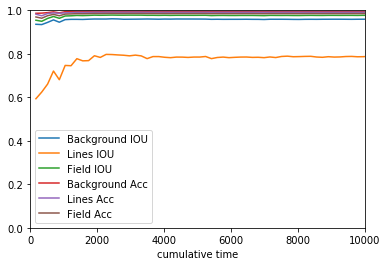

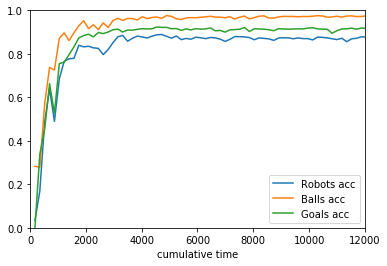

In [20]:
df4 = pd.read_csv('/home/user/jacobs/cudavision/Logs/test_logs_2_671.csv')
show_df_seg(df4)
show_df_det(df4)

In [8]:
def experiment5():
    schedule = [{'input_dimension': (3*32*5,4*32*5), 'epoch': 5,'phase': 'thaw', 'mode': 'det'}] \
         + [{'input_dimension': (3*32*i,4*32*i), 'epoch': 10,'phase': 'freeze', 'mode': 'concurrent'} for i in range(1,6)] \
         + [{'input_dimension': (3*32*5,4*32*5), 'epoch': 50,'phase': 'thaw', 'mode': 'concurrent'}]

    model_args = {
        'concatenated_bias' : 'shared',
        'concatenated_bias_learnable' : False,
        'added_bias': 'shared',
    }
    args['model_args'] = model_args
    args['size_after_transform'] = schedule[0]['input_dimension']
    model = Net(**args['model_args'],input_dimension = args['size_after_transform']).to(device)
    optimizer = optim.Adam(model.parameters(), 0.001)
    scheduler = CyclicLR(optimizer, base_lr=args['lr'],max_lr=args['max_lr'],cycle_momentum=False)
    epoch = 0

    run_id = 672

    log_loc = os.path.join(working_dir,f'Logs/test_logs_2_{run_id}.csv')
    logger = Logger(run_loc,log_loc,run_id,args)

    resume = False
    if resume == True:
        model.load_state_dict(torch.load(os.path.join(working_dir,f"Models/final_model_{run_id}.pt")))    
    if args['save_model']:
        torch.save(model.state_dict(), os.path.join(working_dir,f"Models/final_model_{run_id}.pt"))
    
    start_time = time.time()

    for phase in schedule:
        print(phase)
        for mode in modes:
            train_dataset[mode] = RobotsDatasetPrecomputed(meta,mode = mode,input_dimension=phase['input_dimension'],device=device,split='train')
            train_loader[mode] = torch.utils.data.DataLoader(train_dataset[mode],batch_size=args['batch_size'], shuffle=True)
            test_dataset[mode] = RobotsDatasetPrecomputed(meta,mode = mode,input_dimension=phase['input_dimension'],device=device,split='test')
            test_loader[mode] = torch.utils.data.DataLoader(test_dataset[mode],batch_size=args['test_batch_size'], shuffle=False)

        model.set_input_dimension(phase['input_dimension'])

        if phase['phase'] == 'freeze':
            model.freeze_encoder()
        else:
            model.unfreeze_encoder()


        for _ in range(phase['epoch']):
            epoch = epoch + 1
            if phase['mode'] == 'concurrent':
                train_concurrent(args, model, device, train_loader[phase['mode']], optimizer, epoch ,logger=logger)
            else: 
                train(args, model, device, train_loader[phase['mode']], optimizer, epoch , mode = phase['mode'],logger=logger)

            test(args, model, device, test_loader['det'], mode = 'det',logger=logger)
            test(args, model, device, test_loader['seg'], mode = 'seg',logger=logger)
            scheduler.step()
            logger.log_data()

            if args['save_model']:
                torch.save(model.state_dict(), os.path.join(working_dir,f"Models/final_model_{run_id}.pt"))
                
    return time.time() - start_time

In [9]:
experiment5()

{'input_dimension': (480, 640), 'epoch': 5, 'phase': 'thaw', 'mode': 'det'}
Train Epoch det: 1 [0/6194(0%)]	Loss: 2.158697, time: 1.1237823963165283
Train Epoch det: 1 [100/6194(2%)]	Loss: 0.178782, time: 1.3190538883209229
Train Epoch det: 1 [200/6194(3%)]	Loss: 0.054252, time: 1.3114891052246094
Train Epoch det: 1 [300/6194(5%)]	Loss: 0.031814, time: 1.313673734664917
Train Epoch det: 1 [400/6194(6%)]	Loss: 0.026753, time: 1.3102507591247559
Train Epoch det: 1 [500/6194(8%)]	Loss: 0.022828, time: 1.3078868389129639
Train Epoch det: 1 [600/6194(10%)]	Loss: 0.017442, time: 1.309687852859497
Train Epoch det: 1 [700/6194(11%)]	Loss: 0.021675, time: 1.3105180263519287
Train Epoch det: 1 [800/6194(13%)]	Loss: 0.023042, time: 1.365548849105835
Train Epoch det: 1 [900/6194(15%)]	Loss: 0.020590, time: 2.090996503829956
Train Epoch det: 1 [1000/6194(16%)]	Loss: 0.017481, time: 2.1688101291656494
Train Epoch det: 1 [1100/6194(18%)]	Loss: 0.017000, time: 2.1017794609069824
Train Epoch det: 1 [12

/home/user/jacobs/cudavision/metric_detection.py:89: RuntimeWarning: invalid value encountered in double_scalars
  recall = correct/(correct+FN)
/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))
/home/user/jacobs/cudavision/metric_segmentation.py:51: RuntimeWarning: invalid value encountered in true_divide
  IOU_imagewise[:,i] = true_positives_imagewise[cat]/(true_positives_imagewise[cat] + false_positives_imagewise[cat] + false_negatives_imagewise[cat])



Test set: seg Average loss: 0.1125

Background: IOU: 0.0737, accuracy: 0.5439
Lines: IOU: 0.0009, accuracy: 0.9580
Field: IOU: 0.4804, accuracy: 0.5073
Total: IOU: 0.1850, accuracy: 0.6697
making log csv
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_672.csv
Train Epoch det: 2 [0/6194(0%)]	Loss: 0.009356, time: 0.07560873031616211
Train Epoch det: 2 [100/6194(2%)]	Loss: 0.012711, time: 1.3357210159301758
Train Epoch det: 2 [200/6194(3%)]	Loss: 0.016074, time: 1.3351523876190186
Train Epoch det: 2 [300/6194(5%)]	Loss: 0.010336, time: 1.3372728824615479
Train Epoch det: 2 [400/6194(6%)]	Loss: 0.011477, time: 1.337583065032959
Train Epoch det: 2 [500/6194(8%)]	Loss: 0.011856, time: 1.3388731479644775
Train Epoch det: 2 [600/6194(10%)]	Loss: 0.012810, time: 1.3382725715637207
Train Epoch det: 2 [700/6194(11%)]	Loss: 0.010572, time: 1.335073471069336
Train Epoch det: 2 [800/6194(13%)]	Loss: 0.011739, time: 1.3384203910827637
Train Epoch det: 2 [900/6194(15%)]	Loss: 0.012682

Train Epoch det: 3 [3500/6194(56%)]	Loss: 0.010394, time: 1.3541877269744873
Train Epoch det: 3 [3600/6194(58%)]	Loss: 0.008292, time: 1.3537962436676025
Train Epoch det: 3 [3700/6194(60%)]	Loss: 0.007835, time: 1.3538696765899658
Train Epoch det: 3 [3800/6194(61%)]	Loss: 0.007094, time: 1.3511521816253662
Train Epoch det: 3 [3900/6194(63%)]	Loss: 0.007101, time: 1.3555798530578613
Train Epoch det: 3 [4000/6194(65%)]	Loss: 0.010470, time: 1.3539752960205078
Train Epoch det: 3 [4100/6194(66%)]	Loss: 0.008681, time: 1.3529202938079834
Train Epoch det: 3 [4200/6194(68%)]	Loss: 0.011083, time: 1.354537010192871
Train Epoch det: 3 [4300/6194(69%)]	Loss: 0.010829, time: 1.3543622493743896
Train Epoch det: 3 [4400/6194(71%)]	Loss: 0.007758, time: 1.3526532649993896
Train Epoch det: 3 [4500/6194(73%)]	Loss: 0.007272, time: 1.3577399253845215
Train Epoch det: 3 [4600/6194(74%)]	Loss: 0.007363, time: 1.3547704219818115
Train Epoch det: 3 [4700/6194(76%)]	Loss: 0.009303, time: 1.354553461074829
T

Train Epoch det: 5 [400/6194(6%)]	Loss: 0.005289, time: 1.3622264862060547
Train Epoch det: 5 [500/6194(8%)]	Loss: 0.009619, time: 1.362257719039917
Train Epoch det: 5 [600/6194(10%)]	Loss: 0.005573, time: 1.3624625205993652
Train Epoch det: 5 [700/6194(11%)]	Loss: 0.007429, time: 1.3638482093811035
Train Epoch det: 5 [800/6194(13%)]	Loss: 0.004872, time: 1.361290693283081
Train Epoch det: 5 [900/6194(15%)]	Loss: 0.003331, time: 1.3621206283569336
Train Epoch det: 5 [1000/6194(16%)]	Loss: 0.005070, time: 1.361767053604126
Train Epoch det: 5 [1100/6194(18%)]	Loss: 0.006094, time: 1.3601505756378174
Train Epoch det: 5 [1200/6194(19%)]	Loss: 0.004747, time: 1.360703945159912
Train Epoch det: 5 [1300/6194(21%)]	Loss: 0.007518, time: 1.3623981475830078
Train Epoch det: 5 [1400/6194(23%)]	Loss: 0.004890, time: 1.3638463020324707
Train Epoch det: 5 [1500/6194(24%)]	Loss: 0.007306, time: 1.3643567562103271
Train Epoch det: 5 [1600/6194(26%)]	Loss: 0.008933, time: 1.3640611171722412
Train Epoch

/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))


Train Epoch concurrent: 6 [0/6194(0%)]	Loss: 0.133087, time: 0.0469973087310791
Train Epoch concurrent: 6 [100/6194(2%)]	Loss: 0.076667, time: 0.4459364414215088
Train Epoch concurrent: 6 [200/6194(3%)]	Loss: 0.063775, time: 0.4270017147064209
Train Epoch concurrent: 6 [300/6194(5%)]	Loss: 0.049105, time: 0.42261385917663574
Train Epoch concurrent: 6 [400/6194(6%)]	Loss: 0.049754, time: 0.41272473335266113
Train Epoch concurrent: 6 [500/6194(8%)]	Loss: 0.047596, time: 0.4208102226257324
Train Epoch concurrent: 6 [600/6194(10%)]	Loss: 0.040611, time: 0.4093008041381836
Train Epoch concurrent: 6 [700/6194(11%)]	Loss: 0.045622, time: 0.3936426639556885
Train Epoch concurrent: 6 [800/6194(13%)]	Loss: 0.044588, time: 0.393585205078125
Train Epoch concurrent: 6 [900/6194(15%)]	Loss: 0.041539, time: 0.3918149471282959
Train Epoch concurrent: 6 [1000/6194(16%)]	Loss: 0.039821, time: 0.38492512702941895
Train Epoch concurrent: 6 [1100/6194(18%)]	Loss: 0.034131, time: 0.38477277755737305
Train E

/home/user/jacobs/cudavision/metric_segmentation.py:51: RuntimeWarning: invalid value encountered in true_divide
  IOU_imagewise[:,i] = true_positives_imagewise[cat]/(true_positives_imagewise[cat] + false_positives_imagewise[cat] + false_negatives_imagewise[cat])



Test set: seg Average loss: 0.0193

Background: IOU: 0.9056, accuracy: 0.9776
Lines: IOU: 0.0688, accuracy: 0.9628
Field: IOU: 0.9172, accuracy: 0.9411
Total: IOU: 0.6305, accuracy: 0.9605
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_672.csv
Train Epoch concurrent: 7 [0/6194(0%)]	Loss: 0.024902, time: 0.02866840362548828
Train Epoch concurrent: 7 [100/6194(2%)]	Loss: 0.023440, time: 0.2784411907196045
Train Epoch concurrent: 7 [200/6194(3%)]	Loss: 0.022065, time: 0.2780601978302002
Train Epoch concurrent: 7 [300/6194(5%)]	Loss: 0.020840, time: 0.27735137939453125
Train Epoch concurrent: 7 [400/6194(6%)]	Loss: 0.023769, time: 0.27783203125
Train Epoch concurrent: 7 [500/6194(8%)]	Loss: 0.025028, time: 0.27794933319091797
Train Epoch concurrent: 7 [600/6194(10%)]	Loss: 0.024712, time: 0.27842020988464355
Train Epoch concurrent: 7 [700/6194(11%)]	Loss: 0.023110, time: 0.27832627296447754
Train Epoch concurrent: 7 [800/6194(13%)]	Loss: 0.026263, time: 0.2776830196380615


Train Epoch concurrent: 8 [2600/6194(42%)]	Loss: 0.017576, time: 0.2751502990722656
Train Epoch concurrent: 8 [2700/6194(44%)]	Loss: 0.019081, time: 0.2759099006652832
Train Epoch concurrent: 8 [2800/6194(45%)]	Loss: 0.017549, time: 0.2745952606201172
Train Epoch concurrent: 8 [2900/6194(47%)]	Loss: 0.017564, time: 0.2768712043762207
Train Epoch concurrent: 8 [3000/6194(48%)]	Loss: 0.018201, time: 0.27402663230895996
Train Epoch concurrent: 8 [3100/6194(50%)]	Loss: 0.016655, time: 0.2777700424194336
Train Epoch concurrent: 8 [3200/6194(52%)]	Loss: 0.019721, time: 0.27433037757873535
Train Epoch concurrent: 8 [3300/6194(53%)]	Loss: 0.014920, time: 0.276719331741333
Train Epoch concurrent: 8 [3400/6194(55%)]	Loss: 0.019271, time: 0.274397611618042
Train Epoch concurrent: 8 [3500/6194(56%)]	Loss: 0.023103, time: 0.2751193046569824
Train Epoch concurrent: 8 [3600/6194(58%)]	Loss: 0.014962, time: 0.27535152435302734
Train Epoch concurrent: 8 [3700/6194(60%)]	Loss: 0.019146, time: 0.27526402

Train Epoch concurrent: 9 [5500/6194(89%)]	Loss: 0.016000, time: 0.2741117477416992
Train Epoch concurrent: 9 [5600/6194(90%)]	Loss: 0.014458, time: 0.2769944667816162
Train Epoch concurrent: 9 [5700/6194(92%)]	Loss: 0.014735, time: 0.27388978004455566
Train Epoch concurrent: 9 [5800/6194(94%)]	Loss: 0.016318, time: 0.27661728858947754
Train Epoch concurrent: 9 [5900/6194(95%)]	Loss: 0.015336, time: 0.27553296089172363
Train Epoch concurrent: 9 [6000/6194(97%)]	Loss: 0.014445, time: 0.27443838119506836
Train Epoch concurrent: 9 [6100/6194(98%)]	Loss: 0.023144, time: 0.27636027336120605

Test set: det Average loss: 0.0061

Balls: F1: 0.6940, accuracy: 0.5314, recall: 0.9244, precision: 0.5556, FDR: 0.4444,
Goalposts: F1: 0.4680, accuracy: 0.3054, recall: 0.7454, precision: 0.3410, FDR: 0.6590,
Robots: F1: 0.5059, accuracy: 0.3386, recall: 0.7916, precision: 0.3717, FDR: 0.6283,

Test set: seg Average loss: 0.0123

Background: IOU: 0.9387, accuracy: 0.9883
Lines: IOU: 0.3138, accuracy: 0

Train Epoch concurrent: 11 [1500/6194(24%)]	Loss: 0.016338, time: 0.2826399803161621
Train Epoch concurrent: 11 [1600/6194(26%)]	Loss: 0.010760, time: 0.2794063091278076
Train Epoch concurrent: 11 [1700/6194(27%)]	Loss: 0.012010, time: 0.27427220344543457
Train Epoch concurrent: 11 [1800/6194(29%)]	Loss: 0.014279, time: 0.275684118270874
Train Epoch concurrent: 11 [1900/6194(31%)]	Loss: 0.014206, time: 0.27396059036254883
Train Epoch concurrent: 11 [2000/6194(32%)]	Loss: 0.014770, time: 0.27862024307250977
Train Epoch concurrent: 11 [2100/6194(34%)]	Loss: 0.011771, time: 0.27371954917907715
Train Epoch concurrent: 11 [2200/6194(35%)]	Loss: 0.012863, time: 0.2761411666870117
Train Epoch concurrent: 11 [2300/6194(37%)]	Loss: 0.012758, time: 0.2760906219482422
Train Epoch concurrent: 11 [2400/6194(39%)]	Loss: 0.011349, time: 0.274672269821167
Train Epoch concurrent: 11 [2500/6194(40%)]	Loss: 0.011307, time: 0.27551722526550293
Train Epoch concurrent: 11 [2600/6194(42%)]	Loss: 0.011744, ti

Train Epoch concurrent: 12 [4300/6194(69%)]	Loss: 0.011090, time: 0.27869534492492676
Train Epoch concurrent: 12 [4400/6194(71%)]	Loss: 0.011046, time: 0.2779965400695801
Train Epoch concurrent: 12 [4500/6194(73%)]	Loss: 0.010236, time: 0.27875471115112305
Train Epoch concurrent: 12 [4600/6194(74%)]	Loss: 0.010543, time: 0.27828264236450195
Train Epoch concurrent: 12 [4700/6194(76%)]	Loss: 0.011277, time: 0.2801637649536133
Train Epoch concurrent: 12 [4800/6194(77%)]	Loss: 0.012458, time: 0.27864766120910645
Train Epoch concurrent: 12 [4900/6194(79%)]	Loss: 0.012308, time: 0.283064603805542
Train Epoch concurrent: 12 [5000/6194(81%)]	Loss: 0.010384, time: 0.2908329963684082
Train Epoch concurrent: 12 [5100/6194(82%)]	Loss: 0.012197, time: 0.285597562789917
Train Epoch concurrent: 12 [5200/6194(84%)]	Loss: 0.010297, time: 0.2834296226501465
Train Epoch concurrent: 12 [5300/6194(85%)]	Loss: 0.012070, time: 0.27906155586242676
Train Epoch concurrent: 12 [5400/6194(87%)]	Loss: 0.011057, ti

Train Epoch concurrent: 14 [300/6194(5%)]	Loss: 0.008295, time: 0.2783486843109131
Train Epoch concurrent: 14 [400/6194(6%)]	Loss: 0.011081, time: 0.2802762985229492
Train Epoch concurrent: 14 [500/6194(8%)]	Loss: 0.011848, time: 0.2783629894256592
Train Epoch concurrent: 14 [600/6194(10%)]	Loss: 0.013411, time: 0.27959632873535156
Train Epoch concurrent: 14 [700/6194(11%)]	Loss: 0.010127, time: 0.27930474281311035
Train Epoch concurrent: 14 [800/6194(13%)]	Loss: 0.011882, time: 0.2784440517425537
Train Epoch concurrent: 14 [900/6194(15%)]	Loss: 0.009591, time: 0.27959227561950684
Train Epoch concurrent: 14 [1000/6194(16%)]	Loss: 0.011980, time: 0.2791438102722168
Train Epoch concurrent: 14 [1100/6194(18%)]	Loss: 0.011969, time: 0.28058409690856934
Train Epoch concurrent: 14 [1200/6194(19%)]	Loss: 0.010772, time: 0.2787802219390869
Train Epoch concurrent: 14 [1300/6194(21%)]	Loss: 0.011880, time: 0.28122830390930176
Train Epoch concurrent: 14 [1400/6194(23%)]	Loss: 0.009891, time: 0.27

Train Epoch concurrent: 15 [3100/6194(50%)]	Loss: 0.009894, time: 0.2795567512512207
Train Epoch concurrent: 15 [3200/6194(52%)]	Loss: 0.008586, time: 0.27925920486450195
Train Epoch concurrent: 15 [3300/6194(53%)]	Loss: 0.014258, time: 0.2779834270477295
Train Epoch concurrent: 15 [3400/6194(55%)]	Loss: 0.008914, time: 0.2795536518096924
Train Epoch concurrent: 15 [3500/6194(56%)]	Loss: 0.008366, time: 0.27829623222351074
Train Epoch concurrent: 15 [3600/6194(58%)]	Loss: 0.008272, time: 0.27941179275512695
Train Epoch concurrent: 15 [3700/6194(60%)]	Loss: 0.008658, time: 0.27820611000061035
Train Epoch concurrent: 15 [3800/6194(61%)]	Loss: 0.010983, time: 0.2794198989868164
Train Epoch concurrent: 15 [3900/6194(63%)]	Loss: 0.007433, time: 0.27876782417297363
Train Epoch concurrent: 15 [4000/6194(65%)]	Loss: 0.011425, time: 0.27866053581237793
Train Epoch concurrent: 15 [4100/6194(66%)]	Loss: 0.009285, time: 0.2792975902557373
Train Epoch concurrent: 15 [4200/6194(68%)]	Loss: 0.013082,

/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))


Train Epoch concurrent: 16 [0/6194(0%)]	Loss: 0.044119, time: 0.07307624816894531
Train Epoch concurrent: 16 [100/6194(2%)]	Loss: 0.028332, time: 1.0545525550842285
Train Epoch concurrent: 16 [200/6194(3%)]	Loss: 0.026583, time: 0.9243090152740479
Train Epoch concurrent: 16 [300/6194(5%)]	Loss: 0.018313, time: 0.9487814903259277
Train Epoch concurrent: 16 [400/6194(6%)]	Loss: 0.015278, time: 0.9342918395996094
Train Epoch concurrent: 16 [500/6194(8%)]	Loss: 0.020052, time: 0.8782637119293213
Train Epoch concurrent: 16 [600/6194(10%)]	Loss: 0.017728, time: 0.9154636859893799
Train Epoch concurrent: 16 [700/6194(11%)]	Loss: 0.015897, time: 0.799386739730835
Train Epoch concurrent: 16 [800/6194(13%)]	Loss: 0.021514, time: 0.8330268859863281
Train Epoch concurrent: 16 [900/6194(15%)]	Loss: 0.016614, time: 0.7881839275360107
Train Epoch concurrent: 16 [1000/6194(16%)]	Loss: 0.018226, time: 0.7746884822845459
Train Epoch concurrent: 16 [1100/6194(18%)]	Loss: 0.017356, time: 0.740698814392089

Train Epoch concurrent: 17 [2900/6194(47%)]	Loss: 0.012528, time: 0.44589734077453613
Train Epoch concurrent: 17 [3000/6194(48%)]	Loss: 0.017468, time: 0.4404299259185791
Train Epoch concurrent: 17 [3100/6194(50%)]	Loss: 0.009835, time: 0.4384739398956299
Train Epoch concurrent: 17 [3200/6194(52%)]	Loss: 0.013598, time: 0.4373795986175537
Train Epoch concurrent: 17 [3300/6194(53%)]	Loss: 0.012066, time: 0.44048547744750977
Train Epoch concurrent: 17 [3400/6194(55%)]	Loss: 0.018056, time: 0.4433605670928955
Train Epoch concurrent: 17 [3500/6194(56%)]	Loss: 0.013587, time: 0.4400370121002197
Train Epoch concurrent: 17 [3600/6194(58%)]	Loss: 0.015221, time: 0.44039249420166016
Train Epoch concurrent: 17 [3700/6194(60%)]	Loss: 0.012948, time: 0.439866304397583
Train Epoch concurrent: 17 [3800/6194(61%)]	Loss: 0.011914, time: 0.43970489501953125
Train Epoch concurrent: 17 [3900/6194(63%)]	Loss: 0.010199, time: 0.4404149055480957
Train Epoch concurrent: 17 [4000/6194(65%)]	Loss: 0.014195, ti

Train Epoch concurrent: 18 [5700/6194(92%)]	Loss: 0.011412, time: 0.43720316886901855
Train Epoch concurrent: 18 [5800/6194(94%)]	Loss: 0.009852, time: 0.44023561477661133
Train Epoch concurrent: 18 [5900/6194(95%)]	Loss: 0.012429, time: 0.44742560386657715
Train Epoch concurrent: 18 [6000/6194(97%)]	Loss: 0.015111, time: 0.44131040573120117
Train Epoch concurrent: 18 [6100/6194(98%)]	Loss: 0.008949, time: 0.4383888244628906

Test set: det Average loss: 0.0053

Balls: F1: 0.8867, accuracy: 0.7965, recall: 0.9571, precision: 0.8261, FDR: 0.1739,
Goalposts: F1: 0.7687, accuracy: 0.6243, recall: 0.8868, precision: 0.6784, FDR: 0.3216,
Robots: F1: 0.7721, accuracy: 0.6288, recall: 0.8354, precision: 0.7178, FDR: 0.2822,

Test set: seg Average loss: 0.0091

Background: IOU: 0.9390, accuracy: 0.9868
Lines: IOU: 0.5905, accuracy: 0.9812
Field: IOU: 0.9538, accuracy: 0.9691
Total: IOU: 0.8278, accuracy: 0.9790
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_672.csv
Train Epoch c

Train Epoch concurrent: 20 [1700/6194(27%)]	Loss: 0.005984, time: 0.4404904842376709
Train Epoch concurrent: 20 [1800/6194(29%)]	Loss: 0.010405, time: 0.44060778617858887
Train Epoch concurrent: 20 [1900/6194(31%)]	Loss: 0.010858, time: 0.44104957580566406
Train Epoch concurrent: 20 [2000/6194(32%)]	Loss: 0.009665, time: 0.44205617904663086
Train Epoch concurrent: 20 [2100/6194(34%)]	Loss: 0.008723, time: 0.4421117305755615
Train Epoch concurrent: 20 [2200/6194(35%)]	Loss: 0.010094, time: 0.44060230255126953
Train Epoch concurrent: 20 [2300/6194(37%)]	Loss: 0.011568, time: 0.4415009021759033
Train Epoch concurrent: 20 [2400/6194(39%)]	Loss: 0.009485, time: 0.441394567489624
Train Epoch concurrent: 20 [2500/6194(40%)]	Loss: 0.010159, time: 0.43979644775390625
Train Epoch concurrent: 20 [2600/6194(42%)]	Loss: 0.009908, time: 0.4385373592376709
Train Epoch concurrent: 20 [2700/6194(44%)]	Loss: 0.008620, time: 0.44074487686157227
Train Epoch concurrent: 20 [2800/6194(45%)]	Loss: 0.010049, 

Train Epoch concurrent: 21 [4500/6194(73%)]	Loss: 0.010955, time: 0.43907928466796875
Train Epoch concurrent: 21 [4600/6194(74%)]	Loss: 0.008946, time: 0.4500889778137207
Train Epoch concurrent: 21 [4700/6194(76%)]	Loss: 0.012909, time: 0.44448304176330566
Train Epoch concurrent: 21 [4800/6194(77%)]	Loss: 0.007538, time: 0.4407651424407959
Train Epoch concurrent: 21 [4900/6194(79%)]	Loss: 0.010173, time: 0.4424901008605957
Train Epoch concurrent: 21 [5000/6194(81%)]	Loss: 0.009779, time: 0.4404308795928955
Train Epoch concurrent: 21 [5100/6194(82%)]	Loss: 0.009705, time: 0.44153571128845215
Train Epoch concurrent: 21 [5200/6194(84%)]	Loss: 0.011129, time: 0.44109582901000977
Train Epoch concurrent: 21 [5300/6194(85%)]	Loss: 0.007751, time: 0.4405233860015869
Train Epoch concurrent: 21 [5400/6194(87%)]	Loss: 0.006411, time: 0.4405100345611572
Train Epoch concurrent: 21 [5500/6194(89%)]	Loss: 0.008157, time: 0.4394652843475342
Train Epoch concurrent: 21 [5600/6194(90%)]	Loss: 0.009206, t

Train Epoch concurrent: 23 [500/6194(8%)]	Loss: 0.006742, time: 0.43906378746032715
Train Epoch concurrent: 23 [600/6194(10%)]	Loss: 0.006408, time: 0.4394800662994385
Train Epoch concurrent: 23 [700/6194(11%)]	Loss: 0.008055, time: 0.4388108253479004
Train Epoch concurrent: 23 [800/6194(13%)]	Loss: 0.012448, time: 0.4402196407318115
Train Epoch concurrent: 23 [900/6194(15%)]	Loss: 0.007192, time: 0.44069695472717285
Train Epoch concurrent: 23 [1000/6194(16%)]	Loss: 0.007364, time: 0.4398186206817627
Train Epoch concurrent: 23 [1100/6194(18%)]	Loss: 0.007623, time: 0.43999290466308594
Train Epoch concurrent: 23 [1200/6194(19%)]	Loss: 0.007363, time: 0.43790745735168457
Train Epoch concurrent: 23 [1300/6194(21%)]	Loss: 0.007354, time: 0.4374523162841797
Train Epoch concurrent: 23 [1400/6194(23%)]	Loss: 0.007272, time: 0.441483736038208
Train Epoch concurrent: 23 [1500/6194(24%)]	Loss: 0.007571, time: 0.4423198699951172
Train Epoch concurrent: 23 [1600/6194(26%)]	Loss: 0.006653, time: 0.

Train Epoch concurrent: 24 [3300/6194(53%)]	Loss: 0.006556, time: 0.4473690986633301
Train Epoch concurrent: 24 [3400/6194(55%)]	Loss: 0.006949, time: 0.4467039108276367
Train Epoch concurrent: 24 [3500/6194(56%)]	Loss: 0.005538, time: 0.4411132335662842
Train Epoch concurrent: 24 [3600/6194(58%)]	Loss: 0.008332, time: 0.4421103000640869
Train Epoch concurrent: 24 [3700/6194(60%)]	Loss: 0.005919, time: 0.4427914619445801
Train Epoch concurrent: 24 [3800/6194(61%)]	Loss: 0.007420, time: 0.44187378883361816
Train Epoch concurrent: 24 [3900/6194(63%)]	Loss: 0.008957, time: 0.44034290313720703
Train Epoch concurrent: 24 [4000/6194(65%)]	Loss: 0.006665, time: 0.4411041736602783
Train Epoch concurrent: 24 [4100/6194(66%)]	Loss: 0.005721, time: 0.44219493865966797
Train Epoch concurrent: 24 [4200/6194(68%)]	Loss: 0.005310, time: 0.4387080669403076
Train Epoch concurrent: 24 [4300/6194(69%)]	Loss: 0.006263, time: 0.44192981719970703
Train Epoch concurrent: 24 [4400/6194(71%)]	Loss: 0.008641, t

Train Epoch concurrent: 25 [6100/6194(98%)]	Loss: 0.007430, time: 0.446563720703125

Test set: det Average loss: 0.0047

Balls: F1: 0.8983, accuracy: 0.8155, recall: 0.9669, precision: 0.8388, FDR: 0.1612,
Goalposts: F1: 0.8471, accuracy: 0.7347, recall: 0.9084, precision: 0.7935, FDR: 0.2065,
Robots: F1: 0.8269, accuracy: 0.7049, recall: 0.8809, precision: 0.7792, FDR: 0.2208,

Test set: seg Average loss: 0.0093

Background: IOU: 0.9481, accuracy: 0.9906
Lines: IOU: 0.6081, accuracy: 0.9825
Field: IOU: 0.9596, accuracy: 0.9736
Total: IOU: 0.8386, accuracy: 0.9822
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_672.csv
{'input_dimension': (288, 384), 'epoch': 10, 'phase': 'freeze', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))


Train Epoch concurrent: 26 [0/6194(0%)]	Loss: 0.021683, time: 0.12170839309692383
Train Epoch concurrent: 26 [100/6194(2%)]	Loss: 0.027253, time: 1.5801687240600586
Train Epoch concurrent: 26 [200/6194(3%)]	Loss: 0.020420, time: 1.6579639911651611
Train Epoch concurrent: 26 [300/6194(5%)]	Loss: 0.017308, time: 1.610001802444458
Train Epoch concurrent: 26 [400/6194(6%)]	Loss: 0.012089, time: 1.53779935836792
Train Epoch concurrent: 26 [500/6194(8%)]	Loss: 0.013683, time: 1.533231496810913
Train Epoch concurrent: 26 [600/6194(10%)]	Loss: 0.014664, time: 1.4272031784057617
Train Epoch concurrent: 26 [700/6194(11%)]	Loss: 0.015212, time: 1.2568769454956055
Train Epoch concurrent: 26 [800/6194(13%)]	Loss: 0.016759, time: 1.3814420700073242
Train Epoch concurrent: 26 [900/6194(15%)]	Loss: 0.014107, time: 1.3301584720611572
Train Epoch concurrent: 26 [1000/6194(16%)]	Loss: 0.011537, time: 1.296757698059082
Train Epoch concurrent: 26 [1100/6194(18%)]	Loss: 0.012213, time: 1.3495655059814453
Tr

Train Epoch concurrent: 27 [2900/6194(47%)]	Loss: 0.010696, time: 0.8491325378417969
Train Epoch concurrent: 27 [3000/6194(48%)]	Loss: 0.010487, time: 0.8278188705444336
Train Epoch concurrent: 27 [3100/6194(50%)]	Loss: 0.010889, time: 0.7903687953948975
Train Epoch concurrent: 27 [3200/6194(52%)]	Loss: 0.009771, time: 0.8839352130889893
Train Epoch concurrent: 27 [3300/6194(53%)]	Loss: 0.014683, time: 0.7975547313690186
Train Epoch concurrent: 27 [3400/6194(55%)]	Loss: 0.011365, time: 0.8065471649169922
Train Epoch concurrent: 27 [3500/6194(56%)]	Loss: 0.012066, time: 0.7762649059295654
Train Epoch concurrent: 27 [3600/6194(58%)]	Loss: 0.007623, time: 0.7944800853729248
Train Epoch concurrent: 27 [3700/6194(60%)]	Loss: 0.010897, time: 0.849252462387085
Train Epoch concurrent: 27 [3800/6194(61%)]	Loss: 0.009544, time: 0.7686092853546143
Train Epoch concurrent: 27 [3900/6194(63%)]	Loss: 0.007815, time: 0.7850518226623535
Train Epoch concurrent: 27 [4000/6194(65%)]	Loss: 0.013431, time: 

Train Epoch concurrent: 28 [5800/6194(94%)]	Loss: 0.010070, time: 0.7359845638275146
Train Epoch concurrent: 28 [5900/6194(95%)]	Loss: 0.009087, time: 0.7343792915344238
Train Epoch concurrent: 28 [6000/6194(97%)]	Loss: 0.007196, time: 0.7334494590759277
Train Epoch concurrent: 28 [6100/6194(98%)]	Loss: 0.006959, time: 0.736811637878418

Test set: det Average loss: 0.0052

Balls: F1: 0.8891, accuracy: 0.8004, recall: 0.9743, precision: 0.8176, FDR: 0.1824,
Goalposts: F1: 0.7887, accuracy: 0.6511, recall: 0.9221, precision: 0.6890, FDR: 0.3110,
Robots: F1: 0.7060, accuracy: 0.5456, recall: 0.9087, precision: 0.5772, FDR: 0.4228,

Test set: seg Average loss: 0.0069

Background: IOU: 0.9475, accuracy: 0.9900
Lines: IOU: 0.6922, accuracy: 0.9867
Field: IOU: 0.9655, accuracy: 0.9774
Total: IOU: 0.8684, accuracy: 0.9847
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_672.csv
Train Epoch concurrent: 29 [0/6194(0%)]	Loss: 0.011234, time: 0.05708622932434082
Train Epoch concurren

Train Epoch concurrent: 30 [1800/6194(29%)]	Loss: 0.007026, time: 0.733553409576416
Train Epoch concurrent: 30 [1900/6194(31%)]	Loss: 0.007226, time: 0.743546724319458
Train Epoch concurrent: 30 [2000/6194(32%)]	Loss: 0.006400, time: 0.7360799312591553
Train Epoch concurrent: 30 [2100/6194(34%)]	Loss: 0.006314, time: 0.7388014793395996
Train Epoch concurrent: 30 [2200/6194(35%)]	Loss: 0.009381, time: 0.7344598770141602
Train Epoch concurrent: 30 [2300/6194(37%)]	Loss: 0.006562, time: 0.7359616756439209
Train Epoch concurrent: 30 [2400/6194(39%)]	Loss: 0.010591, time: 0.7321808338165283
Train Epoch concurrent: 30 [2500/6194(40%)]	Loss: 0.007213, time: 0.737339973449707
Train Epoch concurrent: 30 [2600/6194(42%)]	Loss: 0.006384, time: 0.734358549118042
Train Epoch concurrent: 30 [2700/6194(44%)]	Loss: 0.008024, time: 0.7347815036773682
Train Epoch concurrent: 30 [2800/6194(45%)]	Loss: 0.010387, time: 0.7340743541717529
Train Epoch concurrent: 30 [2900/6194(47%)]	Loss: 0.006084, time: 0.7

Train Epoch concurrent: 31 [4700/6194(76%)]	Loss: 0.006492, time: 0.7346327304840088
Train Epoch concurrent: 31 [4800/6194(77%)]	Loss: 0.009061, time: 0.7322909832000732
Train Epoch concurrent: 31 [4900/6194(79%)]	Loss: 0.006652, time: 0.7338759899139404
Train Epoch concurrent: 31 [5000/6194(81%)]	Loss: 0.007805, time: 0.7413239479064941
Train Epoch concurrent: 31 [5100/6194(82%)]	Loss: 0.009516, time: 0.7342164516448975
Train Epoch concurrent: 31 [5200/6194(84%)]	Loss: 0.007086, time: 0.7340002059936523
Train Epoch concurrent: 31 [5300/6194(85%)]	Loss: 0.007445, time: 0.736682653427124
Train Epoch concurrent: 31 [5400/6194(87%)]	Loss: 0.006855, time: 0.7333173751831055
Train Epoch concurrent: 31 [5500/6194(89%)]	Loss: 0.006827, time: 0.7353479862213135
Train Epoch concurrent: 31 [5600/6194(90%)]	Loss: 0.006684, time: 0.7384688854217529
Train Epoch concurrent: 31 [5700/6194(92%)]	Loss: 0.006280, time: 0.7414901256561279
Train Epoch concurrent: 31 [5800/6194(94%)]	Loss: 0.006538, time: 

Train Epoch concurrent: 33 [700/6194(11%)]	Loss: 0.006350, time: 0.7333858013153076
Train Epoch concurrent: 33 [800/6194(13%)]	Loss: 0.008661, time: 0.7355265617370605
Train Epoch concurrent: 33 [900/6194(15%)]	Loss: 0.007834, time: 0.7374639511108398
Train Epoch concurrent: 33 [1000/6194(16%)]	Loss: 0.006568, time: 0.7375297546386719
Train Epoch concurrent: 33 [1100/6194(18%)]	Loss: 0.009127, time: 0.7337193489074707
Train Epoch concurrent: 33 [1200/6194(19%)]	Loss: 0.005765, time: 0.7365257740020752
Train Epoch concurrent: 33 [1300/6194(21%)]	Loss: 0.004962, time: 0.73191237449646
Train Epoch concurrent: 33 [1400/6194(23%)]	Loss: 0.006661, time: 0.7402856349945068
Train Epoch concurrent: 33 [1500/6194(24%)]	Loss: 0.006136, time: 0.7387969493865967
Train Epoch concurrent: 33 [1600/6194(26%)]	Loss: 0.007840, time: 0.734337568283081
Train Epoch concurrent: 33 [1700/6194(27%)]	Loss: 0.010074, time: 0.7321701049804688
Train Epoch concurrent: 33 [1800/6194(29%)]	Loss: 0.006980, time: 0.737

Train Epoch concurrent: 34 [3600/6194(58%)]	Loss: 0.005664, time: 0.7334294319152832
Train Epoch concurrent: 34 [3700/6194(60%)]	Loss: 0.004886, time: 0.735215425491333
Train Epoch concurrent: 34 [3800/6194(61%)]	Loss: 0.008606, time: 0.7383244037628174
Train Epoch concurrent: 34 [3900/6194(63%)]	Loss: 0.006807, time: 0.7357571125030518
Train Epoch concurrent: 34 [4000/6194(65%)]	Loss: 0.012245, time: 0.7371327877044678
Train Epoch concurrent: 34 [4100/6194(66%)]	Loss: 0.005949, time: 0.7392611503601074
Train Epoch concurrent: 34 [4200/6194(68%)]	Loss: 0.005567, time: 0.7372035980224609
Train Epoch concurrent: 34 [4300/6194(69%)]	Loss: 0.005188, time: 0.7367603778839111
Train Epoch concurrent: 34 [4400/6194(71%)]	Loss: 0.005720, time: 0.7361555099487305
Train Epoch concurrent: 34 [4500/6194(73%)]	Loss: 0.007210, time: 0.7339942455291748
Train Epoch concurrent: 34 [4600/6194(74%)]	Loss: 0.003750, time: 0.7359662055969238
Train Epoch concurrent: 34 [4700/6194(76%)]	Loss: 0.006686, time: 


Test set: seg Average loss: 0.0081

Background: IOU: 0.9470, accuracy: 0.9896
Lines: IOU: 0.6864, accuracy: 0.9868
Field: IOU: 0.9648, accuracy: 0.9770
Total: IOU: 0.8661, accuracy: 0.9844
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_672.csv
{'input_dimension': (384, 512), 'epoch': 10, 'phase': 'freeze', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))


Train Epoch concurrent: 36 [0/6194(0%)]	Loss: 0.015584, time: 0.19328546524047852
Train Epoch concurrent: 36 [100/6194(2%)]	Loss: 0.012838, time: 2.5596301555633545
Train Epoch concurrent: 36 [200/6194(3%)]	Loss: 0.014241, time: 2.434567451477051
Train Epoch concurrent: 36 [300/6194(5%)]	Loss: 0.009368, time: 2.4482553005218506
Train Epoch concurrent: 36 [400/6194(6%)]	Loss: 0.012504, time: 2.339273452758789
Train Epoch concurrent: 36 [500/6194(8%)]	Loss: 0.012409, time: 2.2827160358428955
Train Epoch concurrent: 36 [600/6194(10%)]	Loss: 0.010785, time: 2.225252628326416
Train Epoch concurrent: 36 [700/6194(11%)]	Loss: 0.010796, time: 2.257874011993408
Train Epoch concurrent: 36 [800/6194(13%)]	Loss: 0.010975, time: 2.1811461448669434
Train Epoch concurrent: 36 [900/6194(15%)]	Loss: 0.009478, time: 2.0103302001953125
Train Epoch concurrent: 36 [1000/6194(16%)]	Loss: 0.011468, time: 2.081141948699951
Train Epoch concurrent: 36 [1100/6194(18%)]	Loss: 0.009323, time: 2.0777950286865234
Tr

Train Epoch concurrent: 37 [2900/6194(47%)]	Loss: 0.008625, time: 1.1198694705963135
Train Epoch concurrent: 37 [3000/6194(48%)]	Loss: 0.007776, time: 1.1180882453918457
Train Epoch concurrent: 37 [3100/6194(50%)]	Loss: 0.009046, time: 1.1207144260406494
Train Epoch concurrent: 37 [3200/6194(52%)]	Loss: 0.008271, time: 1.1211538314819336
Train Epoch concurrent: 37 [3300/6194(53%)]	Loss: 0.008036, time: 1.1203453540802002
Train Epoch concurrent: 37 [3400/6194(55%)]	Loss: 0.008845, time: 1.1210911273956299
Train Epoch concurrent: 37 [3500/6194(56%)]	Loss: 0.008439, time: 1.1227226257324219
Train Epoch concurrent: 37 [3600/6194(58%)]	Loss: 0.014242, time: 1.122237205505371
Train Epoch concurrent: 37 [3700/6194(60%)]	Loss: 0.010114, time: 1.1208124160766602
Train Epoch concurrent: 37 [3800/6194(61%)]	Loss: 0.009898, time: 1.1236252784729004
Train Epoch concurrent: 37 [3900/6194(63%)]	Loss: 0.007579, time: 1.120255470275879
Train Epoch concurrent: 37 [4000/6194(65%)]	Loss: 0.007235, time: 1

Train Epoch concurrent: 38 [5800/6194(94%)]	Loss: 0.006480, time: 1.126283884048462
Train Epoch concurrent: 38 [5900/6194(95%)]	Loss: 0.007542, time: 1.123631238937378
Train Epoch concurrent: 38 [6000/6194(97%)]	Loss: 0.006306, time: 1.1239089965820312
Train Epoch concurrent: 38 [6100/6194(98%)]	Loss: 0.007293, time: 1.1268501281738281

Test set: det Average loss: 0.0043

Balls: F1: 0.8995, accuracy: 0.8173, recall: 0.9802, precision: 0.8310, FDR: 0.1690,
Goalposts: F1: 0.7732, accuracy: 0.6303, recall: 0.9341, precision: 0.6597, FDR: 0.3403,
Robots: F1: 0.6699, accuracy: 0.5036, recall: 0.9198, precision: 0.5267, FDR: 0.4733,

Test set: seg Average loss: 0.0063

Background: IOU: 0.9456, accuracy: 0.9895
Lines: IOU: 0.7375, accuracy: 0.9890
Field: IOU: 0.9681, accuracy: 0.9791
Total: IOU: 0.8837, accuracy: 0.9859
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_672.csv
Train Epoch concurrent: 39 [0/6194(0%)]	Loss: 0.007476, time: 0.08518266677856445
Train Epoch concurrent

Train Epoch concurrent: 40 [1800/6194(29%)]	Loss: 0.013517, time: 1.1245946884155273
Train Epoch concurrent: 40 [1900/6194(31%)]	Loss: 0.008172, time: 1.1245641708374023
Train Epoch concurrent: 40 [2000/6194(32%)]	Loss: 0.006656, time: 1.1242365837097168
Train Epoch concurrent: 40 [2100/6194(34%)]	Loss: 0.005275, time: 1.1220831871032715
Train Epoch concurrent: 40 [2200/6194(35%)]	Loss: 0.008629, time: 1.1246085166931152
Train Epoch concurrent: 40 [2300/6194(37%)]	Loss: 0.007034, time: 1.1268725395202637
Train Epoch concurrent: 40 [2400/6194(39%)]	Loss: 0.006510, time: 1.1239354610443115
Train Epoch concurrent: 40 [2500/6194(40%)]	Loss: 0.004826, time: 1.1229186058044434
Train Epoch concurrent: 40 [2600/6194(42%)]	Loss: 0.013953, time: 1.125535011291504
Train Epoch concurrent: 40 [2700/6194(44%)]	Loss: 0.007245, time: 1.1253056526184082
Train Epoch concurrent: 40 [2800/6194(45%)]	Loss: 0.007458, time: 1.1237883567810059
Train Epoch concurrent: 40 [2900/6194(47%)]	Loss: 0.006203, time: 

Train Epoch concurrent: 41 [4700/6194(76%)]	Loss: 0.006978, time: 1.1233124732971191
Train Epoch concurrent: 41 [4800/6194(77%)]	Loss: 0.006520, time: 1.125683069229126
Train Epoch concurrent: 41 [4900/6194(79%)]	Loss: 0.006383, time: 1.1249668598175049
Train Epoch concurrent: 41 [5000/6194(81%)]	Loss: 0.007369, time: 1.1233420372009277
Train Epoch concurrent: 41 [5100/6194(82%)]	Loss: 0.006564, time: 1.123769760131836
Train Epoch concurrent: 41 [5200/6194(84%)]	Loss: 0.005082, time: 1.125964641571045
Train Epoch concurrent: 41 [5300/6194(85%)]	Loss: 0.009443, time: 1.124418020248413
Train Epoch concurrent: 41 [5400/6194(87%)]	Loss: 0.005752, time: 1.123300552368164
Train Epoch concurrent: 41 [5500/6194(89%)]	Loss: 0.005533, time: 1.1254231929779053
Train Epoch concurrent: 41 [5600/6194(90%)]	Loss: 0.006090, time: 1.1241426467895508
Train Epoch concurrent: 41 [5700/6194(92%)]	Loss: 0.007174, time: 1.1249465942382812
Train Epoch concurrent: 41 [5800/6194(94%)]	Loss: 0.007902, time: 1.12

Train Epoch concurrent: 43 [700/6194(11%)]	Loss: 0.005570, time: 1.1301336288452148
Train Epoch concurrent: 43 [800/6194(13%)]	Loss: 0.009110, time: 1.1256954669952393
Train Epoch concurrent: 43 [900/6194(15%)]	Loss: 0.009784, time: 1.1258952617645264
Train Epoch concurrent: 43 [1000/6194(16%)]	Loss: 0.008238, time: 1.124751091003418
Train Epoch concurrent: 43 [1100/6194(18%)]	Loss: 0.006230, time: 1.124089241027832
Train Epoch concurrent: 43 [1200/6194(19%)]	Loss: 0.006328, time: 1.1243364810943604
Train Epoch concurrent: 43 [1300/6194(21%)]	Loss: 0.005461, time: 1.1236441135406494
Train Epoch concurrent: 43 [1400/6194(23%)]	Loss: 0.004616, time: 1.124039888381958
Train Epoch concurrent: 43 [1500/6194(24%)]	Loss: 0.005289, time: 1.1246225833892822
Train Epoch concurrent: 43 [1600/6194(26%)]	Loss: 0.004476, time: 1.1257891654968262
Train Epoch concurrent: 43 [1700/6194(27%)]	Loss: 0.005647, time: 1.124866247177124
Train Epoch concurrent: 43 [1800/6194(29%)]	Loss: 0.008807, time: 1.1244

Train Epoch concurrent: 44 [3600/6194(58%)]	Loss: 0.006785, time: 1.1238441467285156
Train Epoch concurrent: 44 [3700/6194(60%)]	Loss: 0.006093, time: 1.1240146160125732
Train Epoch concurrent: 44 [3800/6194(61%)]	Loss: 0.005361, time: 1.1256439685821533
Train Epoch concurrent: 44 [3900/6194(63%)]	Loss: 0.006492, time: 1.1249616146087646
Train Epoch concurrent: 44 [4000/6194(65%)]	Loss: 0.007010, time: 1.13090181350708
Train Epoch concurrent: 44 [4100/6194(66%)]	Loss: 0.005780, time: 1.12648344039917
Train Epoch concurrent: 44 [4200/6194(68%)]	Loss: 0.006382, time: 1.1232967376708984
Train Epoch concurrent: 44 [4300/6194(69%)]	Loss: 0.005438, time: 1.1239533424377441
Train Epoch concurrent: 44 [4400/6194(71%)]	Loss: 0.006381, time: 1.1245718002319336
Train Epoch concurrent: 44 [4500/6194(73%)]	Loss: 0.009043, time: 1.1248977184295654
Train Epoch concurrent: 44 [4600/6194(74%)]	Loss: 0.006381, time: 1.1232328414916992
Train Epoch concurrent: 44 [4700/6194(76%)]	Loss: 0.005202, time: 1.1


Test set: seg Average loss: 0.0071

Background: IOU: 0.9465, accuracy: 0.9896
Lines: IOU: 0.7138, accuracy: 0.9883
Field: IOU: 0.9670, accuracy: 0.9784
Total: IOU: 0.8758, accuracy: 0.9854
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_672.csv
{'input_dimension': (480, 640), 'epoch': 10, 'phase': 'freeze', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))


Train Epoch concurrent: 46 [0/6194(0%)]	Loss: 0.012069, time: 0.28421783447265625
Train Epoch concurrent: 46 [100/6194(2%)]	Loss: 0.012024, time: 3.49503493309021
Train Epoch concurrent: 46 [200/6194(3%)]	Loss: 0.013609, time: 3.549983024597168
Train Epoch concurrent: 46 [300/6194(5%)]	Loss: 0.011233, time: 3.397733449935913
Train Epoch concurrent: 46 [400/6194(6%)]	Loss: 0.012389, time: 3.3886337280273438
Train Epoch concurrent: 46 [500/6194(8%)]	Loss: 0.012893, time: 3.2547528743743896
Train Epoch concurrent: 46 [600/6194(10%)]	Loss: 0.011123, time: 3.239645004272461
Train Epoch concurrent: 46 [700/6194(11%)]	Loss: 0.009944, time: 3.1557719707489014
Train Epoch concurrent: 46 [800/6194(13%)]	Loss: 0.008118, time: 3.0458321571350098
Train Epoch concurrent: 46 [900/6194(15%)]	Loss: 0.009773, time: 3.170985460281372
Train Epoch concurrent: 46 [1000/6194(16%)]	Loss: 0.015594, time: 2.9012227058410645
Train Epoch concurrent: 46 [1100/6194(18%)]	Loss: 0.008569, time: 2.905571699142456
Trai

Train Epoch concurrent: 47 [2900/6194(47%)]	Loss: 0.008643, time: 1.732210397720337
Train Epoch concurrent: 47 [3000/6194(48%)]	Loss: 0.007912, time: 1.7366712093353271
Train Epoch concurrent: 47 [3100/6194(50%)]	Loss: 0.008756, time: 1.7377774715423584
Train Epoch concurrent: 47 [3200/6194(52%)]	Loss: 0.006165, time: 1.7454614639282227
Train Epoch concurrent: 47 [3300/6194(53%)]	Loss: 0.008319, time: 1.7350010871887207
Train Epoch concurrent: 47 [3400/6194(55%)]	Loss: 0.007283, time: 1.7841055393218994
Train Epoch concurrent: 47 [3500/6194(56%)]	Loss: 0.008226, time: 1.7651877403259277
Train Epoch concurrent: 47 [3600/6194(58%)]	Loss: 0.006559, time: 1.7585134506225586
Train Epoch concurrent: 47 [3700/6194(60%)]	Loss: 0.008504, time: 1.7534301280975342
Train Epoch concurrent: 47 [3800/6194(61%)]	Loss: 0.008968, time: 1.771517276763916
Train Epoch concurrent: 47 [3900/6194(63%)]	Loss: 0.008052, time: 1.7047243118286133
Train Epoch concurrent: 47 [4000/6194(65%)]	Loss: 0.008214, time: 1

Train Epoch concurrent: 48 [5800/6194(94%)]	Loss: 0.008120, time: 1.6491286754608154
Train Epoch concurrent: 48 [5900/6194(95%)]	Loss: 0.008729, time: 1.649479627609253
Train Epoch concurrent: 48 [6000/6194(97%)]	Loss: 0.006094, time: 1.648782730102539
Train Epoch concurrent: 48 [6100/6194(98%)]	Loss: 0.006206, time: 1.6498639583587646

Test set: det Average loss: 0.0042

Balls: F1: 0.8944, accuracy: 0.8090, recall: 0.9802, precision: 0.8224, FDR: 0.1776,
Goalposts: F1: 0.6958, accuracy: 0.5335, recall: 0.9334, precision: 0.5546, FDR: 0.4454,
Robots: F1: 0.6558, accuracy: 0.4878, recall: 0.9183, precision: 0.5099, FDR: 0.4901,

Test set: seg Average loss: 0.0071

Background: IOU: 0.9460, accuracy: 0.9867
Lines: IOU: 0.7479, accuracy: 0.9894
Field: IOU: 0.9665, accuracy: 0.9772
Total: IOU: 0.8868, accuracy: 0.9844
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_672.csv
Train Epoch concurrent: 49 [0/6194(0%)]	Loss: 0.008838, time: 0.12603068351745605
Train Epoch concurrent

Train Epoch concurrent: 50 [1800/6194(29%)]	Loss: 0.005776, time: 1.651801347732544
Train Epoch concurrent: 50 [1900/6194(31%)]	Loss: 0.008181, time: 1.6536049842834473
Train Epoch concurrent: 50 [2000/6194(32%)]	Loss: 0.007228, time: 1.6491479873657227
Train Epoch concurrent: 50 [2100/6194(34%)]	Loss: 0.007695, time: 1.6508851051330566
Train Epoch concurrent: 50 [2200/6194(35%)]	Loss: 0.006818, time: 1.651916742324829
Train Epoch concurrent: 50 [2300/6194(37%)]	Loss: 0.007581, time: 1.649068832397461
Train Epoch concurrent: 50 [2400/6194(39%)]	Loss: 0.005813, time: 1.6530570983886719
Train Epoch concurrent: 50 [2500/6194(40%)]	Loss: 0.007373, time: 1.6501679420471191
Train Epoch concurrent: 50 [2600/6194(42%)]	Loss: 0.005714, time: 1.6545031070709229
Train Epoch concurrent: 50 [2700/6194(44%)]	Loss: 0.004058, time: 1.6502554416656494
Train Epoch concurrent: 50 [2800/6194(45%)]	Loss: 0.006368, time: 1.6512079238891602
Train Epoch concurrent: 50 [2900/6194(47%)]	Loss: 0.006882, time: 1.

Train Epoch concurrent: 51 [4700/6194(76%)]	Loss: 0.006935, time: 1.649233102798462
Train Epoch concurrent: 51 [4800/6194(77%)]	Loss: 0.005806, time: 1.653491497039795
Train Epoch concurrent: 51 [4900/6194(79%)]	Loss: 0.010067, time: 1.6512095928192139
Train Epoch concurrent: 51 [5000/6194(81%)]	Loss: 0.006685, time: 1.6509473323822021
Train Epoch concurrent: 51 [5100/6194(82%)]	Loss: 0.005547, time: 1.6500415802001953
Train Epoch concurrent: 51 [5200/6194(84%)]	Loss: 0.006574, time: 1.6506471633911133
Train Epoch concurrent: 51 [5300/6194(85%)]	Loss: 0.008292, time: 1.6527154445648193
Train Epoch concurrent: 51 [5400/6194(87%)]	Loss: 0.005321, time: 1.6546847820281982
Train Epoch concurrent: 51 [5500/6194(89%)]	Loss: 0.007987, time: 1.6530091762542725
Train Epoch concurrent: 51 [5600/6194(90%)]	Loss: 0.005322, time: 1.6507115364074707
Train Epoch concurrent: 51 [5700/6194(92%)]	Loss: 0.006345, time: 1.6523244380950928
Train Epoch concurrent: 51 [5800/6194(94%)]	Loss: 0.005700, time: 1

Train Epoch concurrent: 53 [700/6194(11%)]	Loss: 0.005018, time: 1.6502275466918945
Train Epoch concurrent: 53 [800/6194(13%)]	Loss: 0.004737, time: 1.6514735221862793
Train Epoch concurrent: 53 [900/6194(15%)]	Loss: 0.004411, time: 1.649918556213379
Train Epoch concurrent: 53 [1000/6194(16%)]	Loss: 0.005556, time: 1.6516940593719482
Train Epoch concurrent: 53 [1100/6194(18%)]	Loss: 0.005477, time: 1.6507351398468018
Train Epoch concurrent: 53 [1200/6194(19%)]	Loss: 0.010548, time: 1.650503396987915
Train Epoch concurrent: 53 [1300/6194(21%)]	Loss: 0.005008, time: 1.6526310443878174
Train Epoch concurrent: 53 [1400/6194(23%)]	Loss: 0.008507, time: 1.6504883766174316
Train Epoch concurrent: 53 [1500/6194(24%)]	Loss: 0.007176, time: 1.6520874500274658
Train Epoch concurrent: 53 [1600/6194(26%)]	Loss: 0.005393, time: 1.650794506072998
Train Epoch concurrent: 53 [1700/6194(27%)]	Loss: 0.005693, time: 1.6504907608032227
Train Epoch concurrent: 53 [1800/6194(29%)]	Loss: 0.006977, time: 1.652

Train Epoch concurrent: 54 [3600/6194(58%)]	Loss: 0.006029, time: 1.6492435932159424
Train Epoch concurrent: 54 [3700/6194(60%)]	Loss: 0.004852, time: 1.655503273010254
Train Epoch concurrent: 54 [3800/6194(61%)]	Loss: 0.005386, time: 1.6496591567993164
Train Epoch concurrent: 54 [3900/6194(63%)]	Loss: 0.005936, time: 1.650310754776001
Train Epoch concurrent: 54 [4000/6194(65%)]	Loss: 0.005377, time: 1.6499125957489014
Train Epoch concurrent: 54 [4100/6194(66%)]	Loss: 0.006139, time: 1.6509554386138916
Train Epoch concurrent: 54 [4200/6194(68%)]	Loss: 0.005294, time: 1.6546730995178223
Train Epoch concurrent: 54 [4300/6194(69%)]	Loss: 0.006367, time: 1.6528384685516357
Train Epoch concurrent: 54 [4400/6194(71%)]	Loss: 0.012098, time: 1.6504721641540527
Train Epoch concurrent: 54 [4500/6194(73%)]	Loss: 0.008210, time: 1.6529161930084229
Train Epoch concurrent: 54 [4600/6194(74%)]	Loss: 0.006171, time: 1.6492455005645752
Train Epoch concurrent: 54 [4700/6194(76%)]	Loss: 0.008655, time: 1


Test set: seg Average loss: 0.0067

Background: IOU: 0.9480, accuracy: 0.9889
Lines: IOU: 0.7523, accuracy: 0.9893
Field: IOU: 0.9683, accuracy: 0.9790
Total: IOU: 0.8895, accuracy: 0.9857
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_672.csv
{'input_dimension': (480, 640), 'epoch': 50, 'phase': 'thaw', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))


Train Epoch concurrent: 56 [0/6194(0%)]	Loss: 0.004151, time: 0.22563457489013672
Train Epoch concurrent: 56 [100/6194(2%)]	Loss: 0.050903, time: 2.766890287399292
Train Epoch concurrent: 56 [200/6194(3%)]	Loss: 0.048649, time: 2.7529075145721436
Train Epoch concurrent: 56 [300/6194(5%)]	Loss: 0.033121, time: 2.754106044769287
Train Epoch concurrent: 56 [400/6194(6%)]	Loss: 0.030160, time: 2.7561700344085693
Train Epoch concurrent: 56 [500/6194(8%)]	Loss: 0.030407, time: 2.7515807151794434
Train Epoch concurrent: 56 [600/6194(10%)]	Loss: 0.033294, time: 2.7548532485961914
Train Epoch concurrent: 56 [700/6194(11%)]	Loss: 0.027307, time: 2.750478744506836
Train Epoch concurrent: 56 [800/6194(13%)]	Loss: 0.028761, time: 2.7553746700286865
Train Epoch concurrent: 56 [900/6194(15%)]	Loss: 0.036880, time: 2.757699728012085
Train Epoch concurrent: 56 [1000/6194(16%)]	Loss: 0.026091, time: 2.753953695297241
Train Epoch concurrent: 56 [1100/6194(18%)]	Loss: 0.038367, time: 2.758517026901245
Tra

/home/user/jacobs/cudavision/metric_detection.py:89: RuntimeWarning: invalid value encountered in double_scalars
  recall = correct/(correct+FN)



Test set: seg Average loss: 0.0079

Background: IOU: 0.9312, accuracy: 0.9860
Lines: IOU: 0.6877, accuracy: 0.9860
Field: IOU: 0.9585, accuracy: 0.9724
Total: IOU: 0.8591, accuracy: 0.9815
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_672.csv
Train Epoch concurrent: 57 [0/6194(0%)]	Loss: 0.016523, time: 0.220991849899292
Train Epoch concurrent: 57 [100/6194(2%)]	Loss: 0.020516, time: 2.7616231441497803
Train Epoch concurrent: 57 [200/6194(3%)]	Loss: 0.022426, time: 2.7600762844085693
Train Epoch concurrent: 57 [300/6194(5%)]	Loss: 0.024088, time: 2.75856614112854
Train Epoch concurrent: 57 [400/6194(6%)]	Loss: 0.014710, time: 2.7641384601593018
Train Epoch concurrent: 57 [500/6194(8%)]	Loss: 0.023342, time: 2.7653543949127197
Train Epoch concurrent: 57 [600/6194(10%)]	Loss: 0.020280, time: 2.7611002922058105
Train Epoch concurrent: 57 [700/6194(11%)]	Loss: 0.014636, time: 2.7628159523010254
Train Epoch concurrent: 57 [800/6194(13%)]	Loss: 0.018003, time: 2.76122832298

Train Epoch concurrent: 58 [2600/6194(42%)]	Loss: 0.014208, time: 2.7690274715423584
Train Epoch concurrent: 58 [2700/6194(44%)]	Loss: 0.020078, time: 2.765456199645996
Train Epoch concurrent: 58 [2800/6194(45%)]	Loss: 0.014373, time: 2.773655414581299
Train Epoch concurrent: 58 [2900/6194(47%)]	Loss: 0.012538, time: 2.7647838592529297
Train Epoch concurrent: 58 [3000/6194(48%)]	Loss: 0.011368, time: 2.7665510177612305
Train Epoch concurrent: 58 [3100/6194(50%)]	Loss: 0.013099, time: 2.7684454917907715
Train Epoch concurrent: 58 [3200/6194(52%)]	Loss: 0.014542, time: 2.764582872390747
Train Epoch concurrent: 58 [3300/6194(53%)]	Loss: 0.014718, time: 2.7671706676483154
Train Epoch concurrent: 58 [3400/6194(55%)]	Loss: 0.014938, time: 2.768514394760132
Train Epoch concurrent: 58 [3500/6194(56%)]	Loss: 0.014557, time: 2.765709400177002
Train Epoch concurrent: 58 [3600/6194(58%)]	Loss: 0.011171, time: 2.7714319229125977
Train Epoch concurrent: 58 [3700/6194(60%)]	Loss: 0.009638, time: 2.76

Train Epoch concurrent: 59 [5500/6194(89%)]	Loss: 0.009650, time: 2.764799118041992
Train Epoch concurrent: 59 [5600/6194(90%)]	Loss: 0.008863, time: 2.7740423679351807
Train Epoch concurrent: 59 [5700/6194(92%)]	Loss: 0.007657, time: 2.7645950317382812
Train Epoch concurrent: 59 [5800/6194(94%)]	Loss: 0.009846, time: 2.767249584197998
Train Epoch concurrent: 59 [5900/6194(95%)]	Loss: 0.008527, time: 2.769658088684082
Train Epoch concurrent: 59 [6000/6194(97%)]	Loss: 0.011125, time: 2.7697033882141113
Train Epoch concurrent: 59 [6100/6194(98%)]	Loss: 0.007876, time: 2.765512704849243

Test set: det Average loss: 0.0053

Balls: F1: 0.9192, accuracy: 0.8505, recall: 0.9719, precision: 0.8719, FDR: 0.1281,
Goalposts: F1: 0.7717, accuracy: 0.6283, recall: 0.8991, precision: 0.6760, FDR: 0.3240,
Robots: F1: 0.6972, accuracy: 0.5351, recall: 0.8060, precision: 0.6142, FDR: 0.3858,

Test set: seg Average loss: 0.0046

Background: IOU: 0.9559, accuracy: 0.9933
Lines: IOU: 0.7607, accuracy: 0.9

/home/user/jacobs/cudavision/metric_segmentation.py:51: RuntimeWarning: invalid value encountered in true_divide
  IOU_imagewise[:,i] = true_positives_imagewise[cat]/(true_positives_imagewise[cat] + false_positives_imagewise[cat] + false_negatives_imagewise[cat])



Test set: seg Average loss: 0.0048

Background: IOU: 0.9531, accuracy: 0.9927
Lines: IOU: 0.7801, accuracy: 0.9897
Field: IOU: 0.9734, accuracy: 0.9825
Total: IOU: 0.9022, accuracy: 0.9883
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_672.csv
Train Epoch concurrent: 61 [0/6194(0%)]	Loss: 0.008739, time: 0.22381353378295898
Train Epoch concurrent: 61 [100/6194(2%)]	Loss: 0.005557, time: 2.7721846103668213
Train Epoch concurrent: 61 [200/6194(3%)]	Loss: 0.006929, time: 2.7747464179992676
Train Epoch concurrent: 61 [300/6194(5%)]	Loss: 0.006672, time: 2.7730491161346436
Train Epoch concurrent: 61 [400/6194(6%)]	Loss: 0.007642, time: 2.7689154148101807
Train Epoch concurrent: 61 [500/6194(8%)]	Loss: 0.008389, time: 2.772578477859497
Train Epoch concurrent: 61 [600/6194(10%)]	Loss: 0.007963, time: 2.7737371921539307
Train Epoch concurrent: 61 [700/6194(11%)]	Loss: 0.009468, time: 2.7672033309936523
Train Epoch concurrent: 61 [800/6194(13%)]	Loss: 0.007764, time: 2.76831245

Train Epoch concurrent: 62 [2600/6194(42%)]	Loss: 0.004908, time: 2.7722575664520264
Train Epoch concurrent: 62 [2700/6194(44%)]	Loss: 0.007278, time: 2.7686116695404053
Train Epoch concurrent: 62 [2800/6194(45%)]	Loss: 0.007100, time: 2.770418643951416
Train Epoch concurrent: 62 [2900/6194(47%)]	Loss: 0.006310, time: 2.7701687812805176
Train Epoch concurrent: 62 [3000/6194(48%)]	Loss: 0.008296, time: 2.7666802406311035
Train Epoch concurrent: 62 [3100/6194(50%)]	Loss: 0.005313, time: 2.7745349407196045
Train Epoch concurrent: 62 [3200/6194(52%)]	Loss: 0.007116, time: 2.7710940837860107
Train Epoch concurrent: 62 [3300/6194(53%)]	Loss: 0.006362, time: 2.766963005065918
Train Epoch concurrent: 62 [3400/6194(55%)]	Loss: 0.007181, time: 2.773125648498535
Train Epoch concurrent: 62 [3500/6194(56%)]	Loss: 0.004204, time: 2.7714574337005615
Train Epoch concurrent: 62 [3600/6194(58%)]	Loss: 0.006011, time: 2.771317481994629
Train Epoch concurrent: 62 [3700/6194(60%)]	Loss: 0.007442, time: 2.7

Train Epoch concurrent: 63 [5500/6194(89%)]	Loss: 0.006155, time: 2.773162841796875
Train Epoch concurrent: 63 [5600/6194(90%)]	Loss: 0.005203, time: 2.7787511348724365
Train Epoch concurrent: 63 [5700/6194(92%)]	Loss: 0.005918, time: 2.7716612815856934
Train Epoch concurrent: 63 [5800/6194(94%)]	Loss: 0.005649, time: 2.774322509765625
Train Epoch concurrent: 63 [5900/6194(95%)]	Loss: 0.005700, time: 2.772645950317383
Train Epoch concurrent: 63 [6000/6194(97%)]	Loss: 0.006759, time: 2.7701926231384277
Train Epoch concurrent: 63 [6100/6194(98%)]	Loss: 0.005086, time: 2.774231195449829

Test set: det Average loss: 0.0031

Balls: F1: 0.9648, accuracy: 0.9320, recall: 0.9870, precision: 0.9435, FDR: 0.0565,
Goalposts: F1: 0.8899, accuracy: 0.8016, recall: 0.9607, precision: 0.8288, FDR: 0.1712,
Robots: F1: 0.8530, accuracy: 0.7437, recall: 0.9250, precision: 0.7914, FDR: 0.2086,

Test set: seg Average loss: 0.0043

Background: IOU: 0.9597, accuracy: 0.9945
Lines: IOU: 0.7860, accuracy: 0.9

Train Epoch concurrent: 65 [1600/6194(26%)]	Loss: 0.006150, time: 2.768042802810669
Train Epoch concurrent: 65 [1700/6194(27%)]	Loss: 0.004841, time: 2.7719357013702393
Train Epoch concurrent: 65 [1800/6194(29%)]	Loss: 0.003930, time: 2.77405047416687
Train Epoch concurrent: 65 [1900/6194(31%)]	Loss: 0.004934, time: 2.766430616378784
Train Epoch concurrent: 65 [2000/6194(32%)]	Loss: 0.004207, time: 2.771409034729004
Train Epoch concurrent: 65 [2100/6194(34%)]	Loss: 0.005259, time: 2.770517349243164
Train Epoch concurrent: 65 [2200/6194(35%)]	Loss: 0.004579, time: 2.7699332237243652
Train Epoch concurrent: 65 [2300/6194(37%)]	Loss: 0.004180, time: 2.773061990737915
Train Epoch concurrent: 65 [2400/6194(39%)]	Loss: 0.004512, time: 2.7741904258728027
Train Epoch concurrent: 65 [2500/6194(40%)]	Loss: 0.004502, time: 2.766065835952759
Train Epoch concurrent: 65 [2600/6194(42%)]	Loss: 0.004916, time: 2.770204782485962
Train Epoch concurrent: 65 [2700/6194(44%)]	Loss: 0.004295, time: 2.770750

Train Epoch concurrent: 66 [4500/6194(73%)]	Loss: 0.003685, time: 2.7685370445251465
Train Epoch concurrent: 66 [4600/6194(74%)]	Loss: 0.003786, time: 2.771422863006592
Train Epoch concurrent: 66 [4700/6194(76%)]	Loss: 0.004291, time: 2.7725119590759277
Train Epoch concurrent: 66 [4800/6194(77%)]	Loss: 0.005071, time: 2.7685985565185547
Train Epoch concurrent: 66 [4900/6194(79%)]	Loss: 0.003941, time: 2.771240472793579
Train Epoch concurrent: 66 [5000/6194(81%)]	Loss: 0.004884, time: 2.7747044563293457
Train Epoch concurrent: 66 [5100/6194(82%)]	Loss: 0.003776, time: 2.76493763923645
Train Epoch concurrent: 66 [5200/6194(84%)]	Loss: 0.004714, time: 2.7720999717712402
Train Epoch concurrent: 66 [5300/6194(85%)]	Loss: 0.006423, time: 2.7699289321899414
Train Epoch concurrent: 66 [5400/6194(87%)]	Loss: 0.005667, time: 2.7677271366119385
Train Epoch concurrent: 66 [5500/6194(89%)]	Loss: 0.004372, time: 2.7732372283935547
Train Epoch concurrent: 66 [5600/6194(90%)]	Loss: 0.004013, time: 2.7

Train Epoch concurrent: 68 [500/6194(8%)]	Loss: 0.003642, time: 2.769533634185791
Train Epoch concurrent: 68 [600/6194(10%)]	Loss: 0.003458, time: 2.7693326473236084
Train Epoch concurrent: 68 [700/6194(11%)]	Loss: 0.003335, time: 2.769998788833618
Train Epoch concurrent: 68 [800/6194(13%)]	Loss: 0.003817, time: 2.768409490585327
Train Epoch concurrent: 68 [900/6194(15%)]	Loss: 0.002918, time: 2.767595052719116
Train Epoch concurrent: 68 [1000/6194(16%)]	Loss: 0.003201, time: 2.7682368755340576
Train Epoch concurrent: 68 [1100/6194(18%)]	Loss: 0.003867, time: 2.7729480266571045
Train Epoch concurrent: 68 [1200/6194(19%)]	Loss: 0.005140, time: 2.7642428874969482
Train Epoch concurrent: 68 [1300/6194(21%)]	Loss: 0.003877, time: 2.7692105770111084
Train Epoch concurrent: 68 [1400/6194(23%)]	Loss: 0.004228, time: 2.770814895629883
Train Epoch concurrent: 68 [1500/6194(24%)]	Loss: 0.004118, time: 2.765531301498413
Train Epoch concurrent: 68 [1600/6194(26%)]	Loss: 0.004991, time: 2.768904924

Train Epoch concurrent: 69 [3400/6194(55%)]	Loss: 0.002732, time: 2.769831895828247
Train Epoch concurrent: 69 [3500/6194(56%)]	Loss: 0.004162, time: 2.767000436782837
Train Epoch concurrent: 69 [3600/6194(58%)]	Loss: 0.003032, time: 2.770916700363159
Train Epoch concurrent: 69 [3700/6194(60%)]	Loss: 0.003766, time: 2.7671797275543213
Train Epoch concurrent: 69 [3800/6194(61%)]	Loss: 0.002768, time: 2.767429828643799
Train Epoch concurrent: 69 [3900/6194(63%)]	Loss: 0.003320, time: 2.770357370376587
Train Epoch concurrent: 69 [4000/6194(65%)]	Loss: 0.003368, time: 2.770551919937134
Train Epoch concurrent: 69 [4100/6194(66%)]	Loss: 0.002701, time: 2.7681283950805664
Train Epoch concurrent: 69 [4200/6194(68%)]	Loss: 0.003556, time: 2.768767833709717
Train Epoch concurrent: 69 [4300/6194(69%)]	Loss: 0.002748, time: 2.7677559852600098
Train Epoch concurrent: 69 [4400/6194(71%)]	Loss: 0.003885, time: 2.767631769180298
Train Epoch concurrent: 69 [4500/6194(73%)]	Loss: 0.003667, time: 2.77073


Test set: seg Average loss: 0.0051

Background: IOU: 0.9598, accuracy: 0.9945
Lines: IOU: 0.7867, accuracy: 0.9909
Field: IOU: 0.9773, accuracy: 0.9854
Total: IOU: 0.9079, accuracy: 0.9903
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_672.csv
Train Epoch concurrent: 71 [0/6194(0%)]	Loss: 0.002340, time: 0.22318243980407715
Train Epoch concurrent: 71 [100/6194(2%)]	Loss: 0.002203, time: 2.7666432857513428
Train Epoch concurrent: 71 [200/6194(3%)]	Loss: 0.002244, time: 2.7669262886047363
Train Epoch concurrent: 71 [300/6194(5%)]	Loss: 0.002543, time: 2.7684378623962402
Train Epoch concurrent: 71 [400/6194(6%)]	Loss: 0.002364, time: 2.768845558166504
Train Epoch concurrent: 71 [500/6194(8%)]	Loss: 0.002763, time: 2.767153739929199
Train Epoch concurrent: 71 [600/6194(10%)]	Loss: 0.002060, time: 2.7694079875946045
Train Epoch concurrent: 71 [700/6194(11%)]	Loss: 0.002457, time: 2.76918625831604
Train Epoch concurrent: 71 [800/6194(13%)]	Loss: 0.002699, time: 2.76517343521

Train Epoch concurrent: 72 [2600/6194(42%)]	Loss: 0.001915, time: 2.771848678588867
Train Epoch concurrent: 72 [2700/6194(44%)]	Loss: 0.002081, time: 2.77154803276062
Train Epoch concurrent: 72 [2800/6194(45%)]	Loss: 0.001955, time: 2.7678158283233643
Train Epoch concurrent: 72 [2900/6194(47%)]	Loss: 0.002518, time: 2.7699356079101562
Train Epoch concurrent: 72 [3000/6194(48%)]	Loss: 0.001820, time: 2.7689156532287598
Train Epoch concurrent: 72 [3100/6194(50%)]	Loss: 0.002116, time: 2.769192695617676
Train Epoch concurrent: 72 [3200/6194(52%)]	Loss: 0.001797, time: 2.7665212154388428
Train Epoch concurrent: 72 [3300/6194(53%)]	Loss: 0.002737, time: 2.7702109813690186
Train Epoch concurrent: 72 [3400/6194(55%)]	Loss: 0.001807, time: 2.764528751373291
Train Epoch concurrent: 72 [3500/6194(56%)]	Loss: 0.002199, time: 2.773311138153076
Train Epoch concurrent: 72 [3600/6194(58%)]	Loss: 0.002822, time: 2.7680177688598633
Train Epoch concurrent: 72 [3700/6194(60%)]	Loss: 0.003591, time: 2.770

Train Epoch concurrent: 73 [5500/6194(89%)]	Loss: 0.001792, time: 2.771360158920288
Train Epoch concurrent: 73 [5600/6194(90%)]	Loss: 0.002324, time: 2.7719507217407227
Train Epoch concurrent: 73 [5700/6194(92%)]	Loss: 0.001693, time: 2.764744520187378
Train Epoch concurrent: 73 [5800/6194(94%)]	Loss: 0.001472, time: 2.771458148956299
Train Epoch concurrent: 73 [5900/6194(95%)]	Loss: 0.002390, time: 2.7722420692443848
Train Epoch concurrent: 73 [6000/6194(97%)]	Loss: 0.001437, time: 2.7682347297668457
Train Epoch concurrent: 73 [6100/6194(98%)]	Loss: 0.005092, time: 2.773064613342285

Test set: det Average loss: 0.0043

Balls: F1: 0.7883, accuracy: 0.6506, recall: 0.9899, precision: 0.6550, FDR: 0.3450,
Goalposts: F1: 0.8238, accuracy: 0.7004, recall: 0.9192, precision: 0.7463, FDR: 0.2537,
Robots: F1: 0.7511, accuracy: 0.6014, recall: 0.8658, precision: 0.6633, FDR: 0.3367,

Test set: seg Average loss: 0.0201

Background: IOU: 0.8700, accuracy: 0.9636
Lines: IOU: 0.6167, accuracy: 0.9

Train Epoch concurrent: 75 [1600/6194(26%)]	Loss: 0.001407, time: 2.77117657661438
Train Epoch concurrent: 75 [1700/6194(27%)]	Loss: 0.001777, time: 2.7728655338287354
Train Epoch concurrent: 75 [1800/6194(29%)]	Loss: 0.001518, time: 2.774427652359009
Train Epoch concurrent: 75 [1900/6194(31%)]	Loss: 0.001479, time: 2.769387722015381
Train Epoch concurrent: 75 [2000/6194(32%)]	Loss: 0.001551, time: 2.7742204666137695
Train Epoch concurrent: 75 [2100/6194(34%)]	Loss: 0.001330, time: 2.775333881378174
Train Epoch concurrent: 75 [2200/6194(35%)]	Loss: 0.001332, time: 2.7720084190368652
Train Epoch concurrent: 75 [2300/6194(37%)]	Loss: 0.002190, time: 2.772552490234375
Train Epoch concurrent: 75 [2400/6194(39%)]	Loss: 0.001716, time: 2.7721383571624756
Train Epoch concurrent: 75 [2500/6194(40%)]	Loss: 0.001570, time: 2.7737579345703125
Train Epoch concurrent: 75 [2600/6194(42%)]	Loss: 0.001790, time: 2.777683973312378
Train Epoch concurrent: 75 [2700/6194(44%)]	Loss: 0.002044, time: 2.7768

Train Epoch concurrent: 76 [4500/6194(73%)]	Loss: 0.001465, time: 2.7704405784606934
Train Epoch concurrent: 76 [4600/6194(74%)]	Loss: 0.001481, time: 2.771240234375
Train Epoch concurrent: 76 [4700/6194(76%)]	Loss: 0.001371, time: 2.7703800201416016
Train Epoch concurrent: 76 [4800/6194(77%)]	Loss: 0.001214, time: 2.7750279903411865
Train Epoch concurrent: 76 [4900/6194(79%)]	Loss: 0.001295, time: 2.7746238708496094
Train Epoch concurrent: 76 [5000/6194(81%)]	Loss: 0.001409, time: 2.771620750427246
Train Epoch concurrent: 76 [5100/6194(82%)]	Loss: 0.001757, time: 2.7751545906066895
Train Epoch concurrent: 76 [5200/6194(84%)]	Loss: 0.001309, time: 2.7691962718963623
Train Epoch concurrent: 76 [5300/6194(85%)]	Loss: 0.001176, time: 2.771484375
Train Epoch concurrent: 76 [5400/6194(87%)]	Loss: 0.001390, time: 2.776893138885498
Train Epoch concurrent: 76 [5500/6194(89%)]	Loss: 0.001221, time: 2.772409200668335
Train Epoch concurrent: 76 [5600/6194(90%)]	Loss: 0.000981, time: 2.76850819587

Train Epoch concurrent: 78 [600/6194(10%)]	Loss: 0.000754, time: 2.775268316268921
Train Epoch concurrent: 78 [700/6194(11%)]	Loss: 0.001083, time: 2.771031618118286
Train Epoch concurrent: 78 [800/6194(13%)]	Loss: 0.001010, time: 2.7696073055267334
Train Epoch concurrent: 78 [900/6194(15%)]	Loss: 0.001258, time: 2.77497935295105
Train Epoch concurrent: 78 [1000/6194(16%)]	Loss: 0.001007, time: 2.7753584384918213
Train Epoch concurrent: 78 [1100/6194(18%)]	Loss: 0.001041, time: 2.768568515777588
Train Epoch concurrent: 78 [1200/6194(19%)]	Loss: 0.000824, time: 2.7726829051971436
Train Epoch concurrent: 78 [1300/6194(21%)]	Loss: 0.001848, time: 2.775399923324585
Train Epoch concurrent: 78 [1400/6194(23%)]	Loss: 0.001006, time: 2.7746715545654297
Train Epoch concurrent: 78 [1500/6194(24%)]	Loss: 0.001033, time: 2.7781970500946045
Train Epoch concurrent: 78 [1600/6194(26%)]	Loss: 0.001225, time: 2.777461290359497
Train Epoch concurrent: 78 [1700/6194(27%)]	Loss: 0.000851, time: 2.76837158

Train Epoch concurrent: 79 [3500/6194(56%)]	Loss: 0.001102, time: 2.76901912689209
Train Epoch concurrent: 79 [3600/6194(58%)]	Loss: 0.001090, time: 2.772495985031128
Train Epoch concurrent: 79 [3700/6194(60%)]	Loss: 0.001020, time: 2.7734923362731934
Train Epoch concurrent: 79 [3800/6194(61%)]	Loss: 0.000936, time: 2.7744300365448
Train Epoch concurrent: 79 [3900/6194(63%)]	Loss: 0.000673, time: 2.7691946029663086
Train Epoch concurrent: 79 [4000/6194(65%)]	Loss: 0.000861, time: 2.7732529640197754
Train Epoch concurrent: 79 [4100/6194(66%)]	Loss: 0.001113, time: 2.7758190631866455
Train Epoch concurrent: 79 [4200/6194(68%)]	Loss: 0.001248, time: 2.775369882583618
Train Epoch concurrent: 79 [4300/6194(69%)]	Loss: 0.001821, time: 2.778355598449707
Train Epoch concurrent: 79 [4400/6194(71%)]	Loss: 0.000877, time: 2.771932363510132
Train Epoch concurrent: 79 [4500/6194(73%)]	Loss: 0.000913, time: 2.7672953605651855
Train Epoch concurrent: 79 [4600/6194(74%)]	Loss: 0.001106, time: 2.775153


Test set: seg Average loss: 0.0098

Background: IOU: 0.9588, accuracy: 0.9943
Lines: IOU: 0.7784, accuracy: 0.9905
Field: IOU: 0.9765, accuracy: 0.9849
Total: IOU: 0.9046, accuracy: 0.9899
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_672.csv
Train Epoch concurrent: 81 [0/6194(0%)]	Loss: 0.000970, time: 0.2233598232269287
Train Epoch concurrent: 81 [100/6194(2%)]	Loss: 0.000794, time: 2.7700016498565674
Train Epoch concurrent: 81 [200/6194(3%)]	Loss: 0.000727, time: 2.771209716796875
Train Epoch concurrent: 81 [300/6194(5%)]	Loss: 0.000892, time: 2.7732579708099365
Train Epoch concurrent: 81 [400/6194(6%)]	Loss: 0.001278, time: 2.77073335647583
Train Epoch concurrent: 81 [500/6194(8%)]	Loss: 0.000989, time: 2.7696542739868164
Train Epoch concurrent: 81 [600/6194(10%)]	Loss: 0.001384, time: 2.771907329559326
Train Epoch concurrent: 81 [700/6194(11%)]	Loss: 0.000839, time: 2.766937017440796
Train Epoch concurrent: 81 [800/6194(13%)]	Loss: 0.000832, time: 2.7734107971191

Train Epoch concurrent: 82 [2600/6194(42%)]	Loss: 0.001055, time: 2.770599842071533
Train Epoch concurrent: 82 [2700/6194(44%)]	Loss: 0.000718, time: 2.775224208831787
Train Epoch concurrent: 82 [2800/6194(45%)]	Loss: 0.001118, time: 2.771698236465454
Train Epoch concurrent: 82 [2900/6194(47%)]	Loss: 0.000816, time: 2.769062042236328
Train Epoch concurrent: 82 [3000/6194(48%)]	Loss: 0.000859, time: 2.774472236633301
Train Epoch concurrent: 82 [3100/6194(50%)]	Loss: 0.001474, time: 2.7713863849639893
Train Epoch concurrent: 82 [3200/6194(52%)]	Loss: 0.000953, time: 2.7678849697113037
Train Epoch concurrent: 82 [3300/6194(53%)]	Loss: 0.000935, time: 2.771054744720459
Train Epoch concurrent: 82 [3400/6194(55%)]	Loss: 0.000807, time: 2.7671732902526855
Train Epoch concurrent: 82 [3500/6194(56%)]	Loss: 0.000733, time: 2.7684829235076904
Train Epoch concurrent: 82 [3600/6194(58%)]	Loss: 0.000769, time: 2.7695813179016113
Train Epoch concurrent: 82 [3700/6194(60%)]	Loss: 0.001173, time: 2.766

Train Epoch concurrent: 83 [5500/6194(89%)]	Loss: 0.001161, time: 2.7711896896362305
Train Epoch concurrent: 83 [5600/6194(90%)]	Loss: 0.001104, time: 2.768340826034546
Train Epoch concurrent: 83 [5700/6194(92%)]	Loss: 0.000739, time: 2.772726058959961
Train Epoch concurrent: 83 [5800/6194(94%)]	Loss: 0.001593, time: 2.7718725204467773
Train Epoch concurrent: 83 [5900/6194(95%)]	Loss: 0.000719, time: 2.76997709274292
Train Epoch concurrent: 83 [6000/6194(97%)]	Loss: 0.000696, time: 2.7748992443084717
Train Epoch concurrent: 83 [6100/6194(98%)]	Loss: 0.000810, time: 2.770897626876831

Test set: det Average loss: 0.0026

Balls: F1: 0.9794, accuracy: 0.9597, recall: 0.9944, precision: 0.9649, FDR: 0.0351,
Goalposts: F1: 0.9482, accuracy: 0.9016, recall: 0.9707, precision: 0.9268, FDR: 0.0732,
Robots: F1: 0.9381, accuracy: 0.8834, recall: 0.9596, precision: 0.9176, FDR: 0.0824,

Test set: seg Average loss: 0.0100

Background: IOU: 0.9589, accuracy: 0.9942
Lines: IOU: 0.7791, accuracy: 0.99

Train Epoch concurrent: 85 [1600/6194(26%)]	Loss: 0.000691, time: 2.772728443145752
Train Epoch concurrent: 85 [1700/6194(27%)]	Loss: 0.000612, time: 2.7710092067718506
Train Epoch concurrent: 85 [1800/6194(29%)]	Loss: 0.001121, time: 2.772341728210449
Train Epoch concurrent: 85 [1900/6194(31%)]	Loss: 0.001371, time: 2.773314952850342
Train Epoch concurrent: 85 [2000/6194(32%)]	Loss: 0.000718, time: 2.7685375213623047
Train Epoch concurrent: 85 [2100/6194(34%)]	Loss: 0.000755, time: 2.773350238800049
Train Epoch concurrent: 85 [2200/6194(35%)]	Loss: 0.000591, time: 2.7679710388183594
Train Epoch concurrent: 85 [2300/6194(37%)]	Loss: 0.000971, time: 2.769240140914917
Train Epoch concurrent: 85 [2400/6194(39%)]	Loss: 0.000651, time: 2.7722809314727783
Train Epoch concurrent: 85 [2500/6194(40%)]	Loss: 0.000886, time: 2.7658286094665527
Train Epoch concurrent: 85 [2600/6194(42%)]	Loss: 0.000719, time: 2.7690582275390625
Train Epoch concurrent: 85 [2700/6194(44%)]	Loss: 0.000675, time: 2.77

Train Epoch concurrent: 86 [4500/6194(73%)]	Loss: 0.001322, time: 2.77232027053833
Train Epoch concurrent: 86 [4600/6194(74%)]	Loss: 0.000661, time: 2.771635055541992
Train Epoch concurrent: 86 [4700/6194(76%)]	Loss: 0.000565, time: 2.7735464572906494
Train Epoch concurrent: 86 [4800/6194(77%)]	Loss: 0.000590, time: 2.772825002670288
Train Epoch concurrent: 86 [4900/6194(79%)]	Loss: 0.000616, time: 2.7667407989501953
Train Epoch concurrent: 86 [5000/6194(81%)]	Loss: 0.000608, time: 2.770918607711792
Train Epoch concurrent: 86 [5100/6194(82%)]	Loss: 0.000591, time: 2.7739899158477783
Train Epoch concurrent: 86 [5200/6194(84%)]	Loss: 0.000640, time: 2.768493413925171
Train Epoch concurrent: 86 [5300/6194(85%)]	Loss: 0.000636, time: 2.7755675315856934
Train Epoch concurrent: 86 [5400/6194(87%)]	Loss: 0.000744, time: 2.7761409282684326
Train Epoch concurrent: 86 [5500/6194(89%)]	Loss: 0.000654, time: 2.7664036750793457
Train Epoch concurrent: 86 [5600/6194(90%)]	Loss: 0.000596, time: 2.772

Train Epoch concurrent: 88 [500/6194(8%)]	Loss: 0.000618, time: 2.767319679260254
Train Epoch concurrent: 88 [600/6194(10%)]	Loss: 0.000902, time: 2.7690346240997314
Train Epoch concurrent: 88 [700/6194(11%)]	Loss: 0.000667, time: 2.7691991329193115
Train Epoch concurrent: 88 [800/6194(13%)]	Loss: 0.000615, time: 2.7657470703125
Train Epoch concurrent: 88 [900/6194(15%)]	Loss: 0.000879, time: 2.7682533264160156
Train Epoch concurrent: 88 [1000/6194(16%)]	Loss: 0.000767, time: 2.76589298248291
Train Epoch concurrent: 88 [1100/6194(18%)]	Loss: 0.000626, time: 2.769542694091797
Train Epoch concurrent: 88 [1200/6194(19%)]	Loss: 0.001071, time: 2.767369508743286
Train Epoch concurrent: 88 [1300/6194(21%)]	Loss: 0.000710, time: 2.7669570446014404
Train Epoch concurrent: 88 [1400/6194(23%)]	Loss: 0.000725, time: 2.7669079303741455
Train Epoch concurrent: 88 [1500/6194(24%)]	Loss: 0.000596, time: 2.7678463459014893
Train Epoch concurrent: 88 [1600/6194(26%)]	Loss: 0.000605, time: 2.76810622215

Train Epoch concurrent: 89 [3400/6194(55%)]	Loss: 0.000499, time: 2.7694742679595947
Train Epoch concurrent: 89 [3500/6194(56%)]	Loss: 0.000878, time: 2.7705845832824707
Train Epoch concurrent: 89 [3600/6194(58%)]	Loss: 0.000555, time: 2.767909049987793
Train Epoch concurrent: 89 [3700/6194(60%)]	Loss: 0.000537, time: 2.7697625160217285
Train Epoch concurrent: 89 [3800/6194(61%)]	Loss: 0.000504, time: 2.7668049335479736
Train Epoch concurrent: 89 [3900/6194(63%)]	Loss: 0.000591, time: 2.767981767654419
Train Epoch concurrent: 89 [4000/6194(65%)]	Loss: 0.000538, time: 2.7688956260681152
Train Epoch concurrent: 89 [4100/6194(66%)]	Loss: 0.001022, time: 2.7683041095733643
Train Epoch concurrent: 89 [4200/6194(68%)]	Loss: 0.000588, time: 2.764472723007202
Train Epoch concurrent: 89 [4300/6194(69%)]	Loss: 0.000897, time: 2.77386736869812
Train Epoch concurrent: 89 [4400/6194(71%)]	Loss: 0.000606, time: 2.765073776245117
Train Epoch concurrent: 89 [4500/6194(73%)]	Loss: 0.000562, time: 2.771


Test set: seg Average loss: 0.0110

Background: IOU: 0.9594, accuracy: 0.9944
Lines: IOU: 0.7825, accuracy: 0.9908
Field: IOU: 0.9771, accuracy: 0.9853
Total: IOU: 0.9063, accuracy: 0.9902
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_672.csv
Train Epoch concurrent: 91 [0/6194(0%)]	Loss: 0.000455, time: 0.22083330154418945
Train Epoch concurrent: 91 [100/6194(2%)]	Loss: 0.000555, time: 2.769744873046875
Train Epoch concurrent: 91 [200/6194(3%)]	Loss: 0.000607, time: 2.7691946029663086
Train Epoch concurrent: 91 [300/6194(5%)]	Loss: 0.000607, time: 2.768555164337158
Train Epoch concurrent: 91 [400/6194(6%)]	Loss: 0.000494, time: 2.769707441329956
Train Epoch concurrent: 91 [500/6194(8%)]	Loss: 0.000657, time: 2.7662484645843506
Train Epoch concurrent: 91 [600/6194(10%)]	Loss: 0.000717, time: 2.7736260890960693
Train Epoch concurrent: 91 [700/6194(11%)]	Loss: 0.000543, time: 2.7713475227355957
Train Epoch concurrent: 91 [800/6194(13%)]	Loss: 0.000571, time: 2.7672741413

Train Epoch concurrent: 92 [2600/6194(42%)]	Loss: 0.000522, time: 2.7713096141815186
Train Epoch concurrent: 92 [2700/6194(44%)]	Loss: 0.000515, time: 2.772144317626953
Train Epoch concurrent: 92 [2800/6194(45%)]	Loss: 0.000538, time: 2.7680256366729736
Train Epoch concurrent: 92 [2900/6194(47%)]	Loss: 0.000556, time: 2.7721307277679443
Train Epoch concurrent: 92 [3000/6194(48%)]	Loss: 0.000424, time: 2.7700576782226562
Train Epoch concurrent: 92 [3100/6194(50%)]	Loss: 0.000542, time: 2.773845672607422
Train Epoch concurrent: 92 [3200/6194(52%)]	Loss: 0.000495, time: 2.7676727771759033
Train Epoch concurrent: 92 [3300/6194(53%)]	Loss: 0.000544, time: 2.7693657875061035
Train Epoch concurrent: 92 [3400/6194(55%)]	Loss: 0.000762, time: 2.7738964557647705
Train Epoch concurrent: 92 [3500/6194(56%)]	Loss: 0.000550, time: 2.7671802043914795
Train Epoch concurrent: 92 [3600/6194(58%)]	Loss: 0.000505, time: 2.769954204559326
Train Epoch concurrent: 92 [3700/6194(60%)]	Loss: 0.000639, time: 2.

Train Epoch concurrent: 93 [5500/6194(89%)]	Loss: 0.001021, time: 2.7692861557006836
Train Epoch concurrent: 93 [5600/6194(90%)]	Loss: 0.000519, time: 2.771073818206787
Train Epoch concurrent: 93 [5700/6194(92%)]	Loss: 0.000548, time: 2.771094799041748
Train Epoch concurrent: 93 [5800/6194(94%)]	Loss: 0.000569, time: 2.7681288719177246
Train Epoch concurrent: 93 [5900/6194(95%)]	Loss: 0.000626, time: 2.7691280841827393
Train Epoch concurrent: 93 [6000/6194(97%)]	Loss: 0.000612, time: 2.7669637203216553
Train Epoch concurrent: 93 [6100/6194(98%)]	Loss: 0.000494, time: 2.7669291496276855

Test set: det Average loss: 0.0020

Balls: F1: 0.9827, accuracy: 0.9660, recall: 0.9960, precision: 0.9697, FDR: 0.0303,
Goalposts: F1: 0.9532, accuracy: 0.9105, recall: 0.9736, precision: 0.9336, FDR: 0.0664,
Robots: F1: 0.9351, accuracy: 0.8781, recall: 0.9638, precision: 0.9080, FDR: 0.0920,

Test set: seg Average loss: 0.0106

Background: IOU: 0.9592, accuracy: 0.9944
Lines: IOU: 0.7764, accuracy: 0

Train Epoch concurrent: 95 [1600/6194(26%)]	Loss: 0.000743, time: 2.7728044986724854
Train Epoch concurrent: 95 [1700/6194(27%)]	Loss: 0.000770, time: 2.7681729793548584
Train Epoch concurrent: 95 [1800/6194(29%)]	Loss: 0.000779, time: 2.770540714263916
Train Epoch concurrent: 95 [1900/6194(31%)]	Loss: 0.000750, time: 2.769883394241333
Train Epoch concurrent: 95 [2000/6194(32%)]	Loss: 0.000699, time: 2.7667322158813477
Train Epoch concurrent: 95 [2100/6194(34%)]	Loss: 0.000646, time: 2.7730510234832764
Train Epoch concurrent: 95 [2200/6194(35%)]	Loss: 0.000691, time: 2.769216537475586
Train Epoch concurrent: 95 [2300/6194(37%)]	Loss: 0.000540, time: 2.7701642513275146
Train Epoch concurrent: 95 [2400/6194(39%)]	Loss: 0.000626, time: 2.7685513496398926
Train Epoch concurrent: 95 [2500/6194(40%)]	Loss: 0.000818, time: 2.7676119804382324
Train Epoch concurrent: 95 [2600/6194(42%)]	Loss: 0.000560, time: 2.7703897953033447
Train Epoch concurrent: 95 [2700/6194(44%)]	Loss: 0.000647, time: 2.

Train Epoch concurrent: 96 [4500/6194(73%)]	Loss: 0.000398, time: 2.767240524291992
Train Epoch concurrent: 96 [4600/6194(74%)]	Loss: 0.000650, time: 2.766240119934082
Train Epoch concurrent: 96 [4700/6194(76%)]	Loss: 0.000390, time: 2.7701854705810547
Train Epoch concurrent: 96 [4800/6194(77%)]	Loss: 0.000392, time: 2.7642314434051514
Train Epoch concurrent: 96 [4900/6194(79%)]	Loss: 0.000408, time: 2.7669713497161865
Train Epoch concurrent: 96 [5000/6194(81%)]	Loss: 0.000517, time: 2.7712175846099854
Train Epoch concurrent: 96 [5100/6194(82%)]	Loss: 0.000439, time: 2.7682955265045166
Train Epoch concurrent: 96 [5200/6194(84%)]	Loss: 0.000442, time: 2.76779842376709
Train Epoch concurrent: 96 [5300/6194(85%)]	Loss: 0.000399, time: 2.7674105167388916
Train Epoch concurrent: 96 [5400/6194(87%)]	Loss: 0.000490, time: 2.763312339782715
Train Epoch concurrent: 96 [5500/6194(89%)]	Loss: 0.000445, time: 2.7715647220611572
Train Epoch concurrent: 96 [5600/6194(90%)]	Loss: 0.000405, time: 2.76

Train Epoch concurrent: 98 [500/6194(8%)]	Loss: 0.000434, time: 2.7655577659606934
Train Epoch concurrent: 98 [600/6194(10%)]	Loss: 0.000926, time: 2.7661759853363037
Train Epoch concurrent: 98 [700/6194(11%)]	Loss: 0.000379, time: 2.763803005218506
Train Epoch concurrent: 98 [800/6194(13%)]	Loss: 0.000419, time: 2.767774820327759
Train Epoch concurrent: 98 [900/6194(15%)]	Loss: 0.000494, time: 2.763420820236206
Train Epoch concurrent: 98 [1000/6194(16%)]	Loss: 0.000498, time: 2.7636117935180664
Train Epoch concurrent: 98 [1100/6194(18%)]	Loss: 0.000364, time: 2.766019821166992
Train Epoch concurrent: 98 [1200/6194(19%)]	Loss: 0.000545, time: 2.7644052505493164
Train Epoch concurrent: 98 [1300/6194(21%)]	Loss: 0.000441, time: 2.7666804790496826
Train Epoch concurrent: 98 [1400/6194(23%)]	Loss: 0.000400, time: 2.765101194381714
Train Epoch concurrent: 98 [1500/6194(24%)]	Loss: 0.000448, time: 2.7653427124023438
Train Epoch concurrent: 98 [1600/6194(26%)]	Loss: 0.000483, time: 2.76517677

Train Epoch concurrent: 99 [3400/6194(55%)]	Loss: 0.000457, time: 2.767003297805786
Train Epoch concurrent: 99 [3500/6194(56%)]	Loss: 0.000516, time: 2.764065742492676
Train Epoch concurrent: 99 [3600/6194(58%)]	Loss: 0.000742, time: 2.7685675621032715
Train Epoch concurrent: 99 [3700/6194(60%)]	Loss: 0.000444, time: 2.7620325088500977
Train Epoch concurrent: 99 [3800/6194(61%)]	Loss: 0.000629, time: 2.764843702316284
Train Epoch concurrent: 99 [3900/6194(63%)]	Loss: 0.000466, time: 2.7720935344696045
Train Epoch concurrent: 99 [4000/6194(65%)]	Loss: 0.000471, time: 2.7633860111236572
Train Epoch concurrent: 99 [4100/6194(66%)]	Loss: 0.000490, time: 2.7667958736419678
Train Epoch concurrent: 99 [4200/6194(68%)]	Loss: 0.000430, time: 2.765831470489502
Train Epoch concurrent: 99 [4300/6194(69%)]	Loss: 0.000454, time: 2.7642245292663574
Train Epoch concurrent: 99 [4400/6194(71%)]	Loss: 0.000496, time: 2.7675769329071045
Train Epoch concurrent: 99 [4500/6194(73%)]	Loss: 0.000434, time: 2.7


Test set: det Average loss: 0.0019

Balls: F1: 0.9851, accuracy: 0.9706, recall: 0.9964, precision: 0.9740, FDR: 0.0260,
Goalposts: F1: 0.9577, accuracy: 0.9188, recall: 0.9745, precision: 0.9414, FDR: 0.0586,
Robots: F1: 0.9348, accuracy: 0.8775, recall: 0.9638, precision: 0.9075, FDR: 0.0925,

Test set: seg Average loss: 0.0111

Background: IOU: 0.9590, accuracy: 0.9943
Lines: IOU: 0.7848, accuracy: 0.9908
Field: IOU: 0.9770, accuracy: 0.9852
Total: IOU: 0.9069, accuracy: 0.9901
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_672.csv
Train Epoch concurrent: 101 [0/6194(0%)]	Loss: 0.000514, time: 0.22092485427856445
Train Epoch concurrent: 101 [100/6194(2%)]	Loss: 0.000742, time: 2.7663419246673584
Train Epoch concurrent: 101 [200/6194(3%)]	Loss: 0.000903, time: 2.762514114379883
Train Epoch concurrent: 101 [300/6194(5%)]	Loss: 0.000633, time: 2.7656197547912598
Train Epoch concurrent: 101 [400/6194(6%)]	Loss: 0.000524, time: 2.76519513130188
Train Epoch concurrent: 10

Train Epoch concurrent: 102 [2200/6194(35%)]	Loss: 0.001036, time: 2.765950918197632
Train Epoch concurrent: 102 [2300/6194(37%)]	Loss: 0.000834, time: 2.7698843479156494
Train Epoch concurrent: 102 [2400/6194(39%)]	Loss: 0.000466, time: 2.7648160457611084
Train Epoch concurrent: 102 [2500/6194(40%)]	Loss: 0.000454, time: 2.766073226928711
Train Epoch concurrent: 102 [2600/6194(42%)]	Loss: 0.000405, time: 2.7674543857574463
Train Epoch concurrent: 102 [2700/6194(44%)]	Loss: 0.000416, time: 2.7668356895446777
Train Epoch concurrent: 102 [2800/6194(45%)]	Loss: 0.000373, time: 2.7688002586364746
Train Epoch concurrent: 102 [2900/6194(47%)]	Loss: 0.000469, time: 2.7680060863494873
Train Epoch concurrent: 102 [3000/6194(48%)]	Loss: 0.000419, time: 2.7626543045043945
Train Epoch concurrent: 102 [3100/6194(50%)]	Loss: 0.000473, time: 2.7683157920837402
Train Epoch concurrent: 102 [3200/6194(52%)]	Loss: 0.000410, time: 2.7651565074920654
Train Epoch concurrent: 102 [3300/6194(53%)]	Loss: 0.000

Train Epoch concurrent: 103 [5000/6194(81%)]	Loss: 0.000420, time: 2.7663722038269043
Train Epoch concurrent: 103 [5100/6194(82%)]	Loss: 0.000395, time: 2.7661309242248535
Train Epoch concurrent: 103 [5200/6194(84%)]	Loss: 0.000417, time: 2.763254165649414
Train Epoch concurrent: 103 [5300/6194(85%)]	Loss: 0.000458, time: 2.767237663269043
Train Epoch concurrent: 103 [5400/6194(87%)]	Loss: 0.000517, time: 2.7639331817626953
Train Epoch concurrent: 103 [5500/6194(89%)]	Loss: 0.000393, time: 2.7658605575561523
Train Epoch concurrent: 103 [5600/6194(90%)]	Loss: 0.000461, time: 2.7694783210754395
Train Epoch concurrent: 103 [5700/6194(92%)]	Loss: 0.000435, time: 2.7628228664398193
Train Epoch concurrent: 103 [5800/6194(94%)]	Loss: 0.000465, time: 2.765209197998047
Train Epoch concurrent: 103 [5900/6194(95%)]	Loss: 0.000402, time: 2.768120765686035
Train Epoch concurrent: 103 [6000/6194(97%)]	Loss: 0.000484, time: 2.7651476860046387
Train Epoch concurrent: 103 [6100/6194(98%)]	Loss: 0.00053

Train Epoch concurrent: 105 [1000/6194(16%)]	Loss: 0.001212, time: 2.764256000518799
Train Epoch concurrent: 105 [1100/6194(18%)]	Loss: 0.001144, time: 2.765180826187134
Train Epoch concurrent: 105 [1200/6194(19%)]	Loss: 0.000999, time: 2.763869285583496
Train Epoch concurrent: 105 [1300/6194(21%)]	Loss: 0.001234, time: 2.7619965076446533
Train Epoch concurrent: 105 [1400/6194(23%)]	Loss: 0.001122, time: 2.7676985263824463
Train Epoch concurrent: 105 [1500/6194(24%)]	Loss: 0.001146, time: 2.765493392944336
Train Epoch concurrent: 105 [1600/6194(26%)]	Loss: 0.001348, time: 2.7651541233062744
Train Epoch concurrent: 105 [1700/6194(27%)]	Loss: 0.000823, time: 2.7665693759918213
Train Epoch concurrent: 105 [1800/6194(29%)]	Loss: 0.000788, time: 2.7633774280548096
Train Epoch concurrent: 105 [1900/6194(31%)]	Loss: 0.000698, time: 2.766543388366699
Train Epoch concurrent: 105 [2000/6194(32%)]	Loss: 0.000731, time: 2.764159917831421
Train Epoch concurrent: 105 [2100/6194(34%)]	Loss: 0.000623,

13471.400772333145

Background IOU 0.9598270356613402 Lines IOU 0.7944006905742648 Field IOU 0.9778516139387498
Background Acc 0.9944800420168066 Lines Acc 0.9911828898225961 Field Acc 0.9855959675536882
Robots acc 0.8893632159373889 Balls acc 0.9738587592664846 Goals acc 0.919093851132686


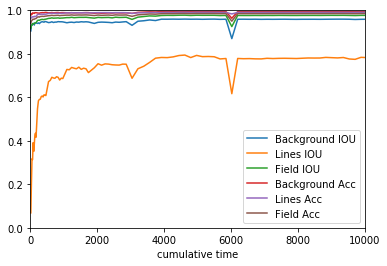

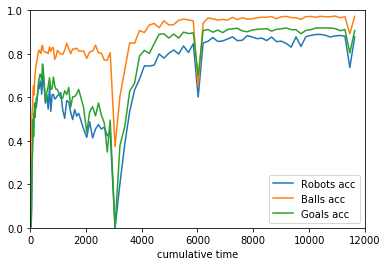

In [21]:
df5 = pd.read_csv('/home/user/jacobs/cudavision/Logs/test_logs_2_672.csv',skiprows=[1,2,3,4,5])
show_df_seg(df5)
show_df_det(df5)

# What is the impact of total variation loss?

- No TV loss
- Anisotropic TV: 0.01
- Isotropic TV: 0.01

In [ ]:
def experiment6():
    schedule = [{'input_dimension': (3*32*5,4*32*5), 'epoch': 5,'phase': 'thaw', 'mode': 'det'}] \
         + [{'input_dimension': (3*32*i,4*32*i), 'epoch': 10,'phase': 'freeze', 'mode': 'concurrent'} for i in range(1,6)] \
         + [{'input_dimension': (3*32*5,4*32*5), 'epoch': 50,'phase': 'thaw', 'mode': 'concurrent'}]

    model_args = {
        'concatenated_bias' : 'shared',
        'concatenated_bias_learnable' : False,
        'added_bias': 'shared',
    }
    args['model_args'] = model_args
    args['l3'] = 0
    args['l4'] = 0
    args['size_after_transform'] = schedule[0]['input_dimension']
    model = Net(**args['model_args'],input_dimension = args['size_after_transform']).to(device)
    optimizer = optim.Adam(model.parameters(), 0.001)
    scheduler = CyclicLR(optimizer, base_lr=args['lr'],max_lr=args['max_lr'],cycle_momentum=False)
    epoch = 0

    run_id = 673

    log_loc = os.path.join(working_dir,f'Logs/test_logs_2_{run_id}.csv')
    logger = Logger(run_loc,log_loc,run_id,args)

    resume = False
    if resume == True:
        model.load_state_dict(torch.load(os.path.join(working_dir,f"Models/final_model_{run_id}.pt")))    
    if args['save_model']:
        torch.save(model.state_dict(), os.path.join(working_dir,f"Models/final_model_{run_id}.pt"))
    
    start_time = time.time()

    for phase in schedule:
        print(phase)
        for mode in modes:
            train_dataset[mode] = RobotsDatasetPrecomputed(meta,mode = mode,input_dimension=phase['input_dimension'],device=device,split='train')
            train_loader[mode] = torch.utils.data.DataLoader(train_dataset[mode],batch_size=args['batch_size'], shuffle=True)
            test_dataset[mode] = RobotsDatasetPrecomputed(meta,mode = mode,input_dimension=phase['input_dimension'],device=device,split='test')
            test_loader[mode] = torch.utils.data.DataLoader(test_dataset[mode],batch_size=args['test_batch_size'], shuffle=False)

        model.set_input_dimension(phase['input_dimension'])

        if phase['phase'] == 'freeze':
            model.freeze_encoder()
        else:
            model.unfreeze_encoder()


        for _ in range(phase['epoch']):
            epoch = epoch + 1
            if phase['mode'] == 'concurrent':
                train_concurrent(args, model, device, train_loader[phase['mode']], optimizer, epoch ,logger=logger)
            else: 
                train(args, model, device, train_loader[phase['mode']], optimizer, epoch , mode = phase['mode'],logger=logger)

            test(args, model, device, test_loader['det'], mode = 'det',logger=logger)
            test(args, model, device, test_loader['seg'], mode = 'seg',logger=logger)
            scheduler.step()
            logger.log_data()

            if args['save_model']:
                torch.save(model.state_dict(), os.path.join(working_dir,f"Models/final_model_{run_id}.pt"))
                
    return time.time() - start_time

In [11]:
experiment6()

{'input_dimension': (480, 640), 'epoch': 5, 'phase': 'thaw', 'mode': 'det'}
Train Epoch det: 1 [0/6194(0%)]	Loss: 1.773537, time: 0.09830474853515625
Train Epoch det: 1 [100/6194(2%)]	Loss: 0.175496, time: 1.353349208831787
Train Epoch det: 1 [200/6194(3%)]	Loss: 0.055715, time: 1.352806568145752
Train Epoch det: 1 [300/6194(5%)]	Loss: 0.043311, time: 1.3552942276000977
Train Epoch det: 1 [400/6194(6%)]	Loss: 0.032408, time: 1.3548734188079834
Train Epoch det: 1 [500/6194(8%)]	Loss: 0.023380, time: 1.3570165634155273
Train Epoch det: 1 [600/6194(10%)]	Loss: 0.024523, time: 1.3548235893249512
Train Epoch det: 1 [700/6194(11%)]	Loss: 0.021377, time: 1.3515973091125488
Train Epoch det: 1 [800/6194(13%)]	Loss: 0.019956, time: 1.352238655090332
Train Epoch det: 1 [900/6194(15%)]	Loss: 0.020305, time: 1.352893590927124
Train Epoch det: 1 [1000/6194(16%)]	Loss: 0.019634, time: 1.3549580574035645
Train Epoch det: 1 [1100/6194(18%)]	Loss: 0.022027, time: 1.3559701442718506
Train Epoch det: 1 [1

/home/user/jacobs/cudavision/metric_detection.py:89: RuntimeWarning: invalid value encountered in double_scalars
  recall = correct/(correct+FN)
/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))



Test set: seg Average loss: 0.1101

Background: IOU: 0.2923, accuracy: 0.7199
Lines: IOU: 0.0183, accuracy: 0.7071
Field: IOU: 0.4614, accuracy: 0.5607
Total: IOU: 0.2573, accuracy: 0.6625
making log csv
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_673.csv
Train Epoch det: 2 [0/6194(0%)]	Loss: 0.013020, time: 0.0764462947845459
Train Epoch det: 2 [100/6194(2%)]	Loss: 0.010121, time: 1.3611748218536377
Train Epoch det: 2 [200/6194(3%)]	Loss: 0.010728, time: 1.359020709991455
Train Epoch det: 2 [300/6194(5%)]	Loss: 0.014285, time: 1.3573708534240723
Train Epoch det: 2 [400/6194(6%)]	Loss: 0.013745, time: 1.3604087829589844
Train Epoch det: 2 [500/6194(8%)]	Loss: 0.014641, time: 1.3620984554290771
Train Epoch det: 2 [600/6194(10%)]	Loss: 0.011908, time: 1.3645837306976318
Train Epoch det: 2 [700/6194(11%)]	Loss: 0.009539, time: 1.3639390468597412
Train Epoch det: 2 [800/6194(13%)]	Loss: 0.014222, time: 1.3619732856750488
Train Epoch det: 2 [900/6194(15%)]	Loss: 0.012999

Train Epoch det: 3 [3500/6194(56%)]	Loss: 0.007756, time: 1.36311674118042
Train Epoch det: 3 [3600/6194(58%)]	Loss: 0.006914, time: 1.3610544204711914
Train Epoch det: 3 [3700/6194(60%)]	Loss: 0.005676, time: 1.3617725372314453
Train Epoch det: 3 [3800/6194(61%)]	Loss: 0.007214, time: 1.3637323379516602
Train Epoch det: 3 [3900/6194(63%)]	Loss: 0.006989, time: 1.3663227558135986
Train Epoch det: 3 [4000/6194(65%)]	Loss: 0.006971, time: 1.3615193367004395
Train Epoch det: 3 [4100/6194(66%)]	Loss: 0.009034, time: 1.3611831665039062
Train Epoch det: 3 [4200/6194(68%)]	Loss: 0.008951, time: 1.366269588470459
Train Epoch det: 3 [4300/6194(69%)]	Loss: 0.007080, time: 1.3620927333831787
Train Epoch det: 3 [4400/6194(71%)]	Loss: 0.005224, time: 1.3594133853912354
Train Epoch det: 3 [4500/6194(73%)]	Loss: 0.006175, time: 1.3607852458953857
Train Epoch det: 3 [4600/6194(74%)]	Loss: 0.007783, time: 1.3631000518798828
Train Epoch det: 3 [4700/6194(76%)]	Loss: 0.007611, time: 1.3608343601226807
Tr

Train Epoch det: 5 [400/6194(6%)]	Loss: 0.003781, time: 1.3631083965301514
Train Epoch det: 5 [500/6194(8%)]	Loss: 0.004703, time: 1.3648452758789062
Train Epoch det: 5 [600/6194(10%)]	Loss: 0.003808, time: 1.3630897998809814
Train Epoch det: 5 [700/6194(11%)]	Loss: 0.004496, time: 1.3608601093292236
Train Epoch det: 5 [800/6194(13%)]	Loss: 0.007636, time: 1.3613426685333252
Train Epoch det: 5 [900/6194(15%)]	Loss: 0.004817, time: 1.3621931076049805
Train Epoch det: 5 [1000/6194(16%)]	Loss: 0.004700, time: 1.3642547130584717
Train Epoch det: 5 [1100/6194(18%)]	Loss: 0.006605, time: 1.3646667003631592
Train Epoch det: 5 [1200/6194(19%)]	Loss: 0.006056, time: 1.3632075786590576
Train Epoch det: 5 [1300/6194(21%)]	Loss: 0.004834, time: 1.363401174545288
Train Epoch det: 5 [1400/6194(23%)]	Loss: 0.005052, time: 1.3611080646514893
Train Epoch det: 5 [1500/6194(24%)]	Loss: 0.004579, time: 1.3630082607269287
Train Epoch det: 5 [1600/6194(26%)]	Loss: 0.004778, time: 1.3622679710388184
Train Ep

/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))


Train Epoch concurrent: 6 [0/6194(0%)]	Loss: 0.129322, time: 0.04688262939453125
Train Epoch concurrent: 6 [100/6194(2%)]	Loss: 0.078119, time: 0.4464693069458008
Train Epoch concurrent: 6 [200/6194(3%)]	Loss: 0.053765, time: 0.43881845474243164
Train Epoch concurrent: 6 [300/6194(5%)]	Loss: 0.052439, time: 0.42743778228759766
Train Epoch concurrent: 6 [400/6194(6%)]	Loss: 0.044108, time: 0.41974496841430664
Train Epoch concurrent: 6 [500/6194(8%)]	Loss: 0.044912, time: 0.4091334342956543
Train Epoch concurrent: 6 [600/6194(10%)]	Loss: 0.043654, time: 0.41047072410583496
Train Epoch concurrent: 6 [700/6194(11%)]	Loss: 0.038158, time: 0.40453171730041504
Train Epoch concurrent: 6 [800/6194(13%)]	Loss: 0.035867, time: 0.39608025550842285
Train Epoch concurrent: 6 [900/6194(15%)]	Loss: 0.032511, time: 0.38715314865112305
Train Epoch concurrent: 6 [1000/6194(16%)]	Loss: 0.036476, time: 0.3897380828857422
Train Epoch concurrent: 6 [1100/6194(18%)]	Loss: 0.029020, time: 0.4244680404663086
Tr

/home/user/jacobs/cudavision/metric_segmentation.py:51: RuntimeWarning: invalid value encountered in true_divide
  IOU_imagewise[:,i] = true_positives_imagewise[cat]/(true_positives_imagewise[cat] + false_positives_imagewise[cat] + false_negatives_imagewise[cat])



Test set: seg Average loss: 0.0155

Background: IOU: 0.9199, accuracy: 0.9819
Lines: IOU: 0.0714, accuracy: 0.9629
Field: IOU: 0.9223, accuracy: 0.9456
Total: IOU: 0.6379, accuracy: 0.9635
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_673.csv
Train Epoch concurrent: 7 [0/6194(0%)]	Loss: 0.019964, time: 0.028731107711791992
Train Epoch concurrent: 7 [100/6194(2%)]	Loss: 0.023219, time: 0.28221774101257324
Train Epoch concurrent: 7 [200/6194(3%)]	Loss: 0.029467, time: 0.27707433700561523
Train Epoch concurrent: 7 [300/6194(5%)]	Loss: 0.018727, time: 0.279416561126709
Train Epoch concurrent: 7 [400/6194(6%)]	Loss: 0.020716, time: 0.27815961837768555
Train Epoch concurrent: 7 [500/6194(8%)]	Loss: 0.021759, time: 0.27924132347106934
Train Epoch concurrent: 7 [600/6194(10%)]	Loss: 0.018682, time: 0.27648234367370605
Train Epoch concurrent: 7 [700/6194(11%)]	Loss: 0.025659, time: 0.2787003517150879
Train Epoch concurrent: 7 [800/6194(13%)]	Loss: 0.021167, time: 0.27745699882

Train Epoch concurrent: 8 [2600/6194(42%)]	Loss: 0.015481, time: 0.27880215644836426
Train Epoch concurrent: 8 [2700/6194(44%)]	Loss: 0.018564, time: 0.27993226051330566
Train Epoch concurrent: 8 [2800/6194(45%)]	Loss: 0.015953, time: 0.27714061737060547
Train Epoch concurrent: 8 [2900/6194(47%)]	Loss: 0.016309, time: 0.2795114517211914
Train Epoch concurrent: 8 [3000/6194(48%)]	Loss: 0.017344, time: 0.2915225028991699
Train Epoch concurrent: 8 [3100/6194(50%)]	Loss: 0.023796, time: 0.2805776596069336
Train Epoch concurrent: 8 [3200/6194(52%)]	Loss: 0.012321, time: 0.2786900997161865
Train Epoch concurrent: 8 [3300/6194(53%)]	Loss: 0.019033, time: 0.27771735191345215
Train Epoch concurrent: 8 [3400/6194(55%)]	Loss: 0.013481, time: 0.2788658142089844
Train Epoch concurrent: 8 [3500/6194(56%)]	Loss: 0.014625, time: 0.2772679328918457
Train Epoch concurrent: 8 [3600/6194(58%)]	Loss: 0.012717, time: 0.2786705493927002
Train Epoch concurrent: 8 [3700/6194(60%)]	Loss: 0.015511, time: 0.27767

Train Epoch concurrent: 9 [5500/6194(89%)]	Loss: 0.010226, time: 0.27832770347595215
Train Epoch concurrent: 9 [5600/6194(90%)]	Loss: 0.012529, time: 0.27957916259765625
Train Epoch concurrent: 9 [5700/6194(92%)]	Loss: 0.010350, time: 0.2777829170227051
Train Epoch concurrent: 9 [5800/6194(94%)]	Loss: 0.010928, time: 0.2794971466064453
Train Epoch concurrent: 9 [5900/6194(95%)]	Loss: 0.011354, time: 0.27921342849731445
Train Epoch concurrent: 9 [6000/6194(97%)]	Loss: 0.013154, time: 0.27892470359802246
Train Epoch concurrent: 9 [6100/6194(98%)]	Loss: 0.010260, time: 0.2798318862915039

Test set: det Average loss: 0.0053

Balls: F1: 0.7455, accuracy: 0.5943, recall: 0.9300, precision: 0.6221, FDR: 0.3779,
Goalposts: F1: 0.5258, accuracy: 0.3567, recall: 0.7856, precision: 0.3952, FDR: 0.6048,
Robots: F1: 0.5932, accuracy: 0.4217, recall: 0.8065, precision: 0.4691, FDR: 0.5309,

Test set: seg Average loss: 0.0111

Background: IOU: 0.9409, accuracy: 0.9893
Lines: IOU: 0.3494, accuracy: 0.

Train Epoch concurrent: 11 [1500/6194(24%)]	Loss: 0.009549, time: 0.2815589904785156
Train Epoch concurrent: 11 [1600/6194(26%)]	Loss: 0.009345, time: 0.27776169776916504
Train Epoch concurrent: 11 [1700/6194(27%)]	Loss: 0.010879, time: 0.28001928329467773
Train Epoch concurrent: 11 [1800/6194(29%)]	Loss: 0.010673, time: 0.2782557010650635
Train Epoch concurrent: 11 [1900/6194(31%)]	Loss: 0.010871, time: 0.27935028076171875
Train Epoch concurrent: 11 [2000/6194(32%)]	Loss: 0.010435, time: 0.28051328659057617
Train Epoch concurrent: 11 [2100/6194(34%)]	Loss: 0.010241, time: 0.27814269065856934
Train Epoch concurrent: 11 [2200/6194(35%)]	Loss: 0.009516, time: 0.27966952323913574
Train Epoch concurrent: 11 [2300/6194(37%)]	Loss: 0.009373, time: 0.27776479721069336
Train Epoch concurrent: 11 [2400/6194(39%)]	Loss: 0.012985, time: 0.27935314178466797
Train Epoch concurrent: 11 [2500/6194(40%)]	Loss: 0.009668, time: 0.278611421585083
Train Epoch concurrent: 11 [2600/6194(42%)]	Loss: 0.011112

Train Epoch concurrent: 12 [4300/6194(69%)]	Loss: 0.008803, time: 0.278836727142334
Train Epoch concurrent: 12 [4400/6194(71%)]	Loss: 0.008819, time: 0.2792367935180664
Train Epoch concurrent: 12 [4500/6194(73%)]	Loss: 0.006387, time: 0.28012871742248535
Train Epoch concurrent: 12 [4600/6194(74%)]	Loss: 0.008195, time: 0.2781860828399658
Train Epoch concurrent: 12 [4700/6194(76%)]	Loss: 0.009840, time: 0.279435396194458
Train Epoch concurrent: 12 [4800/6194(77%)]	Loss: 0.008608, time: 0.27842211723327637
Train Epoch concurrent: 12 [4900/6194(79%)]	Loss: 0.008263, time: 0.27914929389953613
Train Epoch concurrent: 12 [5000/6194(81%)]	Loss: 0.007480, time: 0.27806925773620605
Train Epoch concurrent: 12 [5100/6194(82%)]	Loss: 0.009126, time: 0.2790205478668213
Train Epoch concurrent: 12 [5200/6194(84%)]	Loss: 0.010476, time: 0.2795898914337158
Train Epoch concurrent: 12 [5300/6194(85%)]	Loss: 0.007370, time: 0.2799241542816162
Train Epoch concurrent: 12 [5400/6194(87%)]	Loss: 0.007503, tim

Train Epoch concurrent: 14 [300/6194(5%)]	Loss: 0.008864, time: 0.2782890796661377
Train Epoch concurrent: 14 [400/6194(6%)]	Loss: 0.011485, time: 0.2797729969024658
Train Epoch concurrent: 14 [500/6194(8%)]	Loss: 0.008737, time: 0.27840757369995117
Train Epoch concurrent: 14 [600/6194(10%)]	Loss: 0.007922, time: 0.27976346015930176
Train Epoch concurrent: 14 [700/6194(11%)]	Loss: 0.006732, time: 0.27849411964416504
Train Epoch concurrent: 14 [800/6194(13%)]	Loss: 0.008841, time: 0.27930665016174316
Train Epoch concurrent: 14 [900/6194(15%)]	Loss: 0.007988, time: 0.2791714668273926
Train Epoch concurrent: 14 [1000/6194(16%)]	Loss: 0.009045, time: 0.2789154052734375
Train Epoch concurrent: 14 [1100/6194(18%)]	Loss: 0.008188, time: 0.279740571975708
Train Epoch concurrent: 14 [1200/6194(19%)]	Loss: 0.006712, time: 0.2789299488067627
Train Epoch concurrent: 14 [1300/6194(21%)]	Loss: 0.006447, time: 0.2791421413421631
Train Epoch concurrent: 14 [1400/6194(23%)]	Loss: 0.006849, time: 0.2781

Train Epoch concurrent: 15 [3100/6194(50%)]	Loss: 0.005724, time: 0.2792084217071533
Train Epoch concurrent: 15 [3200/6194(52%)]	Loss: 0.008725, time: 0.27655768394470215
Train Epoch concurrent: 15 [3300/6194(53%)]	Loss: 0.009404, time: 0.279249906539917
Train Epoch concurrent: 15 [3400/6194(55%)]	Loss: 0.006935, time: 0.2759275436401367
Train Epoch concurrent: 15 [3500/6194(56%)]	Loss: 0.005379, time: 0.2792243957519531
Train Epoch concurrent: 15 [3600/6194(58%)]	Loss: 0.008983, time: 0.27608466148376465
Train Epoch concurrent: 15 [3700/6194(60%)]	Loss: 0.005977, time: 0.27886486053466797
Train Epoch concurrent: 15 [3800/6194(61%)]	Loss: 0.007692, time: 0.27660560607910156
Train Epoch concurrent: 15 [3900/6194(63%)]	Loss: 0.011876, time: 0.2789492607116699
Train Epoch concurrent: 15 [4000/6194(65%)]	Loss: 0.007646, time: 0.27774763107299805
Train Epoch concurrent: 15 [4100/6194(66%)]	Loss: 0.007850, time: 0.2755906581878662
Train Epoch concurrent: 15 [4200/6194(68%)]	Loss: 0.006379, t

/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))


Train Epoch concurrent: 16 [0/6194(0%)]	Loss: 0.048963, time: 0.10704827308654785
Train Epoch concurrent: 16 [100/6194(2%)]	Loss: 0.020603, time: 1.010056972503662
Train Epoch concurrent: 16 [200/6194(3%)]	Loss: 0.021000, time: 0.965792179107666
Train Epoch concurrent: 16 [300/6194(5%)]	Loss: 0.019963, time: 0.8861536979675293
Train Epoch concurrent: 16 [400/6194(6%)]	Loss: 0.024577, time: 0.820936918258667
Train Epoch concurrent: 16 [500/6194(8%)]	Loss: 0.013975, time: 0.8261055946350098
Train Epoch concurrent: 16 [600/6194(10%)]	Loss: 0.029113, time: 0.8651328086853027
Train Epoch concurrent: 16 [700/6194(11%)]	Loss: 0.018494, time: 0.7759630680084229
Train Epoch concurrent: 16 [800/6194(13%)]	Loss: 0.013534, time: 0.7428526878356934
Train Epoch concurrent: 16 [900/6194(15%)]	Loss: 0.017666, time: 0.7695963382720947
Train Epoch concurrent: 16 [1000/6194(16%)]	Loss: 0.024654, time: 0.7236523628234863
Train Epoch concurrent: 16 [1100/6194(18%)]	Loss: 0.014617, time: 0.7192902565002441


Train Epoch concurrent: 17 [2900/6194(47%)]	Loss: 0.008691, time: 0.4394042491912842
Train Epoch concurrent: 17 [3000/6194(48%)]	Loss: 0.014473, time: 0.44045281410217285
Train Epoch concurrent: 17 [3100/6194(50%)]	Loss: 0.009097, time: 0.4397003650665283
Train Epoch concurrent: 17 [3200/6194(52%)]	Loss: 0.020762, time: 0.43810462951660156
Train Epoch concurrent: 17 [3300/6194(53%)]	Loss: 0.010551, time: 0.4383513927459717
Train Epoch concurrent: 17 [3400/6194(55%)]	Loss: 0.011269, time: 0.44023942947387695
Train Epoch concurrent: 17 [3500/6194(56%)]	Loss: 0.010055, time: 0.43995237350463867
Train Epoch concurrent: 17 [3600/6194(58%)]	Loss: 0.012741, time: 0.4405059814453125
Train Epoch concurrent: 17 [3700/6194(60%)]	Loss: 0.009911, time: 0.44004297256469727
Train Epoch concurrent: 17 [3800/6194(61%)]	Loss: 0.014398, time: 0.4407503604888916
Train Epoch concurrent: 17 [3900/6194(63%)]	Loss: 0.011572, time: 0.4403548240661621
Train Epoch concurrent: 17 [4000/6194(65%)]	Loss: 0.013308, 

Train Epoch concurrent: 18 [5700/6194(92%)]	Loss: 0.008711, time: 0.4392430782318115
Train Epoch concurrent: 18 [5800/6194(94%)]	Loss: 0.008762, time: 0.43947315216064453
Train Epoch concurrent: 18 [5900/6194(95%)]	Loss: 0.011295, time: 0.4383544921875
Train Epoch concurrent: 18 [6000/6194(97%)]	Loss: 0.008940, time: 0.43828535079956055
Train Epoch concurrent: 18 [6100/6194(98%)]	Loss: 0.010595, time: 0.44043946266174316

Test set: det Average loss: 0.0058

Balls: F1: 0.8600, accuracy: 0.7544, recall: 0.9615, precision: 0.7779, FDR: 0.2221,
Goalposts: F1: 0.7566, accuracy: 0.6085, recall: 0.8923, precision: 0.6567, FDR: 0.3433,
Robots: F1: 0.7648, accuracy: 0.6192, recall: 0.8563, precision: 0.6910, FDR: 0.3090,

Test set: seg Average loss: 0.0082

Background: IOU: 0.9473, accuracy: 0.9890
Lines: IOU: 0.5783, accuracy: 0.9813
Field: IOU: 0.9565, accuracy: 0.9713
Total: IOU: 0.8274, accuracy: 0.9805
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_673.csv
Train Epoch concu

/home/user/jacobs/cudavision/metric_segmentation.py:51: RuntimeWarning: invalid value encountered in true_divide
  IOU_imagewise[:,i] = true_positives_imagewise[cat]/(true_positives_imagewise[cat] + false_positives_imagewise[cat] + false_negatives_imagewise[cat])



Test set: seg Average loss: 0.0085

Background: IOU: 0.9471, accuracy: 0.9905
Lines: IOU: 0.5837, accuracy: 0.9814
Field: IOU: 0.9577, accuracy: 0.9725
Total: IOU: 0.8295, accuracy: 0.9815
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_673.csv
Train Epoch concurrent: 20 [0/6194(0%)]	Loss: 0.009452, time: 0.037339210510253906
Train Epoch concurrent: 20 [100/6194(2%)]	Loss: 0.009098, time: 0.44242167472839355
Train Epoch concurrent: 20 [200/6194(3%)]	Loss: 0.008771, time: 0.43978428840637207
Train Epoch concurrent: 20 [300/6194(5%)]	Loss: 0.007702, time: 0.438077449798584
Train Epoch concurrent: 20 [400/6194(6%)]	Loss: 0.006845, time: 0.4391348361968994
Train Epoch concurrent: 20 [500/6194(8%)]	Loss: 0.007550, time: 0.44057798385620117
Train Epoch concurrent: 20 [600/6194(10%)]	Loss: 0.006630, time: 0.4395444393157959
Train Epoch concurrent: 20 [700/6194(11%)]	Loss: 0.007428, time: 0.4409146308898926
Train Epoch concurrent: 20 [800/6194(13%)]	Loss: 0.007227, time: 0.4403

Train Epoch concurrent: 21 [2500/6194(40%)]	Loss: 0.006538, time: 0.44786834716796875
Train Epoch concurrent: 21 [2600/6194(42%)]	Loss: 0.006364, time: 0.44186830520629883
Train Epoch concurrent: 21 [2700/6194(44%)]	Loss: 0.009637, time: 0.43979644775390625
Train Epoch concurrent: 21 [2800/6194(45%)]	Loss: 0.005192, time: 0.440777063369751
Train Epoch concurrent: 21 [2900/6194(47%)]	Loss: 0.007095, time: 0.43919801712036133
Train Epoch concurrent: 21 [3000/6194(48%)]	Loss: 0.006420, time: 0.43751096725463867
Train Epoch concurrent: 21 [3100/6194(50%)]	Loss: 0.005694, time: 0.43987560272216797
Train Epoch concurrent: 21 [3200/6194(52%)]	Loss: 0.006826, time: 0.4401977062225342
Train Epoch concurrent: 21 [3300/6194(53%)]	Loss: 0.009575, time: 0.43918561935424805
Train Epoch concurrent: 21 [3400/6194(55%)]	Loss: 0.005429, time: 0.4396030902862549
Train Epoch concurrent: 21 [3500/6194(56%)]	Loss: 0.008810, time: 0.4405517578125
Train Epoch concurrent: 21 [3600/6194(58%)]	Loss: 0.005322, ti

Train Epoch concurrent: 22 [5300/6194(85%)]	Loss: 0.006519, time: 0.44063854217529297
Train Epoch concurrent: 22 [5400/6194(87%)]	Loss: 0.006001, time: 0.44120311737060547
Train Epoch concurrent: 22 [5500/6194(89%)]	Loss: 0.010409, time: 0.4396834373474121
Train Epoch concurrent: 22 [5600/6194(90%)]	Loss: 0.008606, time: 0.44078707695007324
Train Epoch concurrent: 22 [5700/6194(92%)]	Loss: 0.005268, time: 0.439145565032959
Train Epoch concurrent: 22 [5800/6194(94%)]	Loss: 0.007712, time: 0.4385981559753418
Train Epoch concurrent: 22 [5900/6194(95%)]	Loss: 0.009599, time: 0.4404475688934326
Train Epoch concurrent: 22 [6000/6194(97%)]	Loss: 0.005829, time: 0.441425085067749
Train Epoch concurrent: 22 [6100/6194(98%)]	Loss: 0.005228, time: 0.4428853988647461

Test set: det Average loss: 0.0052

Balls: F1: 0.8690, accuracy: 0.7683, recall: 0.9628, precision: 0.7918, FDR: 0.2082,
Goalposts: F1: 0.8397, accuracy: 0.7236, recall: 0.9138, precision: 0.7767, FDR: 0.2233,
Robots: F1: 0.7951, acc

Train Epoch concurrent: 24 [1300/6194(21%)]	Loss: 0.003869, time: 0.4488389492034912
Train Epoch concurrent: 24 [1400/6194(23%)]	Loss: 0.006829, time: 0.4454505443572998
Train Epoch concurrent: 24 [1500/6194(24%)]	Loss: 0.007086, time: 0.4405386447906494
Train Epoch concurrent: 24 [1600/6194(26%)]	Loss: 0.005140, time: 0.43961381912231445
Train Epoch concurrent: 24 [1700/6194(27%)]	Loss: 0.006721, time: 0.44272279739379883
Train Epoch concurrent: 24 [1800/6194(29%)]	Loss: 0.004685, time: 0.43784022331237793
Train Epoch concurrent: 24 [1900/6194(31%)]	Loss: 0.004431, time: 0.44300389289855957
Train Epoch concurrent: 24 [2000/6194(32%)]	Loss: 0.007112, time: 0.4435880184173584
Train Epoch concurrent: 24 [2100/6194(34%)]	Loss: 0.004811, time: 0.44367241859436035
Train Epoch concurrent: 24 [2200/6194(35%)]	Loss: 0.004678, time: 0.44280290603637695
Train Epoch concurrent: 24 [2300/6194(37%)]	Loss: 0.003636, time: 0.440932035446167
Train Epoch concurrent: 24 [2400/6194(39%)]	Loss: 0.004780, 

Train Epoch concurrent: 25 [4100/6194(66%)]	Loss: 0.004598, time: 0.44669675827026367
Train Epoch concurrent: 25 [4200/6194(68%)]	Loss: 0.005794, time: 0.44520044326782227
Train Epoch concurrent: 25 [4300/6194(69%)]	Loss: 0.005595, time: 0.44022226333618164
Train Epoch concurrent: 25 [4400/6194(71%)]	Loss: 0.003767, time: 0.4417610168457031
Train Epoch concurrent: 25 [4500/6194(73%)]	Loss: 0.005232, time: 0.4394490718841553
Train Epoch concurrent: 25 [4600/6194(74%)]	Loss: 0.005868, time: 0.4401893615722656
Train Epoch concurrent: 25 [4700/6194(76%)]	Loss: 0.003647, time: 0.4393119812011719
Train Epoch concurrent: 25 [4800/6194(77%)]	Loss: 0.005380, time: 0.43880605697631836
Train Epoch concurrent: 25 [4900/6194(79%)]	Loss: 0.008186, time: 0.44364285469055176
Train Epoch concurrent: 25 [5000/6194(81%)]	Loss: 0.004870, time: 0.44381046295166016
Train Epoch concurrent: 25 [5100/6194(82%)]	Loss: 0.005634, time: 0.4395580291748047
Train Epoch concurrent: 25 [5200/6194(84%)]	Loss: 0.004073,

/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))


Train Epoch concurrent: 26 [0/6194(0%)]	Loss: 0.029538, time: 0.12712454795837402
Train Epoch concurrent: 26 [100/6194(2%)]	Loss: 0.016614, time: 1.5347239971160889
Train Epoch concurrent: 26 [200/6194(3%)]	Loss: 0.014765, time: 1.667612075805664
Train Epoch concurrent: 26 [300/6194(5%)]	Loss: 0.017703, time: 1.5996308326721191
Train Epoch concurrent: 26 [400/6194(6%)]	Loss: 0.012853, time: 1.5603771209716797
Train Epoch concurrent: 26 [500/6194(8%)]	Loss: 0.014483, time: 1.5224485397338867
Train Epoch concurrent: 26 [600/6194(10%)]	Loss: 0.011757, time: 1.4764339923858643
Train Epoch concurrent: 26 [700/6194(11%)]	Loss: 0.017992, time: 1.3873915672302246
Train Epoch concurrent: 26 [800/6194(13%)]	Loss: 0.014830, time: 1.3809432983398438
Train Epoch concurrent: 26 [900/6194(15%)]	Loss: 0.012427, time: 1.344299554824829
Train Epoch concurrent: 26 [1000/6194(16%)]	Loss: 0.012760, time: 1.3158552646636963
Train Epoch concurrent: 26 [1100/6194(18%)]	Loss: 0.025084, time: 1.2948215007781982

Train Epoch concurrent: 27 [2900/6194(47%)]	Loss: 0.008723, time: 0.7297933101654053
Train Epoch concurrent: 27 [3000/6194(48%)]	Loss: 0.010505, time: 0.7319827079772949
Train Epoch concurrent: 27 [3100/6194(50%)]	Loss: 0.008164, time: 0.7362525463104248
Train Epoch concurrent: 27 [3200/6194(52%)]	Loss: 0.007517, time: 0.7357399463653564
Train Epoch concurrent: 27 [3300/6194(53%)]	Loss: 0.010061, time: 0.731452465057373
Train Epoch concurrent: 27 [3400/6194(55%)]	Loss: 0.007839, time: 0.7334599494934082
Train Epoch concurrent: 27 [3500/6194(56%)]	Loss: 0.010437, time: 0.7308766841888428
Train Epoch concurrent: 27 [3600/6194(58%)]	Loss: 0.007171, time: 0.7330517768859863
Train Epoch concurrent: 27 [3700/6194(60%)]	Loss: 0.008921, time: 0.7314431667327881
Train Epoch concurrent: 27 [3800/6194(61%)]	Loss: 0.008633, time: 0.7325596809387207
Train Epoch concurrent: 27 [3900/6194(63%)]	Loss: 0.008769, time: 0.7303576469421387
Train Epoch concurrent: 27 [4000/6194(65%)]	Loss: 0.011062, time: 

Train Epoch concurrent: 28 [5800/6194(94%)]	Loss: 0.006165, time: 0.7308664321899414
Train Epoch concurrent: 28 [5900/6194(95%)]	Loss: 0.010031, time: 0.7360498905181885
Train Epoch concurrent: 28 [6000/6194(97%)]	Loss: 0.006617, time: 0.7314548492431641
Train Epoch concurrent: 28 [6100/6194(98%)]	Loss: 0.005312, time: 0.7348048686981201

Test set: det Average loss: 0.0042

Balls: F1: 0.9234, accuracy: 0.8577, recall: 0.9842, precision: 0.8697, FDR: 0.1303,
Goalposts: F1: 0.8049, accuracy: 0.6736, recall: 0.9403, precision: 0.7036, FDR: 0.2964,
Robots: F1: 0.7867, accuracy: 0.6484, recall: 0.9073, precision: 0.6944, FDR: 0.3056,

Test set: seg Average loss: 0.0069

Background: IOU: 0.9478, accuracy: 0.9896
Lines: IOU: 0.6731, accuracy: 0.9858
Field: IOU: 0.9637, accuracy: 0.9761
Total: IOU: 0.8615, accuracy: 0.9839
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_673.csv
Train Epoch concurrent: 29 [0/6194(0%)]	Loss: 0.006994, time: 0.05491042137145996
Train Epoch concurre

Train Epoch concurrent: 30 [1800/6194(29%)]	Loss: 0.005986, time: 0.7346968650817871
Train Epoch concurrent: 30 [1900/6194(31%)]	Loss: 0.005598, time: 0.7349562644958496
Train Epoch concurrent: 30 [2000/6194(32%)]	Loss: 0.006856, time: 0.7324700355529785
Train Epoch concurrent: 30 [2100/6194(34%)]	Loss: 0.005623, time: 0.7336587905883789
Train Epoch concurrent: 30 [2200/6194(35%)]	Loss: 0.004858, time: 0.7328543663024902
Train Epoch concurrent: 30 [2300/6194(37%)]	Loss: 0.006946, time: 0.7343060970306396
Train Epoch concurrent: 30 [2400/6194(39%)]	Loss: 0.007464, time: 0.7321262359619141
Train Epoch concurrent: 30 [2500/6194(40%)]	Loss: 0.007479, time: 0.7362151145935059
Train Epoch concurrent: 30 [2600/6194(42%)]	Loss: 0.008549, time: 0.73321533203125
Train Epoch concurrent: 30 [2700/6194(44%)]	Loss: 0.007914, time: 0.7345113754272461
Train Epoch concurrent: 30 [2800/6194(45%)]	Loss: 0.005478, time: 0.7312238216400146
Train Epoch concurrent: 30 [2900/6194(47%)]	Loss: 0.007424, time: 0

Train Epoch concurrent: 31 [4700/6194(76%)]	Loss: 0.006849, time: 0.7379615306854248
Train Epoch concurrent: 31 [4800/6194(77%)]	Loss: 0.004631, time: 0.7341251373291016
Train Epoch concurrent: 31 [4900/6194(79%)]	Loss: 0.005650, time: 0.7345621585845947
Train Epoch concurrent: 31 [5000/6194(81%)]	Loss: 0.007390, time: 0.7346742153167725
Train Epoch concurrent: 31 [5100/6194(82%)]	Loss: 0.005951, time: 0.7404875755310059
Train Epoch concurrent: 31 [5200/6194(84%)]	Loss: 0.006794, time: 0.7330231666564941
Train Epoch concurrent: 31 [5300/6194(85%)]	Loss: 0.005210, time: 0.736414909362793
Train Epoch concurrent: 31 [5400/6194(87%)]	Loss: 0.005225, time: 0.7352375984191895
Train Epoch concurrent: 31 [5500/6194(89%)]	Loss: 0.006666, time: 0.735867977142334
Train Epoch concurrent: 31 [5600/6194(90%)]	Loss: 0.005307, time: 0.7333359718322754
Train Epoch concurrent: 31 [5700/6194(92%)]	Loss: 0.004891, time: 0.7378997802734375
Train Epoch concurrent: 31 [5800/6194(94%)]	Loss: 0.004845, time: 0

Train Epoch concurrent: 33 [700/6194(11%)]	Loss: 0.006499, time: 0.7344129085540771
Train Epoch concurrent: 33 [800/6194(13%)]	Loss: 0.004154, time: 0.7335326671600342
Train Epoch concurrent: 33 [900/6194(15%)]	Loss: 0.003781, time: 0.7379035949707031
Train Epoch concurrent: 33 [1000/6194(16%)]	Loss: 0.005537, time: 0.7361712455749512
Train Epoch concurrent: 33 [1100/6194(18%)]	Loss: 0.004962, time: 0.7386736869812012
Train Epoch concurrent: 33 [1200/6194(19%)]	Loss: 0.004831, time: 0.7410895824432373
Train Epoch concurrent: 33 [1300/6194(21%)]	Loss: 0.004454, time: 0.73403000831604
Train Epoch concurrent: 33 [1400/6194(23%)]	Loss: 0.003663, time: 0.7425076961517334
Train Epoch concurrent: 33 [1500/6194(24%)]	Loss: 0.004279, time: 0.7366795539855957
Train Epoch concurrent: 33 [1600/6194(26%)]	Loss: 0.005425, time: 0.7353296279907227
Train Epoch concurrent: 33 [1700/6194(27%)]	Loss: 0.006425, time: 0.7351462841033936
Train Epoch concurrent: 33 [1800/6194(29%)]	Loss: 0.003581, time: 0.73

Train Epoch concurrent: 34 [3600/6194(58%)]	Loss: 0.003670, time: 0.7318148612976074
Train Epoch concurrent: 34 [3700/6194(60%)]	Loss: 0.004437, time: 0.7323267459869385
Train Epoch concurrent: 34 [3800/6194(61%)]	Loss: 0.004864, time: 0.7330281734466553
Train Epoch concurrent: 34 [3900/6194(63%)]	Loss: 0.004353, time: 0.7341842651367188
Train Epoch concurrent: 34 [4000/6194(65%)]	Loss: 0.005370, time: 0.7321207523345947
Train Epoch concurrent: 34 [4100/6194(66%)]	Loss: 0.003365, time: 0.7350475788116455
Train Epoch concurrent: 34 [4200/6194(68%)]	Loss: 0.003845, time: 0.7307922840118408
Train Epoch concurrent: 34 [4300/6194(69%)]	Loss: 0.005752, time: 0.7351119518280029
Train Epoch concurrent: 34 [4400/6194(71%)]	Loss: 0.003871, time: 0.7307686805725098
Train Epoch concurrent: 34 [4500/6194(73%)]	Loss: 0.004791, time: 0.7334673404693604
Train Epoch concurrent: 34 [4600/6194(74%)]	Loss: 0.008001, time: 0.7300279140472412
Train Epoch concurrent: 34 [4700/6194(76%)]	Loss: 0.003868, time:


Test set: seg Average loss: 0.0089

Background: IOU: 0.9503, accuracy: 0.9905
Lines: IOU: 0.6691, accuracy: 0.9858
Field: IOU: 0.9646, accuracy: 0.9769
Total: IOU: 0.8614, accuracy: 0.9844
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_673.csv
{'input_dimension': (384, 512), 'epoch': 10, 'phase': 'freeze', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))


Train Epoch concurrent: 36 [0/6194(0%)]	Loss: 0.015347, time: 0.19080805778503418
Train Epoch concurrent: 36 [100/6194(2%)]	Loss: 0.011311, time: 2.4945435523986816
Train Epoch concurrent: 36 [200/6194(3%)]	Loss: 0.013944, time: 2.4081742763519287
Train Epoch concurrent: 36 [300/6194(5%)]	Loss: 0.012663, time: 2.387150764465332
Train Epoch concurrent: 36 [400/6194(6%)]	Loss: 0.016430, time: 2.34690523147583
Train Epoch concurrent: 36 [500/6194(8%)]	Loss: 0.010489, time: 2.3287863731384277
Train Epoch concurrent: 36 [600/6194(10%)]	Loss: 0.008044, time: 2.1562204360961914
Train Epoch concurrent: 36 [700/6194(11%)]	Loss: 0.015457, time: 2.2189853191375732
Train Epoch concurrent: 36 [800/6194(13%)]	Loss: 0.011428, time: 2.1561009883880615
Train Epoch concurrent: 36 [900/6194(15%)]	Loss: 0.009482, time: 2.0081887245178223
Train Epoch concurrent: 36 [1000/6194(16%)]	Loss: 0.011307, time: 2.0431768894195557
Train Epoch concurrent: 36 [1100/6194(18%)]	Loss: 0.009027, time: 2.0165092945098877


Train Epoch concurrent: 37 [2900/6194(47%)]	Loss: 0.006490, time: 1.1234428882598877
Train Epoch concurrent: 37 [3000/6194(48%)]	Loss: 0.006110, time: 1.1199610233306885
Train Epoch concurrent: 37 [3100/6194(50%)]	Loss: 0.007686, time: 1.1184959411621094
Train Epoch concurrent: 37 [3200/6194(52%)]	Loss: 0.005133, time: 1.119493007659912
Train Epoch concurrent: 37 [3300/6194(53%)]	Loss: 0.007326, time: 1.12160325050354
Train Epoch concurrent: 37 [3400/6194(55%)]	Loss: 0.008492, time: 1.1194519996643066
Train Epoch concurrent: 37 [3500/6194(56%)]	Loss: 0.006580, time: 1.1194672584533691
Train Epoch concurrent: 37 [3600/6194(58%)]	Loss: 0.007159, time: 1.1231756210327148
Train Epoch concurrent: 37 [3700/6194(60%)]	Loss: 0.007027, time: 1.1215839385986328
Train Epoch concurrent: 37 [3800/6194(61%)]	Loss: 0.009629, time: 1.1210227012634277
Train Epoch concurrent: 37 [3900/6194(63%)]	Loss: 0.008788, time: 1.1214416027069092
Train Epoch concurrent: 37 [4000/6194(65%)]	Loss: 0.005811, time: 1.

Train Epoch concurrent: 38 [5800/6194(94%)]	Loss: 0.005110, time: 1.1244635581970215
Train Epoch concurrent: 38 [5900/6194(95%)]	Loss: 0.005541, time: 1.1263294219970703
Train Epoch concurrent: 38 [6000/6194(97%)]	Loss: 0.004971, time: 1.1241934299468994
Train Epoch concurrent: 38 [6100/6194(98%)]	Loss: 0.008243, time: 1.1233577728271484

Test set: det Average loss: 0.0037

Balls: F1: 0.9254, accuracy: 0.8611, recall: 0.9891, precision: 0.8693, FDR: 0.1307,
Goalposts: F1: 0.8245, accuracy: 0.7014, recall: 0.9505, precision: 0.7279, FDR: 0.2721,
Robots: F1: 0.7565, accuracy: 0.6083, recall: 0.9248, precision: 0.6400, FDR: 0.3600,

Test set: seg Average loss: 0.0074

Background: IOU: 0.9467, accuracy: 0.9866
Lines: IOU: 0.7235, accuracy: 0.9883
Field: IOU: 0.9642, accuracy: 0.9757
Total: IOU: 0.8781, accuracy: 0.9836
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_673.csv
Train Epoch concurrent: 39 [0/6194(0%)]	Loss: 0.006117, time: 0.08509707450866699
Train Epoch concurre

Train Epoch concurrent: 40 [1800/6194(29%)]	Loss: 0.006662, time: 1.1244773864746094
Train Epoch concurrent: 40 [1900/6194(31%)]	Loss: 0.008812, time: 1.1245214939117432
Train Epoch concurrent: 40 [2000/6194(32%)]	Loss: 0.004546, time: 1.125837802886963
Train Epoch concurrent: 40 [2100/6194(34%)]	Loss: 0.004881, time: 1.1240530014038086
Train Epoch concurrent: 40 [2200/6194(35%)]	Loss: 0.004013, time: 1.1239326000213623
Train Epoch concurrent: 40 [2300/6194(37%)]	Loss: 0.006651, time: 1.1249878406524658
Train Epoch concurrent: 40 [2400/6194(39%)]	Loss: 0.006102, time: 1.127661943435669
Train Epoch concurrent: 40 [2500/6194(40%)]	Loss: 0.006047, time: 1.1233899593353271
Train Epoch concurrent: 40 [2600/6194(42%)]	Loss: 0.004918, time: 1.1246569156646729
Train Epoch concurrent: 40 [2700/6194(44%)]	Loss: 0.004631, time: 1.1255102157592773
Train Epoch concurrent: 40 [2800/6194(45%)]	Loss: 0.004232, time: 1.124340534210205
Train Epoch concurrent: 40 [2900/6194(47%)]	Loss: 0.005426, time: 1.

Train Epoch concurrent: 41 [4700/6194(76%)]	Loss: 0.006039, time: 1.1247520446777344
Train Epoch concurrent: 41 [4800/6194(77%)]	Loss: 0.004134, time: 1.1240379810333252
Train Epoch concurrent: 41 [4900/6194(79%)]	Loss: 0.004617, time: 1.1259291172027588
Train Epoch concurrent: 41 [5000/6194(81%)]	Loss: 0.004647, time: 1.1254339218139648
Train Epoch concurrent: 41 [5100/6194(82%)]	Loss: 0.005505, time: 1.1249513626098633
Train Epoch concurrent: 41 [5200/6194(84%)]	Loss: 0.003567, time: 1.126612901687622
Train Epoch concurrent: 41 [5300/6194(85%)]	Loss: 0.004140, time: 1.1229732036590576
Train Epoch concurrent: 41 [5400/6194(87%)]	Loss: 0.005537, time: 1.12416410446167
Train Epoch concurrent: 41 [5500/6194(89%)]	Loss: 0.005998, time: 1.1250531673431396
Train Epoch concurrent: 41 [5600/6194(90%)]	Loss: 0.003850, time: 1.1237871646881104
Train Epoch concurrent: 41 [5700/6194(92%)]	Loss: 0.005967, time: 1.1262624263763428
Train Epoch concurrent: 41 [5800/6194(94%)]	Loss: 0.004283, time: 1.

Train Epoch concurrent: 43 [700/6194(11%)]	Loss: 0.003976, time: 1.1263444423675537
Train Epoch concurrent: 43 [800/6194(13%)]	Loss: 0.004983, time: 1.124225378036499
Train Epoch concurrent: 43 [900/6194(15%)]	Loss: 0.003764, time: 1.1232364177703857
Train Epoch concurrent: 43 [1000/6194(16%)]	Loss: 0.004725, time: 1.1255643367767334
Train Epoch concurrent: 43 [1100/6194(18%)]	Loss: 0.006858, time: 1.1220941543579102
Train Epoch concurrent: 43 [1200/6194(19%)]	Loss: 0.004715, time: 1.1232144832611084
Train Epoch concurrent: 43 [1300/6194(21%)]	Loss: 0.006943, time: 1.125854253768921
Train Epoch concurrent: 43 [1400/6194(23%)]	Loss: 0.005807, time: 1.1244378089904785
Train Epoch concurrent: 43 [1500/6194(24%)]	Loss: 0.004086, time: 1.1223571300506592
Train Epoch concurrent: 43 [1600/6194(26%)]	Loss: 0.003021, time: 1.1250591278076172
Train Epoch concurrent: 43 [1700/6194(27%)]	Loss: 0.004277, time: 1.1232008934020996
Train Epoch concurrent: 43 [1800/6194(29%)]	Loss: 0.004802, time: 1.12

Train Epoch concurrent: 44 [3600/6194(58%)]	Loss: 0.005186, time: 1.1236529350280762
Train Epoch concurrent: 44 [3700/6194(60%)]	Loss: 0.003360, time: 1.1231884956359863
Train Epoch concurrent: 44 [3800/6194(61%)]	Loss: 0.003904, time: 1.1244699954986572
Train Epoch concurrent: 44 [3900/6194(63%)]	Loss: 0.004158, time: 1.1291472911834717
Train Epoch concurrent: 44 [4000/6194(65%)]	Loss: 0.005231, time: 1.1232645511627197
Train Epoch concurrent: 44 [4100/6194(66%)]	Loss: 0.005583, time: 1.1235101222991943
Train Epoch concurrent: 44 [4200/6194(68%)]	Loss: 0.005216, time: 1.1254653930664062
Train Epoch concurrent: 44 [4300/6194(69%)]	Loss: 0.004442, time: 1.1217215061187744
Train Epoch concurrent: 44 [4400/6194(71%)]	Loss: 0.004870, time: 1.1210846900939941
Train Epoch concurrent: 44 [4500/6194(73%)]	Loss: 0.003853, time: 1.1242547035217285
Train Epoch concurrent: 44 [4600/6194(74%)]	Loss: 0.004987, time: 1.121166467666626
Train Epoch concurrent: 44 [4700/6194(76%)]	Loss: 0.005603, time: 


Test set: seg Average loss: 0.0071

Background: IOU: 0.9496, accuracy: 0.9909
Lines: IOU: 0.7191, accuracy: 0.9882
Field: IOU: 0.9685, accuracy: 0.9796
Total: IOU: 0.8791, accuracy: 0.9862
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_673.csv
{'input_dimension': (480, 640), 'epoch': 10, 'phase': 'freeze', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))


Train Epoch concurrent: 46 [0/6194(0%)]	Loss: 0.015363, time: 0.2856926918029785
Train Epoch concurrent: 46 [100/6194(2%)]	Loss: 0.010228, time: 3.5526621341705322
Train Epoch concurrent: 46 [200/6194(3%)]	Loss: 0.009757, time: 3.5218615531921387
Train Epoch concurrent: 46 [300/6194(5%)]	Loss: 0.010736, time: 3.4626293182373047
Train Epoch concurrent: 46 [400/6194(6%)]	Loss: 0.012406, time: 3.3296167850494385
Train Epoch concurrent: 46 [500/6194(8%)]	Loss: 0.008244, time: 3.2976927757263184
Train Epoch concurrent: 46 [600/6194(10%)]	Loss: 0.007904, time: 3.1745333671569824
Train Epoch concurrent: 46 [700/6194(11%)]	Loss: 0.011055, time: 3.154846429824829
Train Epoch concurrent: 46 [800/6194(13%)]	Loss: 0.008429, time: 3.1478676795959473
Train Epoch concurrent: 46 [900/6194(15%)]	Loss: 0.010093, time: 3.0782904624938965
Train Epoch concurrent: 46 [1000/6194(16%)]	Loss: 0.009371, time: 2.998603343963623
Train Epoch concurrent: 46 [1100/6194(18%)]	Loss: 0.007675, time: 2.9460482597351074


Train Epoch concurrent: 47 [2900/6194(47%)]	Loss: 0.007616, time: 1.751352310180664
Train Epoch concurrent: 47 [3000/6194(48%)]	Loss: 0.005449, time: 1.725719928741455
Train Epoch concurrent: 47 [3100/6194(50%)]	Loss: 0.005213, time: 1.780822515487671
Train Epoch concurrent: 47 [3200/6194(52%)]	Loss: 0.005123, time: 1.8691835403442383
Train Epoch concurrent: 47 [3300/6194(53%)]	Loss: 0.007190, time: 1.6972625255584717
Train Epoch concurrent: 47 [3400/6194(55%)]	Loss: 0.005446, time: 1.8535876274108887
Train Epoch concurrent: 47 [3500/6194(56%)]	Loss: 0.007382, time: 1.856900930404663
Train Epoch concurrent: 47 [3600/6194(58%)]	Loss: 0.006922, time: 1.718897819519043
Train Epoch concurrent: 47 [3700/6194(60%)]	Loss: 0.005818, time: 1.842879056930542
Train Epoch concurrent: 47 [3800/6194(61%)]	Loss: 0.004644, time: 1.7234697341918945
Train Epoch concurrent: 47 [3900/6194(63%)]	Loss: 0.008313, time: 1.778679370880127
Train Epoch concurrent: 47 [4000/6194(65%)]	Loss: 0.006380, time: 1.8262

Train Epoch concurrent: 48 [5800/6194(94%)]	Loss: 0.006425, time: 1.650061845779419
Train Epoch concurrent: 48 [5900/6194(95%)]	Loss: 0.006788, time: 1.6575736999511719
Train Epoch concurrent: 48 [6000/6194(97%)]	Loss: 0.006016, time: 1.649986982345581
Train Epoch concurrent: 48 [6100/6194(98%)]	Loss: 0.007028, time: 1.652219295501709

Test set: det Average loss: 0.0033

Balls: F1: 0.9162, accuracy: 0.8453, recall: 0.9888, precision: 0.8535, FDR: 0.1465,
Goalposts: F1: 0.7817, accuracy: 0.6416, recall: 0.9532, precision: 0.6625, FDR: 0.3375,
Robots: F1: 0.6917, accuracy: 0.5287, recall: 0.9354, precision: 0.5488, FDR: 0.4512,

Test set: seg Average loss: 0.0058

Background: IOU: 0.9500, accuracy: 0.9905
Lines: IOU: 0.7452, accuracy: 0.9893
Field: IOU: 0.9701, accuracy: 0.9804
Total: IOU: 0.8884, accuracy: 0.9867
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_673.csv
Train Epoch concurrent: 49 [0/6194(0%)]	Loss: 0.005821, time: 0.12313199043273926
Train Epoch concurrent:

Train Epoch concurrent: 50 [1800/6194(29%)]	Loss: 0.006100, time: 1.654968023300171
Train Epoch concurrent: 50 [1900/6194(31%)]	Loss: 0.007926, time: 1.6526780128479004
Train Epoch concurrent: 50 [2000/6194(32%)]	Loss: 0.007646, time: 1.6526124477386475
Train Epoch concurrent: 50 [2100/6194(34%)]	Loss: 0.006240, time: 1.654217004776001
Train Epoch concurrent: 50 [2200/6194(35%)]	Loss: 0.004446, time: 1.6480531692504883
Train Epoch concurrent: 50 [2300/6194(37%)]	Loss: 0.005711, time: 1.6593117713928223
Train Epoch concurrent: 50 [2400/6194(39%)]	Loss: 0.005969, time: 1.6546821594238281
Train Epoch concurrent: 50 [2500/6194(40%)]	Loss: 0.004832, time: 1.651561975479126
Train Epoch concurrent: 50 [2600/6194(42%)]	Loss: 0.005727, time: 1.6554033756256104
Train Epoch concurrent: 50 [2700/6194(44%)]	Loss: 0.005704, time: 1.6489217281341553
Train Epoch concurrent: 50 [2800/6194(45%)]	Loss: 0.005190, time: 1.6510815620422363
Train Epoch concurrent: 50 [2900/6194(47%)]	Loss: 0.003693, time: 1.

Train Epoch concurrent: 51 [4700/6194(76%)]	Loss: 0.006042, time: 1.6551458835601807
Train Epoch concurrent: 51 [4800/6194(77%)]	Loss: 0.005063, time: 1.6509311199188232
Train Epoch concurrent: 51 [4900/6194(79%)]	Loss: 0.005661, time: 1.6560149192810059
Train Epoch concurrent: 51 [5000/6194(81%)]	Loss: 0.006141, time: 1.6536788940429688
Train Epoch concurrent: 51 [5100/6194(82%)]	Loss: 0.004330, time: 1.6534016132354736
Train Epoch concurrent: 51 [5200/6194(84%)]	Loss: 0.005318, time: 1.65671968460083
Train Epoch concurrent: 51 [5300/6194(85%)]	Loss: 0.004810, time: 1.653519630432129
Train Epoch concurrent: 51 [5400/6194(87%)]	Loss: 0.004817, time: 1.6521031856536865
Train Epoch concurrent: 51 [5500/6194(89%)]	Loss: 0.007545, time: 1.6520066261291504
Train Epoch concurrent: 51 [5600/6194(90%)]	Loss: 0.004802, time: 1.6530158519744873
Train Epoch concurrent: 51 [5700/6194(92%)]	Loss: 0.004687, time: 1.6558611392974854
Train Epoch concurrent: 51 [5800/6194(94%)]	Loss: 0.004599, time: 1.

Train Epoch concurrent: 53 [700/6194(11%)]	Loss: 0.004999, time: 1.6502976417541504
Train Epoch concurrent: 53 [800/6194(13%)]	Loss: 0.003818, time: 1.651411533355713
Train Epoch concurrent: 53 [900/6194(15%)]	Loss: 0.005979, time: 1.650465488433838
Train Epoch concurrent: 53 [1000/6194(16%)]	Loss: 0.003652, time: 1.6530156135559082
Train Epoch concurrent: 53 [1100/6194(18%)]	Loss: 0.005312, time: 1.6551625728607178
Train Epoch concurrent: 53 [1200/6194(19%)]	Loss: 0.003729, time: 1.648867130279541
Train Epoch concurrent: 53 [1300/6194(21%)]	Loss: 0.003806, time: 1.6568005084991455
Train Epoch concurrent: 53 [1400/6194(23%)]	Loss: 0.005071, time: 1.6522603034973145
Train Epoch concurrent: 53 [1500/6194(24%)]	Loss: 0.004852, time: 1.6525084972381592
Train Epoch concurrent: 53 [1600/6194(26%)]	Loss: 0.005281, time: 1.654160976409912
Train Epoch concurrent: 53 [1700/6194(27%)]	Loss: 0.004505, time: 1.6519584655761719
Train Epoch concurrent: 53 [1800/6194(29%)]	Loss: 0.003855, time: 1.6498

Train Epoch concurrent: 54 [3600/6194(58%)]	Loss: 0.003382, time: 1.6482856273651123
Train Epoch concurrent: 54 [3700/6194(60%)]	Loss: 0.004446, time: 1.6501209735870361
Train Epoch concurrent: 54 [3800/6194(61%)]	Loss: 0.003872, time: 1.6521368026733398
Train Epoch concurrent: 54 [3900/6194(63%)]	Loss: 0.004911, time: 1.6609652042388916
Train Epoch concurrent: 54 [4000/6194(65%)]	Loss: 0.003522, time: 1.6536469459533691
Train Epoch concurrent: 54 [4100/6194(66%)]	Loss: 0.003679, time: 1.650782585144043
Train Epoch concurrent: 54 [4200/6194(68%)]	Loss: 0.004775, time: 1.650346279144287
Train Epoch concurrent: 54 [4300/6194(69%)]	Loss: 0.004823, time: 1.6501054763793945
Train Epoch concurrent: 54 [4400/6194(71%)]	Loss: 0.006223, time: 1.6507596969604492
Train Epoch concurrent: 54 [4500/6194(73%)]	Loss: 0.004509, time: 1.6553540229797363
Train Epoch concurrent: 54 [4600/6194(74%)]	Loss: 0.003596, time: 1.6527864933013916
Train Epoch concurrent: 54 [4700/6194(76%)]	Loss: 0.003366, time: 1


Test set: seg Average loss: 0.0068

Background: IOU: 0.9500, accuracy: 0.9906
Lines: IOU: 0.7329, accuracy: 0.9887
Field: IOU: 0.9690, accuracy: 0.9798
Total: IOU: 0.8839, accuracy: 0.9864
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_673.csv
{'input_dimension': (480, 640), 'epoch': 50, 'phase': 'thaw', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))


Train Epoch concurrent: 56 [0/6194(0%)]	Loss: 0.002774, time: 0.22555923461914062
Train Epoch concurrent: 56 [100/6194(2%)]	Loss: 0.048111, time: 2.763047456741333
Train Epoch concurrent: 56 [200/6194(3%)]	Loss: 0.041860, time: 2.7619147300720215
Train Epoch concurrent: 56 [300/6194(5%)]	Loss: 0.056911, time: 2.7574617862701416
Train Epoch concurrent: 56 [400/6194(6%)]	Loss: 0.031689, time: 2.7554922103881836
Train Epoch concurrent: 56 [500/6194(8%)]	Loss: 0.032091, time: 2.758213758468628
Train Epoch concurrent: 56 [600/6194(10%)]	Loss: 0.033658, time: 2.7572224140167236
Train Epoch concurrent: 56 [700/6194(11%)]	Loss: 0.033752, time: 2.7619807720184326
Train Epoch concurrent: 56 [800/6194(13%)]	Loss: 0.030003, time: 2.7598989009857178
Train Epoch concurrent: 56 [900/6194(15%)]	Loss: 0.028517, time: 2.75679349899292
Train Epoch concurrent: 56 [1000/6194(16%)]	Loss: 0.032190, time: 2.7560274600982666
Train Epoch concurrent: 56 [1100/6194(18%)]	Loss: 0.027761, time: 2.7601096630096436
T

/home/user/jacobs/cudavision/metric_detection.py:89: RuntimeWarning: invalid value encountered in double_scalars
  recall = correct/(correct+FN)



Test set: seg Average loss: 0.0087

Background: IOU: 0.9281, accuracy: 0.9827
Lines: IOU: 0.6710, accuracy: 0.9856
Field: IOU: 0.9541, accuracy: 0.9690
Total: IOU: 0.8511, accuracy: 0.9791
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_673.csv
Train Epoch concurrent: 57 [0/6194(0%)]	Loss: 0.018968, time: 0.2223660945892334
Train Epoch concurrent: 57 [100/6194(2%)]	Loss: 0.020758, time: 2.7628865242004395
Train Epoch concurrent: 57 [200/6194(3%)]	Loss: 0.020351, time: 2.7694942951202393
Train Epoch concurrent: 57 [300/6194(5%)]	Loss: 0.029629, time: 2.767772674560547
Train Epoch concurrent: 57 [400/6194(6%)]	Loss: 0.024465, time: 2.764559268951416
Train Epoch concurrent: 57 [500/6194(8%)]	Loss: 0.015287, time: 2.76644229888916
Train Epoch concurrent: 57 [600/6194(10%)]	Loss: 0.017083, time: 2.764618158340454
Train Epoch concurrent: 57 [700/6194(11%)]	Loss: 0.018316, time: 2.7638628482818604
Train Epoch concurrent: 57 [800/6194(13%)]	Loss: 0.018066, time: 2.7675971984863

Train Epoch concurrent: 58 [2600/6194(42%)]	Loss: 0.014046, time: 2.7698867321014404
Train Epoch concurrent: 58 [2700/6194(44%)]	Loss: 0.009241, time: 2.7687110900878906
Train Epoch concurrent: 58 [2800/6194(45%)]	Loss: 0.011198, time: 2.764780282974243
Train Epoch concurrent: 58 [2900/6194(47%)]	Loss: 0.011234, time: 2.771923065185547
Train Epoch concurrent: 58 [3000/6194(48%)]	Loss: 0.010754, time: 2.7663817405700684
Train Epoch concurrent: 58 [3100/6194(50%)]	Loss: 0.011609, time: 2.7678356170654297
Train Epoch concurrent: 58 [3200/6194(52%)]	Loss: 0.015127, time: 2.7677080631256104
Train Epoch concurrent: 58 [3300/6194(53%)]	Loss: 0.013063, time: 2.7685670852661133
Train Epoch concurrent: 58 [3400/6194(55%)]	Loss: 0.015991, time: 2.7685625553131104
Train Epoch concurrent: 58 [3500/6194(56%)]	Loss: 0.017717, time: 2.764820098876953
Train Epoch concurrent: 58 [3600/6194(58%)]	Loss: 0.013264, time: 2.772934913635254
Train Epoch concurrent: 58 [3700/6194(60%)]	Loss: 0.013762, time: 2.7

Train Epoch concurrent: 59 [5500/6194(89%)]	Loss: 0.008164, time: 2.771824359893799
Train Epoch concurrent: 59 [5600/6194(90%)]	Loss: 0.009597, time: 2.7673258781433105
Train Epoch concurrent: 59 [5700/6194(92%)]	Loss: 0.007964, time: 2.7658801078796387
Train Epoch concurrent: 59 [5800/6194(94%)]	Loss: 0.011479, time: 2.770565986633301
Train Epoch concurrent: 59 [5900/6194(95%)]	Loss: 0.015339, time: 2.7659010887145996
Train Epoch concurrent: 59 [6000/6194(97%)]	Loss: 0.014300, time: 2.767768383026123
Train Epoch concurrent: 59 [6100/6194(98%)]	Loss: 0.013983, time: 2.7633934020996094

Test set: det Average loss: 0.0088

Balls: F1: 0.7912, accuracy: 0.6546, recall: 0.9288, precision: 0.6891, FDR: 0.3109,
Goalposts: F1: 0.4246, accuracy: 0.2695, recall: 0.7188, precision: 0.3012, FDR: 0.6988,
Robots: F1: 0.4236, accuracy: 0.2687, recall: 0.6113, precision: 0.3241, FDR: 0.6759,

Test set: seg Average loss: 0.0119

Background: IOU: 0.9332, accuracy: 0.9720
Lines: IOU: 0.6996, accuracy: 0.

Train Epoch concurrent: 61 [1600/6194(26%)]	Loss: 0.007841, time: 2.767792224884033
Train Epoch concurrent: 61 [1700/6194(27%)]	Loss: 0.009277, time: 2.768216371536255
Train Epoch concurrent: 61 [1800/6194(29%)]	Loss: 0.010751, time: 2.767054557800293
Train Epoch concurrent: 61 [1900/6194(31%)]	Loss: 0.012005, time: 2.7708253860473633
Train Epoch concurrent: 61 [2000/6194(32%)]	Loss: 0.007046, time: 2.768047571182251
Train Epoch concurrent: 61 [2100/6194(34%)]	Loss: 0.006510, time: 2.768454074859619
Train Epoch concurrent: 61 [2200/6194(35%)]	Loss: 0.009546, time: 2.7721855640411377
Train Epoch concurrent: 61 [2300/6194(37%)]	Loss: 0.010602, time: 2.771106481552124
Train Epoch concurrent: 61 [2400/6194(39%)]	Loss: 0.009967, time: 2.7678370475769043
Train Epoch concurrent: 61 [2500/6194(40%)]	Loss: 0.005910, time: 2.7748143672943115
Train Epoch concurrent: 61 [2600/6194(42%)]	Loss: 0.008666, time: 2.7709314823150635
Train Epoch concurrent: 61 [2700/6194(44%)]	Loss: 0.007535, time: 2.768

/home/user/jacobs/cudavision/metric_segmentation.py:51: RuntimeWarning: invalid value encountered in true_divide
  IOU_imagewise[:,i] = true_positives_imagewise[cat]/(true_positives_imagewise[cat] + false_positives_imagewise[cat] + false_negatives_imagewise[cat])



Test set: seg Average loss: 0.0041

Background: IOU: 0.9559, accuracy: 0.9936
Lines: IOU: 0.7745, accuracy: 0.9904
Field: IOU: 0.9755, accuracy: 0.9841
Total: IOU: 0.9020, accuracy: 0.9894
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_673.csv
Train Epoch concurrent: 62 [0/6194(0%)]	Loss: 0.007731, time: 0.22233963012695312
Train Epoch concurrent: 62 [100/6194(2%)]	Loss: 0.007549, time: 2.7740635871887207
Train Epoch concurrent: 62 [200/6194(3%)]	Loss: 0.006275, time: 2.767913818359375
Train Epoch concurrent: 62 [300/6194(5%)]	Loss: 0.006839, time: 2.7682738304138184
Train Epoch concurrent: 62 [400/6194(6%)]	Loss: 0.006588, time: 2.7727184295654297
Train Epoch concurrent: 62 [500/6194(8%)]	Loss: 0.009447, time: 2.7721309661865234
Train Epoch concurrent: 62 [600/6194(10%)]	Loss: 0.007741, time: 2.7715649604797363
Train Epoch concurrent: 62 [700/6194(11%)]	Loss: 0.008988, time: 2.767803907394409
Train Epoch concurrent: 62 [800/6194(13%)]	Loss: 0.007285, time: 2.773484706

Train Epoch concurrent: 63 [2600/6194(42%)]	Loss: 0.005849, time: 2.7692861557006836
Train Epoch concurrent: 63 [2700/6194(44%)]	Loss: 0.006222, time: 2.7706711292266846
Train Epoch concurrent: 63 [2800/6194(45%)]	Loss: 0.005777, time: 2.7782347202301025
Train Epoch concurrent: 63 [2900/6194(47%)]	Loss: 0.007630, time: 2.771289348602295
Train Epoch concurrent: 63 [3000/6194(48%)]	Loss: 0.006265, time: 2.7719666957855225
Train Epoch concurrent: 63 [3100/6194(50%)]	Loss: 0.006415, time: 2.7708210945129395
Train Epoch concurrent: 63 [3200/6194(52%)]	Loss: 0.005727, time: 2.7684855461120605
Train Epoch concurrent: 63 [3300/6194(53%)]	Loss: 0.005451, time: 2.7737789154052734
Train Epoch concurrent: 63 [3400/6194(55%)]	Loss: 0.004917, time: 2.773392915725708
Train Epoch concurrent: 63 [3500/6194(56%)]	Loss: 0.005729, time: 2.7691400051116943
Train Epoch concurrent: 63 [3600/6194(58%)]	Loss: 0.005459, time: 2.77044677734375
Train Epoch concurrent: 63 [3700/6194(60%)]	Loss: 0.006047, time: 2.7

Train Epoch concurrent: 64 [5500/6194(89%)]	Loss: 0.005708, time: 2.7705469131469727
Train Epoch concurrent: 64 [5600/6194(90%)]	Loss: 0.005140, time: 2.773556709289551
Train Epoch concurrent: 64 [5700/6194(92%)]	Loss: 0.004372, time: 2.769503593444824
Train Epoch concurrent: 64 [5800/6194(94%)]	Loss: 0.007283, time: 2.768612861633301
Train Epoch concurrent: 64 [5900/6194(95%)]	Loss: 0.005415, time: 2.7656350135803223
Train Epoch concurrent: 64 [6000/6194(97%)]	Loss: 0.006416, time: 2.772810220718384
Train Epoch concurrent: 64 [6100/6194(98%)]	Loss: 0.005341, time: 2.7735724449157715

Test set: det Average loss: 0.0030

Balls: F1: 0.9523, accuracy: 0.9090, recall: 0.9883, precision: 0.9189, FDR: 0.0811,
Goalposts: F1: 0.9030, accuracy: 0.8231, recall: 0.9682, precision: 0.8460, FDR: 0.1540,
Robots: F1: 0.8378, accuracy: 0.7209, recall: 0.9228, precision: 0.7672, FDR: 0.2328,

Test set: seg Average loss: 0.0037

Background: IOU: 0.9587, accuracy: 0.9944
Lines: IOU: 0.7917, accuracy: 0.9

Train Epoch concurrent: 66 [1600/6194(26%)]	Loss: 0.005159, time: 2.7706124782562256
Train Epoch concurrent: 66 [1700/6194(27%)]	Loss: 0.003933, time: 2.768659830093384
Train Epoch concurrent: 66 [1800/6194(29%)]	Loss: 0.004366, time: 2.7680060863494873
Train Epoch concurrent: 66 [1900/6194(31%)]	Loss: 0.005185, time: 2.7687203884124756
Train Epoch concurrent: 66 [2000/6194(32%)]	Loss: 0.004958, time: 2.771735191345215
Train Epoch concurrent: 66 [2100/6194(34%)]	Loss: 0.004560, time: 2.7658753395080566
Train Epoch concurrent: 66 [2200/6194(35%)]	Loss: 0.004064, time: 2.7716152667999268
Train Epoch concurrent: 66 [2300/6194(37%)]	Loss: 0.004998, time: 2.7676103115081787
Train Epoch concurrent: 66 [2400/6194(39%)]	Loss: 0.005282, time: 2.770332098007202
Train Epoch concurrent: 66 [2500/6194(40%)]	Loss: 0.004011, time: 2.7711358070373535
Train Epoch concurrent: 66 [2600/6194(42%)]	Loss: 0.004940, time: 2.7671494483947754
Train Epoch concurrent: 66 [2700/6194(44%)]	Loss: 0.004414, time: 2.

Train Epoch concurrent: 67 [4500/6194(73%)]	Loss: 0.004975, time: 2.7719125747680664
Train Epoch concurrent: 67 [4600/6194(74%)]	Loss: 0.004559, time: 2.7648682594299316
Train Epoch concurrent: 67 [4700/6194(76%)]	Loss: 0.003483, time: 2.771977186203003
Train Epoch concurrent: 67 [4800/6194(77%)]	Loss: 0.003647, time: 2.7683751583099365
Train Epoch concurrent: 67 [4900/6194(79%)]	Loss: 0.003562, time: 2.7700605392456055
Train Epoch concurrent: 67 [5000/6194(81%)]	Loss: 0.003598, time: 2.774230480194092
Train Epoch concurrent: 67 [5100/6194(82%)]	Loss: 0.006970, time: 2.769322156906128
Train Epoch concurrent: 67 [5200/6194(84%)]	Loss: 0.003769, time: 2.768495798110962
Train Epoch concurrent: 67 [5300/6194(85%)]	Loss: 0.005112, time: 2.772915840148926
Train Epoch concurrent: 67 [5400/6194(87%)]	Loss: 0.005478, time: 2.770655870437622
Train Epoch concurrent: 67 [5500/6194(89%)]	Loss: 0.004424, time: 2.767962694168091
Train Epoch concurrent: 67 [5600/6194(90%)]	Loss: 0.004644, time: 2.7702

Train Epoch concurrent: 69 [600/6194(10%)]	Loss: 0.004124, time: 2.7673404216766357
Train Epoch concurrent: 69 [700/6194(11%)]	Loss: 0.003470, time: 2.769198417663574
Train Epoch concurrent: 69 [800/6194(13%)]	Loss: 0.002846, time: 2.7735254764556885
Train Epoch concurrent: 69 [900/6194(15%)]	Loss: 0.002851, time: 2.7736058235168457
Train Epoch concurrent: 69 [1000/6194(16%)]	Loss: 0.003619, time: 2.771620988845825
Train Epoch concurrent: 69 [1100/6194(18%)]	Loss: 0.002825, time: 2.7685420513153076
Train Epoch concurrent: 69 [1200/6194(19%)]	Loss: 0.003742, time: 2.7704250812530518
Train Epoch concurrent: 69 [1300/6194(21%)]	Loss: 0.003195, time: 2.7683677673339844
Train Epoch concurrent: 69 [1400/6194(23%)]	Loss: 0.003653, time: 2.7681305408477783
Train Epoch concurrent: 69 [1500/6194(24%)]	Loss: 0.004198, time: 2.7725369930267334
Train Epoch concurrent: 69 [1600/6194(26%)]	Loss: 0.004254, time: 2.7655415534973145
Train Epoch concurrent: 69 [1700/6194(27%)]	Loss: 0.002986, time: 2.769

Train Epoch concurrent: 70 [3500/6194(56%)]	Loss: 0.003464, time: 2.772030830383301
Train Epoch concurrent: 70 [3600/6194(58%)]	Loss: 0.004542, time: 2.765974760055542
Train Epoch concurrent: 70 [3700/6194(60%)]	Loss: 0.004136, time: 2.771538019180298
Train Epoch concurrent: 70 [3800/6194(61%)]	Loss: 0.002663, time: 2.77598237991333
Train Epoch concurrent: 70 [3900/6194(63%)]	Loss: 0.003999, time: 2.773693084716797
Train Epoch concurrent: 70 [4000/6194(65%)]	Loss: 0.003673, time: 2.7776660919189453
Train Epoch concurrent: 70 [4100/6194(66%)]	Loss: 0.003430, time: 2.7725913524627686
Train Epoch concurrent: 70 [4200/6194(68%)]	Loss: 0.004137, time: 2.7655794620513916
Train Epoch concurrent: 70 [4300/6194(69%)]	Loss: 0.002659, time: 2.7765750885009766
Train Epoch concurrent: 70 [4400/6194(71%)]	Loss: 0.004121, time: 2.7716286182403564
Train Epoch concurrent: 70 [4500/6194(73%)]	Loss: 0.004193, time: 2.7664010524749756
Train Epoch concurrent: 70 [4600/6194(74%)]	Loss: 0.003360, time: 2.772


Test set: seg Average loss: 0.0047

Background: IOU: 0.9589, accuracy: 0.9944
Lines: IOU: 0.7873, accuracy: 0.9910
Field: IOU: 0.9775, accuracy: 0.9855
Total: IOU: 0.9079, accuracy: 0.9903
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_673.csv
Train Epoch concurrent: 72 [0/6194(0%)]	Loss: 0.002187, time: 0.22141647338867188
Train Epoch concurrent: 72 [100/6194(2%)]	Loss: 0.002172, time: 2.77229905128479
Train Epoch concurrent: 72 [200/6194(3%)]	Loss: 0.002701, time: 2.771575689315796
Train Epoch concurrent: 72 [300/6194(5%)]	Loss: 0.002836, time: 2.7780911922454834
Train Epoch concurrent: 72 [400/6194(6%)]	Loss: 0.002110, time: 2.7776262760162354
Train Epoch concurrent: 72 [500/6194(8%)]	Loss: 0.002559, time: 2.7701869010925293
Train Epoch concurrent: 72 [600/6194(10%)]	Loss: 0.003280, time: 2.7715256214141846
Train Epoch concurrent: 72 [700/6194(11%)]	Loss: 0.002361, time: 2.776150941848755
Train Epoch concurrent: 72 [800/6194(13%)]	Loss: 0.001800, time: 2.76955032348

Train Epoch concurrent: 73 [2600/6194(42%)]	Loss: 0.002378, time: 2.770411252975464
Train Epoch concurrent: 73 [2700/6194(44%)]	Loss: 0.002990, time: 2.7723653316497803
Train Epoch concurrent: 73 [2800/6194(45%)]	Loss: 0.002264, time: 2.7750518321990967
Train Epoch concurrent: 73 [2900/6194(47%)]	Loss: 0.001891, time: 2.775322437286377
Train Epoch concurrent: 73 [3000/6194(48%)]	Loss: 0.001865, time: 2.774134874343872
Train Epoch concurrent: 73 [3100/6194(50%)]	Loss: 0.001802, time: 2.7735328674316406
Train Epoch concurrent: 73 [3200/6194(52%)]	Loss: 0.002109, time: 2.7750749588012695
Train Epoch concurrent: 73 [3300/6194(53%)]	Loss: 0.001834, time: 2.770395517349243
Train Epoch concurrent: 73 [3400/6194(55%)]	Loss: 0.001379, time: 2.7738614082336426
Train Epoch concurrent: 73 [3500/6194(56%)]	Loss: 0.001886, time: 2.7760398387908936
Train Epoch concurrent: 73 [3600/6194(58%)]	Loss: 0.001828, time: 2.774409770965576
Train Epoch concurrent: 73 [3700/6194(60%)]	Loss: 0.001910, time: 2.76

Train Epoch concurrent: 74 [5500/6194(89%)]	Loss: 0.003717, time: 2.7668421268463135
Train Epoch concurrent: 74 [5600/6194(90%)]	Loss: 0.004501, time: 2.7723772525787354
Train Epoch concurrent: 74 [5700/6194(92%)]	Loss: 0.004445, time: 2.7669436931610107
Train Epoch concurrent: 74 [5800/6194(94%)]	Loss: 0.003374, time: 2.770009994506836
Train Epoch concurrent: 74 [5900/6194(95%)]	Loss: 0.003851, time: 2.770923137664795
Train Epoch concurrent: 74 [6000/6194(97%)]	Loss: 0.003260, time: 2.770364999771118
Train Epoch concurrent: 74 [6100/6194(98%)]	Loss: 0.003029, time: 2.769252061843872

Test set: det Average loss: 0.0024

Balls: F1: 0.9711, accuracy: 0.9438, recall: 0.9928, precision: 0.9503, FDR: 0.0497,
Goalposts: F1: 0.9321, accuracy: 0.8729, recall: 0.9657, precision: 0.9008, FDR: 0.0992,
Robots: F1: 0.9032, accuracy: 0.8234, recall: 0.9495, precision: 0.8611, FDR: 0.1389,

Test set: seg Average loss: 0.0042

Background: IOU: 0.9589, accuracy: 0.9942
Lines: IOU: 0.7887, accuracy: 0.9

Train Epoch concurrent: 76 [1600/6194(26%)]	Loss: 0.001172, time: 2.7715694904327393
Train Epoch concurrent: 76 [1700/6194(27%)]	Loss: 0.001472, time: 2.768615961074829
Train Epoch concurrent: 76 [1800/6194(29%)]	Loss: 0.001403, time: 2.7709012031555176
Train Epoch concurrent: 76 [1900/6194(31%)]	Loss: 0.001645, time: 2.7655861377716064
Train Epoch concurrent: 76 [2000/6194(32%)]	Loss: 0.001573, time: 2.770076274871826
Train Epoch concurrent: 76 [2100/6194(34%)]	Loss: 0.000999, time: 2.771517038345337
Train Epoch concurrent: 76 [2200/6194(35%)]	Loss: 0.001101, time: 2.7670600414276123
Train Epoch concurrent: 76 [2300/6194(37%)]	Loss: 0.001023, time: 2.7716152667999268
Train Epoch concurrent: 76 [2400/6194(39%)]	Loss: 0.001184, time: 2.772644281387329
Train Epoch concurrent: 76 [2500/6194(40%)]	Loss: 0.001336, time: 2.7663159370422363
Train Epoch concurrent: 76 [2600/6194(42%)]	Loss: 0.001341, time: 2.7669339179992676
Train Epoch concurrent: 76 [2700/6194(44%)]	Loss: 0.000951, time: 2.7

Train Epoch concurrent: 77 [4500/6194(73%)]	Loss: 0.000895, time: 2.7672982215881348
Train Epoch concurrent: 77 [4600/6194(74%)]	Loss: 0.000803, time: 2.767213821411133
Train Epoch concurrent: 77 [4700/6194(76%)]	Loss: 0.001243, time: 2.769251585006714
Train Epoch concurrent: 77 [4800/6194(77%)]	Loss: 0.000948, time: 2.7716307640075684
Train Epoch concurrent: 77 [4900/6194(79%)]	Loss: 0.000980, time: 2.767605781555176
Train Epoch concurrent: 77 [5000/6194(81%)]	Loss: 0.001286, time: 2.7695226669311523
Train Epoch concurrent: 77 [5100/6194(82%)]	Loss: 0.001042, time: 2.7666139602661133
Train Epoch concurrent: 77 [5200/6194(84%)]	Loss: 0.001044, time: 2.7680110931396484
Train Epoch concurrent: 77 [5300/6194(85%)]	Loss: 0.001107, time: 2.773827075958252
Train Epoch concurrent: 77 [5400/6194(87%)]	Loss: 0.001079, time: 2.7661826610565186
Train Epoch concurrent: 77 [5500/6194(89%)]	Loss: 0.000753, time: 2.7734313011169434
Train Epoch concurrent: 77 [5600/6194(90%)]	Loss: 0.000889, time: 2.7

Train Epoch concurrent: 79 [600/6194(10%)]	Loss: 0.000673, time: 2.7691636085510254
Train Epoch concurrent: 79 [700/6194(11%)]	Loss: 0.002217, time: 2.7668068408966064
Train Epoch concurrent: 79 [800/6194(13%)]	Loss: 0.000748, time: 2.7719461917877197
Train Epoch concurrent: 79 [900/6194(15%)]	Loss: 0.000634, time: 2.770139694213867
Train Epoch concurrent: 79 [1000/6194(16%)]	Loss: 0.001090, time: 2.7642548084259033
Train Epoch concurrent: 79 [1100/6194(18%)]	Loss: 0.000663, time: 2.7727091312408447
Train Epoch concurrent: 79 [1200/6194(19%)]	Loss: 0.001189, time: 2.7639760971069336
Train Epoch concurrent: 79 [1300/6194(21%)]	Loss: 0.000710, time: 2.7658228874206543
Train Epoch concurrent: 79 [1400/6194(23%)]	Loss: 0.000641, time: 2.770920515060425
Train Epoch concurrent: 79 [1500/6194(24%)]	Loss: 0.000696, time: 2.7708957195281982
Train Epoch concurrent: 79 [1600/6194(26%)]	Loss: 0.001087, time: 2.765312910079956
Train Epoch concurrent: 79 [1700/6194(27%)]	Loss: 0.000893, time: 2.7730

Train Epoch concurrent: 80 [3500/6194(56%)]	Loss: 0.000702, time: 2.769073247909546
Train Epoch concurrent: 80 [3600/6194(58%)]	Loss: 0.001119, time: 2.770439863204956
Train Epoch concurrent: 80 [3700/6194(60%)]	Loss: 0.000756, time: 2.773888349533081
Train Epoch concurrent: 80 [3800/6194(61%)]	Loss: 0.000646, time: 2.767805814743042
Train Epoch concurrent: 80 [3900/6194(63%)]	Loss: 0.000430, time: 2.7684664726257324
Train Epoch concurrent: 80 [4000/6194(65%)]	Loss: 0.000651, time: 2.770775079727173
Train Epoch concurrent: 80 [4100/6194(66%)]	Loss: 0.000832, time: 2.768972396850586
Train Epoch concurrent: 80 [4200/6194(68%)]	Loss: 0.000844, time: 2.7716994285583496
Train Epoch concurrent: 80 [4300/6194(69%)]	Loss: 0.000669, time: 2.76947283744812
Train Epoch concurrent: 80 [4400/6194(71%)]	Loss: 0.001251, time: 2.769871473312378
Train Epoch concurrent: 80 [4500/6194(73%)]	Loss: 0.000723, time: 2.7700347900390625
Train Epoch concurrent: 80 [4600/6194(74%)]	Loss: 0.001134, time: 2.772727


Test set: seg Average loss: 0.0093

Background: IOU: 0.9584, accuracy: 0.9942
Lines: IOU: 0.7814, accuracy: 0.9907
Field: IOU: 0.9766, accuracy: 0.9850
Total: IOU: 0.9055, accuracy: 0.9899
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_673.csv
Train Epoch concurrent: 82 [0/6194(0%)]	Loss: 0.001188, time: 0.22098827362060547
Train Epoch concurrent: 82 [100/6194(2%)]	Loss: 0.000769, time: 2.7695114612579346
Train Epoch concurrent: 82 [200/6194(3%)]	Loss: 0.001144, time: 2.767609119415283
Train Epoch concurrent: 82 [300/6194(5%)]	Loss: 0.000657, time: 2.7689740657806396
Train Epoch concurrent: 82 [400/6194(6%)]	Loss: 0.000707, time: 2.770648956298828
Train Epoch concurrent: 82 [500/6194(8%)]	Loss: 0.000891, time: 2.7689971923828125
Train Epoch concurrent: 82 [600/6194(10%)]	Loss: 0.001460, time: 2.7715237140655518
Train Epoch concurrent: 82 [700/6194(11%)]	Loss: 0.000946, time: 2.7744853496551514
Train Epoch concurrent: 82 [800/6194(13%)]	Loss: 0.000518, time: 2.764337301

Train Epoch concurrent: 83 [2600/6194(42%)]	Loss: 0.000498, time: 2.7772610187530518
Train Epoch concurrent: 83 [2700/6194(44%)]	Loss: 0.001055, time: 2.7719736099243164
Train Epoch concurrent: 83 [2800/6194(45%)]	Loss: 0.001025, time: 2.7700746059417725
Train Epoch concurrent: 83 [2900/6194(47%)]	Loss: 0.000582, time: 2.773979663848877
Train Epoch concurrent: 83 [3000/6194(48%)]	Loss: 0.000825, time: 2.7773895263671875
Train Epoch concurrent: 83 [3100/6194(50%)]	Loss: 0.001124, time: 2.7751498222351074
Train Epoch concurrent: 83 [3200/6194(52%)]	Loss: 0.000679, time: 2.7772269248962402
Train Epoch concurrent: 83 [3300/6194(53%)]	Loss: 0.000649, time: 2.772649049758911
Train Epoch concurrent: 83 [3400/6194(55%)]	Loss: 0.000912, time: 2.7683053016662598
Train Epoch concurrent: 83 [3500/6194(56%)]	Loss: 0.000607, time: 2.7760465145111084
Train Epoch concurrent: 83 [3600/6194(58%)]	Loss: 0.000763, time: 2.769796371459961
Train Epoch concurrent: 83 [3700/6194(60%)]	Loss: 0.000377, time: 2.

Train Epoch concurrent: 84 [5500/6194(89%)]	Loss: 0.000551, time: 2.7694833278656006
Train Epoch concurrent: 84 [5600/6194(90%)]	Loss: 0.001112, time: 2.7694199085235596
Train Epoch concurrent: 84 [5700/6194(92%)]	Loss: 0.000363, time: 2.7746284008026123
Train Epoch concurrent: 84 [5800/6194(94%)]	Loss: 0.000391, time: 2.774122714996338
Train Epoch concurrent: 84 [5900/6194(95%)]	Loss: 0.000420, time: 2.7707881927490234
Train Epoch concurrent: 84 [6000/6194(97%)]	Loss: 0.000467, time: 2.7703847885131836
Train Epoch concurrent: 84 [6100/6194(98%)]	Loss: 0.000682, time: 2.7721903324127197

Test set: det Average loss: 0.0020

Balls: F1: 0.9802, accuracy: 0.9612, recall: 0.9960, precision: 0.9649, FDR: 0.0351,
Goalposts: F1: 0.9519, accuracy: 0.9082, recall: 0.9665, precision: 0.9377, FDR: 0.0623,
Robots: F1: 0.9364, accuracy: 0.8804, recall: 0.9650, precision: 0.9094, FDR: 0.0906,

Test set: seg Average loss: 0.0097

Background: IOU: 0.9585, accuracy: 0.9942
Lines: IOU: 0.7808, accuracy: 

Train Epoch concurrent: 86 [1600/6194(26%)]	Loss: 0.000280, time: 2.7691712379455566
Train Epoch concurrent: 86 [1700/6194(27%)]	Loss: 0.000280, time: 2.7729060649871826
Train Epoch concurrent: 86 [1800/6194(29%)]	Loss: 0.000497, time: 2.771015167236328
Train Epoch concurrent: 86 [1900/6194(31%)]	Loss: 0.000253, time: 2.771634578704834
Train Epoch concurrent: 86 [2000/6194(32%)]	Loss: 0.000524, time: 2.7765939235687256
Train Epoch concurrent: 86 [2100/6194(34%)]	Loss: 0.000522, time: 2.773898124694824
Train Epoch concurrent: 86 [2200/6194(35%)]	Loss: 0.000187, time: 2.7727766036987305
Train Epoch concurrent: 86 [2300/6194(37%)]	Loss: 0.001013, time: 2.771639108657837
Train Epoch concurrent: 86 [2400/6194(39%)]	Loss: 0.000334, time: 2.7696361541748047
Train Epoch concurrent: 86 [2500/6194(40%)]	Loss: 0.000434, time: 2.7734591960906982
Train Epoch concurrent: 86 [2600/6194(42%)]	Loss: 0.000221, time: 2.773641586303711
Train Epoch concurrent: 86 [2700/6194(44%)]	Loss: 0.000781, time: 2.77

Train Epoch concurrent: 87 [4500/6194(73%)]	Loss: 0.000326, time: 2.7697808742523193
Train Epoch concurrent: 87 [4600/6194(74%)]	Loss: 0.000583, time: 2.7691900730133057
Train Epoch concurrent: 87 [4700/6194(76%)]	Loss: 0.000333, time: 2.7684242725372314
Train Epoch concurrent: 87 [4800/6194(77%)]	Loss: 0.000429, time: 2.7726683616638184
Train Epoch concurrent: 87 [4900/6194(79%)]	Loss: 0.000396, time: 2.7646427154541016
Train Epoch concurrent: 87 [5000/6194(81%)]	Loss: 0.000399, time: 2.7713100910186768
Train Epoch concurrent: 87 [5100/6194(82%)]	Loss: 0.000314, time: 2.7766125202178955
Train Epoch concurrent: 87 [5200/6194(84%)]	Loss: 0.000473, time: 2.7644941806793213
Train Epoch concurrent: 87 [5300/6194(85%)]	Loss: 0.000290, time: 2.7706894874572754
Train Epoch concurrent: 87 [5400/6194(87%)]	Loss: 0.000263, time: 2.770604372024536
Train Epoch concurrent: 87 [5500/6194(89%)]	Loss: 0.000355, time: 2.765138626098633
Train Epoch concurrent: 87 [5600/6194(90%)]	Loss: 0.000608, time: 2

Train Epoch concurrent: 89 [500/6194(8%)]	Loss: 0.000356, time: 2.7716429233551025
Train Epoch concurrent: 89 [600/6194(10%)]	Loss: 0.000458, time: 2.7713029384613037
Train Epoch concurrent: 89 [700/6194(11%)]	Loss: 0.000400, time: 2.7727653980255127
Train Epoch concurrent: 89 [800/6194(13%)]	Loss: 0.000465, time: 2.7739789485931396
Train Epoch concurrent: 89 [900/6194(15%)]	Loss: 0.000746, time: 2.7729222774505615
Train Epoch concurrent: 89 [1000/6194(16%)]	Loss: 0.000312, time: 2.7694177627563477
Train Epoch concurrent: 89 [1100/6194(18%)]	Loss: 0.000467, time: 2.774271249771118
Train Epoch concurrent: 89 [1200/6194(19%)]	Loss: 0.000302, time: 2.774393320083618
Train Epoch concurrent: 89 [1300/6194(21%)]	Loss: 0.000708, time: 2.775965690612793
Train Epoch concurrent: 89 [1400/6194(23%)]	Loss: 0.000243, time: 2.770029306411743
Train Epoch concurrent: 89 [1500/6194(24%)]	Loss: 0.000392, time: 2.7698800563812256
Train Epoch concurrent: 89 [1600/6194(26%)]	Loss: 0.000322, time: 2.7709562

Train Epoch concurrent: 90 [3400/6194(55%)]	Loss: 0.000572, time: 2.7730159759521484
Train Epoch concurrent: 90 [3500/6194(56%)]	Loss: 0.000375, time: 2.7663192749023438
Train Epoch concurrent: 90 [3600/6194(58%)]	Loss: 0.000636, time: 2.771758794784546
Train Epoch concurrent: 90 [3700/6194(60%)]	Loss: 0.000327, time: 2.774430751800537
Train Epoch concurrent: 90 [3800/6194(61%)]	Loss: 0.000284, time: 2.7691149711608887
Train Epoch concurrent: 90 [3900/6194(63%)]	Loss: 0.000532, time: 2.770573616027832
Train Epoch concurrent: 90 [4000/6194(65%)]	Loss: 0.000285, time: 2.7743515968322754
Train Epoch concurrent: 90 [4100/6194(66%)]	Loss: 0.000418, time: 2.7733888626098633
Train Epoch concurrent: 90 [4200/6194(68%)]	Loss: 0.000235, time: 2.7713048458099365
Train Epoch concurrent: 90 [4300/6194(69%)]	Loss: 0.000424, time: 2.7753806114196777
Train Epoch concurrent: 90 [4400/6194(71%)]	Loss: 0.000700, time: 2.7725045680999756
Train Epoch concurrent: 90 [4500/6194(73%)]	Loss: 0.000426, time: 2.


Test set: seg Average loss: 0.0071

Background: IOU: 0.9586, accuracy: 0.9942
Lines: IOU: 0.7888, accuracy: 0.9910
Field: IOU: 0.9771, accuracy: 0.9853
Total: IOU: 0.9082, accuracy: 0.9902
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_673.csv
Train Epoch concurrent: 92 [0/6194(0%)]	Loss: 0.000465, time: 0.22161030769348145
Train Epoch concurrent: 92 [100/6194(2%)]	Loss: 0.000472, time: 2.7673747539520264
Train Epoch concurrent: 92 [200/6194(3%)]	Loss: 0.000483, time: 2.771500587463379
Train Epoch concurrent: 92 [300/6194(5%)]	Loss: 0.000352, time: 2.7704739570617676
Train Epoch concurrent: 92 [400/6194(6%)]	Loss: 0.000283, time: 2.770272731781006
Train Epoch concurrent: 92 [500/6194(8%)]	Loss: 0.000302, time: 2.769958019256592
Train Epoch concurrent: 92 [600/6194(10%)]	Loss: 0.000484, time: 2.770581007003784
Train Epoch concurrent: 92 [700/6194(11%)]	Loss: 0.000455, time: 2.769131660461426
Train Epoch concurrent: 92 [800/6194(13%)]	Loss: 0.000364, time: 2.768224000930

Train Epoch concurrent: 93 [2600/6194(42%)]	Loss: 0.000227, time: 2.7691431045532227
Train Epoch concurrent: 93 [2700/6194(44%)]	Loss: 0.000264, time: 2.7677249908447266
Train Epoch concurrent: 93 [2800/6194(45%)]	Loss: 0.000395, time: 2.7721853256225586
Train Epoch concurrent: 93 [2900/6194(47%)]	Loss: 0.000473, time: 2.765991449356079
Train Epoch concurrent: 93 [3000/6194(48%)]	Loss: 0.000259, time: 2.76664400100708
Train Epoch concurrent: 93 [3100/6194(50%)]	Loss: 0.000346, time: 2.7725067138671875
Train Epoch concurrent: 93 [3200/6194(52%)]	Loss: 0.000228, time: 2.770075798034668
Train Epoch concurrent: 93 [3300/6194(53%)]	Loss: 0.000266, time: 2.7682201862335205
Train Epoch concurrent: 93 [3400/6194(55%)]	Loss: 0.000223, time: 2.7718992233276367
Train Epoch concurrent: 93 [3500/6194(56%)]	Loss: 0.000201, time: 2.7658307552337646
Train Epoch concurrent: 93 [3600/6194(58%)]	Loss: 0.000234, time: 2.7705893516540527
Train Epoch concurrent: 93 [3700/6194(60%)]	Loss: 0.000318, time: 2.7

Train Epoch concurrent: 94 [5500/6194(89%)]	Loss: 0.001688, time: 2.7674472332000732
Train Epoch concurrent: 94 [5600/6194(90%)]	Loss: 0.000325, time: 2.772721529006958
Train Epoch concurrent: 94 [5700/6194(92%)]	Loss: 0.000387, time: 2.7705860137939453
Train Epoch concurrent: 94 [5800/6194(94%)]	Loss: 0.000767, time: 2.765470027923584
Train Epoch concurrent: 94 [5900/6194(95%)]	Loss: 0.000552, time: 2.7669308185577393
Train Epoch concurrent: 94 [6000/6194(97%)]	Loss: 0.000504, time: 2.770245313644409
Train Epoch concurrent: 94 [6100/6194(98%)]	Loss: 0.000353, time: 2.764744281768799

Test set: det Average loss: 0.0021

Balls: F1: 0.9814, accuracy: 0.9635, recall: 0.9980, precision: 0.9654, FDR: 0.0346,
Goalposts: F1: 0.9551, accuracy: 0.9141, recall: 0.9676, precision: 0.9429, FDR: 0.0571,
Robots: F1: 0.9309, accuracy: 0.8707, recall: 0.9576, precision: 0.9057, FDR: 0.0943,

Test set: seg Average loss: 0.0063

Background: IOU: 0.9591, accuracy: 0.9942
Lines: IOU: 0.7854, accuracy: 0.9

Train Epoch concurrent: 96 [1600/6194(26%)]	Loss: 0.000178, time: 2.771040201187134
Train Epoch concurrent: 96 [1700/6194(27%)]	Loss: 0.000138, time: 2.766831398010254
Train Epoch concurrent: 96 [1800/6194(29%)]	Loss: 0.000137, time: 2.770761728286743
Train Epoch concurrent: 96 [1900/6194(31%)]	Loss: 0.000168, time: 2.762460947036743
Train Epoch concurrent: 96 [2000/6194(32%)]	Loss: 0.000240, time: 2.7725284099578857
Train Epoch concurrent: 96 [2100/6194(34%)]	Loss: 0.000113, time: 2.773574113845825
Train Epoch concurrent: 96 [2200/6194(35%)]	Loss: 0.000126, time: 2.763777256011963
Train Epoch concurrent: 96 [2300/6194(37%)]	Loss: 0.000243, time: 2.7718982696533203
Train Epoch concurrent: 96 [2400/6194(39%)]	Loss: 0.000199, time: 2.771794557571411
Train Epoch concurrent: 96 [2500/6194(40%)]	Loss: 0.000145, time: 2.764194965362549
Train Epoch concurrent: 96 [2600/6194(42%)]	Loss: 0.000128, time: 2.770831823348999
Train Epoch concurrent: 96 [2700/6194(44%)]	Loss: 0.000161, time: 2.767727

Train Epoch concurrent: 97 [4500/6194(73%)]	Loss: 0.000209, time: 2.769338369369507
Train Epoch concurrent: 97 [4600/6194(74%)]	Loss: 0.000228, time: 2.7680113315582275
Train Epoch concurrent: 97 [4700/6194(76%)]	Loss: 0.000199, time: 2.7695765495300293
Train Epoch concurrent: 97 [4800/6194(77%)]	Loss: 0.000211, time: 2.764845371246338
Train Epoch concurrent: 97 [4900/6194(79%)]	Loss: 0.000375, time: 2.7695186138153076
Train Epoch concurrent: 97 [5000/6194(81%)]	Loss: 0.000198, time: 2.763685941696167
Train Epoch concurrent: 97 [5100/6194(82%)]	Loss: 0.000177, time: 2.772113561630249
Train Epoch concurrent: 97 [5200/6194(84%)]	Loss: 0.000183, time: 2.7655673027038574
Train Epoch concurrent: 97 [5300/6194(85%)]	Loss: 0.000232, time: 2.769470691680908
Train Epoch concurrent: 97 [5400/6194(87%)]	Loss: 0.000777, time: 2.7679522037506104
Train Epoch concurrent: 97 [5500/6194(89%)]	Loss: 0.000193, time: 2.770658016204834
Train Epoch concurrent: 97 [5600/6194(90%)]	Loss: 0.000206, time: 2.766

Train Epoch concurrent: 99 [600/6194(10%)]	Loss: 0.000296, time: 2.7623889446258545
Train Epoch concurrent: 99 [700/6194(11%)]	Loss: 0.000390, time: 2.7697083950042725
Train Epoch concurrent: 99 [800/6194(13%)]	Loss: 0.000227, time: 2.7695271968841553
Train Epoch concurrent: 99 [900/6194(15%)]	Loss: 0.000361, time: 2.765000581741333
Train Epoch concurrent: 99 [1000/6194(16%)]	Loss: 0.000239, time: 2.767242193222046
Train Epoch concurrent: 99 [1100/6194(18%)]	Loss: 0.000536, time: 2.767575740814209
Train Epoch concurrent: 99 [1200/6194(19%)]	Loss: 0.000365, time: 2.7704896926879883
Train Epoch concurrent: 99 [1300/6194(21%)]	Loss: 0.000234, time: 2.7620790004730225
Train Epoch concurrent: 99 [1400/6194(23%)]	Loss: 0.000386, time: 2.765653133392334
Train Epoch concurrent: 99 [1500/6194(24%)]	Loss: 0.000649, time: 2.768770217895508
Train Epoch concurrent: 99 [1600/6194(26%)]	Loss: 0.000236, time: 2.768062114715576
Train Epoch concurrent: 99 [1700/6194(27%)]	Loss: 0.000147, time: 2.7748677

Train Epoch concurrent: 100 [3500/6194(56%)]	Loss: 0.000196, time: 2.781479597091675
Train Epoch concurrent: 100 [3600/6194(58%)]	Loss: 0.000810, time: 2.7864766120910645
Train Epoch concurrent: 100 [3700/6194(60%)]	Loss: 0.000156, time: 2.7770607471466064
Train Epoch concurrent: 100 [3800/6194(61%)]	Loss: 0.000144, time: 2.7899465560913086
Train Epoch concurrent: 100 [3900/6194(63%)]	Loss: 0.000184, time: 2.7835304737091064
Train Epoch concurrent: 100 [4000/6194(65%)]	Loss: 0.000224, time: 2.7884626388549805
Train Epoch concurrent: 100 [4100/6194(66%)]	Loss: 0.000219, time: 2.7806499004364014
Train Epoch concurrent: 100 [4200/6194(68%)]	Loss: 0.000210, time: 2.7801852226257324
Train Epoch concurrent: 100 [4300/6194(69%)]	Loss: 0.000197, time: 2.77642822265625
Train Epoch concurrent: 100 [4400/6194(71%)]	Loss: 0.000211, time: 2.775301933288574
Train Epoch concurrent: 100 [4500/6194(73%)]	Loss: 0.000436, time: 2.7794411182403564
Train Epoch concurrent: 100 [4600/6194(74%)]	Loss: 0.00043


Test set: seg Average loss: 0.0056

Background: IOU: 0.9581, accuracy: 0.9940
Lines: IOU: 0.7844, accuracy: 0.9909
Field: IOU: 0.9767, accuracy: 0.9850
Total: IOU: 0.9064, accuracy: 0.9900
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_673.csv
Train Epoch concurrent: 102 [0/6194(0%)]	Loss: 0.000771, time: 0.4258120059967041
Train Epoch concurrent: 102 [100/6194(2%)]	Loss: 0.000451, time: 3.150317668914795
Train Epoch concurrent: 102 [200/6194(3%)]	Loss: 0.000272, time: 3.2153635025024414
Train Epoch concurrent: 102 [300/6194(5%)]	Loss: 0.000332, time: 3.0850038528442383
Train Epoch concurrent: 102 [400/6194(6%)]	Loss: 0.000312, time: 3.327563524246216
Train Epoch concurrent: 102 [500/6194(8%)]	Loss: 0.000377, time: 3.1317598819732666
Train Epoch concurrent: 102 [600/6194(10%)]	Loss: 0.000293, time: 3.2407474517822266
Train Epoch concurrent: 102 [700/6194(11%)]	Loss: 0.000686, time: 3.220494031906128
Train Epoch concurrent: 102 [800/6194(13%)]	Loss: 0.000303, time: 3.12

Train Epoch concurrent: 103 [2500/6194(40%)]	Loss: 0.000194, time: 2.7625951766967773
Train Epoch concurrent: 103 [2600/6194(42%)]	Loss: 0.000469, time: 2.759408950805664
Train Epoch concurrent: 103 [2700/6194(44%)]	Loss: 0.000164, time: 2.7674028873443604
Train Epoch concurrent: 103 [2800/6194(45%)]	Loss: 0.000191, time: 2.7633862495422363
Train Epoch concurrent: 103 [2900/6194(47%)]	Loss: 0.000131, time: 2.7660114765167236
Train Epoch concurrent: 103 [3000/6194(48%)]	Loss: 0.000158, time: 2.765570878982544
Train Epoch concurrent: 103 [3100/6194(50%)]	Loss: 0.000372, time: 2.761052370071411
Train Epoch concurrent: 103 [3200/6194(52%)]	Loss: 0.000201, time: 2.766234874725342
Train Epoch concurrent: 103 [3300/6194(53%)]	Loss: 0.000275, time: 2.766037940979004
Train Epoch concurrent: 103 [3400/6194(55%)]	Loss: 0.000331, time: 2.7644455432891846
Train Epoch concurrent: 103 [3500/6194(56%)]	Loss: 0.000182, time: 2.7639827728271484
Train Epoch concurrent: 103 [3600/6194(58%)]	Loss: 0.000165

Train Epoch concurrent: 104 [5300/6194(85%)]	Loss: 0.001900, time: 2.7705235481262207
Train Epoch concurrent: 104 [5400/6194(87%)]	Loss: 0.000819, time: 2.767188310623169
Train Epoch concurrent: 104 [5500/6194(89%)]	Loss: 0.000523, time: 2.770949363708496
Train Epoch concurrent: 104 [5600/6194(90%)]	Loss: 0.000598, time: 2.789123058319092
Train Epoch concurrent: 104 [5700/6194(92%)]	Loss: 0.000707, time: 2.8447117805480957
Train Epoch concurrent: 104 [5800/6194(94%)]	Loss: 0.000630, time: 2.775510549545288
Train Epoch concurrent: 104 [5900/6194(95%)]	Loss: 0.000442, time: 2.7752811908721924
Train Epoch concurrent: 104 [6000/6194(97%)]	Loss: 0.000486, time: 2.7925326824188232
Train Epoch concurrent: 104 [6100/6194(98%)]	Loss: 0.000712, time: 2.780438184738159

Test set: det Average loss: 0.0020

Balls: F1: 0.9831, accuracy: 0.9668, recall: 0.9972, precision: 0.9694, FDR: 0.0306,
Goalposts: F1: 0.9521, accuracy: 0.9085, recall: 0.9688, precision: 0.9359, FDR: 0.0641,
Robots: F1: 0.9295, 

13460.727792263031

Background IOU 0.9598938146440802 Lines IOU 0.7962693873124929 Field IOU 0.978241895711236
Background Acc 0.9945926704014936 Lines Acc 0.9913588352007472 Field Acc 0.9859739729225024
Robots acc 0.8917764328942684 Balls acc 0.9694154084397987 Goals acc 0.9140923801117976


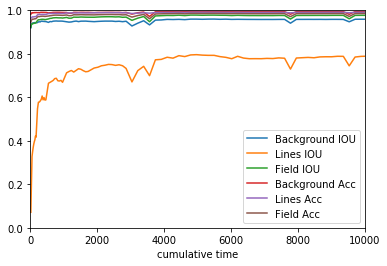

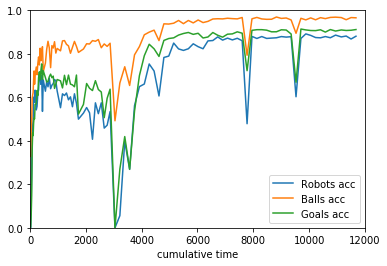

In [22]:
df6 = pd.read_csv('/home/user/jacobs/cudavision/Logs/test_logs_2_673.csv',skiprows=[1,2,3,4,5])
show_df_seg(df6)
show_df_det(df6)

In [10]:
def experiment7():
    schedule = [{'input_dimension': (3*32*5,4*32*5), 'epoch': 5,'phase': 'thaw', 'mode': 'det'}] \
         + [{'input_dimension': (3*32*i,4*32*i), 'epoch': 10,'phase': 'freeze', 'mode': 'concurrent'} for i in range(1,6)] \
         + [{'input_dimension': (3*32*5,4*32*5), 'epoch': 50,'phase': 'thaw', 'mode': 'concurrent'}]

    model_args = {
        'concatenated_bias' : 'shared',
        'concatenated_bias_learnable' : False,
        'added_bias': 'shared',
    }
    args['model_args'] = model_args
    args['l3'] = 0
    args['l4'] = 0.01
    args['size_after_transform'] = schedule[0]['input_dimension']
    model = Net(**args['model_args'],input_dimension = args['size_after_transform']).to(device)
    optimizer = optim.Adam(model.parameters(), 0.001)
    scheduler = CyclicLR(optimizer, base_lr=args['lr'],max_lr=args['max_lr'],cycle_momentum=False)
    epoch = 0

    run_id = 674

    log_loc = os.path.join(working_dir,f'Logs/test_logs_2_{run_id}.csv')
    logger = Logger(run_loc,log_loc,run_id,args)

    resume = False
    if resume == True:
        model.load_state_dict(torch.load(os.path.join(working_dir,f"Models/final_model_{run_id}.pt")))    
    if args['save_model']:
        torch.save(model.state_dict(), os.path.join(working_dir,f"Models/final_model_{run_id}.pt"))
    
    start_time = time.time()

    for phase in schedule:
        print(phase)
        for mode in modes:
            train_dataset[mode] = RobotsDatasetPrecomputed(meta,mode = mode,input_dimension=phase['input_dimension'],device=device,split='train')
            train_loader[mode] = torch.utils.data.DataLoader(train_dataset[mode],batch_size=args['batch_size'], shuffle=True)
            test_dataset[mode] = RobotsDatasetPrecomputed(meta,mode = mode,input_dimension=phase['input_dimension'],device=device,split='test')
            test_loader[mode] = torch.utils.data.DataLoader(test_dataset[mode],batch_size=args['test_batch_size'], shuffle=False)

        model.set_input_dimension(phase['input_dimension'])

        if phase['phase'] == 'freeze':
            model.freeze_encoder()
        else:
            model.unfreeze_encoder()


        for _ in range(phase['epoch']):
            epoch = epoch + 1
            if phase['mode'] == 'concurrent':
                train_concurrent(args, model, device, train_loader[phase['mode']], optimizer, epoch ,logger=logger)
            else: 
                train(args, model, device, train_loader[phase['mode']], optimizer, epoch , mode = phase['mode'],logger=logger)

            test(args, model, device, test_loader['det'], mode = 'det',logger=logger)
            test(args, model, device, test_loader['seg'], mode = 'seg',logger=logger)
            scheduler.step()
            logger.log_data()

            if args['save_model']:
                torch.save(model.state_dict(), os.path.join(working_dir,f"Models/final_model_{run_id}.pt"))
                
    return time.time() - start_time

In [13]:
experiment7()

{'input_dimension': (480, 640), 'epoch': 5, 'phase': 'thaw', 'mode': 'det'}
Train Epoch det: 1 [0/6194(0%)]	Loss: 1.072477, time: 0.09611272811889648
Train Epoch det: 1 [100/6194(2%)]	Loss: 0.090259, time: 1.3547422885894775
Train Epoch det: 1 [200/6194(3%)]	Loss: 0.037862, time: 1.3537323474884033
Train Epoch det: 1 [300/6194(5%)]	Loss: 0.026910, time: 1.3531816005706787
Train Epoch det: 1 [400/6194(6%)]	Loss: 0.022016, time: 1.3560850620269775
Train Epoch det: 1 [500/6194(8%)]	Loss: 0.018973, time: 1.3565278053283691
Train Epoch det: 1 [600/6194(10%)]	Loss: 0.018335, time: 1.356677770614624
Train Epoch det: 1 [700/6194(11%)]	Loss: 0.016540, time: 1.3544859886169434
Train Epoch det: 1 [800/6194(13%)]	Loss: 0.016805, time: 1.354346752166748
Train Epoch det: 1 [900/6194(15%)]	Loss: 0.015310, time: 1.3527796268463135
Train Epoch det: 1 [1000/6194(16%)]	Loss: 0.014980, time: 1.3543376922607422
Train Epoch det: 1 [1100/6194(18%)]	Loss: 0.016646, time: 1.3580994606018066
Train Epoch det: 1 

/home/user/jacobs/cudavision/metric_detection.py:89: RuntimeWarning: invalid value encountered in double_scalars
  recall = correct/(correct+FN)
/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))



Test set: seg Average loss: 0.1177

Background: IOU: 0.1965, accuracy: 0.5586
Lines: IOU: 0.0455, accuracy: 0.4041
Field: IOU: 0.0229, accuracy: 0.3497
Total: IOU: 0.0883, accuracy: 0.4375
making log csv
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_674.csv
Train Epoch det: 2 [0/6194(0%)]	Loss: 0.011828, time: 0.07574009895324707
Train Epoch det: 2 [100/6194(2%)]	Loss: 0.011852, time: 1.363372802734375
Train Epoch det: 2 [200/6194(3%)]	Loss: 0.011443, time: 1.3608202934265137
Train Epoch det: 2 [300/6194(5%)]	Loss: 0.009444, time: 1.3616571426391602
Train Epoch det: 2 [400/6194(6%)]	Loss: 0.013152, time: 1.3614373207092285
Train Epoch det: 2 [500/6194(8%)]	Loss: 0.008586, time: 1.3593356609344482
Train Epoch det: 2 [600/6194(10%)]	Loss: 0.010886, time: 1.3662946224212646
Train Epoch det: 2 [700/6194(11%)]	Loss: 0.011690, time: 1.3640227317810059
Train Epoch det: 2 [800/6194(13%)]	Loss: 0.010037, time: 1.3621666431427002
Train Epoch det: 2 [900/6194(15%)]	Loss: 0.00859

Train Epoch det: 3 [3500/6194(56%)]	Loss: 0.007963, time: 1.3609106540679932
Train Epoch det: 3 [3600/6194(58%)]	Loss: 0.007270, time: 1.3636715412139893
Train Epoch det: 3 [3700/6194(60%)]	Loss: 0.007266, time: 1.3627727031707764
Train Epoch det: 3 [3800/6194(61%)]	Loss: 0.007775, time: 1.3622725009918213
Train Epoch det: 3 [3900/6194(63%)]	Loss: 0.012134, time: 1.3667008876800537
Train Epoch det: 3 [4000/6194(65%)]	Loss: 0.006141, time: 1.3628301620483398
Train Epoch det: 3 [4100/6194(66%)]	Loss: 0.006224, time: 1.3615696430206299
Train Epoch det: 3 [4200/6194(68%)]	Loss: 0.009760, time: 1.3645579814910889
Train Epoch det: 3 [4300/6194(69%)]	Loss: 0.005399, time: 1.365490198135376
Train Epoch det: 3 [4400/6194(71%)]	Loss: 0.009484, time: 1.3666491508483887
Train Epoch det: 3 [4500/6194(73%)]	Loss: 0.007646, time: 1.3741047382354736
Train Epoch det: 3 [4600/6194(74%)]	Loss: 0.009048, time: 1.3846123218536377
Train Epoch det: 3 [4700/6194(76%)]	Loss: 0.006132, time: 1.3678867816925049


Train Epoch det: 5 [400/6194(6%)]	Loss: 0.003609, time: 1.370030164718628
Train Epoch det: 5 [500/6194(8%)]	Loss: 0.007585, time: 1.365058422088623
Train Epoch det: 5 [600/6194(10%)]	Loss: 0.006423, time: 1.3644585609436035
Train Epoch det: 5 [700/6194(11%)]	Loss: 0.006262, time: 1.3636353015899658
Train Epoch det: 5 [800/6194(13%)]	Loss: 0.006888, time: 1.3615643978118896
Train Epoch det: 5 [900/6194(15%)]	Loss: 0.006092, time: 1.3646280765533447
Train Epoch det: 5 [1000/6194(16%)]	Loss: 0.004735, time: 1.3645942211151123
Train Epoch det: 5 [1100/6194(18%)]	Loss: 0.006261, time: 1.363745927810669
Train Epoch det: 5 [1200/6194(19%)]	Loss: 0.006652, time: 1.3650107383728027
Train Epoch det: 5 [1300/6194(21%)]	Loss: 0.006313, time: 1.3620774745941162
Train Epoch det: 5 [1400/6194(23%)]	Loss: 0.008695, time: 1.3617372512817383
Train Epoch det: 5 [1500/6194(24%)]	Loss: 0.005257, time: 1.3613250255584717
Train Epoch det: 5 [1600/6194(26%)]	Loss: 0.004723, time: 1.3637843132019043
Train Epoc

/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))


Train Epoch concurrent: 6 [0/6194(0%)]	Loss: 0.131085, time: 0.04654216766357422
Train Epoch concurrent: 6 [100/6194(2%)]	Loss: 0.070710, time: 0.4504072666168213
Train Epoch concurrent: 6 [200/6194(3%)]	Loss: 0.054704, time: 0.44000697135925293
Train Epoch concurrent: 6 [300/6194(5%)]	Loss: 0.051213, time: 0.4237487316131592
Train Epoch concurrent: 6 [400/6194(6%)]	Loss: 0.049846, time: 0.422046422958374
Train Epoch concurrent: 6 [500/6194(8%)]	Loss: 0.041197, time: 0.4054574966430664
Train Epoch concurrent: 6 [600/6194(10%)]	Loss: 0.042196, time: 0.4118509292602539
Train Epoch concurrent: 6 [700/6194(11%)]	Loss: 0.046892, time: 0.4033052921295166
Train Epoch concurrent: 6 [800/6194(13%)]	Loss: 0.031561, time: 0.3977205753326416
Train Epoch concurrent: 6 [900/6194(15%)]	Loss: 0.041403, time: 0.3912327289581299
Train Epoch concurrent: 6 [1000/6194(16%)]	Loss: 0.029154, time: 0.3838508129119873
Train Epoch concurrent: 6 [1100/6194(18%)]	Loss: 0.027593, time: 0.3826179504394531
Train Epo

/home/user/jacobs/cudavision/metric_detection.py:89: RuntimeWarning: invalid value encountered in double_scalars
  recall = correct/(correct+FN)



Test set: seg Average loss: 0.0138

Background: IOU: 0.9263, accuracy: 0.9842
Lines: IOU: 0.1837, accuracy: 0.9658
Field: IOU: 0.9277, accuracy: 0.9508
Total: IOU: 0.6792, accuracy: 0.9669
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_674.csv
Train Epoch concurrent: 7 [0/6194(0%)]	Loss: 0.020831, time: 0.0290377140045166
Train Epoch concurrent: 7 [100/6194(2%)]	Loss: 0.019433, time: 0.2801685333251953
Train Epoch concurrent: 7 [200/6194(3%)]	Loss: 0.019884, time: 0.28116488456726074
Train Epoch concurrent: 7 [300/6194(5%)]	Loss: 0.021214, time: 0.28033947944641113
Train Epoch concurrent: 7 [400/6194(6%)]	Loss: 0.022824, time: 0.27861642837524414
Train Epoch concurrent: 7 [500/6194(8%)]	Loss: 0.021719, time: 0.2799208164215088
Train Epoch concurrent: 7 [600/6194(10%)]	Loss: 0.020124, time: 0.27837252616882324
Train Epoch concurrent: 7 [700/6194(11%)]	Loss: 0.021066, time: 0.27896547317504883
Train Epoch concurrent: 7 [800/6194(13%)]	Loss: 0.030532, time: 0.275963783264

/home/user/jacobs/cudavision/metric_segmentation.py:51: RuntimeWarning: invalid value encountered in true_divide
  IOU_imagewise[:,i] = true_positives_imagewise[cat]/(true_positives_imagewise[cat] + false_positives_imagewise[cat] + false_negatives_imagewise[cat])



Test set: seg Average loss: 0.0132

Background: IOU: 0.9210, accuracy: 0.9829
Lines: IOU: 0.2543, accuracy: 0.9691
Field: IOU: 0.9319, accuracy: 0.9524
Total: IOU: 0.7024, accuracy: 0.9681
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_674.csv
Train Epoch concurrent: 8 [0/6194(0%)]	Loss: 0.017978, time: 0.028806447982788086
Train Epoch concurrent: 8 [100/6194(2%)]	Loss: 0.017916, time: 0.27738499641418457
Train Epoch concurrent: 8 [200/6194(3%)]	Loss: 0.014647, time: 0.2774820327758789
Train Epoch concurrent: 8 [300/6194(5%)]	Loss: 0.015982, time: 0.27680182456970215
Train Epoch concurrent: 8 [400/6194(6%)]	Loss: 0.016950, time: 0.27773284912109375
Train Epoch concurrent: 8 [500/6194(8%)]	Loss: 0.016354, time: 0.2761251926422119
Train Epoch concurrent: 8 [600/6194(10%)]	Loss: 0.015991, time: 0.2776496410369873
Train Epoch concurrent: 8 [700/6194(11%)]	Loss: 0.015035, time: 0.2763850688934326
Train Epoch concurrent: 8 [800/6194(13%)]	Loss: 0.016897, time: 0.278017997741

Train Epoch concurrent: 9 [2600/6194(42%)]	Loss: 0.014708, time: 0.2780265808105469
Train Epoch concurrent: 9 [2700/6194(44%)]	Loss: 0.014346, time: 0.276425838470459
Train Epoch concurrent: 9 [2800/6194(45%)]	Loss: 0.011920, time: 0.2784566879272461
Train Epoch concurrent: 9 [2900/6194(47%)]	Loss: 0.014116, time: 0.2757992744445801
Train Epoch concurrent: 9 [3000/6194(48%)]	Loss: 0.013876, time: 0.2786390781402588
Train Epoch concurrent: 9 [3100/6194(50%)]	Loss: 0.015650, time: 0.2757558822631836
Train Epoch concurrent: 9 [3200/6194(52%)]	Loss: 0.013226, time: 0.2774217128753662
Train Epoch concurrent: 9 [3300/6194(53%)]	Loss: 0.013346, time: 0.27781200408935547
Train Epoch concurrent: 9 [3400/6194(55%)]	Loss: 0.012216, time: 0.27527928352355957
Train Epoch concurrent: 9 [3500/6194(56%)]	Loss: 0.011372, time: 0.2774078845977783
Train Epoch concurrent: 9 [3600/6194(58%)]	Loss: 0.011253, time: 0.2753143310546875
Train Epoch concurrent: 9 [3700/6194(60%)]	Loss: 0.013590, time: 0.27740025

Train Epoch concurrent: 10 [5400/6194(87%)]	Loss: 0.012312, time: 0.27736353874206543
Train Epoch concurrent: 10 [5500/6194(89%)]	Loss: 0.011826, time: 0.27501630783081055
Train Epoch concurrent: 10 [5600/6194(90%)]	Loss: 0.011958, time: 0.27689290046691895
Train Epoch concurrent: 10 [5700/6194(92%)]	Loss: 0.008573, time: 0.27470946311950684
Train Epoch concurrent: 10 [5800/6194(94%)]	Loss: 0.011520, time: 0.27495336532592773
Train Epoch concurrent: 10 [5900/6194(95%)]	Loss: 0.011912, time: 0.2762410640716553
Train Epoch concurrent: 10 [6000/6194(97%)]	Loss: 0.009992, time: 0.27484750747680664
Train Epoch concurrent: 10 [6100/6194(98%)]	Loss: 0.008389, time: 0.27595949172973633

Test set: det Average loss: 0.0051

Balls: F1: 0.7833, accuracy: 0.6438, recall: 0.9402, precision: 0.6712, FDR: 0.3288,
Goalposts: F1: 0.6271, accuracy: 0.4567, recall: 0.8416, precision: 0.4997, FDR: 0.5003,
Robots: F1: 0.6411, accuracy: 0.4718, recall: 0.8381, precision: 0.5191, FDR: 0.4809,

Test set: seg A

Train Epoch concurrent: 12 [1400/6194(23%)]	Loss: 0.011724, time: 0.277118444442749
Train Epoch concurrent: 12 [1500/6194(24%)]	Loss: 0.009867, time: 0.27489519119262695
Train Epoch concurrent: 12 [1600/6194(26%)]	Loss: 0.008279, time: 0.27731823921203613
Train Epoch concurrent: 12 [1700/6194(27%)]	Loss: 0.009781, time: 0.2764396667480469
Train Epoch concurrent: 12 [1800/6194(29%)]	Loss: 0.009794, time: 0.27599167823791504
Train Epoch concurrent: 12 [1900/6194(31%)]	Loss: 0.015897, time: 0.2768080234527588
Train Epoch concurrent: 12 [2000/6194(32%)]	Loss: 0.008260, time: 0.27483630180358887
Train Epoch concurrent: 12 [2100/6194(34%)]	Loss: 0.009312, time: 0.2777729034423828
Train Epoch concurrent: 12 [2200/6194(35%)]	Loss: 0.008734, time: 0.2747154235839844
Train Epoch concurrent: 12 [2300/6194(37%)]	Loss: 0.006699, time: 0.2753787040710449
Train Epoch concurrent: 12 [2400/6194(39%)]	Loss: 0.009340, time: 0.27539730072021484
Train Epoch concurrent: 12 [2500/6194(40%)]	Loss: 0.008136, t

Train Epoch concurrent: 13 [4200/6194(68%)]	Loss: 0.008796, time: 0.2778170108795166
Train Epoch concurrent: 13 [4300/6194(69%)]	Loss: 0.010991, time: 0.2750511169433594
Train Epoch concurrent: 13 [4400/6194(71%)]	Loss: 0.010792, time: 0.28029918670654297
Train Epoch concurrent: 13 [4500/6194(73%)]	Loss: 0.007198, time: 0.28757429122924805
Train Epoch concurrent: 13 [4600/6194(74%)]	Loss: 0.007232, time: 0.2829933166503906
Train Epoch concurrent: 13 [4700/6194(76%)]	Loss: 0.009259, time: 0.28003811836242676
Train Epoch concurrent: 13 [4800/6194(77%)]	Loss: 0.009840, time: 0.2751164436340332
Train Epoch concurrent: 13 [4900/6194(79%)]	Loss: 0.008794, time: 0.27916765213012695
Train Epoch concurrent: 13 [5000/6194(81%)]	Loss: 0.009414, time: 0.2752950191497803
Train Epoch concurrent: 13 [5100/6194(82%)]	Loss: 0.007235, time: 0.2772030830383301
Train Epoch concurrent: 13 [5200/6194(84%)]	Loss: 0.007630, time: 0.27554965019226074
Train Epoch concurrent: 13 [5300/6194(85%)]	Loss: 0.008934, 

Train Epoch concurrent: 15 [100/6194(2%)]	Loss: 0.007423, time: 0.27570366859436035
Train Epoch concurrent: 15 [200/6194(3%)]	Loss: 0.006959, time: 0.2759687900543213
Train Epoch concurrent: 15 [300/6194(5%)]	Loss: 0.006302, time: 0.27644944190979004
Train Epoch concurrent: 15 [400/6194(6%)]	Loss: 0.007850, time: 0.27541565895080566
Train Epoch concurrent: 15 [500/6194(8%)]	Loss: 0.006812, time: 0.27753758430480957
Train Epoch concurrent: 15 [600/6194(10%)]	Loss: 0.007279, time: 0.2754788398742676
Train Epoch concurrent: 15 [700/6194(11%)]	Loss: 0.007229, time: 0.27704429626464844
Train Epoch concurrent: 15 [800/6194(13%)]	Loss: 0.010016, time: 0.2761666774749756
Train Epoch concurrent: 15 [900/6194(15%)]	Loss: 0.007964, time: 0.2877342700958252
Train Epoch concurrent: 15 [1000/6194(16%)]	Loss: 0.006937, time: 0.28385400772094727
Train Epoch concurrent: 15 [1100/6194(18%)]	Loss: 0.005685, time: 0.28072071075439453
Train Epoch concurrent: 15 [1200/6194(19%)]	Loss: 0.005830, time: 0.2770

/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))


Train Epoch concurrent: 16 [0/6194(0%)]	Loss: 0.062425, time: 0.10724997520446777
Train Epoch concurrent: 16 [100/6194(2%)]	Loss: 0.026912, time: 1.0340023040771484
Train Epoch concurrent: 16 [200/6194(3%)]	Loss: 0.027966, time: 0.966489315032959
Train Epoch concurrent: 16 [300/6194(5%)]	Loss: 0.017552, time: 0.9159622192382812
Train Epoch concurrent: 16 [400/6194(6%)]	Loss: 0.037846, time: 0.9039363861083984
Train Epoch concurrent: 16 [500/6194(8%)]	Loss: 0.014799, time: 0.9066712856292725
Train Epoch concurrent: 16 [600/6194(10%)]	Loss: 0.020030, time: 0.8447878360748291
Train Epoch concurrent: 16 [700/6194(11%)]	Loss: 0.018811, time: 0.8580722808837891
Train Epoch concurrent: 16 [800/6194(13%)]	Loss: 0.016497, time: 0.7510676383972168
Train Epoch concurrent: 16 [900/6194(15%)]	Loss: 0.015835, time: 0.7478609085083008
Train Epoch concurrent: 16 [1000/6194(16%)]	Loss: 0.020945, time: 0.7529065608978271
Train Epoch concurrent: 16 [1100/6194(18%)]	Loss: 0.016210, time: 0.776245355606079

Train Epoch concurrent: 17 [2900/6194(47%)]	Loss: 0.010728, time: 0.4372215270996094
Train Epoch concurrent: 17 [3000/6194(48%)]	Loss: 0.010197, time: 0.43932628631591797
Train Epoch concurrent: 17 [3100/6194(50%)]	Loss: 0.012181, time: 0.440032958984375
Train Epoch concurrent: 17 [3200/6194(52%)]	Loss: 0.009087, time: 0.4401235580444336
Train Epoch concurrent: 17 [3300/6194(53%)]	Loss: 0.009719, time: 0.4394242763519287
Train Epoch concurrent: 17 [3400/6194(55%)]	Loss: 0.008396, time: 0.4398763179779053
Train Epoch concurrent: 17 [3500/6194(56%)]	Loss: 0.009965, time: 0.43958425521850586
Train Epoch concurrent: 17 [3600/6194(58%)]	Loss: 0.015188, time: 0.43978095054626465
Train Epoch concurrent: 17 [3700/6194(60%)]	Loss: 0.011238, time: 0.43938398361206055
Train Epoch concurrent: 17 [3800/6194(61%)]	Loss: 0.008203, time: 0.4376869201660156
Train Epoch concurrent: 17 [3900/6194(63%)]	Loss: 0.009522, time: 0.4447157382965088
Train Epoch concurrent: 17 [4000/6194(65%)]	Loss: 0.014775, ti

Train Epoch concurrent: 18 [5700/6194(92%)]	Loss: 0.009880, time: 0.4393627643585205
Train Epoch concurrent: 18 [5800/6194(94%)]	Loss: 0.008588, time: 0.439666748046875
Train Epoch concurrent: 18 [5900/6194(95%)]	Loss: 0.010230, time: 0.4399540424346924
Train Epoch concurrent: 18 [6000/6194(97%)]	Loss: 0.007007, time: 0.4393959045410156
Train Epoch concurrent: 18 [6100/6194(98%)]	Loss: 0.010475, time: 0.4390699863433838

Test set: det Average loss: 0.0049

Balls: F1: 0.8781, accuracy: 0.7828, recall: 0.9597, precision: 0.8094, FDR: 0.1906,
Goalposts: F1: 0.8079, accuracy: 0.6777, recall: 0.9021, precision: 0.7315, FDR: 0.2685,
Robots: F1: 0.8032, accuracy: 0.6711, recall: 0.8533, precision: 0.7586, FDR: 0.2414,

Test set: seg Average loss: 0.0080

Background: IOU: 0.9442, accuracy: 0.9897
Lines: IOU: 0.5691, accuracy: 0.9813
Field: IOU: 0.9565, accuracy: 0.9715
Total: IOU: 0.8233, accuracy: 0.9808
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_674.csv
Train Epoch concur

Train Epoch concurrent: 20 [1700/6194(27%)]	Loss: 0.008588, time: 0.44029903411865234
Train Epoch concurrent: 20 [1800/6194(29%)]	Loss: 0.007075, time: 0.4412248134613037
Train Epoch concurrent: 20 [1900/6194(31%)]	Loss: 0.006918, time: 0.44034433364868164
Train Epoch concurrent: 20 [2000/6194(32%)]	Loss: 0.007577, time: 0.440885066986084
Train Epoch concurrent: 20 [2100/6194(34%)]	Loss: 0.010083, time: 0.44037866592407227
Train Epoch concurrent: 20 [2200/6194(35%)]	Loss: 0.008385, time: 0.440032958984375
Train Epoch concurrent: 20 [2300/6194(37%)]	Loss: 0.008451, time: 0.43848752975463867
Train Epoch concurrent: 20 [2400/6194(39%)]	Loss: 0.011186, time: 0.44152021408081055
Train Epoch concurrent: 20 [2500/6194(40%)]	Loss: 0.008609, time: 0.4499626159667969
Train Epoch concurrent: 20 [2600/6194(42%)]	Loss: 0.007863, time: 0.44342994689941406
Train Epoch concurrent: 20 [2700/6194(44%)]	Loss: 0.011817, time: 0.4424762725830078
Train Epoch concurrent: 20 [2800/6194(45%)]	Loss: 0.008061, t

Train Epoch concurrent: 21 [4500/6194(73%)]	Loss: 0.006037, time: 0.44121289253234863
Train Epoch concurrent: 21 [4600/6194(74%)]	Loss: 0.009172, time: 0.4398956298828125
Train Epoch concurrent: 21 [4700/6194(76%)]	Loss: 0.006735, time: 0.4422578811645508
Train Epoch concurrent: 21 [4800/6194(77%)]	Loss: 0.006562, time: 0.4410371780395508
Train Epoch concurrent: 21 [4900/6194(79%)]	Loss: 0.011393, time: 0.4416813850402832
Train Epoch concurrent: 21 [5000/6194(81%)]	Loss: 0.007907, time: 0.440596342086792
Train Epoch concurrent: 21 [5100/6194(82%)]	Loss: 0.006246, time: 0.4392118453979492
Train Epoch concurrent: 21 [5200/6194(84%)]	Loss: 0.007053, time: 0.4397289752960205
Train Epoch concurrent: 21 [5300/6194(85%)]	Loss: 0.006713, time: 0.4409799575805664
Train Epoch concurrent: 21 [5400/6194(87%)]	Loss: 0.008366, time: 0.4409451484680176
Train Epoch concurrent: 21 [5500/6194(89%)]	Loss: 0.004994, time: 0.44110703468322754
Train Epoch concurrent: 21 [5600/6194(90%)]	Loss: 0.004641, time

/home/user/jacobs/cudavision/metric_segmentation.py:51: RuntimeWarning: invalid value encountered in true_divide
  IOU_imagewise[:,i] = true_positives_imagewise[cat]/(true_positives_imagewise[cat] + false_positives_imagewise[cat] + false_negatives_imagewise[cat])



Test set: seg Average loss: 0.0080

Background: IOU: 0.9503, accuracy: 0.9916
Lines: IOU: 0.6168, accuracy: 0.9827
Field: IOU: 0.9611, accuracy: 0.9746
Total: IOU: 0.8427, accuracy: 0.9829
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_674.csv
Train Epoch concurrent: 22 [0/6194(0%)]	Loss: 0.005354, time: 0.03770637512207031
Train Epoch concurrent: 22 [100/6194(2%)]	Loss: 0.006230, time: 0.44090747833251953
Train Epoch concurrent: 22 [200/6194(3%)]	Loss: 0.006372, time: 0.43920016288757324
Train Epoch concurrent: 22 [300/6194(5%)]	Loss: 0.006223, time: 0.43952512741088867
Train Epoch concurrent: 22 [400/6194(6%)]	Loss: 0.005449, time: 0.44063758850097656
Train Epoch concurrent: 22 [500/6194(8%)]	Loss: 0.008293, time: 0.4400362968444824
Train Epoch concurrent: 22 [600/6194(10%)]	Loss: 0.004220, time: 0.4414091110229492
Train Epoch concurrent: 22 [700/6194(11%)]	Loss: 0.006326, time: 0.44118285179138184
Train Epoch concurrent: 22 [800/6194(13%)]	Loss: 0.007533, time: 0.44

Train Epoch concurrent: 23 [2500/6194(40%)]	Loss: 0.005786, time: 0.44246721267700195
Train Epoch concurrent: 23 [2600/6194(42%)]	Loss: 0.004800, time: 0.4425339698791504
Train Epoch concurrent: 23 [2700/6194(44%)]	Loss: 0.008314, time: 0.4417538642883301
Train Epoch concurrent: 23 [2800/6194(45%)]	Loss: 0.005192, time: 0.4426851272583008
Train Epoch concurrent: 23 [2900/6194(47%)]	Loss: 0.006661, time: 0.4426538944244385
Train Epoch concurrent: 23 [3000/6194(48%)]	Loss: 0.005027, time: 0.440889835357666
Train Epoch concurrent: 23 [3100/6194(50%)]	Loss: 0.005475, time: 0.44310879707336426
Train Epoch concurrent: 23 [3200/6194(52%)]	Loss: 0.007219, time: 0.44269609451293945
Train Epoch concurrent: 23 [3300/6194(53%)]	Loss: 0.005448, time: 0.4404730796813965
Train Epoch concurrent: 23 [3400/6194(55%)]	Loss: 0.005196, time: 0.44213390350341797
Train Epoch concurrent: 23 [3500/6194(56%)]	Loss: 0.005829, time: 0.44669485092163086
Train Epoch concurrent: 23 [3600/6194(58%)]	Loss: 0.005411, t

Train Epoch concurrent: 24 [5300/6194(85%)]	Loss: 0.005143, time: 0.4454216957092285
Train Epoch concurrent: 24 [5400/6194(87%)]	Loss: 0.005095, time: 0.4438896179199219
Train Epoch concurrent: 24 [5500/6194(89%)]	Loss: 0.005776, time: 0.4443652629852295
Train Epoch concurrent: 24 [5600/6194(90%)]	Loss: 0.004129, time: 0.44246697425842285
Train Epoch concurrent: 24 [5700/6194(92%)]	Loss: 0.007213, time: 0.44227004051208496
Train Epoch concurrent: 24 [5800/6194(94%)]	Loss: 0.008157, time: 0.4442315101623535
Train Epoch concurrent: 24 [5900/6194(95%)]	Loss: 0.006243, time: 0.4419379234313965
Train Epoch concurrent: 24 [6000/6194(97%)]	Loss: 0.005936, time: 0.44272804260253906
Train Epoch concurrent: 24 [6100/6194(98%)]	Loss: 0.004015, time: 0.4422800540924072

Test set: det Average loss: 0.0042

Balls: F1: 0.8968, accuracy: 0.8129, recall: 0.9743, precision: 0.8307, FDR: 0.1693,
Goalposts: F1: 0.8440, accuracy: 0.7301, recall: 0.9189, precision: 0.7804, FDR: 0.2196,
Robots: F1: 0.8226, a

/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))


Train Epoch concurrent: 26 [0/6194(0%)]	Loss: 0.019562, time: 0.14604568481445312
Train Epoch concurrent: 26 [100/6194(2%)]	Loss: 0.022759, time: 1.7050011157989502
Train Epoch concurrent: 26 [200/6194(3%)]	Loss: 0.014226, time: 1.5684154033660889
Train Epoch concurrent: 26 [300/6194(5%)]	Loss: 0.015241, time: 1.6128342151641846
Train Epoch concurrent: 26 [400/6194(6%)]	Loss: 0.012523, time: 1.580826997756958
Train Epoch concurrent: 26 [500/6194(8%)]	Loss: 0.013060, time: 1.5682849884033203
Train Epoch concurrent: 26 [600/6194(10%)]	Loss: 0.015936, time: 1.4624607563018799
Train Epoch concurrent: 26 [700/6194(11%)]	Loss: 0.012716, time: 1.3873498439788818
Train Epoch concurrent: 26 [800/6194(13%)]	Loss: 0.012340, time: 1.4088761806488037
Train Epoch concurrent: 26 [900/6194(15%)]	Loss: 0.012707, time: 1.2586641311645508
Train Epoch concurrent: 26 [1000/6194(16%)]	Loss: 0.015488, time: 1.3355047702789307
Train Epoch concurrent: 26 [1100/6194(18%)]	Loss: 0.012447, time: 1.478569746017456

Train Epoch concurrent: 27 [2900/6194(47%)]	Loss: 0.009783, time: 0.7868776321411133
Train Epoch concurrent: 27 [3000/6194(48%)]	Loss: 0.009472, time: 0.8087782859802246
Train Epoch concurrent: 27 [3100/6194(50%)]	Loss: 0.007913, time: 0.8302295207977295
Train Epoch concurrent: 27 [3200/6194(52%)]	Loss: 0.008180, time: 0.8157527446746826
Train Epoch concurrent: 27 [3300/6194(53%)]	Loss: 0.009435, time: 0.8187973499298096
Train Epoch concurrent: 27 [3400/6194(55%)]	Loss: 0.007257, time: 0.8083083629608154
Train Epoch concurrent: 27 [3500/6194(56%)]	Loss: 0.007330, time: 0.7704322338104248
Train Epoch concurrent: 27 [3600/6194(58%)]	Loss: 0.009171, time: 0.7852697372436523
Train Epoch concurrent: 27 [3700/6194(60%)]	Loss: 0.011155, time: 0.8089907169342041
Train Epoch concurrent: 27 [3800/6194(61%)]	Loss: 0.009368, time: 0.81062912940979
Train Epoch concurrent: 27 [3900/6194(63%)]	Loss: 0.011282, time: 0.8053314685821533
Train Epoch concurrent: 27 [4000/6194(65%)]	Loss: 0.010018, time: 0

Train Epoch concurrent: 28 [5800/6194(94%)]	Loss: 0.007003, time: 0.7357292175292969
Train Epoch concurrent: 28 [5900/6194(95%)]	Loss: 0.006507, time: 0.7359781265258789
Train Epoch concurrent: 28 [6000/6194(97%)]	Loss: 0.006486, time: 0.7356133460998535
Train Epoch concurrent: 28 [6100/6194(98%)]	Loss: 0.008190, time: 0.7357120513916016

Test set: det Average loss: 0.0044

Balls: F1: 0.9012, accuracy: 0.8201, recall: 0.9817, precision: 0.8329, FDR: 0.1671,
Goalposts: F1: 0.8109, accuracy: 0.6820, recall: 0.9220, precision: 0.7237, FDR: 0.2763,
Robots: F1: 0.7831, accuracy: 0.6435, recall: 0.9026, precision: 0.6915, FDR: 0.3085,

Test set: seg Average loss: 0.0064

Background: IOU: 0.9490, accuracy: 0.9904
Lines: IOU: 0.6924, accuracy: 0.9870
Field: IOU: 0.9662, accuracy: 0.9779
Total: IOU: 0.8692, accuracy: 0.9851
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_674.csv
Train Epoch concurrent: 29 [0/6194(0%)]	Loss: 0.007933, time: 0.055507659912109375
Train Epoch concurr

Train Epoch concurrent: 30 [1800/6194(29%)]	Loss: 0.009469, time: 0.7348785400390625
Train Epoch concurrent: 30 [1900/6194(31%)]	Loss: 0.007860, time: 0.7339322566986084
Train Epoch concurrent: 30 [2000/6194(32%)]	Loss: 0.006099, time: 0.7357289791107178
Train Epoch concurrent: 30 [2100/6194(34%)]	Loss: 0.008383, time: 0.7321228981018066
Train Epoch concurrent: 30 [2200/6194(35%)]	Loss: 0.006400, time: 0.7362465858459473
Train Epoch concurrent: 30 [2300/6194(37%)]	Loss: 0.006597, time: 0.7330965995788574
Train Epoch concurrent: 30 [2400/6194(39%)]	Loss: 0.006494, time: 0.741774320602417
Train Epoch concurrent: 30 [2500/6194(40%)]	Loss: 0.007003, time: 0.7349038124084473
Train Epoch concurrent: 30 [2600/6194(42%)]	Loss: 0.010068, time: 0.739048957824707
Train Epoch concurrent: 30 [2700/6194(44%)]	Loss: 0.007106, time: 0.736774206161499
Train Epoch concurrent: 30 [2800/6194(45%)]	Loss: 0.005475, time: 0.7365608215332031
Train Epoch concurrent: 30 [2900/6194(47%)]	Loss: 0.008245, time: 0.

Train Epoch concurrent: 31 [4700/6194(76%)]	Loss: 0.006215, time: 0.7333793640136719
Train Epoch concurrent: 31 [4800/6194(77%)]	Loss: 0.005562, time: 0.7363321781158447
Train Epoch concurrent: 31 [4900/6194(79%)]	Loss: 0.005995, time: 0.7330808639526367
Train Epoch concurrent: 31 [5000/6194(81%)]	Loss: 0.005521, time: 0.7386610507965088
Train Epoch concurrent: 31 [5100/6194(82%)]	Loss: 0.004695, time: 0.7388715744018555
Train Epoch concurrent: 31 [5200/6194(84%)]	Loss: 0.006174, time: 0.7395858764648438
Train Epoch concurrent: 31 [5300/6194(85%)]	Loss: 0.004499, time: 0.7392172813415527
Train Epoch concurrent: 31 [5400/6194(87%)]	Loss: 0.005467, time: 0.7392501831054688
Train Epoch concurrent: 31 [5500/6194(89%)]	Loss: 0.011054, time: 0.7353429794311523
Train Epoch concurrent: 31 [5600/6194(90%)]	Loss: 0.006509, time: 0.7380161285400391
Train Epoch concurrent: 31 [5700/6194(92%)]	Loss: 0.006316, time: 0.7371237277984619
Train Epoch concurrent: 31 [5800/6194(94%)]	Loss: 0.005487, time:

Train Epoch concurrent: 33 [700/6194(11%)]	Loss: 0.007013, time: 0.7411785125732422
Train Epoch concurrent: 33 [800/6194(13%)]	Loss: 0.007300, time: 0.735114574432373
Train Epoch concurrent: 33 [900/6194(15%)]	Loss: 0.008353, time: 0.739448070526123
Train Epoch concurrent: 33 [1000/6194(16%)]	Loss: 0.007403, time: 0.7390356063842773
Train Epoch concurrent: 33 [1100/6194(18%)]	Loss: 0.006592, time: 0.7369029521942139
Train Epoch concurrent: 33 [1200/6194(19%)]	Loss: 0.005532, time: 0.7373435497283936
Train Epoch concurrent: 33 [1300/6194(21%)]	Loss: 0.004925, time: 0.740253210067749
Train Epoch concurrent: 33 [1400/6194(23%)]	Loss: 0.006161, time: 0.7364583015441895
Train Epoch concurrent: 33 [1500/6194(24%)]	Loss: 0.006648, time: 0.735400915145874
Train Epoch concurrent: 33 [1600/6194(26%)]	Loss: 0.004731, time: 0.733734130859375
Train Epoch concurrent: 33 [1700/6194(27%)]	Loss: 0.005191, time: 0.737227201461792
Train Epoch concurrent: 33 [1800/6194(29%)]	Loss: 0.006223, time: 0.739604

Train Epoch concurrent: 34 [3600/6194(58%)]	Loss: 0.005907, time: 0.7379341125488281
Train Epoch concurrent: 34 [3700/6194(60%)]	Loss: 0.005688, time: 0.7634022235870361
Train Epoch concurrent: 34 [3800/6194(61%)]	Loss: 0.005382, time: 0.7472319602966309
Train Epoch concurrent: 34 [3900/6194(63%)]	Loss: 0.004515, time: 0.7361102104187012
Train Epoch concurrent: 34 [4000/6194(65%)]	Loss: 0.005921, time: 0.7352347373962402
Train Epoch concurrent: 34 [4100/6194(66%)]	Loss: 0.005346, time: 0.7353606224060059
Train Epoch concurrent: 34 [4200/6194(68%)]	Loss: 0.004307, time: 0.7339298725128174
Train Epoch concurrent: 34 [4300/6194(69%)]	Loss: 0.005400, time: 0.7363345623016357
Train Epoch concurrent: 34 [4400/6194(71%)]	Loss: 0.005032, time: 0.7338347434997559
Train Epoch concurrent: 34 [4500/6194(73%)]	Loss: 0.005077, time: 0.7342522144317627
Train Epoch concurrent: 34 [4600/6194(74%)]	Loss: 0.005577, time: 0.7617688179016113
Train Epoch concurrent: 34 [4700/6194(76%)]	Loss: 0.007324, time:


Test set: seg Average loss: 0.0075

Background: IOU: 0.9503, accuracy: 0.9910
Lines: IOU: 0.7007, accuracy: 0.9871
Field: IOU: 0.9668, accuracy: 0.9785
Total: IOU: 0.8726, accuracy: 0.9855
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_674.csv
{'input_dimension': (384, 512), 'epoch': 10, 'phase': 'freeze', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))


Train Epoch concurrent: 36 [0/6194(0%)]	Loss: 0.014613, time: 0.1943199634552002
Train Epoch concurrent: 36 [100/6194(2%)]	Loss: 0.014395, time: 2.377706527709961
Train Epoch concurrent: 36 [200/6194(3%)]	Loss: 0.014926, time: 2.4163479804992676
Train Epoch concurrent: 36 [300/6194(5%)]	Loss: 0.014664, time: 2.3239336013793945
Train Epoch concurrent: 36 [400/6194(6%)]	Loss: 0.011652, time: 2.2104239463806152
Train Epoch concurrent: 36 [500/6194(8%)]	Loss: 0.009902, time: 2.2817232608795166
Train Epoch concurrent: 36 [600/6194(10%)]	Loss: 0.010593, time: 2.284733533859253
Train Epoch concurrent: 36 [700/6194(11%)]	Loss: 0.012992, time: 2.0950238704681396
Train Epoch concurrent: 36 [800/6194(13%)]	Loss: 0.010224, time: 2.0743606090545654
Train Epoch concurrent: 36 [900/6194(15%)]	Loss: 0.013015, time: 2.0848283767700195
Train Epoch concurrent: 36 [1000/6194(16%)]	Loss: 0.008415, time: 2.1661386489868164
Train Epoch concurrent: 36 [1100/6194(18%)]	Loss: 0.011329, time: 2.10729718208313
Tr

Train Epoch concurrent: 37 [2900/6194(47%)]	Loss: 0.006859, time: 1.1217913627624512
Train Epoch concurrent: 37 [3000/6194(48%)]	Loss: 0.006665, time: 1.1370110511779785
Train Epoch concurrent: 37 [3100/6194(50%)]	Loss: 0.008429, time: 1.126413345336914
Train Epoch concurrent: 37 [3200/6194(52%)]	Loss: 0.007332, time: 1.1404998302459717
Train Epoch concurrent: 37 [3300/6194(53%)]	Loss: 0.008572, time: 1.1237518787384033
Train Epoch concurrent: 37 [3400/6194(55%)]	Loss: 0.009039, time: 1.1218101978302002
Train Epoch concurrent: 37 [3500/6194(56%)]	Loss: 0.006459, time: 1.1237010955810547
Train Epoch concurrent: 37 [3600/6194(58%)]	Loss: 0.006312, time: 1.1228938102722168
Train Epoch concurrent: 37 [3700/6194(60%)]	Loss: 0.007510, time: 1.1226651668548584
Train Epoch concurrent: 37 [3800/6194(61%)]	Loss: 0.008651, time: 1.1237075328826904
Train Epoch concurrent: 37 [3900/6194(63%)]	Loss: 0.007874, time: 1.1253178119659424
Train Epoch concurrent: 37 [4000/6194(65%)]	Loss: 0.008137, time: 

Train Epoch concurrent: 38 [5800/6194(94%)]	Loss: 0.008757, time: 1.1363298892974854
Train Epoch concurrent: 38 [5900/6194(95%)]	Loss: 0.005701, time: 1.1369447708129883
Train Epoch concurrent: 38 [6000/6194(97%)]	Loss: 0.006252, time: 1.1334691047668457
Train Epoch concurrent: 38 [6100/6194(98%)]	Loss: 0.008289, time: 1.1346797943115234

Test set: det Average loss: 0.0041

Balls: F1: 0.9379, accuracy: 0.8831, recall: 0.9887, precision: 0.8920, FDR: 0.1080,
Goalposts: F1: 0.7607, accuracy: 0.6138, recall: 0.9503, precision: 0.6341, FDR: 0.3659,
Robots: F1: 0.7695, accuracy: 0.6254, recall: 0.9173, precision: 0.6628, FDR: 0.3372,

Test set: seg Average loss: 0.0061

Background: IOU: 0.9454, accuracy: 0.9892
Lines: IOU: 0.7417, accuracy: 0.9889
Field: IOU: 0.9673, accuracy: 0.9784
Total: IOU: 0.8848, accuracy: 0.9855
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_674.csv
Train Epoch concurrent: 39 [0/6194(0%)]	Loss: 0.005661, time: 0.09094524383544922
Train Epoch concurre

Train Epoch concurrent: 40 [1800/6194(29%)]	Loss: 0.005624, time: 1.847165822982788
Train Epoch concurrent: 40 [1900/6194(31%)]	Loss: 0.005466, time: 1.8735692501068115
Train Epoch concurrent: 40 [2000/6194(32%)]	Loss: 0.006116, time: 1.8447930812835693
Train Epoch concurrent: 40 [2100/6194(34%)]	Loss: 0.006959, time: 1.8274638652801514
Train Epoch concurrent: 40 [2200/6194(35%)]	Loss: 0.005699, time: 1.8744182586669922
Train Epoch concurrent: 40 [2300/6194(37%)]	Loss: 0.007181, time: 1.855226755142212
Train Epoch concurrent: 40 [2400/6194(39%)]	Loss: 0.005021, time: 1.7827885150909424
Train Epoch concurrent: 40 [2500/6194(40%)]	Loss: 0.007160, time: 1.71639084815979
Train Epoch concurrent: 40 [2600/6194(42%)]	Loss: 0.005022, time: 1.7885563373565674
Train Epoch concurrent: 40 [2700/6194(44%)]	Loss: 0.010745, time: 1.8313467502593994
Train Epoch concurrent: 40 [2800/6194(45%)]	Loss: 0.005679, time: 1.8604540824890137
Train Epoch concurrent: 40 [2900/6194(47%)]	Loss: 0.006381, time: 1.8

Train Epoch concurrent: 41 [4700/6194(76%)]	Loss: 0.006685, time: 1.1275923252105713
Train Epoch concurrent: 41 [4800/6194(77%)]	Loss: 0.005838, time: 1.1366190910339355
Train Epoch concurrent: 41 [4900/6194(79%)]	Loss: 0.009073, time: 1.153181791305542
Train Epoch concurrent: 41 [5000/6194(81%)]	Loss: 0.004037, time: 1.136202335357666
Train Epoch concurrent: 41 [5100/6194(82%)]	Loss: 0.005145, time: 1.1924569606781006
Train Epoch concurrent: 41 [5200/6194(84%)]	Loss: 0.004951, time: 1.139784336090088
Train Epoch concurrent: 41 [5300/6194(85%)]	Loss: 0.007223, time: 1.1336009502410889
Train Epoch concurrent: 41 [5400/6194(87%)]	Loss: 0.005008, time: 1.1352014541625977
Train Epoch concurrent: 41 [5500/6194(89%)]	Loss: 0.004500, time: 1.1704297065734863
Train Epoch concurrent: 41 [5600/6194(90%)]	Loss: 0.007301, time: 1.1539521217346191
Train Epoch concurrent: 41 [5700/6194(92%)]	Loss: 0.005314, time: 1.183666467666626
Train Epoch concurrent: 41 [5800/6194(94%)]	Loss: 0.004634, time: 1.1

Train Epoch concurrent: 43 [700/6194(11%)]	Loss: 0.005429, time: 1.1462421417236328
Train Epoch concurrent: 43 [800/6194(13%)]	Loss: 0.005627, time: 1.1274769306182861
Train Epoch concurrent: 43 [900/6194(15%)]	Loss: 0.004479, time: 1.1306097507476807
Train Epoch concurrent: 43 [1000/6194(16%)]	Loss: 0.005270, time: 1.1264801025390625
Train Epoch concurrent: 43 [1100/6194(18%)]	Loss: 0.004155, time: 1.1264898777008057
Train Epoch concurrent: 43 [1200/6194(19%)]	Loss: 0.005112, time: 1.128603219985962
Train Epoch concurrent: 43 [1300/6194(21%)]	Loss: 0.004251, time: 1.1246066093444824
Train Epoch concurrent: 43 [1400/6194(23%)]	Loss: 0.005264, time: 1.126237154006958
Train Epoch concurrent: 43 [1500/6194(24%)]	Loss: 0.006658, time: 1.1270787715911865
Train Epoch concurrent: 43 [1600/6194(26%)]	Loss: 0.005384, time: 1.1257915496826172
Train Epoch concurrent: 43 [1700/6194(27%)]	Loss: 0.004477, time: 1.1324894428253174
Train Epoch concurrent: 43 [1800/6194(29%)]	Loss: 0.006424, time: 1.14

Train Epoch concurrent: 44 [3600/6194(58%)]	Loss: 0.005126, time: 1.146169662475586
Train Epoch concurrent: 44 [3700/6194(60%)]	Loss: 0.006368, time: 1.1281790733337402
Train Epoch concurrent: 44 [3800/6194(61%)]	Loss: 0.004506, time: 1.1528220176696777
Train Epoch concurrent: 44 [3900/6194(63%)]	Loss: 0.004016, time: 1.1313459873199463
Train Epoch concurrent: 44 [4000/6194(65%)]	Loss: 0.005266, time: 1.1552519798278809
Train Epoch concurrent: 44 [4100/6194(66%)]	Loss: 0.005538, time: 1.1389117240905762
Train Epoch concurrent: 44 [4200/6194(68%)]	Loss: 0.004357, time: 1.127279281616211
Train Epoch concurrent: 44 [4300/6194(69%)]	Loss: 0.004238, time: 1.1275501251220703
Train Epoch concurrent: 44 [4400/6194(71%)]	Loss: 0.005751, time: 1.1306560039520264
Train Epoch concurrent: 44 [4500/6194(73%)]	Loss: 0.006644, time: 1.1386065483093262
Train Epoch concurrent: 44 [4600/6194(74%)]	Loss: 0.004530, time: 1.1342921257019043
Train Epoch concurrent: 44 [4700/6194(76%)]	Loss: 0.004041, time: 1


Test set: seg Average loss: 0.0069

Background: IOU: 0.9481, accuracy: 0.9905
Lines: IOU: 0.7402, accuracy: 0.9887
Field: IOU: 0.9683, accuracy: 0.9796
Total: IOU: 0.8856, accuracy: 0.9863
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_674.csv
{'input_dimension': (480, 640), 'epoch': 10, 'phase': 'freeze', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))


Train Epoch concurrent: 46 [0/6194(0%)]	Loss: 0.011554, time: 0.2840859889984131
Train Epoch concurrent: 46 [100/6194(2%)]	Loss: 0.007697, time: 3.5897843837738037
Train Epoch concurrent: 46 [200/6194(3%)]	Loss: 0.011658, time: 3.554781913757324
Train Epoch concurrent: 46 [300/6194(5%)]	Loss: 0.007606, time: 3.337120294570923
Train Epoch concurrent: 46 [400/6194(6%)]	Loss: 0.009063, time: 3.4187920093536377
Train Epoch concurrent: 46 [500/6194(8%)]	Loss: 0.011176, time: 3.3150646686553955
Train Epoch concurrent: 46 [600/6194(10%)]	Loss: 0.007787, time: 3.202329635620117
Train Epoch concurrent: 46 [700/6194(11%)]	Loss: 0.010944, time: 3.0883755683898926
Train Epoch concurrent: 46 [800/6194(13%)]	Loss: 0.010138, time: 2.904939889907837
Train Epoch concurrent: 46 [900/6194(15%)]	Loss: 0.006109, time: 3.014052152633667
Train Epoch concurrent: 46 [1000/6194(16%)]	Loss: 0.007213, time: 3.0737998485565186
Train Epoch concurrent: 46 [1100/6194(18%)]	Loss: 0.006130, time: 2.970794916152954
Trai

Train Epoch concurrent: 47 [2900/6194(47%)]	Loss: 0.006763, time: 2.676729679107666
Train Epoch concurrent: 47 [3000/6194(48%)]	Loss: 0.007254, time: 2.6622891426086426
Train Epoch concurrent: 47 [3100/6194(50%)]	Loss: 0.009895, time: 2.6581077575683594
Train Epoch concurrent: 47 [3200/6194(52%)]	Loss: 0.005784, time: 2.589871406555176
Train Epoch concurrent: 47 [3300/6194(53%)]	Loss: 0.006947, time: 2.7198150157928467
Train Epoch concurrent: 47 [3400/6194(55%)]	Loss: 0.007951, time: 2.7044382095336914
Train Epoch concurrent: 47 [3500/6194(56%)]	Loss: 0.006334, time: 2.7559728622436523
Train Epoch concurrent: 47 [3600/6194(58%)]	Loss: 0.005797, time: 2.654184579849243
Train Epoch concurrent: 47 [3700/6194(60%)]	Loss: 0.007821, time: 2.613168478012085
Train Epoch concurrent: 47 [3800/6194(61%)]	Loss: 0.006275, time: 2.619184970855713
Train Epoch concurrent: 47 [3900/6194(63%)]	Loss: 0.005706, time: 2.67008376121521
Train Epoch concurrent: 47 [4000/6194(65%)]	Loss: 0.005957, time: 2.4709

Train Epoch concurrent: 48 [5800/6194(94%)]	Loss: 0.005570, time: 1.6833913326263428
Train Epoch concurrent: 48 [5900/6194(95%)]	Loss: 0.007464, time: 1.6846368312835693
Train Epoch concurrent: 48 [6000/6194(97%)]	Loss: 0.006261, time: 1.6846661567687988
Train Epoch concurrent: 48 [6100/6194(98%)]	Loss: 0.005950, time: 1.6871209144592285

Test set: det Average loss: 0.0036

Balls: F1: 0.9002, accuracy: 0.8185, recall: 0.9920, precision: 0.8239, FDR: 0.1761,
Goalposts: F1: 0.7171, accuracy: 0.5589, recall: 0.9598, precision: 0.5723, FDR: 0.4277,
Robots: F1: 0.6342, accuracy: 0.4644, recall: 0.9341, precision: 0.4801, FDR: 0.5199,

Test set: seg Average loss: 0.0063

Background: IOU: 0.9471, accuracy: 0.9898
Lines: IOU: 0.7383, accuracy: 0.9890
Field: IOU: 0.9683, accuracy: 0.9792
Total: IOU: 0.8846, accuracy: 0.9860
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_674.csv
Train Epoch concurrent: 49 [0/6194(0%)]	Loss: 0.007323, time: 0.12349843978881836
Train Epoch concurre

Train Epoch concurrent: 50 [1800/6194(29%)]	Loss: 0.006233, time: 1.7224016189575195
Train Epoch concurrent: 50 [1900/6194(31%)]	Loss: 0.004747, time: 1.7283210754394531
Train Epoch concurrent: 50 [2000/6194(32%)]	Loss: 0.004982, time: 1.6600654125213623
Train Epoch concurrent: 50 [2100/6194(34%)]	Loss: 0.005905, time: 1.6482512950897217
Train Epoch concurrent: 50 [2200/6194(35%)]	Loss: 0.005326, time: 1.651181697845459
Train Epoch concurrent: 50 [2300/6194(37%)]	Loss: 0.006704, time: 1.6503758430480957
Train Epoch concurrent: 50 [2400/6194(39%)]	Loss: 0.005178, time: 1.6558527946472168
Train Epoch concurrent: 50 [2500/6194(40%)]	Loss: 0.005320, time: 1.6492094993591309
Train Epoch concurrent: 50 [2600/6194(42%)]	Loss: 0.005906, time: 1.649648904800415
Train Epoch concurrent: 50 [2700/6194(44%)]	Loss: 0.004287, time: 1.657792091369629
Train Epoch concurrent: 50 [2800/6194(45%)]	Loss: 0.006152, time: 1.6683697700500488
Train Epoch concurrent: 50 [2900/6194(47%)]	Loss: 0.005581, time: 1.

Train Epoch concurrent: 51 [4700/6194(76%)]	Loss: 0.005351, time: 1.6540937423706055
Train Epoch concurrent: 51 [4800/6194(77%)]	Loss: 0.006203, time: 1.6483986377716064
Train Epoch concurrent: 51 [4900/6194(79%)]	Loss: 0.006994, time: 1.6456007957458496
Train Epoch concurrent: 51 [5000/6194(81%)]	Loss: 0.005887, time: 1.6487596035003662
Train Epoch concurrent: 51 [5100/6194(82%)]	Loss: 0.005267, time: 1.6503119468688965
Train Epoch concurrent: 51 [5200/6194(84%)]	Loss: 0.006589, time: 1.6520543098449707
Train Epoch concurrent: 51 [5300/6194(85%)]	Loss: 0.004946, time: 1.6494815349578857
Train Epoch concurrent: 51 [5400/6194(87%)]	Loss: 0.006187, time: 1.647839069366455
Train Epoch concurrent: 51 [5500/6194(89%)]	Loss: 0.005208, time: 1.6519439220428467
Train Epoch concurrent: 51 [5600/6194(90%)]	Loss: 0.007279, time: 1.648801326751709
Train Epoch concurrent: 51 [5700/6194(92%)]	Loss: 0.005915, time: 1.6519300937652588
Train Epoch concurrent: 51 [5800/6194(94%)]	Loss: 0.005492, time: 1

Train Epoch concurrent: 53 [700/6194(11%)]	Loss: 0.005083, time: 1.6488494873046875
Train Epoch concurrent: 53 [800/6194(13%)]	Loss: 0.005261, time: 1.6488730907440186
Train Epoch concurrent: 53 [900/6194(15%)]	Loss: 0.004541, time: 1.6563830375671387
Train Epoch concurrent: 53 [1000/6194(16%)]	Loss: 0.004572, time: 1.666823387145996
Train Epoch concurrent: 53 [1100/6194(18%)]	Loss: 0.006032, time: 1.6612820625305176
Train Epoch concurrent: 53 [1200/6194(19%)]	Loss: 0.004530, time: 1.651688575744629
Train Epoch concurrent: 53 [1300/6194(21%)]	Loss: 0.008298, time: 1.651308536529541
Train Epoch concurrent: 53 [1400/6194(23%)]	Loss: 0.004245, time: 1.6545829772949219
Train Epoch concurrent: 53 [1500/6194(24%)]	Loss: 0.008860, time: 1.6559367179870605
Train Epoch concurrent: 53 [1600/6194(26%)]	Loss: 0.005053, time: 1.6698799133300781
Train Epoch concurrent: 53 [1700/6194(27%)]	Loss: 0.004551, time: 1.6601214408874512
Train Epoch concurrent: 53 [1800/6194(29%)]	Loss: 0.005944, time: 1.651

Train Epoch concurrent: 54 [3600/6194(58%)]	Loss: 0.005450, time: 1.6577138900756836
Train Epoch concurrent: 54 [3700/6194(60%)]	Loss: 0.005290, time: 1.6587977409362793
Train Epoch concurrent: 54 [3800/6194(61%)]	Loss: 0.005103, time: 1.6581850051879883
Train Epoch concurrent: 54 [3900/6194(63%)]	Loss: 0.005493, time: 1.6570537090301514
Train Epoch concurrent: 54 [4000/6194(65%)]	Loss: 0.004670, time: 1.655224084854126
Train Epoch concurrent: 54 [4100/6194(66%)]	Loss: 0.007754, time: 1.6578772068023682
Train Epoch concurrent: 54 [4200/6194(68%)]	Loss: 0.006417, time: 1.6562693119049072
Train Epoch concurrent: 54 [4300/6194(69%)]	Loss: 0.005732, time: 1.685356616973877
Train Epoch concurrent: 54 [4400/6194(71%)]	Loss: 0.005836, time: 1.6999106407165527
Train Epoch concurrent: 54 [4500/6194(73%)]	Loss: 0.007014, time: 1.7440340518951416
Train Epoch concurrent: 54 [4600/6194(74%)]	Loss: 0.006789, time: 1.6492841243743896
Train Epoch concurrent: 54 [4700/6194(76%)]	Loss: 0.004370, time: 1


Test set: seg Average loss: 0.0064

Background: IOU: 0.9477, accuracy: 0.9905
Lines: IOU: 0.7580, accuracy: 0.9897
Field: IOU: 0.9699, accuracy: 0.9805
Total: IOU: 0.8919, accuracy: 0.9869
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_674.csv
{'input_dimension': (480, 640), 'epoch': 50, 'phase': 'thaw', 'mode': 'concurrent'}


/home/user/jacobs/cudavision/criterion.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  + l4*(anisotropicTVLoss(output[1][:,2:3,:,:])+anisotropicTVLoss(output[1][:,0:1,:,:]))


Train Epoch concurrent: 56 [0/6194(0%)]	Loss: 0.003986, time: 0.2255551815032959
Train Epoch concurrent: 56 [100/6194(2%)]	Loss: 0.052501, time: 2.761354684829712
Train Epoch concurrent: 56 [200/6194(3%)]	Loss: 0.035903, time: 2.759101629257202
Train Epoch concurrent: 56 [300/6194(5%)]	Loss: 0.040079, time: 2.7589218616485596
Train Epoch concurrent: 56 [400/6194(6%)]	Loss: 0.031695, time: 2.7582764625549316
Train Epoch concurrent: 56 [500/6194(8%)]	Loss: 0.027505, time: 2.762104034423828
Train Epoch concurrent: 56 [600/6194(10%)]	Loss: 0.043939, time: 2.7597553730010986
Train Epoch concurrent: 56 [700/6194(11%)]	Loss: 0.032966, time: 2.760390043258667
Train Epoch concurrent: 56 [800/6194(13%)]	Loss: 0.026955, time: 2.7619404792785645
Train Epoch concurrent: 56 [900/6194(15%)]	Loss: 0.029426, time: 2.764901638031006
Train Epoch concurrent: 56 [1000/6194(16%)]	Loss: 0.037097, time: 2.763737916946411
Train Epoch concurrent: 56 [1100/6194(18%)]	Loss: 0.027753, time: 2.7655043601989746
Trai

/home/user/jacobs/cudavision/metric_segmentation.py:51: RuntimeWarning: invalid value encountered in true_divide
  IOU_imagewise[:,i] = true_positives_imagewise[cat]/(true_positives_imagewise[cat] + false_positives_imagewise[cat] + false_negatives_imagewise[cat])



Test set: seg Average loss: 0.0079

Background: IOU: 0.9348, accuracy: 0.9846
Lines: IOU: 0.6791, accuracy: 0.9848
Field: IOU: 0.9561, accuracy: 0.9701
Total: IOU: 0.8567, accuracy: 0.9798
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_674.csv
Train Epoch concurrent: 57 [0/6194(0%)]	Loss: 0.015195, time: 0.2216947078704834
Train Epoch concurrent: 57 [100/6194(2%)]	Loss: 0.015315, time: 2.768979549407959
Train Epoch concurrent: 57 [200/6194(3%)]	Loss: 0.016233, time: 2.7698721885681152
Train Epoch concurrent: 57 [300/6194(5%)]	Loss: 0.019943, time: 2.7654757499694824
Train Epoch concurrent: 57 [400/6194(6%)]	Loss: 0.014359, time: 2.7674179077148438
Train Epoch concurrent: 57 [500/6194(8%)]	Loss: 0.013613, time: 2.768246650695801
Train Epoch concurrent: 57 [600/6194(10%)]	Loss: 0.014708, time: 2.7668983936309814
Train Epoch concurrent: 57 [700/6194(11%)]	Loss: 0.022479, time: 2.76665997505188
Train Epoch concurrent: 57 [800/6194(13%)]	Loss: 0.010361, time: 2.770564317703

Train Epoch concurrent: 58 [2600/6194(42%)]	Loss: 0.009404, time: 2.804003953933716
Train Epoch concurrent: 58 [2700/6194(44%)]	Loss: 0.013503, time: 2.8048408031463623
Train Epoch concurrent: 58 [2800/6194(45%)]	Loss: 0.009824, time: 2.8482894897460938
Train Epoch concurrent: 58 [2900/6194(47%)]	Loss: 0.010119, time: 2.7810652256011963
Train Epoch concurrent: 58 [3000/6194(48%)]	Loss: 0.009591, time: 2.7848551273345947
Train Epoch concurrent: 58 [3100/6194(50%)]	Loss: 0.009353, time: 2.7767577171325684
Train Epoch concurrent: 58 [3200/6194(52%)]	Loss: 0.011029, time: 2.768747568130493
Train Epoch concurrent: 58 [3300/6194(53%)]	Loss: 0.011837, time: 2.7681682109832764
Train Epoch concurrent: 58 [3400/6194(55%)]	Loss: 0.008121, time: 2.7715494632720947
Train Epoch concurrent: 58 [3500/6194(56%)]	Loss: 0.010130, time: 2.7694363594055176
Train Epoch concurrent: 58 [3600/6194(58%)]	Loss: 0.009683, time: 2.7881813049316406
Train Epoch concurrent: 58 [3700/6194(60%)]	Loss: 0.010554, time: 2

Train Epoch concurrent: 59 [5500/6194(89%)]	Loss: 0.010048, time: 2.770738363265991
Train Epoch concurrent: 59 [5600/6194(90%)]	Loss: 0.006258, time: 2.815308094024658
Train Epoch concurrent: 59 [5700/6194(92%)]	Loss: 0.008389, time: 2.790760040283203
Train Epoch concurrent: 59 [5800/6194(94%)]	Loss: 0.007290, time: 2.7884328365325928
Train Epoch concurrent: 59 [5900/6194(95%)]	Loss: 0.008374, time: 2.7726171016693115
Train Epoch concurrent: 59 [6000/6194(97%)]	Loss: 0.006719, time: 2.7797300815582275
Train Epoch concurrent: 59 [6100/6194(98%)]	Loss: 0.010834, time: 2.8137998580932617

Test set: det Average loss: 0.0045

Balls: F1: 0.8741, accuracy: 0.7764, recall: 0.9822, precision: 0.7875, FDR: 0.2125,
Goalposts: F1: 0.7950, accuracy: 0.6597, recall: 0.9235, precision: 0.6979, FDR: 0.3021,
Robots: F1: 0.7161, accuracy: 0.5578, recall: 0.8533, precision: 0.6170, FDR: 0.3830,

Test set: seg Average loss: 0.0042

Background: IOU: 0.9573, accuracy: 0.9938
Lines: IOU: 0.7645, accuracy: 0.

Train Epoch concurrent: 61 [1600/6194(26%)]	Loss: 0.004384, time: 2.7754509449005127
Train Epoch concurrent: 61 [1700/6194(27%)]	Loss: 0.005688, time: 2.775252342224121
Train Epoch concurrent: 61 [1800/6194(29%)]	Loss: 0.007617, time: 2.7707247734069824
Train Epoch concurrent: 61 [1900/6194(31%)]	Loss: 0.004801, time: 2.770251750946045
Train Epoch concurrent: 61 [2000/6194(32%)]	Loss: 0.006586, time: 2.769651412963867
Train Epoch concurrent: 61 [2100/6194(34%)]	Loss: 0.007129, time: 2.771327495574951
Train Epoch concurrent: 61 [2200/6194(35%)]	Loss: 0.006756, time: 2.7715868949890137
Train Epoch concurrent: 61 [2300/6194(37%)]	Loss: 0.006523, time: 2.770362377166748
Train Epoch concurrent: 61 [2400/6194(39%)]	Loss: 0.005738, time: 2.77189564704895
Train Epoch concurrent: 61 [2500/6194(40%)]	Loss: 0.007387, time: 2.7693891525268555
Train Epoch concurrent: 61 [2600/6194(42%)]	Loss: 0.008304, time: 2.772273540496826
Train Epoch concurrent: 61 [2700/6194(44%)]	Loss: 0.007446, time: 2.77772

Train Epoch concurrent: 62 [4500/6194(73%)]	Loss: 0.006779, time: 2.8393349647521973
Train Epoch concurrent: 62 [4600/6194(74%)]	Loss: 0.005715, time: 2.7793004512786865
Train Epoch concurrent: 62 [4700/6194(76%)]	Loss: 0.007505, time: 2.7692055702209473
Train Epoch concurrent: 62 [4800/6194(77%)]	Loss: 0.005636, time: 2.7752373218536377
Train Epoch concurrent: 62 [4900/6194(79%)]	Loss: 0.005221, time: 2.777208089828491
Train Epoch concurrent: 62 [5000/6194(81%)]	Loss: 0.004325, time: 2.7743301391601562
Train Epoch concurrent: 62 [5100/6194(82%)]	Loss: 0.004974, time: 2.77606201171875
Train Epoch concurrent: 62 [5200/6194(84%)]	Loss: 0.007300, time: 2.771848201751709
Train Epoch concurrent: 62 [5300/6194(85%)]	Loss: 0.005533, time: 2.771843671798706
Train Epoch concurrent: 62 [5400/6194(87%)]	Loss: 0.005937, time: 2.7759671211242676
Train Epoch concurrent: 62 [5500/6194(89%)]	Loss: 0.005646, time: 2.776827335357666
Train Epoch concurrent: 62 [5600/6194(90%)]	Loss: 0.004660, time: 2.773

Train Epoch concurrent: 64 [600/6194(10%)]	Loss: 0.007568, time: 2.9063103199005127
Train Epoch concurrent: 64 [700/6194(11%)]	Loss: 0.005084, time: 2.9982967376708984
Train Epoch concurrent: 64 [800/6194(13%)]	Loss: 0.005867, time: 2.9133217334747314
Train Epoch concurrent: 64 [900/6194(15%)]	Loss: 0.004498, time: 2.9364397525787354
Train Epoch concurrent: 64 [1000/6194(16%)]	Loss: 0.005076, time: 2.9060769081115723
Train Epoch concurrent: 64 [1100/6194(18%)]	Loss: 0.004824, time: 3.0140721797943115
Train Epoch concurrent: 64 [1200/6194(19%)]	Loss: 0.004590, time: 2.939009189605713
Train Epoch concurrent: 64 [1300/6194(21%)]	Loss: 0.005130, time: 2.957798719406128
Train Epoch concurrent: 64 [1400/6194(23%)]	Loss: 0.006751, time: 2.8890693187713623
Train Epoch concurrent: 64 [1500/6194(24%)]	Loss: 0.004018, time: 2.9601995944976807
Train Epoch concurrent: 64 [1600/6194(26%)]	Loss: 0.003563, time: 2.9439878463745117
Train Epoch concurrent: 64 [1700/6194(27%)]	Loss: 0.004422, time: 3.003

Train Epoch concurrent: 65 [3500/6194(56%)]	Loss: 0.003769, time: 3.06527042388916
Train Epoch concurrent: 65 [3600/6194(58%)]	Loss: 0.003845, time: 3.130753993988037
Train Epoch concurrent: 65 [3700/6194(60%)]	Loss: 0.004941, time: 3.1095776557922363
Train Epoch concurrent: 65 [3800/6194(61%)]	Loss: 0.004667, time: 3.1014564037323
Train Epoch concurrent: 65 [3900/6194(63%)]	Loss: 0.004027, time: 3.1536734104156494
Train Epoch concurrent: 65 [4000/6194(65%)]	Loss: 0.005665, time: 3.214839458465576
Train Epoch concurrent: 65 [4100/6194(66%)]	Loss: 0.004821, time: 3.111445426940918
Train Epoch concurrent: 65 [4200/6194(68%)]	Loss: 0.003696, time: 3.207167148590088
Train Epoch concurrent: 65 [4300/6194(69%)]	Loss: 0.004165, time: 3.1335289478302
Train Epoch concurrent: 65 [4400/6194(71%)]	Loss: 0.004076, time: 3.31392502784729
Train Epoch concurrent: 65 [4500/6194(73%)]	Loss: 0.004040, time: 3.194775342941284
Train Epoch concurrent: 65 [4600/6194(74%)]	Loss: 0.005477, time: 3.142878532409


Test set: seg Average loss: 0.0041

Background: IOU: 0.9590, accuracy: 0.9941
Lines: IOU: 0.7948, accuracy: 0.9913
Field: IOU: 0.9773, accuracy: 0.9854
Total: IOU: 0.9104, accuracy: 0.9902
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_674.csv
Train Epoch concurrent: 67 [0/6194(0%)]	Loss: 0.002700, time: 0.2240898609161377
Train Epoch concurrent: 67 [100/6194(2%)]	Loss: 0.002909, time: 2.7667951583862305
Train Epoch concurrent: 67 [200/6194(3%)]	Loss: 0.003491, time: 2.7809526920318604
Train Epoch concurrent: 67 [300/6194(5%)]	Loss: 0.003714, time: 2.7701051235198975
Train Epoch concurrent: 67 [400/6194(6%)]	Loss: 0.004986, time: 2.790074348449707
Train Epoch concurrent: 67 [500/6194(8%)]	Loss: 0.002896, time: 2.791362762451172
Train Epoch concurrent: 67 [600/6194(10%)]	Loss: 0.003204, time: 2.798154830932617
Train Epoch concurrent: 67 [700/6194(11%)]	Loss: 0.002923, time: 2.790658473968506
Train Epoch concurrent: 67 [800/6194(13%)]	Loss: 0.003308, time: 2.779656171798

Train Epoch concurrent: 68 [2600/6194(42%)]	Loss: 0.003339, time: 2.833287000656128
Train Epoch concurrent: 68 [2700/6194(44%)]	Loss: 0.003062, time: 2.784566879272461
Train Epoch concurrent: 68 [2800/6194(45%)]	Loss: 0.003714, time: 2.7775487899780273
Train Epoch concurrent: 68 [2900/6194(47%)]	Loss: 0.003605, time: 2.7762773036956787
Train Epoch concurrent: 68 [3000/6194(48%)]	Loss: 0.005327, time: 2.7779784202575684
Train Epoch concurrent: 68 [3100/6194(50%)]	Loss: 0.003930, time: 2.784393548965454
Train Epoch concurrent: 68 [3200/6194(52%)]	Loss: 0.003134, time: 2.7879638671875
Train Epoch concurrent: 68 [3300/6194(53%)]	Loss: 0.003087, time: 2.7833333015441895
Train Epoch concurrent: 68 [3400/6194(55%)]	Loss: 0.003830, time: 2.779808521270752
Train Epoch concurrent: 68 [3500/6194(56%)]	Loss: 0.002985, time: 2.777660608291626
Train Epoch concurrent: 68 [3600/6194(58%)]	Loss: 0.002798, time: 2.7788047790527344
Train Epoch concurrent: 68 [3700/6194(60%)]	Loss: 0.003652, time: 2.77622

Train Epoch concurrent: 69 [5500/6194(89%)]	Loss: 0.002333, time: 2.7802977561950684
Train Epoch concurrent: 69 [5600/6194(90%)]	Loss: 0.004753, time: 2.7773282527923584
Train Epoch concurrent: 69 [5700/6194(92%)]	Loss: 0.002619, time: 2.772820472717285
Train Epoch concurrent: 69 [5800/6194(94%)]	Loss: 0.002153, time: 2.7739174365997314
Train Epoch concurrent: 69 [5900/6194(95%)]	Loss: 0.003261, time: 2.777420997619629
Train Epoch concurrent: 69 [6000/6194(97%)]	Loss: 0.003941, time: 2.776005506515503
Train Epoch concurrent: 69 [6100/6194(98%)]	Loss: 0.001937, time: 2.775386095046997

Test set: det Average loss: 0.0022

Balls: F1: 0.9760, accuracy: 0.9531, recall: 0.9940, precision: 0.9585, FDR: 0.0415,
Goalposts: F1: 0.9422, accuracy: 0.8907, recall: 0.9659, precision: 0.9196, FDR: 0.0804,
Robots: F1: 0.9032, accuracy: 0.8236, recall: 0.9550, precision: 0.8568, FDR: 0.1432,

Test set: seg Average loss: 0.0049

Background: IOU: 0.9598, accuracy: 0.9943
Lines: IOU: 0.7896, accuracy: 0.9

Train Epoch concurrent: 71 [1600/6194(26%)]	Loss: 0.002202, time: 2.7764079570770264
Train Epoch concurrent: 71 [1700/6194(27%)]	Loss: 0.001985, time: 2.778022050857544
Train Epoch concurrent: 71 [1800/6194(29%)]	Loss: 0.001734, time: 2.7757537364959717
Train Epoch concurrent: 71 [1900/6194(31%)]	Loss: 0.001661, time: 2.775952100753784
Train Epoch concurrent: 71 [2000/6194(32%)]	Loss: 0.002452, time: 2.7786777019500732
Train Epoch concurrent: 71 [2100/6194(34%)]	Loss: 0.002349, time: 2.779177188873291
Train Epoch concurrent: 71 [2200/6194(35%)]	Loss: 0.002020, time: 2.7770636081695557
Train Epoch concurrent: 71 [2300/6194(37%)]	Loss: 0.001775, time: 2.7761993408203125
Train Epoch concurrent: 71 [2400/6194(39%)]	Loss: 0.001840, time: 2.7749838829040527
Train Epoch concurrent: 71 [2500/6194(40%)]	Loss: 0.002527, time: 2.7750539779663086
Train Epoch concurrent: 71 [2600/6194(42%)]	Loss: 0.002222, time: 2.774796962738037
Train Epoch concurrent: 71 [2700/6194(44%)]	Loss: 0.002358, time: 2.7

Train Epoch concurrent: 72 [4500/6194(73%)]	Loss: 0.001561, time: 3.464594841003418
Train Epoch concurrent: 72 [4600/6194(74%)]	Loss: 0.001774, time: 3.5569334030151367
Train Epoch concurrent: 72 [4700/6194(76%)]	Loss: 0.001634, time: 3.510862350463867
Train Epoch concurrent: 72 [4800/6194(77%)]	Loss: 0.001407, time: 3.2630090713500977
Train Epoch concurrent: 72 [4900/6194(79%)]	Loss: 0.001456, time: 3.5692248344421387
Train Epoch concurrent: 72 [5000/6194(81%)]	Loss: 0.001500, time: 3.6766602993011475
Train Epoch concurrent: 72 [5100/6194(82%)]	Loss: 0.001600, time: 3.654327392578125
Train Epoch concurrent: 72 [5200/6194(84%)]	Loss: 0.001817, time: 3.5575263500213623
Train Epoch concurrent: 72 [5300/6194(85%)]	Loss: 0.001519, time: 3.7913951873779297
Train Epoch concurrent: 72 [5400/6194(87%)]	Loss: 0.001668, time: 3.7919867038726807
Train Epoch concurrent: 72 [5500/6194(89%)]	Loss: 0.002334, time: 3.827448844909668
Train Epoch concurrent: 72 [5600/6194(90%)]	Loss: 0.001344, time: 3.7

Train Epoch concurrent: 74 [600/6194(10%)]	Loss: 0.001142, time: 2.7796695232391357
Train Epoch concurrent: 74 [700/6194(11%)]	Loss: 0.000990, time: 2.7778940200805664
Train Epoch concurrent: 74 [800/6194(13%)]	Loss: 0.001767, time: 2.7811038494110107
Train Epoch concurrent: 74 [900/6194(15%)]	Loss: 0.001154, time: 2.7922213077545166
Train Epoch concurrent: 74 [1000/6194(16%)]	Loss: 0.001147, time: 2.8255066871643066
Train Epoch concurrent: 74 [1100/6194(18%)]	Loss: 0.001060, time: 2.8052234649658203
Train Epoch concurrent: 74 [1200/6194(19%)]	Loss: 0.000958, time: 2.811830520629883
Train Epoch concurrent: 74 [1300/6194(21%)]	Loss: 0.001468, time: 2.8102335929870605
Train Epoch concurrent: 74 [1400/6194(23%)]	Loss: 0.001209, time: 2.775158643722534
Train Epoch concurrent: 74 [1500/6194(24%)]	Loss: 0.001149, time: 2.7727391719818115
Train Epoch concurrent: 74 [1600/6194(26%)]	Loss: 0.001422, time: 2.77488374710083
Train Epoch concurrent: 74 [1700/6194(27%)]	Loss: 0.001453, time: 2.77360

Train Epoch concurrent: 75 [3500/6194(56%)]	Loss: 0.000916, time: 2.784510612487793
Train Epoch concurrent: 75 [3600/6194(58%)]	Loss: 0.002069, time: 2.8032588958740234
Train Epoch concurrent: 75 [3700/6194(60%)]	Loss: 0.001491, time: 2.839696168899536
Train Epoch concurrent: 75 [3800/6194(61%)]	Loss: 0.001409, time: 2.77799129486084
Train Epoch concurrent: 75 [3900/6194(63%)]	Loss: 0.000905, time: 2.8487021923065186
Train Epoch concurrent: 75 [4000/6194(65%)]	Loss: 0.000905, time: 2.7832517623901367
Train Epoch concurrent: 75 [4100/6194(66%)]	Loss: 0.001135, time: 2.774465322494507
Train Epoch concurrent: 75 [4200/6194(68%)]	Loss: 0.000966, time: 2.7751967906951904
Train Epoch concurrent: 75 [4300/6194(69%)]	Loss: 0.001086, time: 2.777743101119995
Train Epoch concurrent: 75 [4400/6194(71%)]	Loss: 0.000890, time: 2.77435040473938
Train Epoch concurrent: 75 [4500/6194(73%)]	Loss: 0.000892, time: 2.777825355529785
Train Epoch concurrent: 75 [4600/6194(74%)]	Loss: 0.000759, time: 2.780443


Test set: seg Average loss: 0.0092

Background: IOU: 0.9577, accuracy: 0.9938
Lines: IOU: 0.7789, accuracy: 0.9906
Field: IOU: 0.9759, accuracy: 0.9845
Total: IOU: 0.9042, accuracy: 0.9896
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_674.csv
Train Epoch concurrent: 77 [0/6194(0%)]	Loss: 0.000708, time: 0.38518810272216797
Train Epoch concurrent: 77 [100/6194(2%)]	Loss: 0.000762, time: 2.964125156402588
Train Epoch concurrent: 77 [200/6194(3%)]	Loss: 0.000544, time: 2.950617551803589
Train Epoch concurrent: 77 [300/6194(5%)]	Loss: 0.001276, time: 2.9312572479248047
Train Epoch concurrent: 77 [400/6194(6%)]	Loss: 0.000637, time: 3.280518054962158
Train Epoch concurrent: 77 [500/6194(8%)]	Loss: 0.000595, time: 2.8891470432281494
Train Epoch concurrent: 77 [600/6194(10%)]	Loss: 0.001143, time: 2.9731178283691406
Train Epoch concurrent: 77 [700/6194(11%)]	Loss: 0.000881, time: 2.9572336673736572
Train Epoch concurrent: 77 [800/6194(13%)]	Loss: 0.001893, time: 2.9773948192

Train Epoch concurrent: 78 [2600/6194(42%)]	Loss: 0.001014, time: 3.596676826477051
Train Epoch concurrent: 78 [2700/6194(44%)]	Loss: 0.000487, time: 3.6760380268096924
Train Epoch concurrent: 78 [2800/6194(45%)]	Loss: 0.000567, time: 3.6274731159210205
Train Epoch concurrent: 78 [2900/6194(47%)]	Loss: 0.000589, time: 3.62528920173645
Train Epoch concurrent: 78 [3000/6194(48%)]	Loss: 0.000571, time: 3.659684896469116
Train Epoch concurrent: 78 [3100/6194(50%)]	Loss: 0.000662, time: 3.6955034732818604
Train Epoch concurrent: 78 [3200/6194(52%)]	Loss: 0.000660, time: 3.6963887214660645
Train Epoch concurrent: 78 [3300/6194(53%)]	Loss: 0.000706, time: 3.6441428661346436
Train Epoch concurrent: 78 [3400/6194(55%)]	Loss: 0.000574, time: 3.7235465049743652
Train Epoch concurrent: 78 [3500/6194(56%)]	Loss: 0.000669, time: 3.719036817550659
Train Epoch concurrent: 78 [3600/6194(58%)]	Loss: 0.000955, time: 3.645110845565796
Train Epoch concurrent: 78 [3700/6194(60%)]	Loss: 0.000431, time: 3.627

Train Epoch concurrent: 79 [5500/6194(89%)]	Loss: 0.000434, time: 2.779024839401245
Train Epoch concurrent: 79 [5600/6194(90%)]	Loss: 0.001122, time: 2.7836496829986572
Train Epoch concurrent: 79 [5700/6194(92%)]	Loss: 0.000586, time: 2.776588201522827
Train Epoch concurrent: 79 [5800/6194(94%)]	Loss: 0.000611, time: 2.7787599563598633
Train Epoch concurrent: 79 [5900/6194(95%)]	Loss: 0.001038, time: 2.7783663272857666
Train Epoch concurrent: 79 [6000/6194(97%)]	Loss: 0.000921, time: 2.7802138328552246
Train Epoch concurrent: 79 [6100/6194(98%)]	Loss: 0.000511, time: 2.7773807048797607

Test set: det Average loss: 0.0021

Balls: F1: 0.9826, accuracy: 0.9657, recall: 0.9956, precision: 0.9698, FDR: 0.0302,
Goalposts: F1: 0.9434, accuracy: 0.8928, recall: 0.9684, precision: 0.9196, FDR: 0.0804,
Robots: F1: 0.9217, accuracy: 0.8548, recall: 0.9618, precision: 0.8848, FDR: 0.1152,

Test set: seg Average loss: 0.0095

Background: IOU: 0.9581, accuracy: 0.9939
Lines: IOU: 0.7825, accuracy: 0

Train Epoch concurrent: 81 [1600/6194(26%)]	Loss: 0.001060, time: 2.7810492515563965
Train Epoch concurrent: 81 [1700/6194(27%)]	Loss: 0.001530, time: 2.7742559909820557
Train Epoch concurrent: 81 [1800/6194(29%)]	Loss: 0.001076, time: 2.7740888595581055
Train Epoch concurrent: 81 [1900/6194(31%)]	Loss: 0.000917, time: 2.776089906692505
Train Epoch concurrent: 81 [2000/6194(32%)]	Loss: 0.000985, time: 2.7783308029174805
Train Epoch concurrent: 81 [2100/6194(34%)]	Loss: 0.000690, time: 2.774688243865967
Train Epoch concurrent: 81 [2200/6194(35%)]	Loss: 0.000911, time: 2.7785847187042236
Train Epoch concurrent: 81 [2300/6194(37%)]	Loss: 0.000687, time: 2.77449893951416
Train Epoch concurrent: 81 [2400/6194(39%)]	Loss: 0.000669, time: 2.778627634048462
Train Epoch concurrent: 81 [2500/6194(40%)]	Loss: 0.000696, time: 2.7763454914093018
Train Epoch concurrent: 81 [2600/6194(42%)]	Loss: 0.000888, time: 2.773906707763672
Train Epoch concurrent: 81 [2700/6194(44%)]	Loss: 0.000936, time: 2.783

Train Epoch concurrent: 82 [4500/6194(73%)]	Loss: 0.000308, time: 2.7769668102264404
Train Epoch concurrent: 82 [4600/6194(74%)]	Loss: 0.000317, time: 2.7712466716766357
Train Epoch concurrent: 82 [4700/6194(76%)]	Loss: 0.000301, time: 2.773749828338623
Train Epoch concurrent: 82 [4800/6194(77%)]	Loss: 0.000458, time: 2.7736122608184814
Train Epoch concurrent: 82 [4900/6194(79%)]	Loss: 0.000302, time: 2.770465612411499
Train Epoch concurrent: 82 [5000/6194(81%)]	Loss: 0.000312, time: 2.7737858295440674
Train Epoch concurrent: 82 [5100/6194(82%)]	Loss: 0.000367, time: 2.775320529937744
Train Epoch concurrent: 82 [5200/6194(84%)]	Loss: 0.000627, time: 2.775359869003296
Train Epoch concurrent: 82 [5300/6194(85%)]	Loss: 0.000269, time: 2.7736499309539795
Train Epoch concurrent: 82 [5400/6194(87%)]	Loss: 0.000585, time: 2.7751708030700684
Train Epoch concurrent: 82 [5500/6194(89%)]	Loss: 0.000385, time: 2.7711410522460938
Train Epoch concurrent: 82 [5600/6194(90%)]	Loss: 0.000439, time: 2.7

Train Epoch concurrent: 84 [500/6194(8%)]	Loss: 0.000470, time: 2.773214817047119
Train Epoch concurrent: 84 [600/6194(10%)]	Loss: 0.000249, time: 2.7764437198638916
Train Epoch concurrent: 84 [700/6194(11%)]	Loss: 0.000540, time: 2.777003049850464
Train Epoch concurrent: 84 [800/6194(13%)]	Loss: 0.000349, time: 2.7740581035614014
Train Epoch concurrent: 84 [900/6194(15%)]	Loss: 0.000435, time: 2.7768778800964355
Train Epoch concurrent: 84 [1000/6194(16%)]	Loss: 0.000341, time: 2.779242992401123
Train Epoch concurrent: 84 [1100/6194(18%)]	Loss: 0.000245, time: 2.775146722793579
Train Epoch concurrent: 84 [1200/6194(19%)]	Loss: 0.000229, time: 2.779161214828491
Train Epoch concurrent: 84 [1300/6194(21%)]	Loss: 0.000312, time: 2.7774925231933594
Train Epoch concurrent: 84 [1400/6194(23%)]	Loss: 0.000224, time: 2.7740511894226074
Train Epoch concurrent: 84 [1500/6194(24%)]	Loss: 0.000324, time: 2.7774338722229004
Train Epoch concurrent: 84 [1600/6194(26%)]	Loss: 0.000426, time: 2.77499485

Train Epoch concurrent: 85 [3400/6194(55%)]	Loss: 0.000450, time: 2.7769510746002197
Train Epoch concurrent: 85 [3500/6194(56%)]	Loss: 0.000397, time: 2.778815984725952
Train Epoch concurrent: 85 [3600/6194(58%)]	Loss: 0.000372, time: 2.7731852531433105
Train Epoch concurrent: 85 [3700/6194(60%)]	Loss: 0.000324, time: 2.7792880535125732
Train Epoch concurrent: 85 [3800/6194(61%)]	Loss: 0.000347, time: 2.7773549556732178
Train Epoch concurrent: 85 [3900/6194(63%)]	Loss: 0.000422, time: 2.77397084236145
Train Epoch concurrent: 85 [4000/6194(65%)]	Loss: 0.000612, time: 2.7790772914886475
Train Epoch concurrent: 85 [4100/6194(66%)]	Loss: 0.000362, time: 2.7790517807006836
Train Epoch concurrent: 85 [4200/6194(68%)]	Loss: 0.000314, time: 2.7799646854400635
Train Epoch concurrent: 85 [4300/6194(69%)]	Loss: 0.000262, time: 2.7826852798461914
Train Epoch concurrent: 85 [4400/6194(71%)]	Loss: 0.000380, time: 2.782003879547119
Train Epoch concurrent: 85 [4500/6194(73%)]	Loss: 0.000558, time: 2.7


Test set: seg Average loss: 0.0082

Background: IOU: 0.9577, accuracy: 0.9938
Lines: IOU: 0.7834, accuracy: 0.9907
Field: IOU: 0.9758, accuracy: 0.9846
Total: IOU: 0.9057, accuracy: 0.9897
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_674.csv
Train Epoch concurrent: 87 [0/6194(0%)]	Loss: 0.001318, time: 0.22107839584350586
Train Epoch concurrent: 87 [100/6194(2%)]	Loss: 0.000995, time: 2.7761728763580322
Train Epoch concurrent: 87 [200/6194(3%)]	Loss: 0.000521, time: 2.7721681594848633
Train Epoch concurrent: 87 [300/6194(5%)]	Loss: 0.000300, time: 2.783925771713257
Train Epoch concurrent: 87 [400/6194(6%)]	Loss: 0.000315, time: 2.7758986949920654
Train Epoch concurrent: 87 [500/6194(8%)]	Loss: 0.000332, time: 2.7746336460113525
Train Epoch concurrent: 87 [600/6194(10%)]	Loss: 0.000315, time: 2.7769014835357666
Train Epoch concurrent: 87 [700/6194(11%)]	Loss: 0.000380, time: 2.7767882347106934
Train Epoch concurrent: 87 [800/6194(13%)]	Loss: 0.000319, time: 2.77706432

Train Epoch concurrent: 88 [2600/6194(42%)]	Loss: 0.000791, time: 2.77649188041687
Train Epoch concurrent: 88 [2700/6194(44%)]	Loss: 0.000655, time: 2.778759241104126
Train Epoch concurrent: 88 [2800/6194(45%)]	Loss: 0.000411, time: 2.776247024536133
Train Epoch concurrent: 88 [2900/6194(47%)]	Loss: 0.000350, time: 2.7775700092315674
Train Epoch concurrent: 88 [3000/6194(48%)]	Loss: 0.000469, time: 2.777860641479492
Train Epoch concurrent: 88 [3100/6194(50%)]	Loss: 0.000896, time: 2.7768964767456055
Train Epoch concurrent: 88 [3200/6194(52%)]	Loss: 0.000278, time: 2.779775619506836
Train Epoch concurrent: 88 [3300/6194(53%)]	Loss: 0.000552, time: 2.772965669631958
Train Epoch concurrent: 88 [3400/6194(55%)]	Loss: 0.000307, time: 2.775343418121338
Train Epoch concurrent: 88 [3500/6194(56%)]	Loss: 0.000350, time: 2.7804179191589355
Train Epoch concurrent: 88 [3600/6194(58%)]	Loss: 0.000262, time: 2.7780165672302246
Train Epoch concurrent: 88 [3700/6194(60%)]	Loss: 0.000399, time: 2.77789

Train Epoch concurrent: 89 [5500/6194(89%)]	Loss: 0.000317, time: 2.7805025577545166
Train Epoch concurrent: 89 [5600/6194(90%)]	Loss: 0.000414, time: 2.777001142501831
Train Epoch concurrent: 89 [5700/6194(92%)]	Loss: 0.000329, time: 2.7739386558532715
Train Epoch concurrent: 89 [5800/6194(94%)]	Loss: 0.000336, time: 2.781188726425171
Train Epoch concurrent: 89 [5900/6194(95%)]	Loss: 0.000596, time: 2.774531602859497
Train Epoch concurrent: 89 [6000/6194(97%)]	Loss: 0.000328, time: 2.77718186378479
Train Epoch concurrent: 89 [6100/6194(98%)]	Loss: 0.000355, time: 2.776136636734009

Test set: det Average loss: 0.0020

Balls: F1: 0.9797, accuracy: 0.9603, recall: 0.9976, precision: 0.9625, FDR: 0.0375,
Goalposts: F1: 0.9489, accuracy: 0.9027, recall: 0.9683, precision: 0.9302, FDR: 0.0698,
Robots: F1: 0.9327, accuracy: 0.8740, recall: 0.9591, precision: 0.9078, FDR: 0.0922,

Test set: seg Average loss: 0.0077

Background: IOU: 0.9578, accuracy: 0.9938
Lines: IOU: 0.7827, accuracy: 0.990

Train Epoch concurrent: 91 [1600/6194(26%)]	Loss: 0.000279, time: 2.7761244773864746
Train Epoch concurrent: 91 [1700/6194(27%)]	Loss: 0.000419, time: 2.779514789581299
Train Epoch concurrent: 91 [1800/6194(29%)]	Loss: 0.000168, time: 2.7833476066589355
Train Epoch concurrent: 91 [1900/6194(31%)]	Loss: 0.000196, time: 2.7741281986236572
Train Epoch concurrent: 91 [2000/6194(32%)]	Loss: 0.000443, time: 2.773660659790039
Train Epoch concurrent: 91 [2100/6194(34%)]	Loss: 0.000227, time: 2.775250196456909
Train Epoch concurrent: 91 [2200/6194(35%)]	Loss: 0.000285, time: 2.775782585144043
Train Epoch concurrent: 91 [2300/6194(37%)]	Loss: 0.000165, time: 2.776989459991455
Train Epoch concurrent: 91 [2400/6194(39%)]	Loss: 0.000262, time: 2.7768442630767822
Train Epoch concurrent: 91 [2500/6194(40%)]	Loss: 0.000950, time: 2.7766952514648438
Train Epoch concurrent: 91 [2600/6194(42%)]	Loss: 0.000416, time: 2.7765111923217773
Train Epoch concurrent: 91 [2700/6194(44%)]	Loss: 0.000375, time: 2.77

Train Epoch concurrent: 92 [4500/6194(73%)]	Loss: 0.005401, time: 2.769383430480957
Train Epoch concurrent: 92 [4600/6194(74%)]	Loss: 0.007900, time: 2.7686123847961426
Train Epoch concurrent: 92 [4700/6194(76%)]	Loss: 0.005008, time: 2.76631498336792
Train Epoch concurrent: 92 [4800/6194(77%)]	Loss: 0.005325, time: 2.765643835067749
Train Epoch concurrent: 92 [4900/6194(79%)]	Loss: 0.003981, time: 2.768131732940674
Train Epoch concurrent: 92 [5000/6194(81%)]	Loss: 0.003298, time: 2.768522024154663
Train Epoch concurrent: 92 [5100/6194(82%)]	Loss: 0.003955, time: 2.7719788551330566
Train Epoch concurrent: 92 [5200/6194(84%)]	Loss: 0.003480, time: 2.766963005065918
Train Epoch concurrent: 92 [5300/6194(85%)]	Loss: 0.002934, time: 2.76914381980896
Train Epoch concurrent: 92 [5400/6194(87%)]	Loss: 0.002926, time: 2.7706422805786133
Train Epoch concurrent: 92 [5500/6194(89%)]	Loss: 0.001926, time: 2.7696564197540283
Train Epoch concurrent: 92 [5600/6194(90%)]	Loss: 0.002423, time: 2.773103

Train Epoch concurrent: 94 [500/6194(8%)]	Loss: 0.000148, time: 2.7691633701324463
Train Epoch concurrent: 94 [600/6194(10%)]	Loss: 0.000203, time: 2.7744216918945312
Train Epoch concurrent: 94 [700/6194(11%)]	Loss: 0.000135, time: 2.7692067623138428
Train Epoch concurrent: 94 [800/6194(13%)]	Loss: 0.000317, time: 2.7678964138031006
Train Epoch concurrent: 94 [900/6194(15%)]	Loss: 0.000204, time: 2.7751872539520264
Train Epoch concurrent: 94 [1000/6194(16%)]	Loss: 0.000182, time: 2.7705583572387695
Train Epoch concurrent: 94 [1100/6194(18%)]	Loss: 0.000128, time: 2.7690682411193848
Train Epoch concurrent: 94 [1200/6194(19%)]	Loss: 0.000157, time: 2.7782669067382812
Train Epoch concurrent: 94 [1300/6194(21%)]	Loss: 0.000154, time: 2.771522045135498
Train Epoch concurrent: 94 [1400/6194(23%)]	Loss: 0.000129, time: 2.769528388977051
Train Epoch concurrent: 94 [1500/6194(24%)]	Loss: 0.000182, time: 2.772672414779663
Train Epoch concurrent: 94 [1600/6194(26%)]	Loss: 0.000151, time: 2.770057

Train Epoch concurrent: 95 [3400/6194(55%)]	Loss: 0.000410, time: 2.7805073261260986
Train Epoch concurrent: 95 [3500/6194(56%)]	Loss: 0.000166, time: 2.7758171558380127
Train Epoch concurrent: 95 [3600/6194(58%)]	Loss: 0.000245, time: 2.7734761238098145
Train Epoch concurrent: 95 [3700/6194(60%)]	Loss: 0.000216, time: 2.7732858657836914
Train Epoch concurrent: 95 [3800/6194(61%)]	Loss: 0.000182, time: 2.771939277648926
Train Epoch concurrent: 95 [3900/6194(63%)]	Loss: 0.000139, time: 2.7726857662200928
Train Epoch concurrent: 95 [4000/6194(65%)]	Loss: 0.000204, time: 2.7744007110595703
Train Epoch concurrent: 95 [4100/6194(66%)]	Loss: 0.000206, time: 2.7720248699188232
Train Epoch concurrent: 95 [4200/6194(68%)]	Loss: 0.000376, time: 2.770123243331909
Train Epoch concurrent: 95 [4300/6194(69%)]	Loss: 0.000167, time: 2.7747409343719482
Train Epoch concurrent: 95 [4400/6194(71%)]	Loss: 0.000417, time: 2.7736690044403076
Train Epoch concurrent: 95 [4500/6194(73%)]	Loss: 0.000206, time: 2


Test set: seg Average loss: 0.0104

Background: IOU: 0.9582, accuracy: 0.9939
Lines: IOU: 0.7836, accuracy: 0.9907
Field: IOU: 0.9761, accuracy: 0.9847
Total: IOU: 0.9060, accuracy: 0.9898
writing logs to  /home/user/jacobs/cudavision/Logs/test_logs_2_674.csv
Train Epoch concurrent: 97 [0/6194(0%)]	Loss: 0.000518, time: 0.22144722938537598
Train Epoch concurrent: 97 [100/6194(2%)]	Loss: 0.000275, time: 2.770045042037964
Train Epoch concurrent: 97 [200/6194(3%)]	Loss: 0.000212, time: 2.773690700531006
Train Epoch concurrent: 97 [300/6194(5%)]	Loss: 0.000442, time: 2.7729380130767822
Train Epoch concurrent: 97 [400/6194(6%)]	Loss: 0.000304, time: 2.7695882320404053
Train Epoch concurrent: 97 [500/6194(8%)]	Loss: 0.000955, time: 2.7735462188720703
Train Epoch concurrent: 97 [600/6194(10%)]	Loss: 0.000288, time: 2.771792411804199
Train Epoch concurrent: 97 [700/6194(11%)]	Loss: 0.000222, time: 2.769137382507324
Train Epoch concurrent: 97 [800/6194(13%)]	Loss: 0.000645, time: 2.77082681655

Train Epoch concurrent: 98 [2600/6194(42%)]	Loss: 0.001587, time: 2.769251823425293
Train Epoch concurrent: 98 [2700/6194(44%)]	Loss: 0.000300, time: 2.7627320289611816
Train Epoch concurrent: 98 [2800/6194(45%)]	Loss: 0.000171, time: 2.769598960876465
Train Epoch concurrent: 98 [2900/6194(47%)]	Loss: 0.000183, time: 2.76261043548584
Train Epoch concurrent: 98 [3000/6194(48%)]	Loss: 0.000765, time: 2.7650110721588135
Train Epoch concurrent: 98 [3100/6194(50%)]	Loss: 0.000218, time: 2.7667174339294434
Train Epoch concurrent: 98 [3200/6194(52%)]	Loss: 0.000210, time: 2.765904664993286
Train Epoch concurrent: 98 [3300/6194(53%)]	Loss: 0.000278, time: 2.7669262886047363
Train Epoch concurrent: 98 [3400/6194(55%)]	Loss: 0.000385, time: 2.7686686515808105
Train Epoch concurrent: 98 [3500/6194(56%)]	Loss: 0.000163, time: 2.765544891357422
Train Epoch concurrent: 98 [3600/6194(58%)]	Loss: 0.000216, time: 2.7691314220428467
Train Epoch concurrent: 98 [3700/6194(60%)]	Loss: 0.000189, time: 2.767

Train Epoch concurrent: 99 [5500/6194(89%)]	Loss: 0.000177, time: 2.7733373641967773
Train Epoch concurrent: 99 [5600/6194(90%)]	Loss: 0.000242, time: 2.769230365753174
Train Epoch concurrent: 99 [5700/6194(92%)]	Loss: 0.000283, time: 2.7740659713745117
Train Epoch concurrent: 99 [5800/6194(94%)]	Loss: 0.000262, time: 2.778059720993042
Train Epoch concurrent: 99 [5900/6194(95%)]	Loss: 0.000251, time: 2.7730822563171387
Train Epoch concurrent: 99 [6000/6194(97%)]	Loss: 0.000212, time: 2.77384352684021
Train Epoch concurrent: 99 [6100/6194(98%)]	Loss: 0.000261, time: 2.7752535343170166

Test set: det Average loss: 0.0019

Balls: F1: 0.9835, accuracy: 0.9676, recall: 0.9964, precision: 0.9710, FDR: 0.0290,
Goalposts: F1: 0.9525, accuracy: 0.9092, recall: 0.9692, precision: 0.9363, FDR: 0.0637,
Robots: F1: 0.9362, accuracy: 0.8801, recall: 0.9633, precision: 0.9106, FDR: 0.0894,

Test set: seg Average loss: 0.0066

Background: IOU: 0.9580, accuracy: 0.9939
Lines: IOU: 0.7829, accuracy: 0.9

Train Epoch concurrent: 101 [1500/6194(24%)]	Loss: 0.000619, time: 2.7710320949554443
Train Epoch concurrent: 101 [1600/6194(26%)]	Loss: 0.000128, time: 2.7701761722564697
Train Epoch concurrent: 101 [1700/6194(27%)]	Loss: 0.000168, time: 2.7760205268859863
Train Epoch concurrent: 101 [1800/6194(29%)]	Loss: 0.000143, time: 2.772123336791992
Train Epoch concurrent: 101 [1900/6194(31%)]	Loss: 0.000139, time: 2.7690553665161133
Train Epoch concurrent: 101 [2000/6194(32%)]	Loss: 0.000198, time: 2.7713065147399902
Train Epoch concurrent: 101 [2100/6194(34%)]	Loss: 0.000150, time: 2.7738959789276123
Train Epoch concurrent: 101 [2200/6194(35%)]	Loss: 0.000211, time: 2.7693395614624023
Train Epoch concurrent: 101 [2300/6194(37%)]	Loss: 0.000181, time: 2.7695932388305664
Train Epoch concurrent: 101 [2400/6194(39%)]	Loss: 0.000205, time: 2.772761583328247
Train Epoch concurrent: 101 [2500/6194(40%)]	Loss: 0.000251, time: 2.7715744972229004
Train Epoch concurrent: 101 [2600/6194(42%)]	Loss: 0.000

Train Epoch concurrent: 102 [4300/6194(69%)]	Loss: 0.000177, time: 2.770343542098999
Train Epoch concurrent: 102 [4400/6194(71%)]	Loss: 0.000230, time: 2.7727537155151367
Train Epoch concurrent: 102 [4500/6194(73%)]	Loss: 0.000145, time: 2.7745308876037598
Train Epoch concurrent: 102 [4600/6194(74%)]	Loss: 0.000154, time: 2.7714226245880127
Train Epoch concurrent: 102 [4700/6194(76%)]	Loss: 0.000217, time: 2.7718400955200195
Train Epoch concurrent: 102 [4800/6194(77%)]	Loss: 0.000131, time: 2.7700555324554443
Train Epoch concurrent: 102 [4900/6194(79%)]	Loss: 0.000177, time: 2.776182174682617
Train Epoch concurrent: 102 [5000/6194(81%)]	Loss: 0.000235, time: 2.768934488296509
Train Epoch concurrent: 102 [5100/6194(82%)]	Loss: 0.000184, time: 2.770055055618286
Train Epoch concurrent: 102 [5200/6194(84%)]	Loss: 0.000238, time: 2.7696659564971924
Train Epoch concurrent: 102 [5300/6194(85%)]	Loss: 0.000163, time: 2.773214817047119
Train Epoch concurrent: 102 [5400/6194(87%)]	Loss: 0.000451

Train Epoch concurrent: 104 [300/6194(5%)]	Loss: 0.000287, time: 2.772418975830078
Train Epoch concurrent: 104 [400/6194(6%)]	Loss: 0.000197, time: 2.7727699279785156
Train Epoch concurrent: 104 [500/6194(8%)]	Loss: 0.000169, time: 2.7727298736572266
Train Epoch concurrent: 104 [600/6194(10%)]	Loss: 0.001439, time: 2.772505044937134
Train Epoch concurrent: 104 [700/6194(11%)]	Loss: 0.000161, time: 2.7730345726013184
Train Epoch concurrent: 104 [800/6194(13%)]	Loss: 0.000246, time: 2.771097421646118
Train Epoch concurrent: 104 [900/6194(15%)]	Loss: 0.000272, time: 2.7727768421173096
Train Epoch concurrent: 104 [1000/6194(16%)]	Loss: 0.000161, time: 2.7693936824798584
Train Epoch concurrent: 104 [1100/6194(18%)]	Loss: 0.000185, time: 2.770397186279297
Train Epoch concurrent: 104 [1200/6194(19%)]	Loss: 0.000214, time: 2.7717316150665283
Train Epoch concurrent: 104 [1300/6194(21%)]	Loss: 0.000210, time: 2.770110607147217
Train Epoch concurrent: 104 [1400/6194(23%)]	Loss: 0.000156, time: 2.

Train Epoch concurrent: 105 [3100/6194(50%)]	Loss: 0.000114, time: 2.7723910808563232
Train Epoch concurrent: 105 [3200/6194(52%)]	Loss: 0.000136, time: 2.7702293395996094
Train Epoch concurrent: 105 [3300/6194(53%)]	Loss: 0.000161, time: 2.773604154586792
Train Epoch concurrent: 105 [3400/6194(55%)]	Loss: 0.000145, time: 2.776153087615967
Train Epoch concurrent: 105 [3500/6194(56%)]	Loss: 0.000185, time: 2.771444797515869
Train Epoch concurrent: 105 [3600/6194(58%)]	Loss: 0.000112, time: 2.7719507217407227
Train Epoch concurrent: 105 [3700/6194(60%)]	Loss: 0.000134, time: 2.7728679180145264
Train Epoch concurrent: 105 [3800/6194(61%)]	Loss: 0.000124, time: 2.7716774940490723
Train Epoch concurrent: 105 [3900/6194(63%)]	Loss: 0.000108, time: 2.7746078968048096
Train Epoch concurrent: 105 [4000/6194(65%)]	Loss: 0.000132, time: 2.7691142559051514
Train Epoch concurrent: 105 [4100/6194(66%)]	Loss: 0.000079, time: 2.772657871246338
Train Epoch concurrent: 105 [4200/6194(68%)]	Loss: 0.00018

14029.868318796158

Background IOU 0.9598338290766516 Lines IOU 0.7947837229007109 Field IOU 0.9777604923674492
Background Acc 0.9942944677871148 Lines Acc 0.9912831174136324 Field Acc 0.9856193102240898
Robots acc 0.8879858657243817 Balls acc 0.9724699495928655 Goals acc 0.9112997658079626


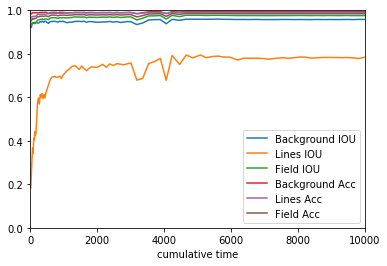

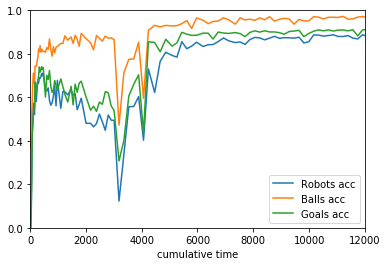

In [23]:
df7 = pd.read_csv('/home/user/jacobs/cudavision/Logs/test_logs_2_674.csv',skiprows=[1,2,3,4,5])
show_df_seg(df7)
show_df_det(df7)